# Construction of a prediction model for Covid19
## Part 2 (for part one look at the DataExploration notebook)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shap
import eli5
from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve
from sklearn.dummy import DummyClassifier
from mlxtend.classifier import StackingCVClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from colorama import Fore #To pain the terminal with different colors
import warnings
warnings.filterwarnings('ignore') #To disable warnings
from IPython.display import display #To print a dataframe like the cell does

shap.initjs() #So shap values can be displayed inline

In [2]:
all_data = pd.read_csv("covid_clinical_data.csv", index_col=0)
all_data

covid19_test_results  age high_risk_exposure_occupation  \
0                 Negative    4                          True   
1                 Negative    2                         False   
2                 Negative    1                           NaN   
3                 Negative    3                          True   
4                 Negative    1                         False   
...                    ...  ...                           ...   
93989             Negative    3                         False   
93990             Negative    3                         False   
93991             Negative    3                         False   
93993             Negative    3                         False   
93994             Negative    2                         False   

      high_risk_interactions  diabetes    chd    htn  cancer  asthma  \
0                        NaN     False  False  False   False   False   
1                        NaN     False  False  False   False   False   
2                        NaN     False  False  False   False   False   
3                       True     False  False  False   False   False   
4                        NaN     False  False  False   False   False   
...                      ...       ...    ...    ...     ...     ...   
93989                   True     False  False  False   False   False   
93990                   True     False  False  False   False   False   
93991                  False     False  False  False   False   False   
93993                  False     False  False  False   False   False   
93994                  False     False  False  False   False   False   

       autoimmune_dis  ...    sob  sob_severity  diarrhea  fatigue  headache  \
0               False  ...  False           0.0     False    False     False   
1               False  ...  False           0.0     False    False     False   
2               False  ...    NaN           NaN       NaN      NaN       NaN   
3               False  ...   True           2.0     False     True     False   
4               False  ...  False           0.0     False    False     False   
...               ...  ...    ...           ...       ...      ...       ...   
93989           False  ...  False           0.0     False    False     False   
93990           False  ...  False           0.0     False    False     False   
93991           False  ...  False           0.0     False    False     False   
93993           False  ...  False           0.0     False    False     False   
93994           False  ...  False           0.0     False    False     False   

       loss_of_smell  loss_of_taste runny_nose muscle_sore sore_throat  
0              False          False      False       False       False  
1              False          False      False       False       False  
2                NaN            NaN        NaN         NaN         NaN  
3              False          False      False       False        True  
4              False          False      False       False       False  
...              ...            ...        ...         ...         ...  
93989          False          False      False       False       False  
93990          False          False       True       False        True  
93991          False          False      False       False       False  
93993          False          False      False       False       False  
93994          False          False      False       False       False  

[51695 rows x 35 columns]

In [3]:
X = all_data.iloc[:, 1:]
y = all_data["covid19_test_results"]

X, test_x, y, test_y = train_test_split(X, y, test_size=.1)

## Splitting the data

Given that the data appears in the dictionary as taken by blocks (and seen how that matches the proportion of null values for every group) I have decided to split the data into the 4 types:<br>
- <u>Epidemiological factors:</u> 'age', 'high_risk_exposure_occupation' and 'high_risk_interactions'. These will be included in all datasets since I believe it might affect the results greatly and could be easily ignored for experimentation purposes. 
- <u>Comorbidities:</u> All columns from 'diabetes' to 'smoker'. Since this is the most complete dataset (almost all instances in the original dataset are not null) we will start with this.
- <u>Vitals:</u> All of the continues values ('temperature', 'pulse', etc.) I try to use simple linear regression and compare it against both trees and xgboost algorithms.
- <u>Clinician Assessed symptoms:</u> 'ctab', 'labored_respiration', 'rhonchi' and 'wheezes'. I will use naive bayes, trees and/or xgboost.
- <u>Patient reported symptoms:</u> All remaining columns. Again, naive bayes, trees and/or xgboost.

After I have each dataset, I will impute the null corresponding to the most frequent in each case and train several models for each one of them

In [4]:
def create_different_datasets(data_x):
    e_factors = data_x.iloc[:,:3]
    comorbidities_data = data_x.iloc[:, 3:10] #The columns that contain the comorbidities
    vitals_data = data_x.iloc[:, 10:16] #The columns that contain the vitals
    assesed_symptoms_data = data_x.iloc[:, 16:21] #The columns that contain the assesed symptoms
    reported_symptoms_data = data_x.iloc[:,21:] #The columns that have the patient reported symptoms
    
    return e_factors, comorbidities_data, vitals_data, assesed_symptoms_data, reported_symptoms_data

In [5]:
e_factors, comorb, vitals, a_symptoms, r_symptoms = create_different_datasets(X)

<u>high_risk_exposure_occupation:</u> The most obvious thing to do is to just fill the 169 missing values with the most frequent value. However, it occurred to me that since we ultimately are willing to have (maybe even encourage) false positives, it might be better to just put the ones that tested positive as True and the rest as False. This would require that I split the dataset into training, validation and testing set before I do any imputation to avoid any target leakage (the effect when knowing the result before hand affects how are we imputing the variables). The step to be taken (if I were to follow that route) would be then to impute the training data that tested positive as True, the rest as False, and any incoming unknown data (validation and test data) as True if we dont know the value of the feature. I might need to run an experiment when I do both.

<u>high_risk_interaction:</u> This is easier than the previous one. We will just assign True to anything that has a 'high_risk_expossure_occupation' as True. The reasoning behind is is that if we don't know if the patient has had a high risk interaction, makes sense to say they did if their occupation is of high risk exposure.

In [6]:
def high_risk_exposure_imputation(data_x, data_y, target_imputation=False):    
    if target_imputation:
        mode = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]
    else:
        mode = True
    data_x.loc[data_x["high_risk_exposure_occupation"].isna(), "high_risk_exposure_occupation"] = mode
    
    data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]

def vitals_imputation_generic(data_x):
    data = data_x.copy()
    data.loc[data["temperature"].isna(),"temperature"] = data["temperature"].mean()
    data.loc[data["pulse"].isna(),"pulse"] = data["pulse"].median()
    data.loc[data["rr"].isna(),"rr"] = data["rr"].median()
    data.loc[data["sats"].isna(),"sats"] = data["sats"].median()
    data.loc[data_x["pam"].isna(), "pam"] = data_x["pam"].mean()
    
    return data


In [7]:
def reduce_training_set(data_x, data_y):
    selected_negatives = data_x[data_y[data_x.index] == "Negative"].sample((data_y[data_x.index] == "Positive").sum())
    all_positives = data_x[data_y == "Positive"]
    #reduced_train_comorb = pd.merge(all_positives, selected_negatives) #Doesn't work well for reasons...
    reduced_data = pd.concat([all_positives, selected_negatives])

    return reduced_data

def specificity_score(*values):    
    cm = confusion_matrix(*values)    
    return cm[0][0] / (cm[0][0] + cm[0][1]) 


def get_metrics(*values):
    '''
        Gets evaluation metrics for a set of predictions
        values: a tuple in the form of '(actual, predictions)'
    '''
    accuracy = accuracy_score(*values)
    recall = recall_score(*values, pos_label="Positive")
    precision = precision_score(*values, pos_label="Positive")
    f1 = f1_score(*values, pos_label="Positive")
    specificity = specificity_score(*values)
    return accuracy, recall, precision, specificity, f1 


In [85]:
class Imputer():
    
    vitals = ["temperature", "pulse", "rr", "sats", "pam"]
    
    def __init__(self):
        self.column_values = {}
        self.vitals_values = {}
        
    def fit_transform(self, data_x, data_y):
        self.fit(data_x, data_y)
        self.transform(data_x, training=True)
        
    def fit(self, data_x, data_y):
        self.get_high_risk_exposure_value(data_x, data_y)
        self.get_vitals_values(data_x)
        self.get_a_symptoms_values(data_x)
        self.get_r_symptoms_values(data_x)
        
    def transform(self, data_x, training=False):
                
        for feature in data_x.columns:           
            
            if feature in self.column_values:
                new_value = self.column_values[feature]
                
                if feature == "high_risk_exposure_occupation" and not training:
                    new_value=True             
                    
                data_x.loc[data_x[feature].isna(), feature] = new_value
                
                #We standardize the vitals 
                if feature in Imputer.vitals:
                    data_x[feature] = (data_x[feature] - self.vitals_values[feature][0]) / self.vitals_values[feature][1] 
                
        if "high_risk_interactions" in data_x.columns: #Because this depends on 'high_risk_exposure_occupation being imputed first'
            data_x.loc[data_x["high_risk_interactions"].isna(), "high_risk_interactions"] = data_x["high_risk_exposure_occupation"]
        
        
        
    def get_high_risk_exposure_value(self, data_x, data_y):
        if "high_risk_exposure_occupation" in data_x.columns:
            self.column_values["high_risk_exposure_occupation"] = data_x[data_y == "Positive"].high_risk_exposure_occupation.mode()[0]

        
    def get_vitals_values(self, data_x):
        if "temperature" in data_x.columns:
            self.column_values["temperature"] =  data_x["temperature"].mean()
            self.vitals_values["temperature"] = (data_x["temperature"].mean(), data_x["temperature"].std())
            
        if "pulse" in data_x.columns:
            self.column_values["pulse"] = data_x["pulse"].median()
            self.vitals_values["pulse"] = (data_x["pulse"].mean(), data_x["pulse"].std())
            
        if "rr" in data_x.columns:
            self.column_values["rr"] = data_x["rr"].median()
            self.vitals_values["rr"] = (data_x["rr"].mean(), data_x["rr"].std())
            
        if "sats" in data_x.columns:
            self.column_values["sats"] = data_x["sats"].median()
            self.vitals_values["sats"] = (data_x["sats"].mean(), data_x["sats"].std())
            
        if "pam" in data_x.columns:
            self.column_values["pam"] =  data_x["pam"].mean()
            self.vitals_values["pam"] = (data_x["pam"].mean(), data_x["pam"].std())
            
    def get_a_symptoms_values(self, data_x):
        
        if "ctab" in data_x.columns:
            self.column_values["ctab"] = data_x["ctab"].mode()[0]
            
        if "labored_respiration" in data_x.columns:
            self.column_values["labored_respiration"] = data_x["labored_respiration"].mode()[0]
            
        if "rhonchi" in data_x.columns:
            self.column_values["rhonchi"] = data_x["rhonchi"].mode()[0]
            
        if "wheezes" in data_x.columns:
            self.column_values["wheezes"] = data_x["wheezes"].mode()[0]
            
        if "days_since_symptom_onset" in data_x.columns:
            self.column_values["days_since_symptom_onset"] = data_x["days_since_symptom_onset"].median()
            
    def get_r_symptoms_values(self, data_x):
        if "cough" in data_x.columns:
            self.column_values["cough"] = data_x["cough"].mode()[0]
            
        if "cough_severity" in data_x.columns:
            self.column_values["cough_severity"] = data_x["cough_severity"].mode()[0]
            
        if "fever" in data_x.columns:
            self.column_values["fever"] = data_x["fever"].mode()[0]
            
        if "sob" in data_x.columns:
            self.column_values["sob"] = data_x["sob"].mode()[0]
            
        if "sob_severity" in data_x.columns:
            self.column_values["sob_severity"] = data_x["sob_severity"].mode()[0]
        
        if "diarrhea" in data_x.columns:
            self.column_values["diarrhea"] = data_x["diarrhea"].mode()[0]
            
        if "fatigue" in data_x.columns:
            self.column_values["fatigue"] = data_x["fatigue"].mode()[0]
            
        if "headache" in data_x.columns:
            self.column_values["headache"] = data_x["headache"].mode()[0]
            
        if "loss_of_smell" in data_x.columns:
            self.column_values["loss_of_smell"] = data_x["loss_of_smell"].mode()[0]
            
        if "loss_of_taste" in data_x.columns:
            self.column_values["loss_of_taste"] = data_x["loss_of_taste"].mode()[0]
    
        if "runny_nose" in data_x.columns:
            self.column_values["runny_nose"] = data_x["runny_nose"].mode()[0]
            
        if "muscle_sore" in data_x.columns:
            self.column_values["muscle_sore"] = data_x["muscle_sore"].mode()[0]
            
        if "sore_throat" in data_x.columns:
            self.column_values["sore_throat"] = data_x["sore_throat"].mode()[0]


In [9]:
class XGBAdapter:
    
    def __init__(self, **params):
        self.model = XGBClassifier(**params, verbosity=0)
        
    def fit(self, data_x, data_y, sample_weight=None):
        self.model.fit(self.xgb_adapter(data_x), data_y, sample_weight=sample_weight)
        
    def predict(self, data_x):
        return self.model.predict(self.xgb_adapter(data_x))
    
    def predict_proba(self, data_x):
        return self.model.predict_proba(self.xgb_adapter(data_x))
    
    def score(self, X, y, sample_weight=None):
        return self.model.score(X, y, sample_weight=None)
    
    #This function is because xgb complains about 'object' type columns so I convert them all to boolean
    def xgb_adapter(self, data_x):
        result = data_x.copy()
        for column in result:
            if data_x[column].dtype == "object":
                result.loc[:,column] = result[column].astype("bool")
        return result

In [10]:
def calculate_shap_values(model, data_x):
    explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
    sample = data_x.sample(1)
    display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
    
def permutation_importance(model, X, Y, num_shuffles=50):
    feature_score_difference = np.full((len(X.columns), num_shuffles), 0, dtype=float)
    og_predictions = model.predict(X)
    og_error = accuracy_score(Y, og_predictions)
    for i in range(len(X.columns)): # Para cada feature
        feature = X.columns[i]
        shuffled_values = pd.DataFrame(X, copy = True) # Para que no afecte el dataset original solo copiamos los valores
        for j in range(num_shuffles):
            np.random.shuffle(shuffled_values[feature].values)
            col_preds = model.predict(shuffled_values)
            col_error = accuracy_score(Y, col_preds)
            feature_score_difference[i][j] = col_error - og_error # og tiene que ser mas pequeño
    result_table = np.array([feature_score_difference.mean(axis=1), feature_score_difference.std(axis=1)])
    
    df = pd.DataFrame(np.transpose(result_table), columns=["Importancia", "Desviacion estándar"], index=X.columns)
    return df.sort_values(by="Importancia", ascending = False)

In [11]:
def cross_validation_normal(data_x, data_y, model, folds, sample_weights=None, class_threshold=.5):
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics
    if sample_weights is None:
        sample_weights = np.ones(data_y.shape)
       
    data_x = data_x.sample(data_x.shape[0])
    fold_size = data_x.shape[0] // folds
    reminder = data_x.shape[0] % folds    
    start = 0    
    imputer = Imputer()
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1
        train_x = pd.concat([data_x.iloc[:start], data_x.iloc[end:]], axis=0)
        train_y = data_y[train_x.index]
        valid_x = data_x.iloc[start:end]
        valid_y = data_y[valid_x.index]
                    
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
            
        model.fit(train_x, train_y, sample_weight=np.append(sample_weights[:start], sample_weights[end:]))
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
        
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
    print("")    
       
    
    return results.mean(axis=0), results.std(ddof=1, axis=0)



def cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=1, class_threshold=.5, plot_roc=True, feature_importances=True):
    
    positive_index = data_y[data_y == "Positive"].index
    size_of_negatives = positive_index.shape[0] * ratio_negatives_to_positives
    
    fold_size = positive_index.shape[0] // folds
    results = np.zeros((folds,2,6)) #Shape of folds, training and validation, and number of metrics   
        
    reminder = positive_index.shape[0] % folds
    
    imputer = Imputer()
    start = 0    
    for i in range(folds):
        end = start + fold_size + (1 if reminder > 0 else 0)
        reminder-=1        
        training_positives = np.setdiff1d(positive_index, positive_index[start:end]) #The index of positives to be used as training set
                
        # Sample the size of negatives- the size of the fold negatives for training and concatenate with the corresponding indexes for the fold
        train_x = pd.concat([data_x[data_y == "Negative"].sample(size_of_negatives - (fold_size * ratio_negatives_to_positives)), data_x.loc[training_positives]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        train_y = data_y[train_x.index]
        
        rest_of_x = data_x.loc[~data_x.index.isin(train_x.index)] ## Al data not used by training
        valid_x = pd.concat([rest_of_x[data_y == "Negative"].sample(fold_size * ratio_negatives_to_positives), data_x.loc[positive_index[start:end]]], axis=0) # 'loc' instead of 'iloc' because the indexes are treated as labels, not numbers
        valid_y = data_y[valid_x.index]
        
        imputer.fit_transform(train_x, train_y)
        imputer.transform(valid_x)
                    
        model.fit(train_x, train_y)
        
        ##The following lines are for predicting via probability
        t_pred_prob = model.predict_proba(train_x)[:,1] ## We choose '1' in predict_proba since that is the positive class
        v_pred_prob = model.predict_proba(valid_x)[:,1]  ## We choose '1' in predict_proba since that is the positive class      
               
        t_preds = np.zeros(train_x.shape[0], dtype = np.object)
        t_preds[t_pred_prob > class_threshold] = "Positive"
        t_preds[t_pred_prob <= class_threshold] = "Negative"
        
        v_preds = np.zeros(valid_x.shape[0], dtype = np.object)
        v_preds[v_pred_prob > class_threshold] = "Positive"
        v_preds[v_pred_prob <= class_threshold] = "Negative"
        
        ##End of probability calculations
        
        train_v = (train_y, t_preds) #original: insted of t_preds is model.predict
        valid_v = (valid_y, v_preds)  #original: insted of v_preds is model.predict
        results[i,0] += get_metrics(*train_v) + (roc_auc_score(train_y, t_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        results[i,1] += get_metrics(*valid_v) + (roc_auc_score(valid_y, v_pred_prob),) ## We add a comma to turn the result into a tuple so we can append it
        start = end
        
        progress_bar = "╠" + str("■" * i) + str(" " * (folds -(i+1))) + "╣"
        print(progress_bar, end="\r")
                    
    print("")
    
    try:

        train_shap_x = pd.concat([data_x[data_y == "Negative"].sample((size_of_negatives - fold_size) // 2), data_x.loc[positive_index].sample((size_of_negatives - fold_size) // 2)], axis=0)
        
        test_shap_x = data_x.loc[np.setdiff1d(data_x.index.values, train_shap_x.index.values)].sample(fold_size)

        imputer.fit_transform(train_shap_x, data_y[train_shap_x.index])
        imputer.transform(test_shap_x)
        model.fit(train_shap_x, data_y[train_shap_x.index])
        
        
        if plot_roc:
            roc_values = roc_curve(data_y[test_shap_x.index], model.predict_proba(test_shap_x)[:,1], pos_label="Positive", drop_intermediate=False)
                      
            fig, ax = plt.subplots(1, 2, sharey=True, figsize=(21,7))
            
            ax[0].plot(roc_values[2], roc_values[0], 'b-', label="Recall")
            ax[0].plot(roc_values[2], roc_values[1], 'r-', label="FPR")
            ax[0].set(xlabel = "Thresholds")
            ax[0].legend()
            
             ## The following lines produce the same result as calling the 'sklearn.metrics.plot_roc_curve'
            ax[1].plot(roc_values[0], roc_values[1], 'b-')
            ax[1].set(xlabel = "FPR (1-specificity)", ylabel= "TPR (recall)")
            
            #plot_roc_curve(model, test_shap_x, data_y[test_shap_x.index], drop_intermediate=True)
            plt.show()
        
        if feature_importances:
            #explainer = shap.KernelExplainer(model.predict_proba, np.zeros((1, data_x.shape[1])))
            #sample = data_x.sample(fold_size)
            #display(shap.force_plot(explainer.expected_value[1], explainer.shap_values(sample)[1], sample))
            #display(permutation_importance(model, test_shap_x, y[test_shap_x.index], 5)) ## Doesn't seem to be working very well
            PI = eli5.sklearn.PermutationImportance(model)
            PI.fit(test_shap_x, data_y[test_shap_x.index])
            print("feature_importances")
            display(eli5.show_weights(model, feature_names=list(data_x.columns)))
            print("Permutation Importance")
            display(eli5.show_weights(PI, feature_names=list(data_x.columns)))
        
    except Exception as e:
        print(e)
    
    
    return results.mean(axis=0), results.std(ddof=1, axis=0) # 'ddof=1' means the divisor will be n-1 (ddof is degrees of freedom) since this is a sample of all possible results

def run_threshold(data_x, data_y, model, thresholds=np.linspace(0,1, num=11), folds=10, ratio_negatives_to_positives=1):
    
    threshold_scores = np.zeros((5,thresholds.shape[0]))
    i = 0 #the threshold index im in
    for t in thresholds:
        
        
        results_mean, results_std = cross_validation_class_ratios(data_x, data_y, model, folds, ratio_negatives_to_positives=ratio_negatives_to_positives, class_threshold=t, plot_roc=False, feature_importances=False)
        print("Threshold:", t)       
        
        for metric in range(5):
            threshold_scores[metric,i] = results_mean[1][metric]      
        i+=1
    
    plt.figure(figsize=(21,7))
    plt.plot(thresholds, threshold_scores[0], label="Accuracy")
    plt.plot(thresholds, threshold_scores[1], label="Recall")
    plt.plot(thresholds, threshold_scores[2], label="Precision")
    plt.plot(thresholds, threshold_scores[3], label="Specificity")
    plt.plot(thresholds, threshold_scores[4], label="F1 score")
    plt.legend()
    plt.show()
    
    display(pd.DataFrame(threshold_scores, index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds))
        
def run_models(data_x, data_y, models, folds=10, ratio_negatives_to_positives=-1, sample_weights=None):
    result_table = np.zeros((2,len(models), 6))
    i = 0
    for model in models:
        print(Fore.RED, model, Fore.BLACK, sep="")
        try:
            if(ratio_negatives_to_positives >= 1):            
                results_mean, results_std = cross_validation_class_ratios(data_x, data_y, models[model], folds, ratio_negatives_to_positives)
            else:
                results_mean, results_std = cross_validation_normal(data_x, data_y, models[model], folds, sample_weights)    
            
            result_table[0,i] = results_mean[1]
            result_table[1,i] = results_std[1]
            
            print("")
            print("Mean metrics")
            display(pd.DataFrame(results_mean, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            print("Spread in metrics (sample std)")
            display(pd.DataFrame(results_std, index=["Training", "Validation"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
            
        except Exception as e:
            print(e)
        i+=1
        
    
    display(pd.DataFrame(result_table[0], index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))
    
    # The 2 in here is an aproximation of the t/z critical value (1.96 for z, and 2.2 for 9 degrees of freedom, so 2 is a good indication for certainty above 90%, reaching towards 95%)
    lower_bound_df = pd.DataFrame((result_table[0]- 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]) # We use a value of 2 stds for a 95% confidence level
    upper_bound_df = pd.DataFrame((result_table[0]+ 2*(result_table[1] / np.sqrt(folds))).astype("str"), index=models.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])
    interval_df = lower_bound_df + "-" + upper_bound_df
    
    display(interval_df)

In [12]:
models ={
    "Dummy Random" : DummyClassifier(strategy="uniform"), #does not have predict_proba
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    "SVM" : SVC(kernel='linear', probability=True), 
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

<i>Note: I tried to calculate data with the imbalanced datasets (cross validation with all positive and negative examples) and discovered that it didn't work so I deleted those experiments so the notebook looks cleaner with the ones that count</i>


Next step to either add more features or... implement a cross validation method that makes up for the difference between positives and negatives

In [13]:
comorb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46525 entries, 25963 to 90779
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   diabetes        46525 non-null  bool 
 1   chd             46525 non-null  bool 
 2   htn             46525 non-null  bool 
 3   cancer          46525 non-null  bool 
 4   asthma          46525 non-null  bool 
 5   autoimmune_dis  46525 non-null  bool 
 6   smoker          46525 non-null  bool 
dtypes: bool(7)
memory usage: 681.5 KB


Dummy Random
╠■■■■■■■■■╣


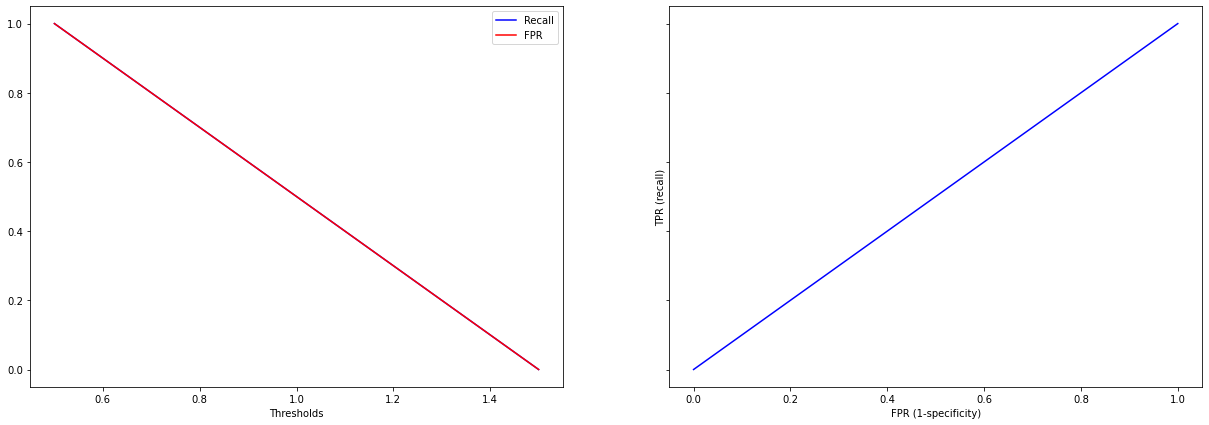

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


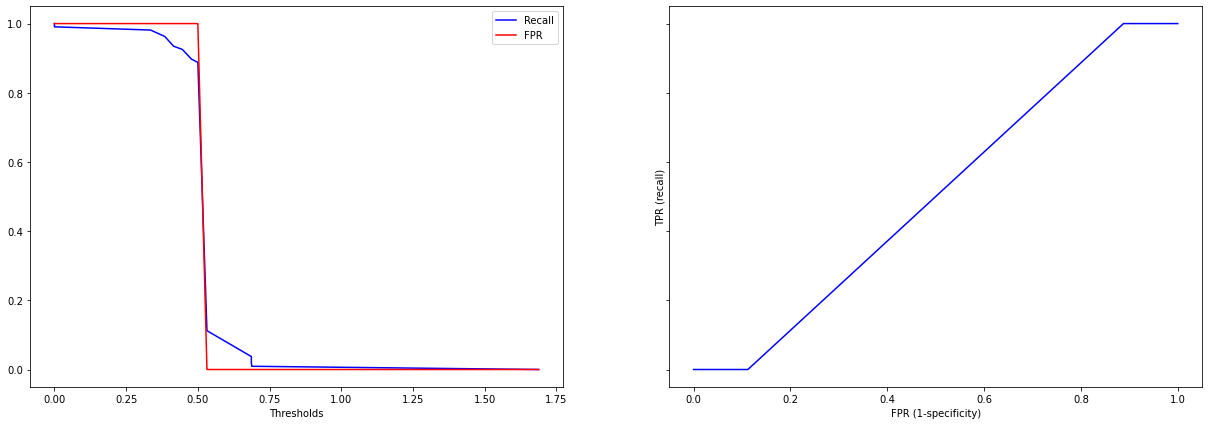

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.506276  0.053292   0.596582     0.959259  0.095823  0.520974
Validation  0.490741  0.044444   0.358626     0.937037  0.077129  0.498324

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004012  0.023941   0.068603     0.026860  0.039361  0.005824
Validation  0.014962  0.031415   0.202890     0.052342  0.051823  0.023721

Random Forest (100 estimators)
╠■■■■■■■■■╣


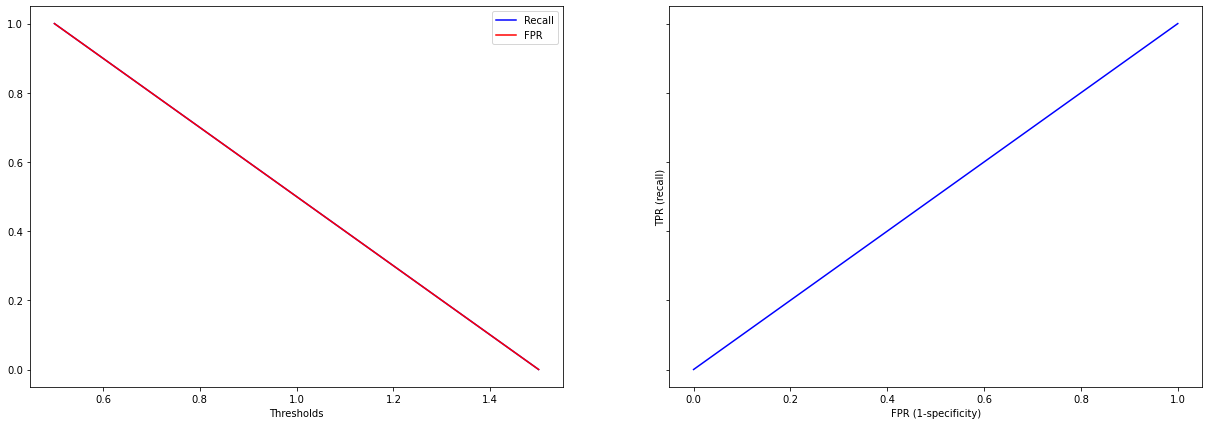

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1   ROC_AUC
Training         0.5     0.6        0.3          0.4  0.4  0.501029
Validation       0.5     0.6        0.3          0.4  0.4  0.500926

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training         0.0  0.516398   0.258199     0.516398  0.344265  0.003253
Validation       0.0  0.516398   0.258199     0.516398  0.344265  0.002928

XGBoost Classifier
╠■■■■■■■■■╣


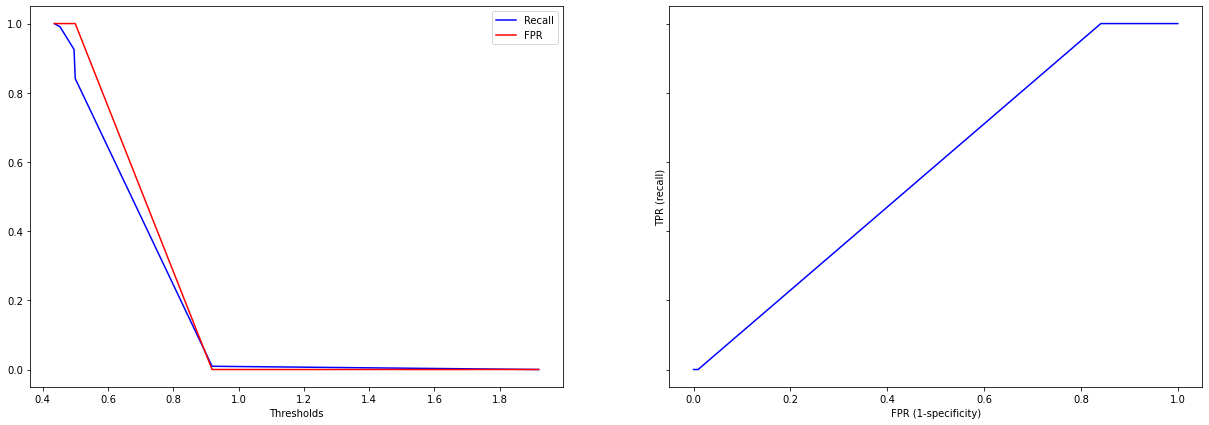

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.519753  0.889198   0.511411     0.150309  0.649238  0.528117
Validation  0.508796  0.881481   0.505400     0.136111  0.642247  0.506306

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005504  0.023219   0.003397     0.028706  0.005640  0.005030
Validation  0.024927  0.023827   0.014099     0.054874  0.013157  0.024243

SVM
╠■■■■■■■■■╣


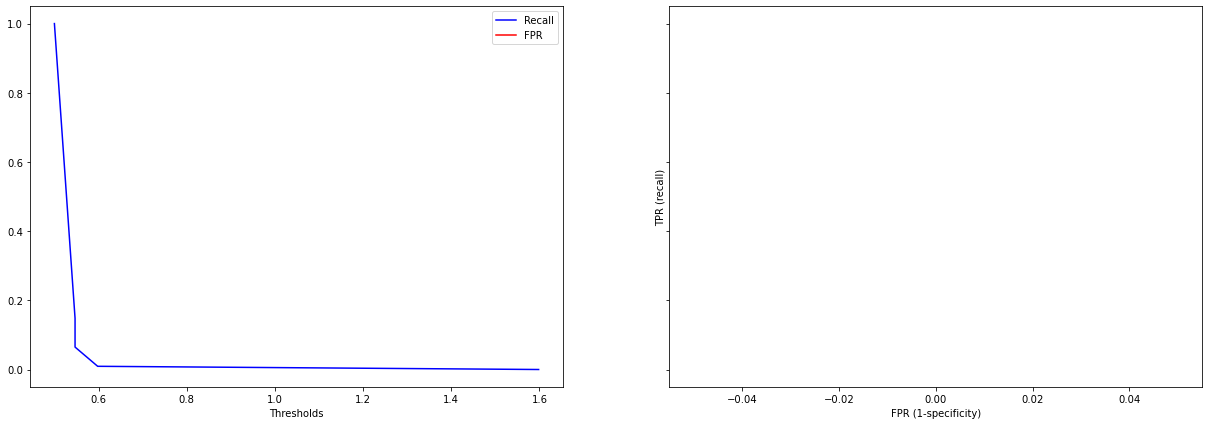

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.499640  0.312551   0.414815     0.686728  0.273822  0.498593
Validation  0.496296  0.310185   0.452575     0.682407  0.270571  0.493343

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.016314  0.396357   0.150591     0.366592  0.263358  0.019914
Validation  0.011298  0.390582   0.177437     0.394556  0.257589  0.014346

KNN
╠■■■■■■■■■╣


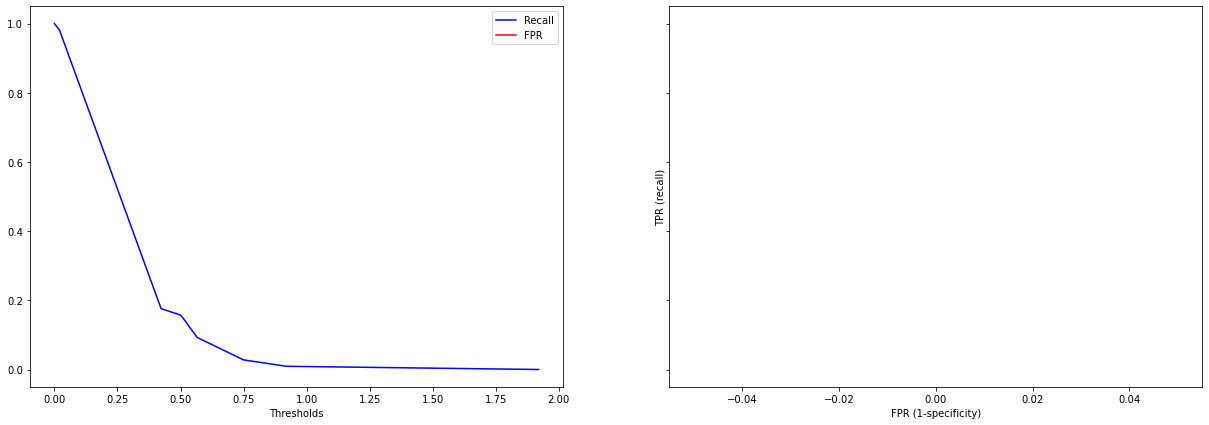

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.509774  0.046502   0.703167     0.973045  0.084688  0.499555
Validation  0.505093  0.042593   0.507737     0.967593  0.076250  0.496133

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001393  0.026748   0.119642     0.025958  0.044307  0.004433
Validation  0.015956  0.038351   0.349059     0.028705  0.065712  0.023747

Logistic Regression
╠■■■■■■■■■╣


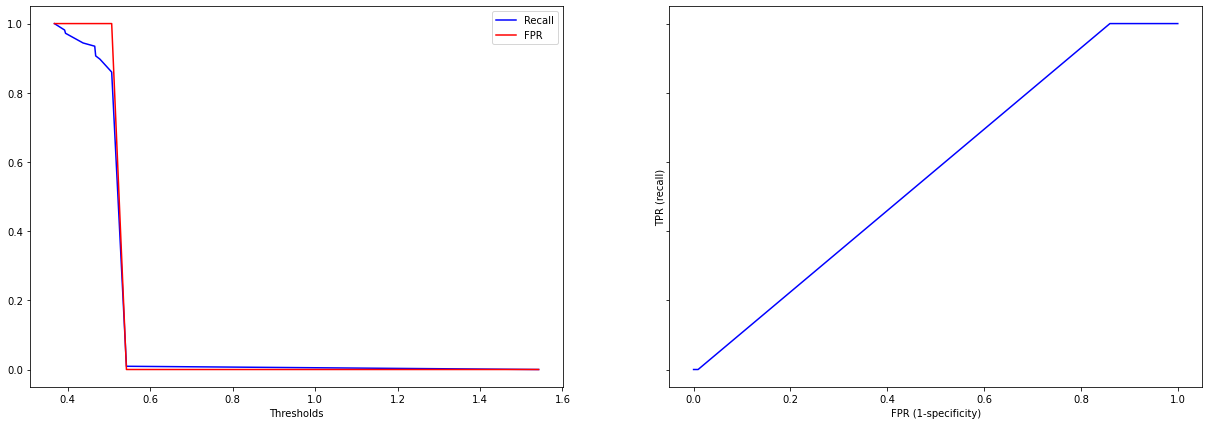

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.517438  0.879527   0.510142     0.155350  0.645694  0.524670
Validation  0.509259  0.877778   0.505327     0.140741  0.641316  0.508205

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005952  0.014912   0.003520     0.019694  0.004581  0.006414
Validation  0.018647  0.029539   0.010815     0.028887  0.015024  0.022435

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.490741  0.044444   0.358626     0.937037   
Random Forest (100 estimators)  0.500000  0.600000   0.300000     0.400000   
XGBoost Classifier              0.508796  0.881481   0.505400     0.136111   
SVM                             0.496296  0.310185   0.452575     0.682407   
KNN                             0.505093  0.042593   0.507737     0.967593   
Logistic Regression             0.509259  0.877778   0.505327     0.140741   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.077129  0.498324  
Random Forest (100 estimators)  0.400000  0.500926  
XGBoost Classifier              0.642247  0.506306  
SVM                             0.270571  0.493343  
KNN                             0.076250  0.496133  
Logistic Regression             0.641316  0.508205

Accuracy  \
Dummy Random                                                   0.5-0.5   
MultinomialNB                     0.4812779569649655-0.500203524516516   
Random Forest (100 estimators)                                 0.5-0.5   
XGBoost Classifier               0.4930313669270097-0.5245612256655829   
SVM                              0.48915071796124066-0.503441874631352   
KNN                                0.495001368688721-0.515183816496464   
Logistic Regression             0.49746606594164017-0.5210524525768782   

                                                                  Recall  \
Dummy Random                                                     0.0-0.0   
MultinomialNB                   0.024575954395764092-0.06431293449312478   
Random Forest (100 estimators)    0.27340136762890954-0.9265986323710904   
XGBoost Classifier                 0.8664116597336622-0.8965513032293009   
SVM                               0.06315974755917059-0.5572106228111999   
KNN                             0.018337181846433948-0.06684800333875122   
Logistic Regression                  0.85909537536985-0.8964601801857057   

                                                              Precision  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                   0.23030751657532839-0.48694523067741885   
Random Forest (100 estimators)   0.13670068381445477-0.4632993161855452   
XGBoost Classifier                0.4964829000613842-0.5143168741187256   
SVM                               0.3403540160326899-0.5647958777030009   
KNN                               0.2869726698584931-0.7285006287727003   
Logistic Regression              0.49848691254830557-0.5121668099947492   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                     0.9039331168449583-0.9701409572291158   
Random Forest (100 estimators)   0.07340136762890959-0.7265986323710905   
XGBoost Classifier               0.1014056967978504-0.17081652542437187   
SVM                               0.4328681276202696-0.9319466871945451   
KNN                               0.9494377269507993-0.9857474582343863   
Logistic Regression             0.12247080421364351-0.15901067726783794   

                                                                     F1  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                   0.04435354971506561-0.10990480591141408   
Random Forest (100 estimators)   0.18226757841927305-0.6177324215807269   
XGBoost Classifier                0.6339261397469491-0.6505687804540041   
SVM                             0.10765791933080279-0.43348450772341773   
KNN                              0.03469019062565566-0.1178104878763515   
Logistic Regression               0.6318145153160883-0.6508180757904176   

                                                               ROC_AUC  
Dummy Random                                                   0.5-0.5  
MultinomialNB                    0.4833211185824766-0.5133266866301435  
Random Forest (100 estimators)  0.49907407407407417-0.5027777777777779  
XGBoost Classifier               0.4909730002064319-0.5216384538402071  
SVM                             0.48426927234662154-0.5024162557740918  
KNN                             0.48111439178603815-0.5111524120548397  
Logistic Regression               0.494015297591805-0.5223941674287712

In [14]:
run_models(comorb, y[comorb.index], models, ratio_negatives_to_positives = 1)

Most of the models don't do better than random guessing (the metric we want to optimize is recall; however, since the data is being undersampled to combat the class imbalance, Accuracy is a good metric to keep an eye on as well). <b>Asthma</b>, <b>Smoker</b> and <b>Diabetes</b> seem to be the most prominent features, although they don't seem to be consistent (they change every time I run the cell again).

Dummy Random
╠■■■■■■■■■╣


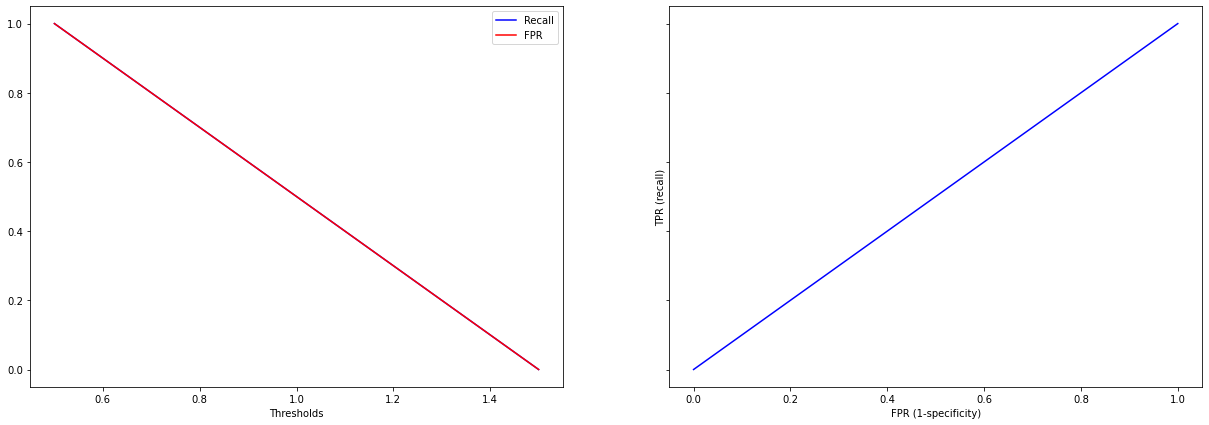

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


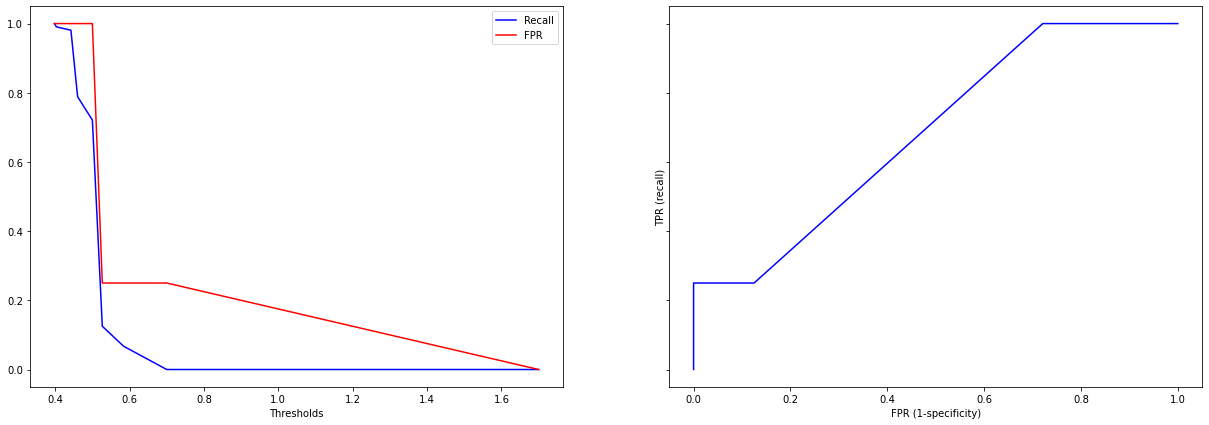

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.529115  0.192078   0.590750     0.866152  0.289404  0.561728
Validation  0.533796  0.187963   0.605477     0.879630  0.284840  0.556006

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007058  0.015887   0.025069     0.020964  0.017051  0.011207
Validation  0.028038  0.052205   0.081447     0.028288  0.067425  0.032367

Random Forest (100 estimators)
╠■■■■■■■■■╣


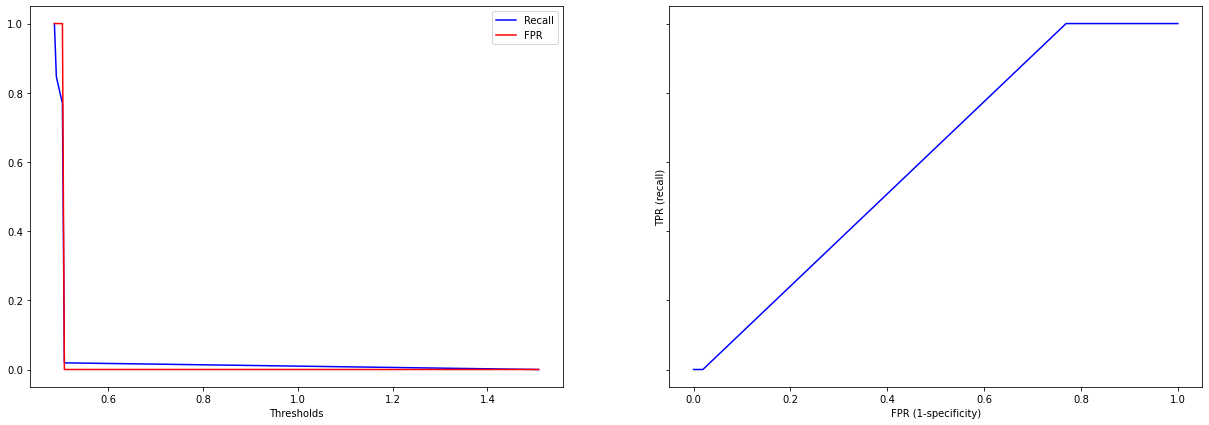

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.530813  0.451235   0.571614     0.610391  0.423583  0.550950
Validation  0.522685  0.436111   0.566865     0.609259  0.414070  0.546644

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004785  0.354377   0.047561     0.355673  0.192247  0.008711
Validation  0.034881  0.340331   0.119598     0.353521  0.192139  0.036189

XGBoost Classifier
╠■■■■■■■■■╣


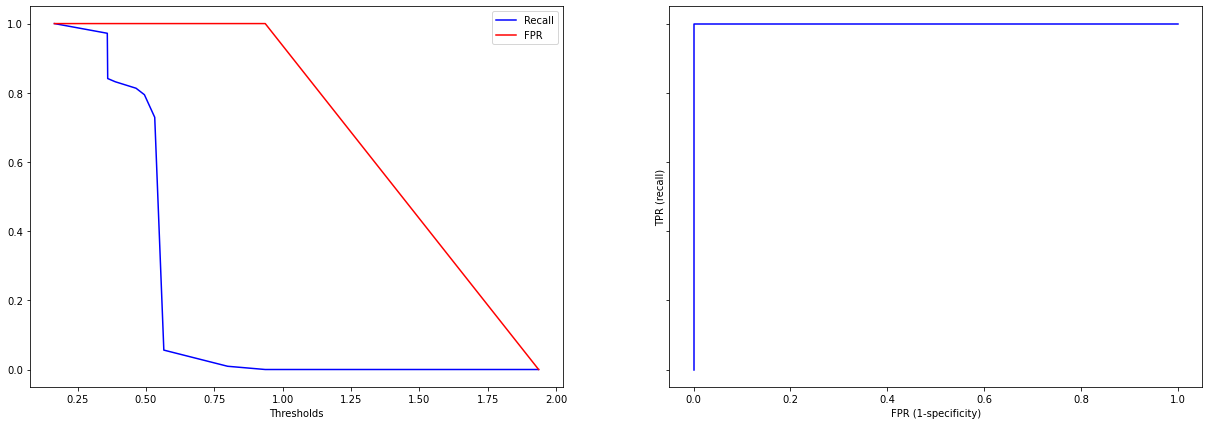

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.550206  0.788889   0.542836     0.311523  0.619945  0.575902
Validation  0.538426  0.783333   0.530069     0.293519  0.611216  0.566997

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005966  0.208941   0.035319     0.204198  0.112974  0.006930
Validation  0.032740  0.215882   0.025989     0.208055  0.122288  0.038077

SVM
╠■■■■■■■■■╣


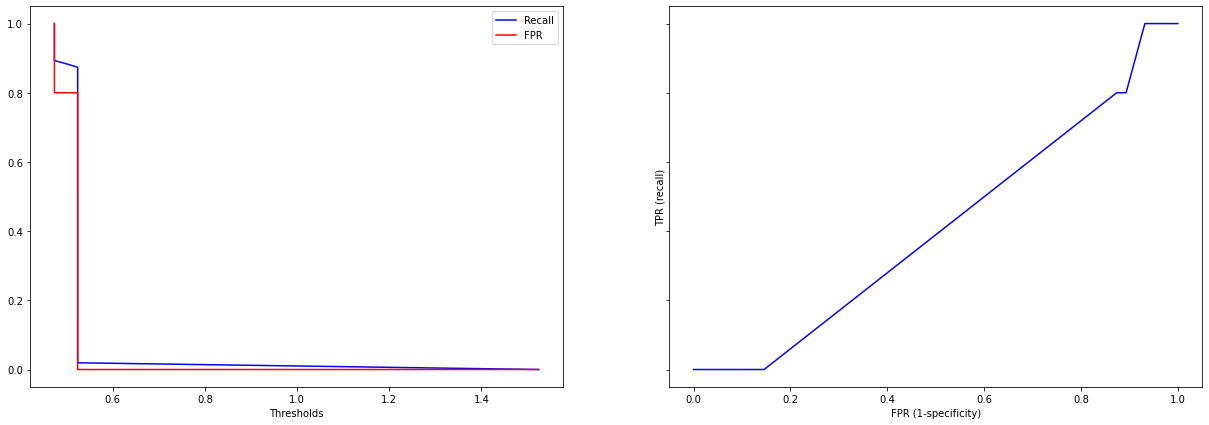

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.534259  0.318416   0.588022     0.750103  0.362210  0.553773
Validation  0.530093  0.312037   0.582115     0.748148  0.355414  0.553965

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005709  0.263625   0.037810     0.258922  0.146448  0.013797
Validation  0.036989  0.259041   0.109749     0.265389  0.157364  0.053448

KNN
╠■■■■■■■■■╣


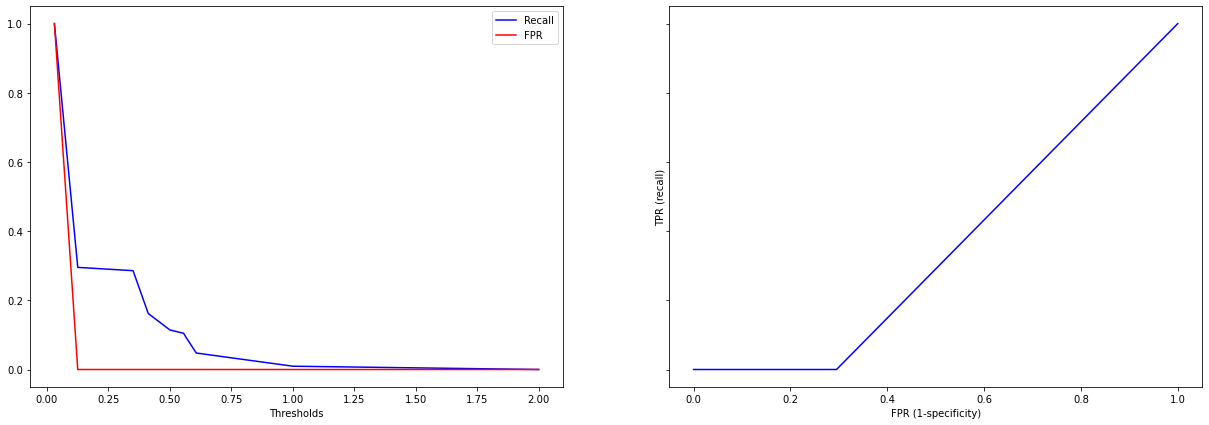

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.526132  0.114918   0.662251     0.937346  0.189387  0.554152
Validation  0.514352  0.100926   0.535620     0.927778  0.163469  0.549696

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010904  0.057613   0.052327     0.039033  0.079995  0.011433
Validation  0.030899  0.080300   0.139181     0.030802  0.109349  0.041767

Logistic Regression
╠■■■■■■■■■╣


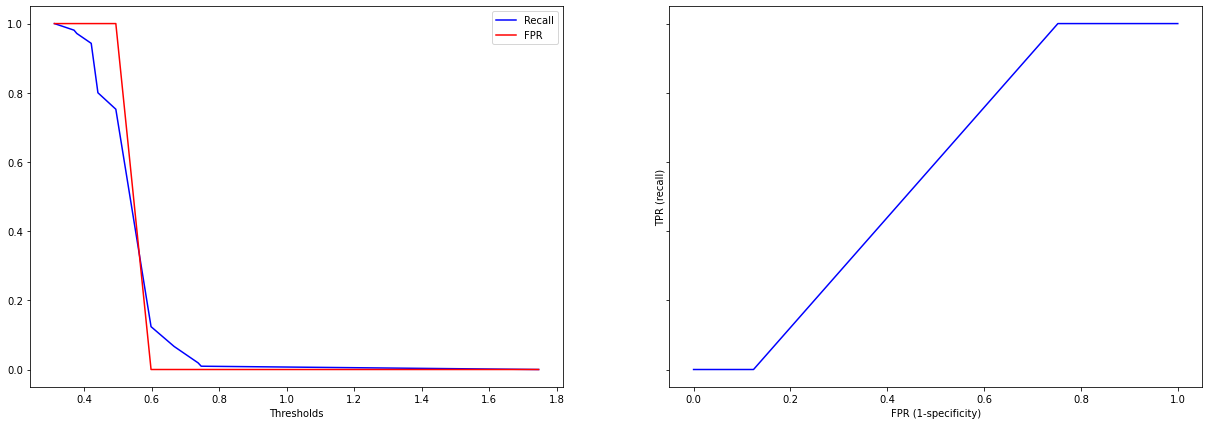

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.538837  0.662243   0.546214     0.415432  0.548027  0.561086
Validation  0.522685  0.650000   0.535039     0.395370  0.534461  0.548444

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006804  0.314601   0.034729     0.305870  0.166915  0.007692
Validation  0.019817  0.313869   0.043907     0.324031  0.166998  0.034702

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.533796  0.187963   0.605477     0.879630   
Random Forest (100 estimators)  0.522685  0.436111   0.566865     0.609259   
XGBoost Classifier              0.538426  0.783333   0.530069     0.293519   
SVM                             0.530093  0.312037   0.582115     0.748148   
KNN                             0.514352  0.100926   0.535620     0.927778   
Logistic Regression             0.522685  0.650000   0.535039     0.395370   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.284840  0.556006  
Random Forest (100 estimators)  0.414070  0.546644  
XGBoost Classifier              0.611216  0.566997  
SVM                             0.355414  0.553965  
KNN                             0.163469  0.549696  
Logistic Regression             0.534461  0.548444

Accuracy  \
Dummy Random                                                   0.5-0.5   
MultinomialNB                    0.5160634784910825-0.5515291141015102   
Random Forest (100 estimators)    0.5006242996561625-0.544746070714208   
XGBoost Classifier                0.5177192924472599-0.559132559404592   
SVM                              0.5066988338745221-0.5534863513106633   
KNN                             0.49480967145891774-0.5338940322447862   
Logistic Regression              0.5101518885776254-0.5352184817927451   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.1549454836535399-0.22098044227238597   
Random Forest (100 estimators)   0.22086657852170327-0.651355643700519   
XGBoost Classifier               0.6467977141395055-0.9198689525271612   
SVM                             0.14820541094775944-0.4758686631263146   
KNN                             0.05013954772326756-0.1517123041285843   
Logistic Regression             0.45149161625280376-0.8485083837471961   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.553965622953612-0.6569885922283586   
Random Forest (100 estimators)  0.4912251354650584-0.6425054112229706   
XGBoost Classifier              0.5136319469568443-0.5465062810532934   
SVM                             0.5127032387465811-0.6515262290725086   
KNN                             0.4475944118308419-0.6236463039750912   
Logistic Regression             0.5072696473198101-0.5628082268008442   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                       0.861739041054087-0.897520218205172   
Random Forest (100 estimators)   0.38567291116845254-0.8328456073500663   
XGBoost Classifier              0.16193274871488514-0.42510428832215197   
SVM                               0.5803013886483227-0.9159949076479738   
KNN                                0.9082966248912846-0.947258930664271   
Logistic Regression              0.19043488771792097-0.6003058530228197   

                                                                     F1  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                   0.24219679756448836-0.32748348074725037   
Random Forest (100 estimators)    0.2925506448313358-0.5355898755405444   
XGBoost Classifier                0.5338743934616814-0.6885573335277484   
SVM                               0.2558885502013888-0.4549400518737159   
KNN                              0.09431038832828012-0.2326272703109998   
Logistic Regression               0.4288420626855127-0.6400800129759501   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5355347752786426-0.5764765415937856  
Random Forest (100 estimators)  0.5237556175022395-0.5695314195347976  
XGBoost Classifier              0.5429144676892494-0.5910790165357163  
SVM                               0.52016194493265-0.5877684391551417  
KNN                             0.5232801681067014-0.5761111213308845  
Logistic Regression             0.5264961624787643-0.5703916976035406

In [15]:
comorb_ef = pd.concat([comorb.drop(columns="smoker"), e_factors.drop(columns="age")], axis=1)
run_models(comorb_ef, y[comorb_ef.index], models, ratio_negatives_to_positives = 1)

We definetley need another set, even though using the cross validation for data imbalancing helped a lot. <b>High risk exposure occupation</b> seems to be the most important feature from epidemiological factors. <i>Note:</i> Most of the models have really high specificity, which might not be a good thing since the recall is really low and both precision and accuracy are just around .5 (this experiments use undersampling to have balanced classes). This suggests that most of the models are predicting everything is negative.

### Vitals

$ PAM = DIA + \frac{SIS-DIA}{3}$<br>
where PAM = Presión arterial media
SIS = Sístole
DIA = Diástole

In [16]:
def calculate_pam(data_x):
    return data_x["dia"] + ((data_x["sys"] - data_x["dia"])/3)

In [17]:
pam = vitals["dia"] + ((vitals["sys"] - vitals["dia"])/3)
vitals = pd.concat([vitals, pam], axis=1)
vitals.rename({ 0 : "pam"}, axis=1,inplace =True) #To rename the column that was appended (which has a value of 0 that is not a string)
i = vitals[vitals.iloc[:,-1] >145].iloc[:,-1].index
pd.concat([vitals.loc[i, ["sys", "dia"]], e_factors.loc[i,"age"]], axis=1)

sys    dia  age
6106   215.0  115.0    4
14314  205.0  125.0    4
28579  180.0  130.0    3
19137  215.0  117.0    4
36197  190.0  135.0    3
48067  190.0  130.0    4
93508  200.0  118.0    4
9058   200.0  120.0    3
50607  220.0  108.0    4
20582  200.0  118.0    4
45860  220.0  115.0    3
91625  210.0  125.0    3
20168  190.0  130.0    4
31555  185.0  130.0    3
20379  220.0  140.0    4
11792  190.0  130.0    3
75219  195.0  130.0    2
76797  195.0  130.0    1
77724  190.0  135.0    2
31880  180.0  135.0    2

As expected, all pressure variables (including pam) are correlated between each other

In [18]:
#Drop all values that are Nan
vitals.dropna(how="all",inplace=True)
vitals.drop(columns=["sys", "dia"], inplace=True) #Because we have 'pam' we don't need it anymore (I ran some experiments and it is sligthly better with 'pam')
vitals.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43845 entries, 25963 to 90779
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  42272 non-null  float64
 1   pulse        42914 non-null  float64
 2   rr           36865 non-null  float64
 3   sats         42266 non-null  float64
 4   pam          41386 non-null  float64
dtypes: float64(5)
memory usage: 2.0 MB


In [19]:
vitals.describe()

temperature         pulse            rr          sats           pam
count  42272.000000  42914.000000  36865.000000  42266.000000  41386.000000
mean      36.795091     76.912523     14.713115     98.239625     93.222120
std        0.288259     13.224284      1.961170      1.403761     10.903332
min       34.650000     35.000000      8.000000     81.000000     50.333333
25%       36.650000     68.000000     13.000000     97.000000     86.000000
50%       36.800000     76.000000     15.000000     98.000000     92.666667
75%       36.950000     85.000000     16.000000     99.000000     99.666667
max       39.600000    150.000000     32.000000    100.000000    166.666667

<AxesSubplot:>

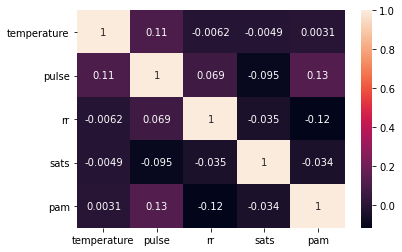

In [20]:
sns.heatmap(vitals.corr(), annot=True)

In [21]:
s_vitals = vitals.copy()
s_vitals = s_vitals.apply(lambda x: (x - x.mean()) / x.std())
n_vitals = vitals.copy()
n_vitals = s_vitals.apply(lambda x: (x - x.min()) / (x.max() - x.min()))

Dummy Random
╠■■■■■■■■■╣


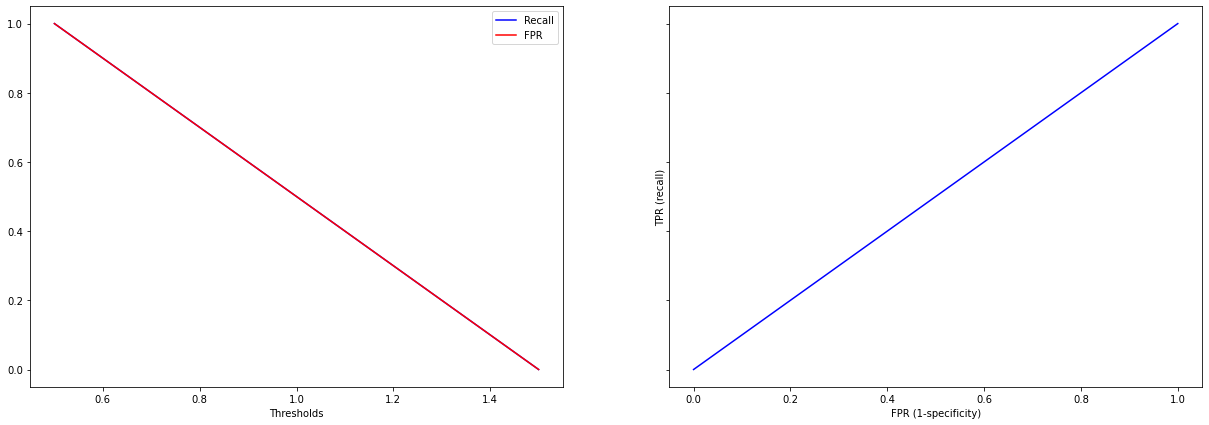

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


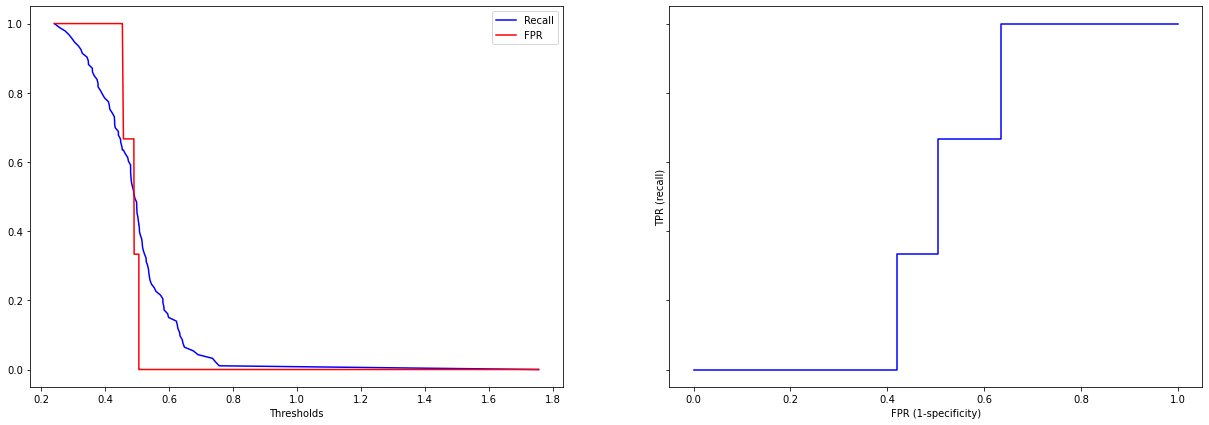

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.570330  0.537764   0.575020     0.602867  0.555752  0.597292
Validation  0.563283  0.535116   0.568966     0.591667  0.551148  0.587447

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006637  0.007130   0.007446     0.009717  0.006528  0.007939
Validation  0.026301  0.042694   0.026895     0.030979  0.032850  0.042675

Random Forest (100 estimators)
╠■■■■■■■■■╣


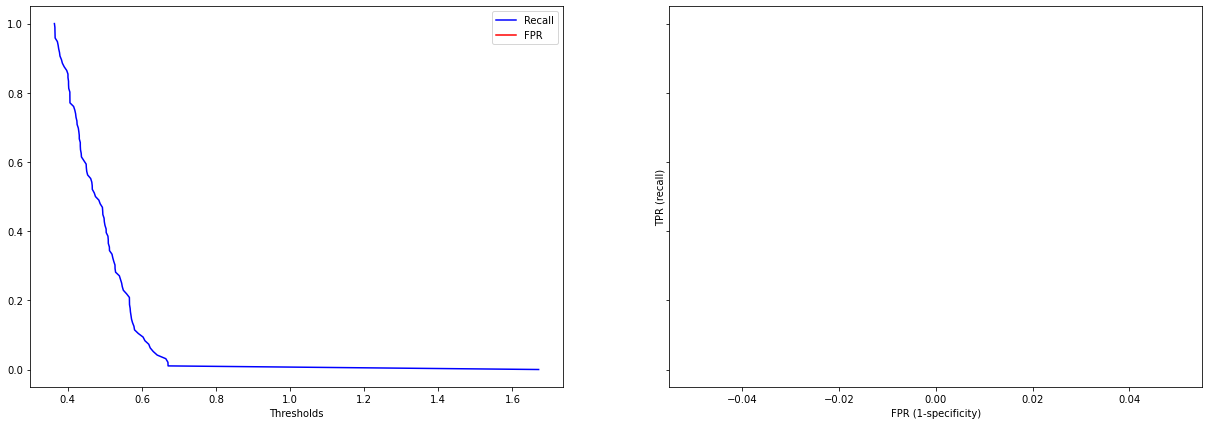

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.616855  0.580472   0.626233     0.653211  0.601675  0.669421
Validation  0.584035  0.546381   0.594010     0.621875  0.567825  0.637511

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008399  0.040411   0.010289     0.034785  0.019479  0.008181
Validation  0.026437  0.054411   0.029958     0.054692  0.034302  0.037260

XGBoost Classifier
╠■■■■■■■■■╣


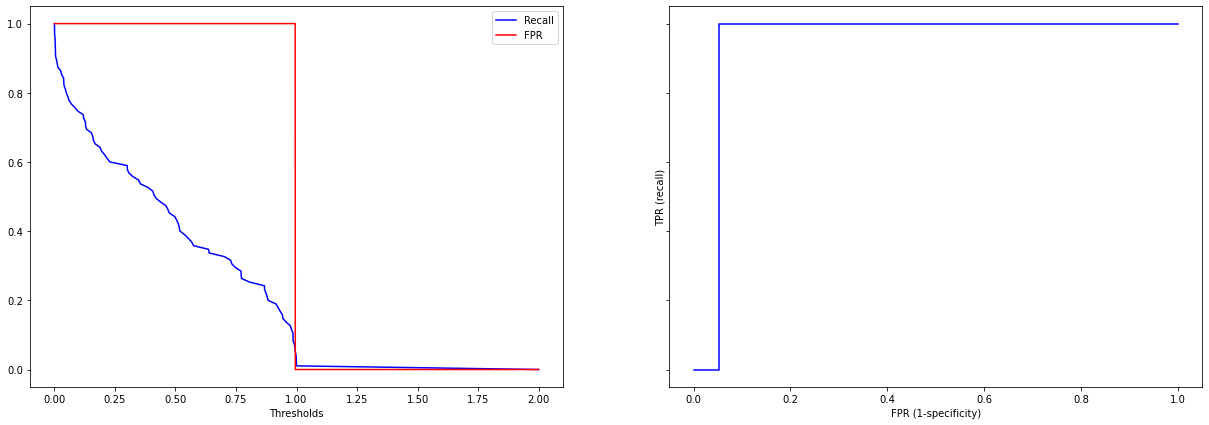

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998681  0.998737   0.998625     0.998624  0.998680  0.999994
Validation  0.531674  0.531057   0.534037     0.532292  0.532319  0.559584

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000857  0.001264   0.001299     0.001302  0.000858  0.000007
Validation  0.035509  0.038696   0.035375     0.044044  0.035214  0.042844

SVM
╠■■■■■■■■■╣


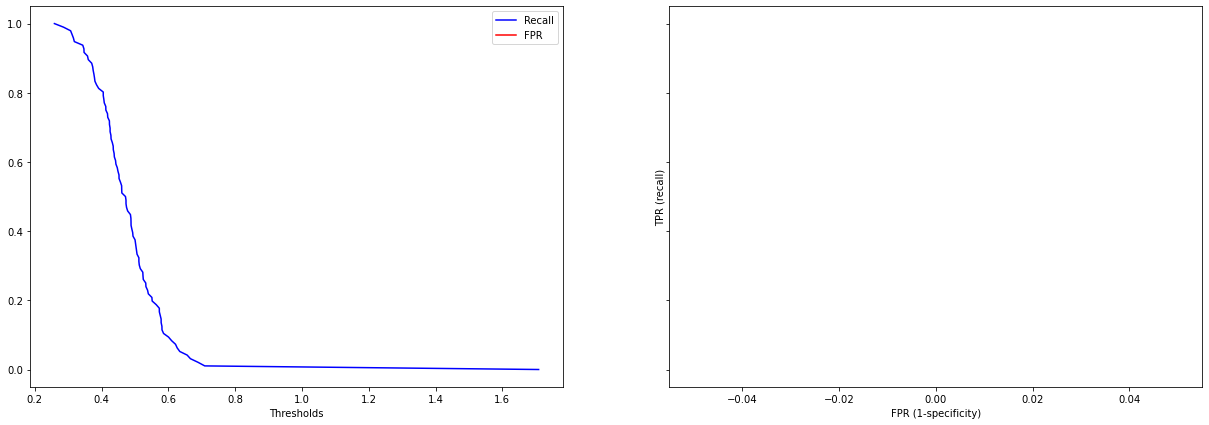

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.592531  0.537765   0.603592     0.647248  0.56873  0.637869
Validation  0.587144  0.535180   0.601501     0.639583  0.56544  0.630708

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008218  0.015352   0.008226     0.007397  0.011707  0.009133
Validation  0.042944  0.047583   0.051062     0.067185  0.041971  0.043128

KNN
╠■■■■■■■■■╣


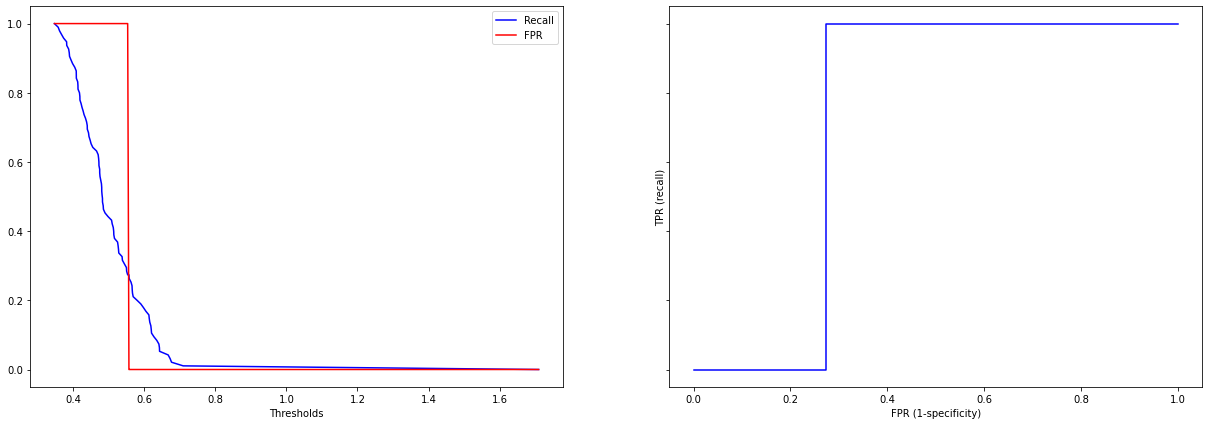

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998336  0.996901    0.99977     0.999771  0.998333  0.999993
Validation  0.549277  0.553587    0.55070     0.544792  0.550741  0.577357

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000874  0.001535   0.000485     0.000484  0.000877  0.000006
Validation  0.023531  0.065042   0.022482     0.051747  0.038118  0.034794

Logistic Regression
╠■■■■■■■■■╣


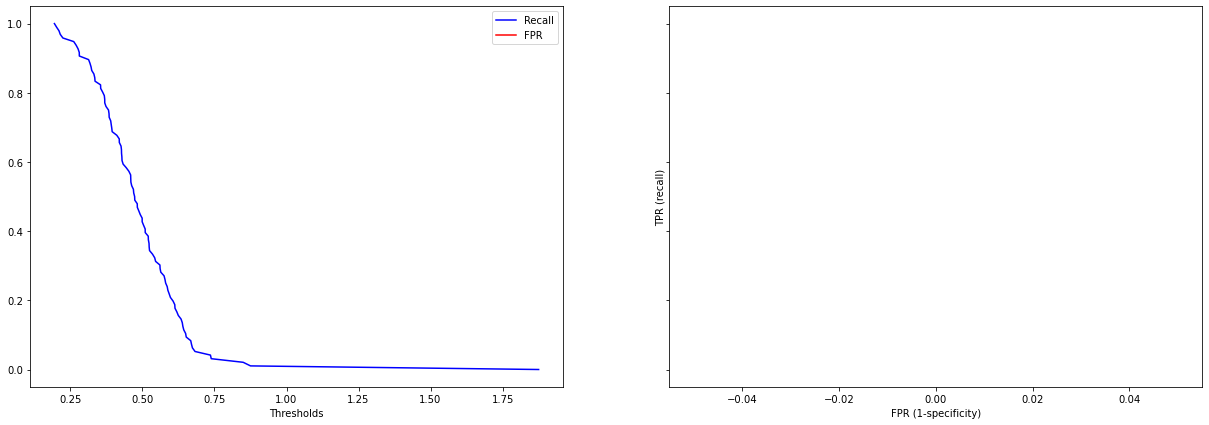

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.592187  0.561526   0.598116     0.622821  0.579216  0.636245
Validation  0.580913  0.560975   0.587034     0.601042  0.572498  0.619517

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.013361  0.010005   0.015105     0.018691  0.011902  0.017104
Validation  0.028158  0.055079   0.030844     0.054249  0.035802  0.031615

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.563283  0.535116   0.568966     0.591667   
Random Forest (100 estimators)  0.584035  0.546381   0.594010     0.621875   
XGBoost Classifier              0.531674  0.531057   0.534037     0.532292   
SVM                             0.587144  0.535180   0.601501     0.639583   
KNN                             0.549277  0.553587   0.550700     0.544792   
Logistic Regression             0.580913  0.560975   0.587034     0.601042   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.551148  0.587447  
Random Forest (100 estimators)  0.567825  0.637511  
XGBoost Classifier              0.532319  0.559584  
SVM                             0.565440  0.630708  
KNN                             0.550741  0.577357  
Logistic Regression             0.572498  0.619517

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                    0.5466481327696217-0.579917065848686   
Random Forest (100 estimators)  0.5673145688997512-0.6007553792867775   
XGBoost Classifier              0.5092157590367918-0.5541316071117401   
SVM                             0.5599835041409187-0.6143040606259207   
KNN                             0.5343943074821592-0.5641592331050603   
Logistic Regression              0.563104070770722-0.5987212746524215   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5081141914668634-0.5621177672960234   
Random Forest (100 estimators)  0.5119687827353363-0.5807932447560726   
XGBoost Classifier               0.5065833501228815-0.555530051938974   
SVM                             0.5050865484427959-0.5652742762994721   
KNN                              0.5124508423521732-0.594722697166727   
Logistic Regression              0.526139861023544-0.5958103107977618   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.5519564779226418-0.585976141311128   
Random Forest (100 estimators)  0.5750625830160908-0.6129573671278349   
XGBoost Classifier              0.5116638050158098-0.5564103971197454   
SVM                             0.5692066831513741-0.6337961132911557   
KNN                             0.5364816571326799-0.5649190000188179   
Logistic Regression             0.5675267530178095-0.6065421162231605   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5720739778060195-0.6112593555273136   
Random Forest (100 estimators)  0.5872849738738548-0.6564650261261451   
XGBoost Classifier              0.5044358734442618-0.5601474598890717   
SVM                             0.5970915040533934-0.6820751626132732   
KNN                             0.5120642453668106-0.5775190879665227   
Logistic Regression             0.5667316129804566-0.6353517203528768   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5303722804547664-0.5719244761612725   
Random Forest (100 estimators)   0.546130555815019-0.5895200930173771   
XGBoost Classifier              0.5100473295632032-0.5545904919487966   
SVM                               0.5388947954105647-0.59198490387366   
KNN                             0.5266334777457954-0.5748490392132773   
Logistic Regression             0.5498549658210378-0.5951413141220571   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5604574625226657-0.6144369389664524  
Random Forest (100 estimators)  0.6139455554417899-0.6610765933984164  
XGBoost Classifier              0.5324869350605127-0.5866809844698427  
SVM                             0.6034319796989868-0.6579847406618381  
KNN                             0.5553512031033419-0.5993622490730617  
Logistic Regression             0.5995226270032222-0.6395123547407641

In [22]:
#All vitals without normalization or standardization
run_models(vitals, y[vitals.index], models, ratio_negatives_to_positives=1)

<b>Rr</b>, <b>pulse</b> and <b>temperature</b> seem to be the most dominant features in the experiments. <b>Random Forest</b> seems to be the best performing model here.

Dummy Random
╠■■■■■■■■■╣


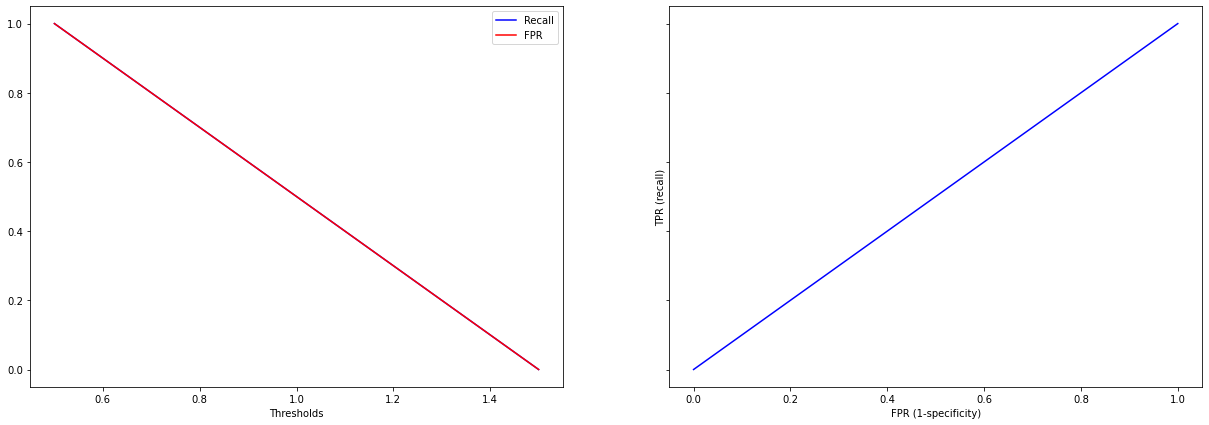

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


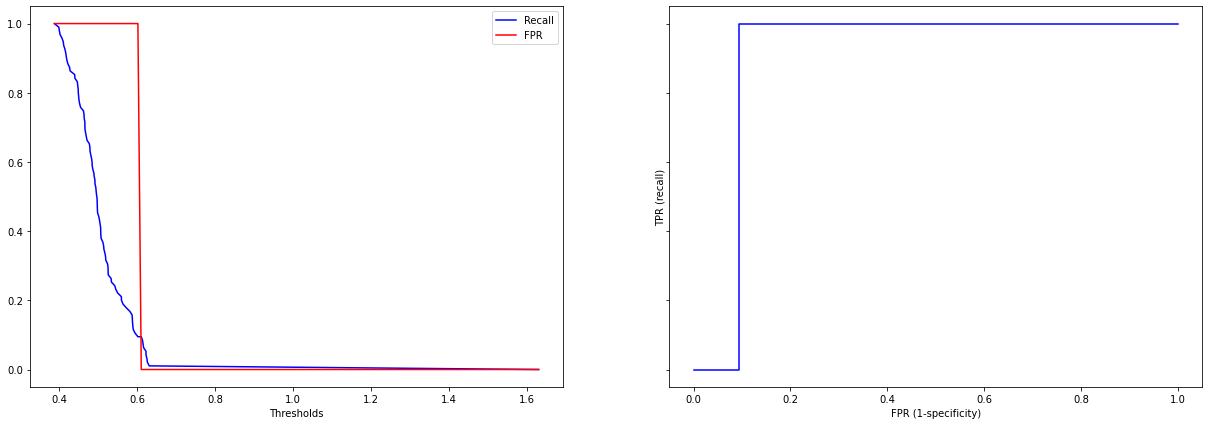

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.613758  0.569223   0.624996     0.658257  0.595507  0.662353
Validation  0.596999  0.544384   0.610390     0.650000  0.575049  0.639197

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011870  0.022593   0.015496     0.026704  0.014058  0.008521
Validation  0.041451  0.054200   0.044661     0.044249  0.048023  0.051172

XGBoost Classifier
╠■■■■■■■■■╣


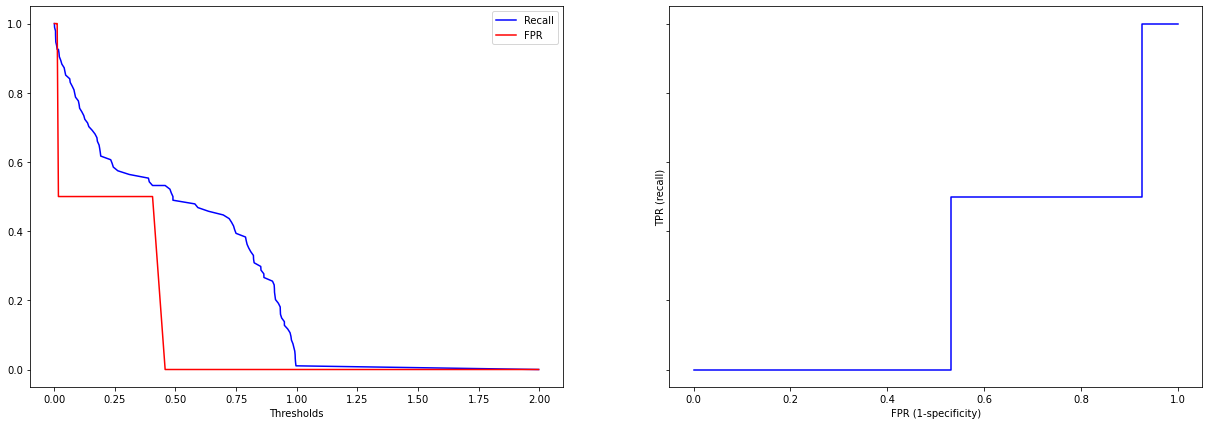

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997820  0.997016   0.998620     0.998624  0.997817  0.999986
Validation  0.553956  0.540324   0.556735     0.567708  0.546741  0.591427

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001319  0.001966   0.001056     0.001054  0.001322  0.000015
Validation  0.030663  0.075428   0.027780     0.049654  0.048418  0.032955

SVM
╠■■■■■■■■■╣


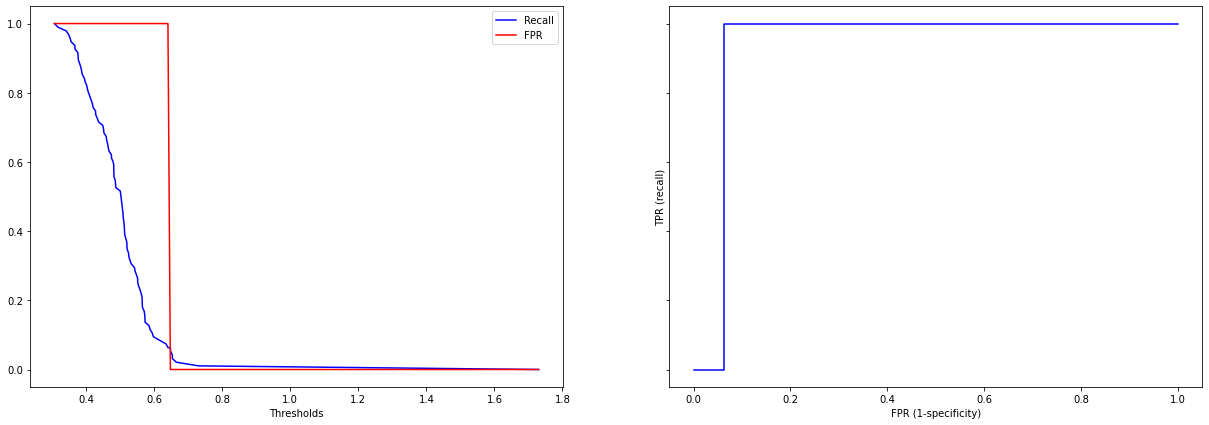

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.592990  0.540750   0.603648     0.645183  0.570445  0.639248
Validation  0.590255  0.534107   0.605243     0.646875  0.566619  0.643872

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008025  0.008120   0.009498     0.011920  0.007821  0.008487
Validation  0.025021  0.036673   0.032564     0.049945  0.026517  0.027595

KNN
╠■■■■■■■■■╣


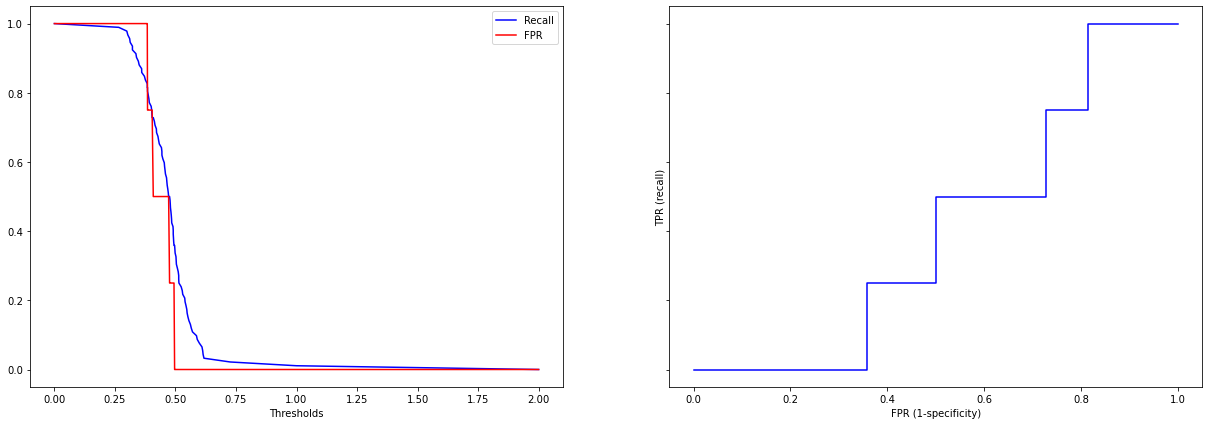

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998681  0.997360   1.000000     1.000000  0.998677  0.999995
Validation  0.583001  0.508333   0.603895     0.658333  0.550097  0.619086

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001014  0.002029    0.00000     0.000000  0.001018  0.000007
Validation  0.032414  0.042409    0.04427     0.078537  0.028105  0.029920

Logistic Regression
╠■■■■■■■■■╣


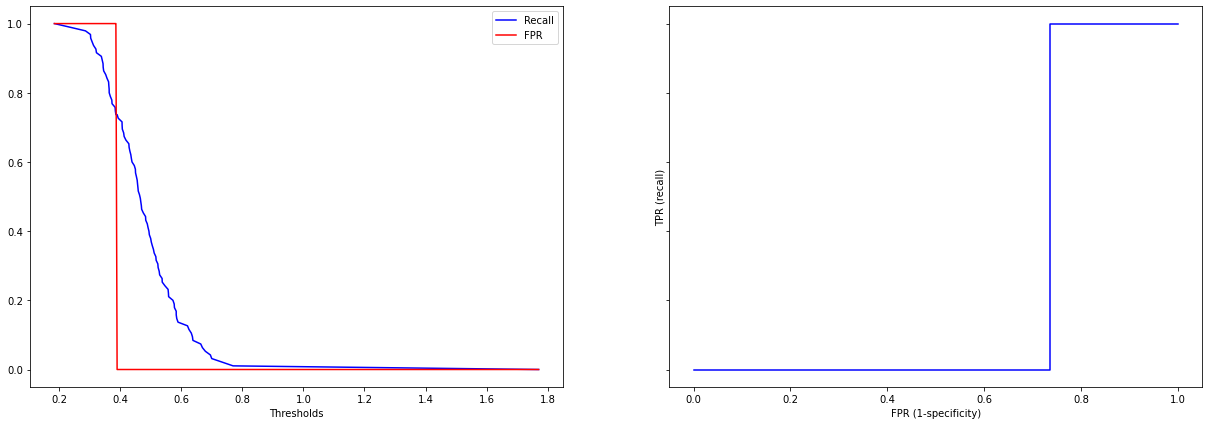

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.597809  0.561410   0.605254     0.634174  0.582495  0.642884
Validation  0.582518  0.557925   0.590028     0.607292  0.572796  0.632234

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006857  0.008435   0.007445     0.008181  0.007457  0.009853
Validation  0.046325  0.053055   0.049298     0.064783  0.046235  0.045166

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.596999  0.544384   0.610390     0.650000   
XGBoost Classifier              0.553956  0.540324   0.556735     0.567708   
SVM                             0.590255  0.534107   0.605243     0.646875   
KNN                             0.583001  0.508333   0.603895     0.658333   
Logistic Regression             0.582518  0.557925   0.590028     0.607292   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.575049  0.639197  
XGBoost Classifier              0.546741  0.591427  
SVM                             0.566619  0.643872  
KNN                             0.550097  0.619086  
Logistic Regression             0.572796  0.632234

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5707835171761941-0.6232147557080892   
XGBoost Classifier              0.5345633472424316-0.5733490016349434   
SVM                             0.5744303165438945-0.6060802620398708   
KNN                             0.5625007719702207-0.6035020345928189   
Logistic Regression             0.5532200600258323-0.6118166411831485   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5101045400358762-0.5786626420947082   
XGBoost Classifier              0.4926193411881602-0.5880292842413929   
SVM                             0.5109123499835941-0.5573007084356498   
KNN                             0.4815112716791027-0.5351553949875639   
Logistic Regression             0.5243705880799968-0.5914799273839205   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.582143453164583-0.6386360292399482   
XGBoost Classifier              0.5391653302040278-0.5743045799910418   
SVM                             0.5846481536605287-0.6258386633310896   
KNN                             0.5758959563498934-0.6318939134254801   
Logistic Regression             0.5588494258906528-0.6212068766235487   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6220146643338751-0.6779853356661247   
XGBoost Classifier              0.5363043915150137-0.5991122751516528   
SVM                             0.6152873182901549-0.6784626817098448   
KNN                             0.6086623479382011-0.7080043187284658   
Logistic Regression             0.5663194444444444-0.6482638888888888   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.5446760824005197-0.6054209569317981   
XGBoost Classifier               0.5161192231587971-0.577363199172228   
SVM                             0.5498483875112437-0.5833903573625758   
KNN                             0.5323221563507602-0.5678720676893868   
Logistic Regression              0.543554362768919-0.6020373555313163   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6068330808667349-0.6715605017864724  
XGBoost Classifier              0.5705844409463605-0.6122698957518069  
SVM                             0.6264187398756546-0.6613244499152963  
KNN                             0.6001627699911203-0.6380091900246301  
Logistic Regression             0.6036681663399398-0.6607995008278723

In [23]:
run_models(s_vitals, y[s_vitals.index], models, ratio_negatives_to_positives=1)

<b>Pulse</b>, <b>temperature</b> and <b>rr</b> seem to be again the dominant features with standardized values. It improved the performance of <b>SVM</b>, <b>KNN</b> and <b>Logistic Regression<b>

Dummy Random
╠■■■■■■■■■╣


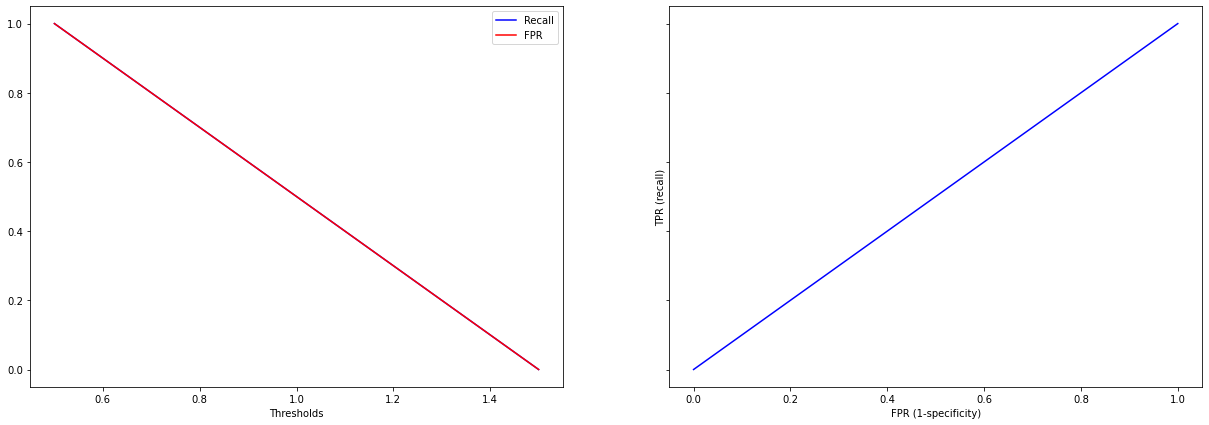

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


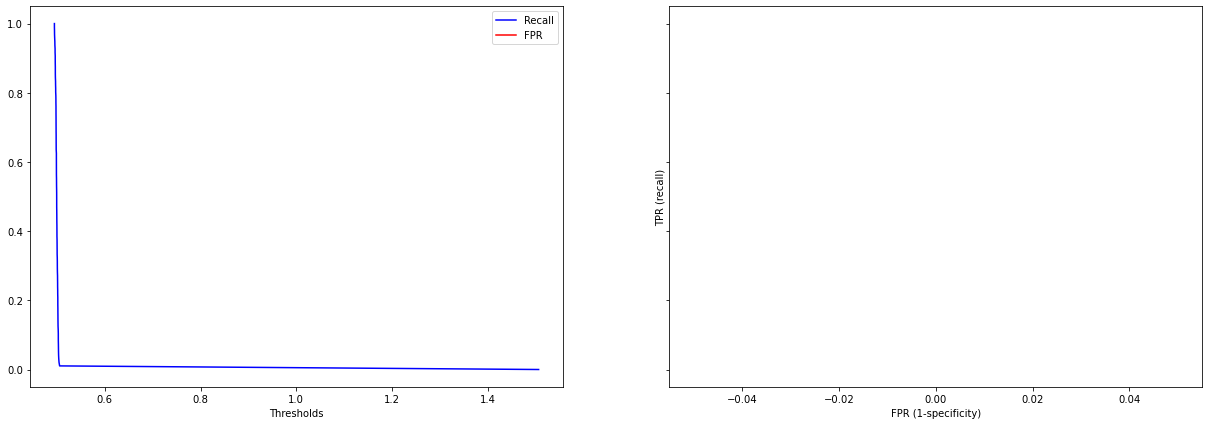

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.579682  0.544653   0.585482     0.614679  0.564294  0.609585
Validation  0.567444  0.530960   0.575512     0.604167  0.551898  0.599701

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005533  0.008649   0.006319     0.010469  0.006036  0.006524
Validation  0.033713  0.039693   0.036840     0.045802  0.035003  0.031812

Random Forest (100 estimators)
╠■■■■■■■■■╣


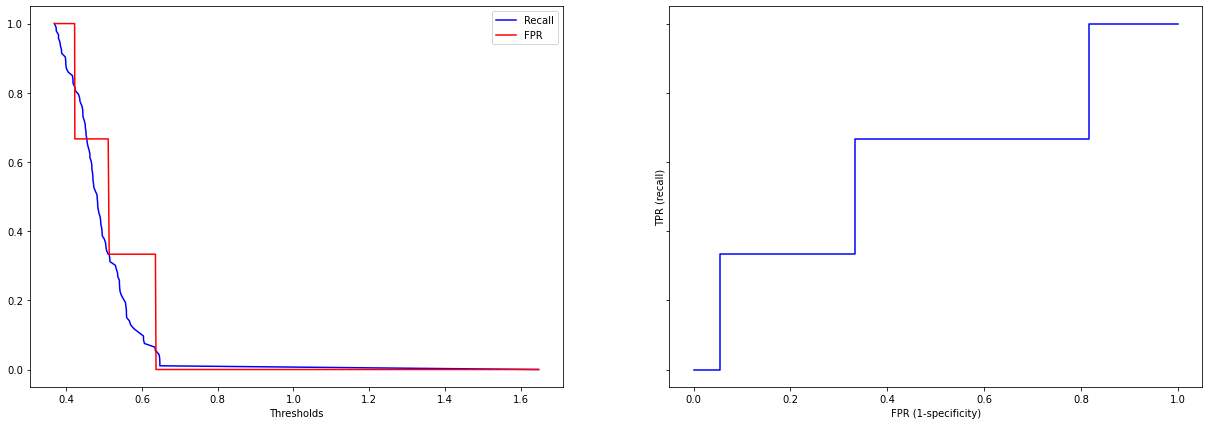

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.614272  0.560490   0.627833     0.668005  0.591992  0.666308
Validation  0.571554  0.531024   0.581855     0.612500  0.553982  0.612389

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007356  0.024790   0.006891     0.016743  0.014513  0.008047
Validation  0.042319  0.055042   0.048834     0.074600  0.044509  0.044602

XGBoost Classifier
╠■■■■■■■■■╣


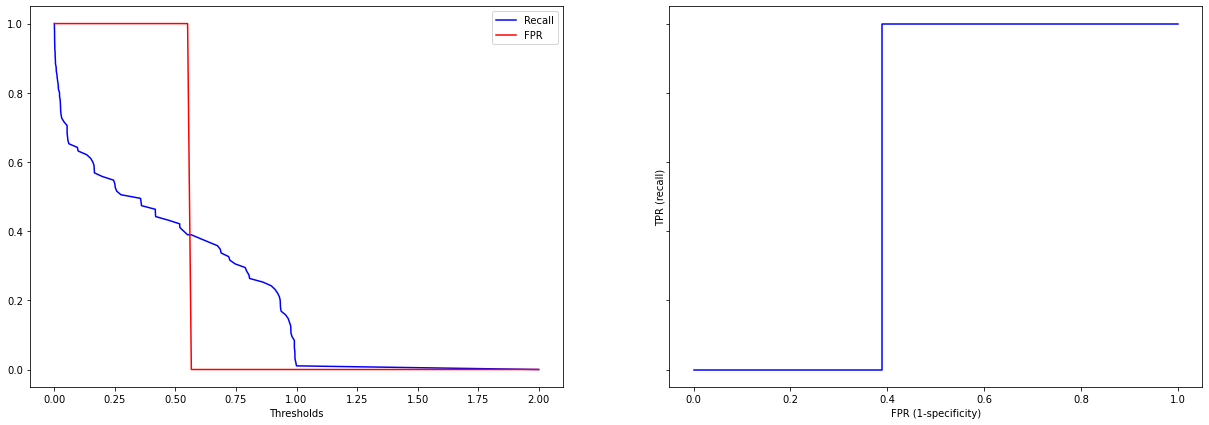

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.997935  0.997474   0.998392     0.998394  0.997932  0.999985
Validation  0.540973  0.524893   0.544664     0.557292  0.533783  0.573511

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001511  0.002347   0.001234     0.001233  0.001515  0.000022
Validation  0.039190  0.056020   0.041909     0.054515  0.044971  0.056468

SVM
╠■■■■■■■■■╣


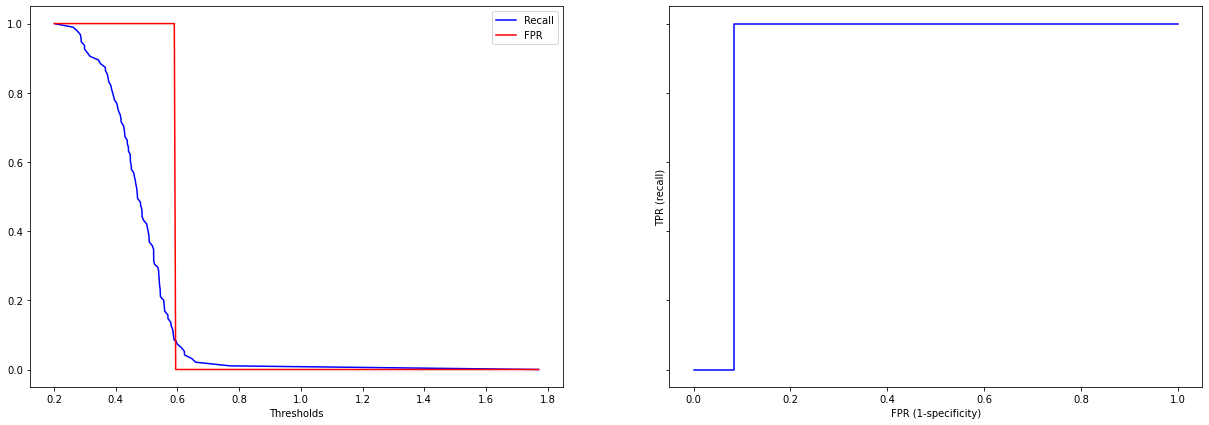

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.591613  0.541670   0.601649     0.641514  0.569990  0.636003
Validation  0.592328  0.539261   0.605438     0.645833  0.570143  0.629448

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010604  0.014733    0.01257     0.017511  0.011558  0.008044
Validation  0.036674  0.045564    0.03932     0.039284  0.041335  0.036750

KNN
╠■■■■■■■■■╣


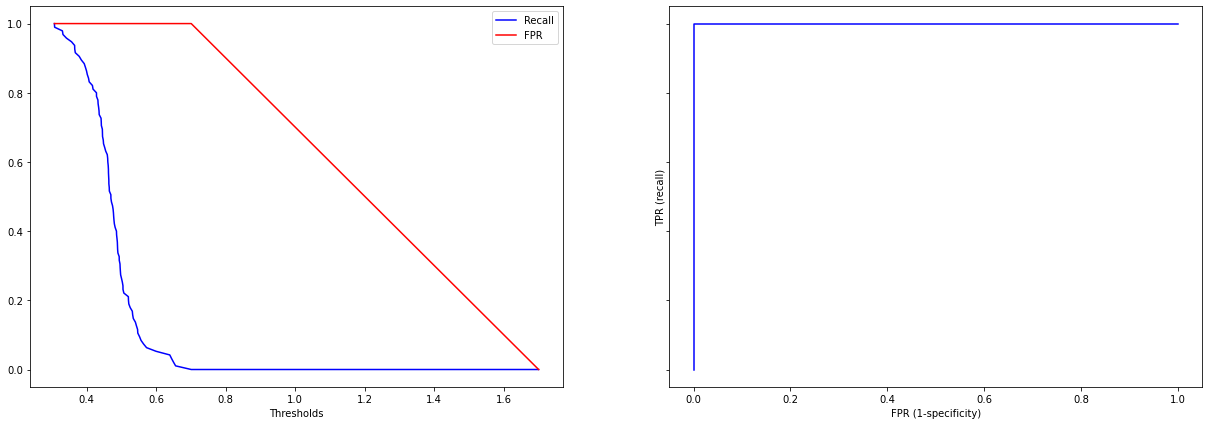

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.998738  0.997475   1.000000     1.000000  0.998735  0.999995
Validation  0.573187  0.480477   0.592294     0.666667  0.530015  0.596463

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000889  0.001778   0.000000     0.000000  0.000891  0.000005
Validation  0.040244  0.052644   0.048543     0.045272  0.048516  0.048042

Logistic Regression
╠■■■■■■■■■╣


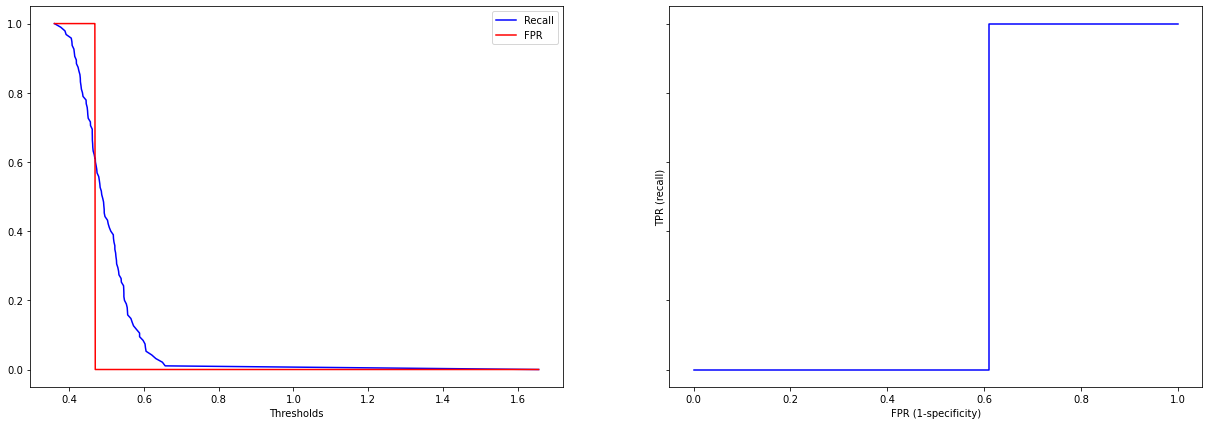

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.595056  0.556818   0.602750     0.633257  0.578854  0.639794
Validation  0.582489  0.552771   0.589284     0.612500  0.569565  0.627547

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005643  0.004122   0.007109     0.010701  0.004321  0.003447
Validation  0.027000  0.057682   0.024360     0.032125  0.039318  0.029304

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.567444  0.530960   0.575512     0.604167   
Random Forest (100 estimators)  0.571554  0.531024   0.581855     0.612500   
XGBoost Classifier              0.540973  0.524893   0.544664     0.557292   
SVM                             0.592328  0.539261   0.605438     0.645833   
KNN                             0.573187  0.480477   0.592294     0.666667   
Logistic Regression             0.582489  0.552771   0.589284     0.612500   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.551898  0.599701  
Random Forest (100 estimators)  0.553982  0.612389  
XGBoost Classifier              0.533783  0.573511  
SVM                             0.570143  0.629448  
KNN                             0.530015  0.596463  
Logistic Regression             0.569565  0.627547

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                   0.5461216616848276-0.5887660757935836   
Random Forest (100 estimators)   0.544788925964676-0.5983188028781564   
XGBoost Classifier              0.5161870690258917-0.5657591744974243   
SVM                             0.5691332397498624-0.6155224165541101   
KNN                             0.5477337750728528-0.5986392819219659   
Logistic Regression             0.5654125922410276-0.5995647393651904   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.5058558153634793-0.556064287729304   
Random Forest (100 estimators)  0.49621284364268536-0.5658361254294797   
XGBoost Classifier               0.4894623968976527-0.5603228264700449   
SVM                              0.5104440238130393-0.5680783129567201   
KNN                               0.4471819953927078-0.513771612854715   
Logistic Regression              0.5162892032512743-0.5892520338621277   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5522129735119181-0.5988119788420783   
Random Forest (100 estimators)  0.5509696267239151-0.6127407919181261   
XGBoost Classifier              0.5181586015944132-0.5711698337399814   
SVM                             0.5805699783532253-0.6303061093290906   
KNN                             0.5615927431573495-0.6229953787794684   
Logistic Regression             0.5738770682656532-0.6046899407814118   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5751990922019248-0.6331342411314087   
Random Forest (100 estimators)   0.565318645134825-0.6596813548651751   
XGBoost Classifier              0.5228133567019266-0.5917699766314066   
SVM                              0.6209881335833357-0.670678533083331   
KNN                              0.6380339887109885-0.695299344622345   
Logistic Regression             0.5921823071689892-0.6328176928310109   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.5297603660151476-0.5740365636863928   
Random Forest (100 estimators)   0.5258320049106348-0.5821314914006172   
XGBoost Classifier               0.5053408535579742-0.5622250510738649   
SVM                              0.5440006712475922-0.5962853910268149   
KNN                             0.49933076528960446-0.5606993375295588   
Logistic Regression               0.544697976413974-0.5944313585321496   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5795814663942744-0.6198205149201585  
Random Forest (100 estimators)  0.5841805855787052-0.6405981497448916  
XGBoost Classifier               0.537797571522612-0.6092239687838026  
SVM                             0.6062051677277112-0.6526903881858055  
KNN                              0.566078907471882-0.6268480058299507  
Logistic Regression             0.6090137202108944-0.6460805130365282

In [24]:
run_models(n_vitals, y[n_vitals.index], models, ratio_negatives_to_positives=1)

<b>Temperature</b>, <b>pulse</b> and <b>rr</b> are still the best features. <b>SVM</b> and <b>Logistic regression</b> improve significantly with standardized features.

Dummy Random
╠■■■■■■■■■╣


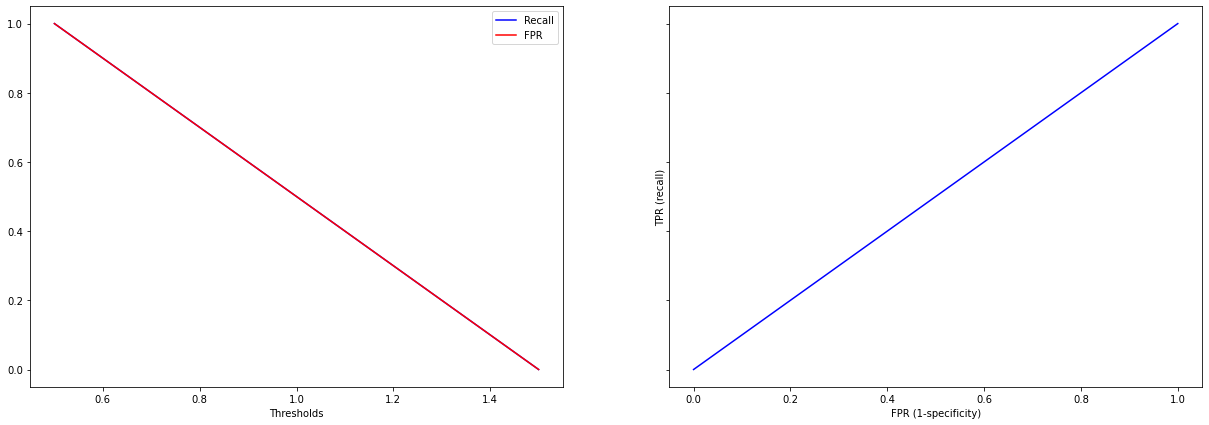

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


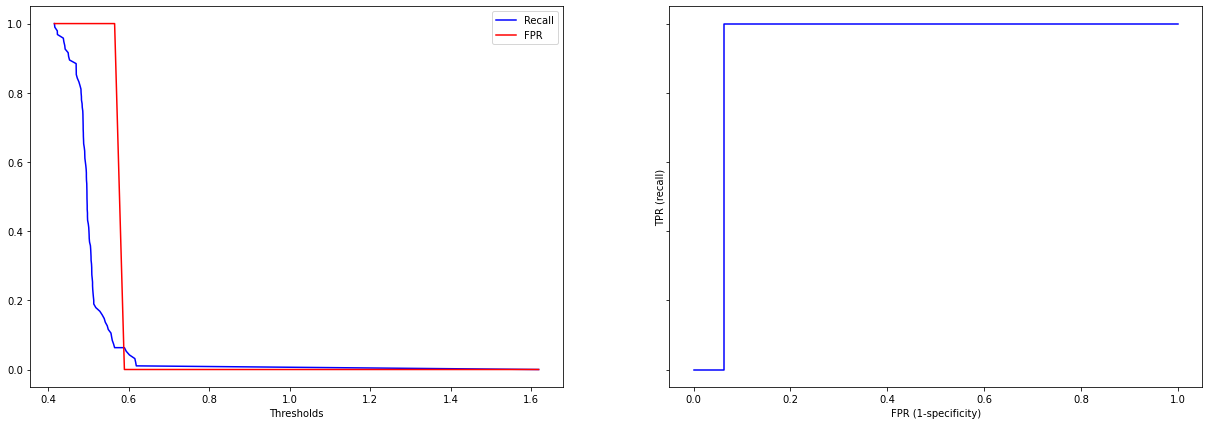

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.560004  0.516984   0.565777     0.602982  0.539692  0.588106
Validation  0.560670  0.517579   0.569346     0.604167  0.541001  0.582736

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008505  0.031509   0.010903     0.034250  0.016597  0.008131
Validation  0.024976  0.050303   0.030264     0.052429  0.034673  0.035290

Random Forest (100 estimators)
╠■■■■■■■■■╣


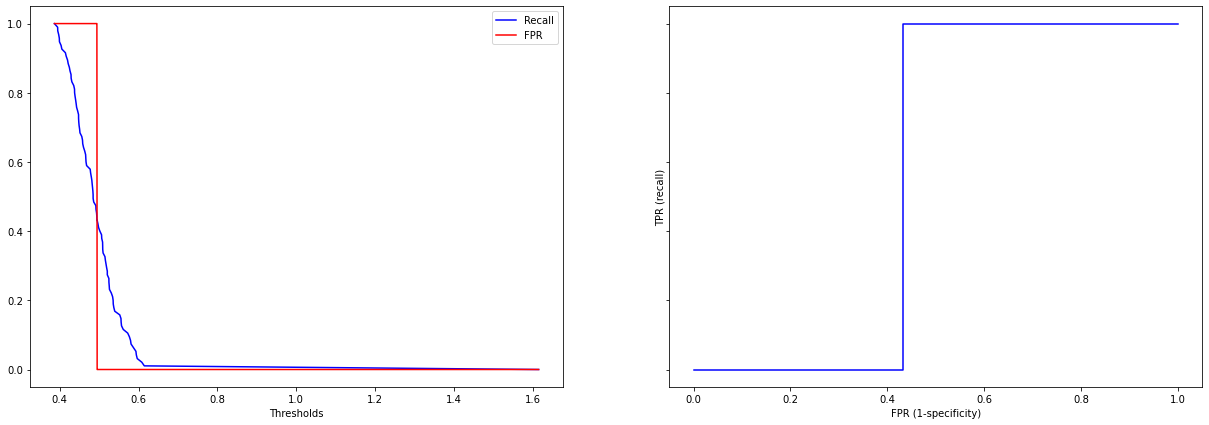

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.621960  0.596990   0.628226     0.646904  0.612071  0.676009
Validation  0.586634  0.569201   0.591282     0.604167  0.578986  0.636884

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.005424  0.017081   0.006411     0.014947  0.008918  0.00618
Validation  0.047478  0.072653   0.047171     0.055338  0.056933  0.04493

XGBoost Classifier
╠■■■■■■■■■╣


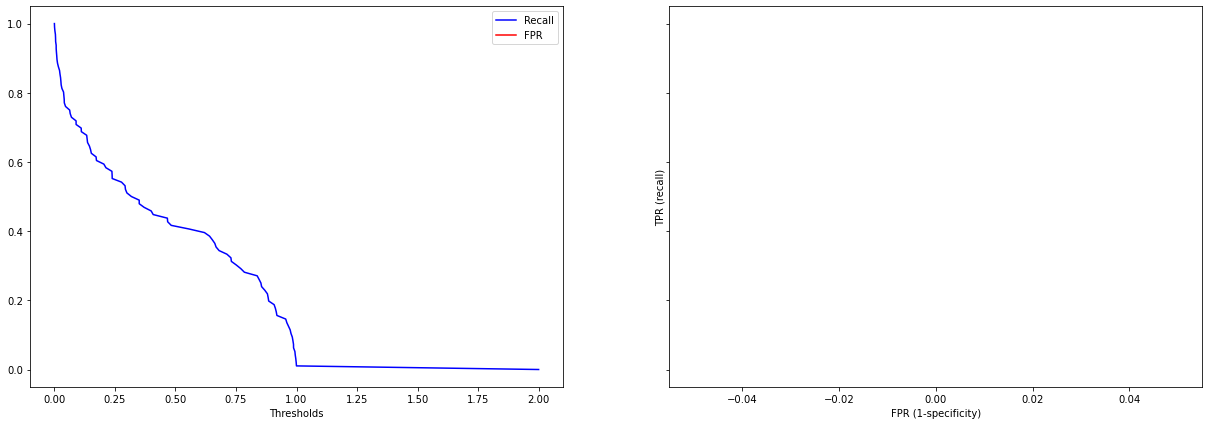

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999656  0.999885   0.999427     0.999427  0.999656  1.000000
Validation  0.564864  0.547637   0.569397     0.582292  0.557837  0.592394

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000296  0.000363   0.000604     0.000604  0.000296  3.398888e-07
Validation  0.038847  0.050114   0.040794     0.046182  0.042516  4.342991e-02

SVM
╠■■■■■■■■■╣


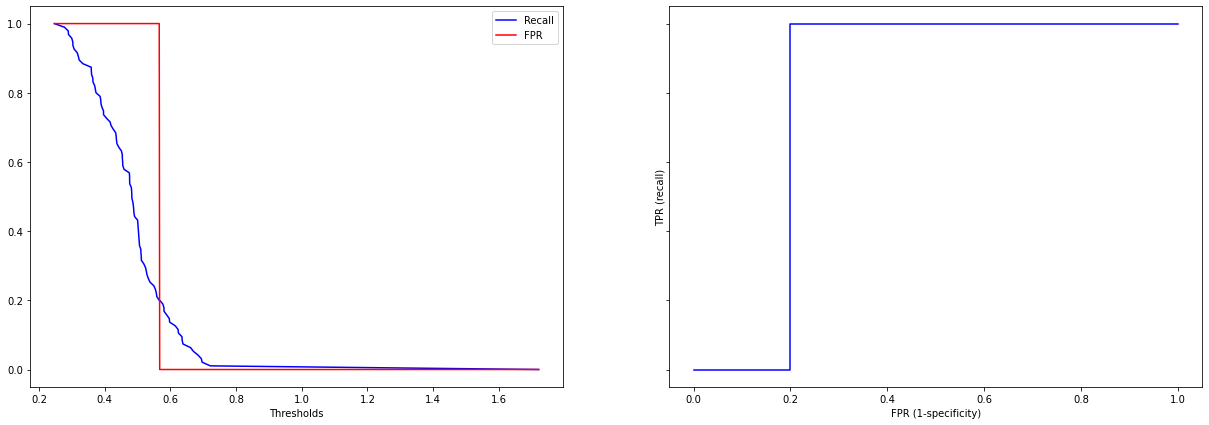

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.601595  0.554982   0.611740     0.648165  0.581951  0.648174
Validation  0.597536  0.556894   0.607992     0.638542  0.580631  0.635373

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009489  0.014403   0.009717     0.008195  0.011856  0.008779
Validation  0.029389  0.052777   0.029469     0.034038  0.039167  0.027040

KNN
╠■■■■■■■■■╣


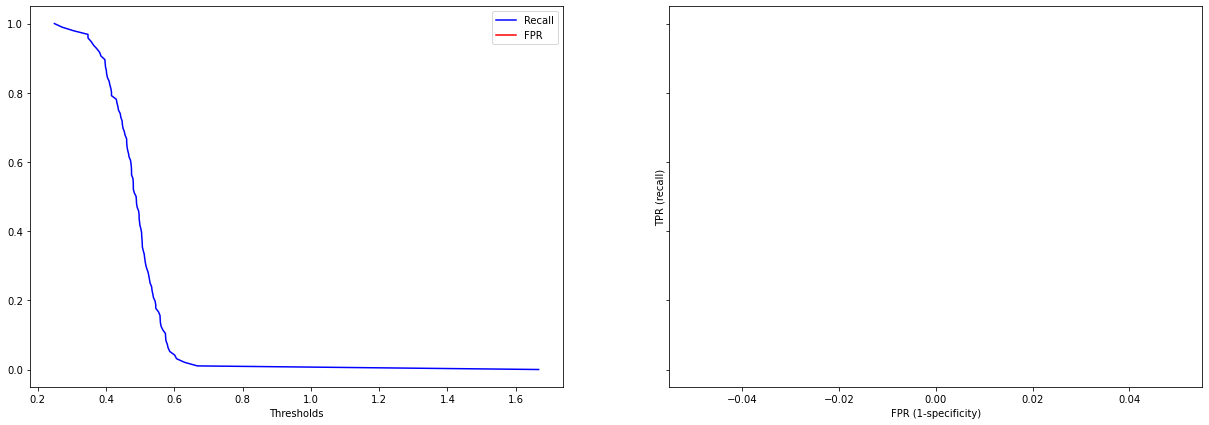

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999598  0.999197   1.000000     1.000000  0.999598  0.999999
Validation  0.594956  0.556884   0.605203     0.633333  0.577627  0.617630

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000472  0.000945   0.000000     0.000000  0.000473  0.000001
Validation  0.030216  0.077764   0.032805     0.059698  0.050455  0.028677

Logistic Regression
╠■■■■■■■■■╣


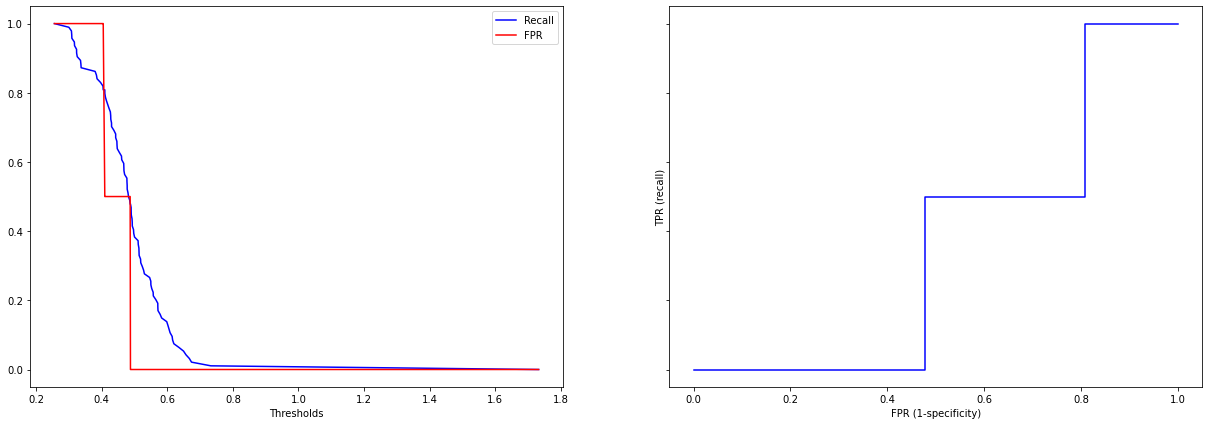

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.603889  0.571511   0.610922     0.636239  0.590534  0.652239
Validation  0.594962  0.555842   0.606981     0.634375  0.579399  0.638512

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007099  0.005943   0.008692     0.012194  0.006083  0.010251
Validation  0.039182  0.043732   0.045531     0.063353  0.037709  0.048329

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.560670  0.517579   0.569346     0.604167   
Random Forest (100 estimators)  0.586634  0.569201   0.591282     0.604167   
XGBoost Classifier              0.564864  0.547637   0.569397     0.582292   
SVM                             0.597536  0.556894   0.607992     0.638542   
KNN                             0.594956  0.556884   0.605203     0.633333   
Logistic Regression             0.594962  0.555842   0.606981     0.634375   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.541001  0.582736  
Random Forest (100 estimators)  0.578986  0.636884  
XGBoost Classifier              0.557837  0.592394  
SVM                             0.580631  0.635373  
KNN                             0.577627  0.617630  
Logistic Regression             0.579399  0.638512

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                   0.5448742812706874-0.5764663923044421   
Random Forest (100 estimators)  0.5566062191930177-0.6166612678536143   
XGBoost Classifier              0.5402949380742912-0.5894330412003201   
SVM                             0.5789487736241808-0.6161235493464584   
KNN                             0.5758458029329387-0.6140667618339006   
Logistic Regression             0.5701810227182711-0.6197423365217982   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4857648675778401-0.5493940671300637   
Random Forest (100 estimators)  0.5232513206884922-0.6151507411671778   
XGBoost Classifier               0.515942699948534-0.5793322141408132   
SVM                             0.5235150683424863-0.5902735914513282   
KNN                              0.5077012319713191-0.606065950159265   
Logistic Regression             0.5281836749341766-0.5835001738630743   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5502048839611993-0.5884862782883817   
Random Forest (100 estimators)  0.5614480904854796-0.6211151476313338   
XGBoost Classifier              0.5435966722693208-0.5951975024889762   
SVM                             0.5893542086800215-0.6266296622269726   
KNN                              0.584455379175069-0.6259510472599609   
Logistic Regression             0.5781845418014622-0.6357776395060077   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.5710073989269074-0.6373259344064258   
Random Forest (100 estimators)  0.5691677689767941-0.6391655643565394   
XGBoost Classifier               0.553083693271093-0.6114996400622403   
SVM                             0.6170138888888889-0.6600694444444445   
KNN                             0.5955770077248105-0.6710896589418559   
Logistic Regression             0.5943073007312454-0.6744426992687547   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5190717038708026-0.5629305306528585   
Random Forest (100 estimators)  0.5429789358989627-0.6149936864385193   
XGBoost Classifier              0.5309480448575123-0.5847269114802289   
SVM                             0.5558593409371285-0.6054025105597581   
KNN                             0.5457166530738745-0.6095381438528323   
Logistic Regression             0.5555495411147034-0.6032477307142955   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5604163458928169-0.6050556257566675  
Random Forest (100 estimators)  0.6084677192898026-0.6652997760567038  
XGBoost Classifier              0.5649265120330311-0.6198614855328339  
SVM                             0.6182719482463045-0.6524750269827907  
KNN                             0.5994933783372305-0.6357673515453584  
Logistic Regression             0.6079460924137681-0.6690784010713406

In [25]:
n_vitals_ex = pd.merge(n_vitals, e_factors, left_index=True, right_index=True)
run_models(n_vitals_ex, y[n_vitals_ex.index], models, ratio_negatives_to_positives=1)

For almost all models, the vitals had more importance than all of the epidemiological factors, of which <b>high_risk_exposure_occupation</b> seems to be the most influential again. For tree-based models (<b>Random forest</b> and <b>XGBoost</b>) however, <b>age</b> played a significant role. Since all of the important vitals follow a normal distribution, <b>standardization</b> will be used for them.

### Assesed Symptoms

In [26]:
a_symptoms.dropna(how="all", inplace=True)
a_symptoms_ef = pd.merge(a_symptoms, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


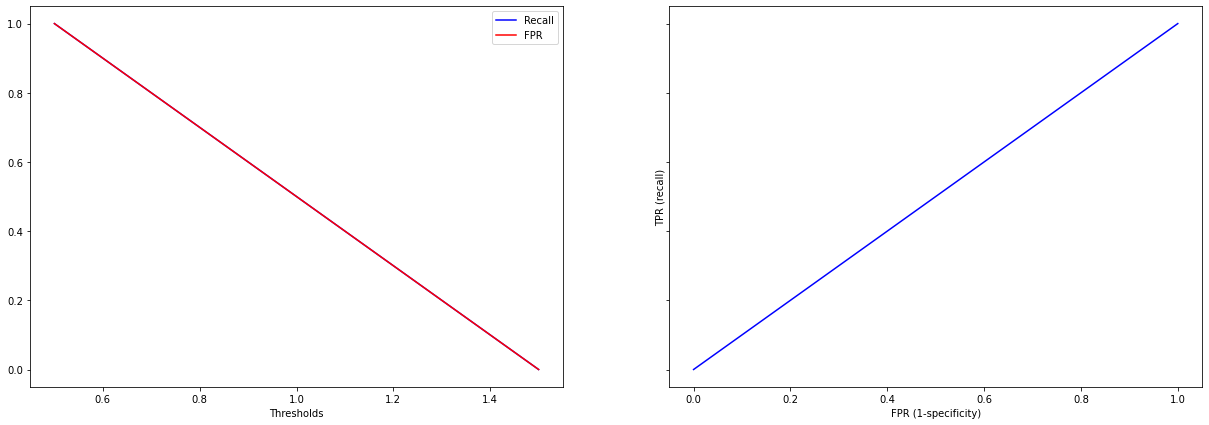

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500079     0.0        0.0          1.0  0.0      0.5
Validation  0.499289     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000127     0.0        0.0          0.0  0.0      0.0
Validation  0.001145     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


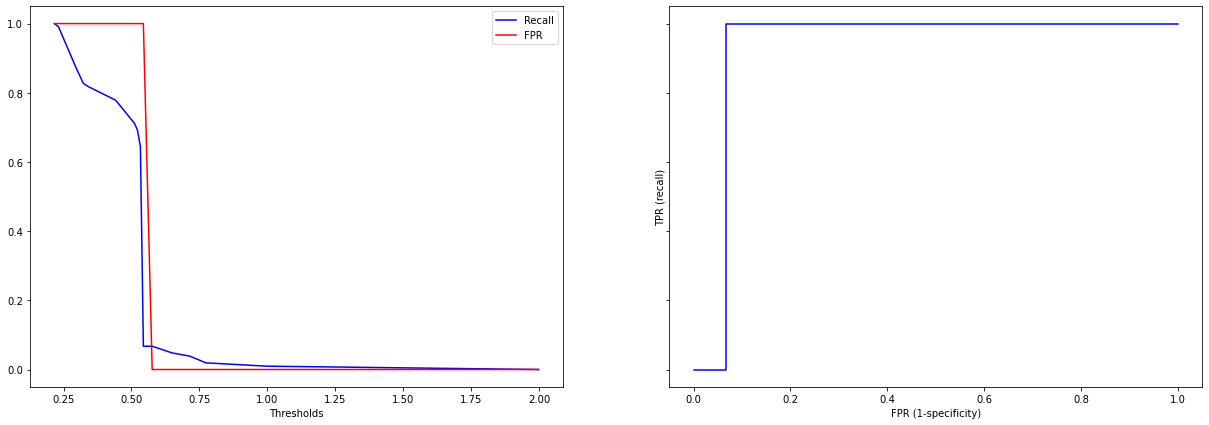

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.542173  0.852168   0.526024     0.232278  0.650495  0.550318
Validation  0.552995  0.851779   0.533621     0.253333  0.655985  0.563203

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008788  0.004598   0.005650     0.015171  0.005213  0.010636
Validation  0.030546  0.042139   0.019898     0.042402  0.025355  0.035832

Random Forest (100 estimators)
╠■■■■■■■■■╣


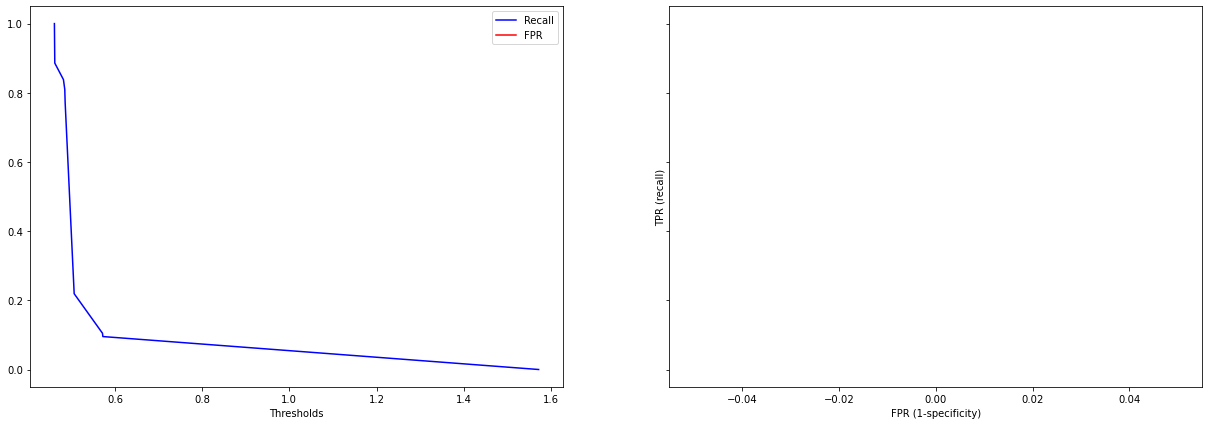

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.589070  0.389999   0.647972      0.78808  0.486854  0.614677
Validation  0.585394  0.395193   0.636125      0.77619  0.486538  0.609698

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004414  0.008599   0.008635     0.009801  0.006954  0.005935
Validation  0.040918  0.065326   0.062334     0.029182  0.066291  0.032485

XGBoost Classifier
╠■■■■■■■■■╣


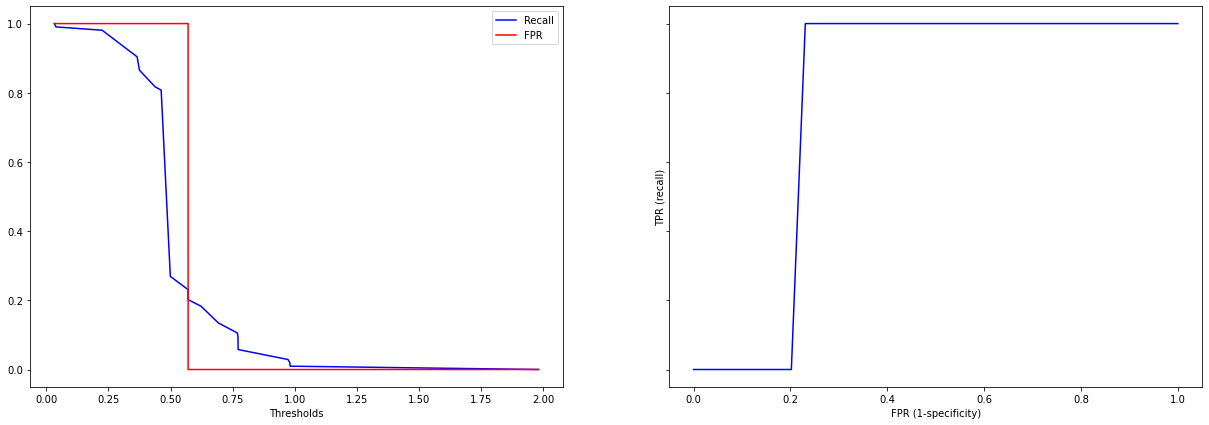

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.605793  0.403189   0.678211     0.808333  0.505558  0.642285
Validation  0.588734  0.386649   0.647776     0.791429  0.483046  0.604813

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008996  0.011498   0.018855     0.017777  0.010434  0.011837
Validation  0.037740  0.063378   0.053611     0.029594  0.062787  0.035658

SVM
╠■■■■■■■■■╣


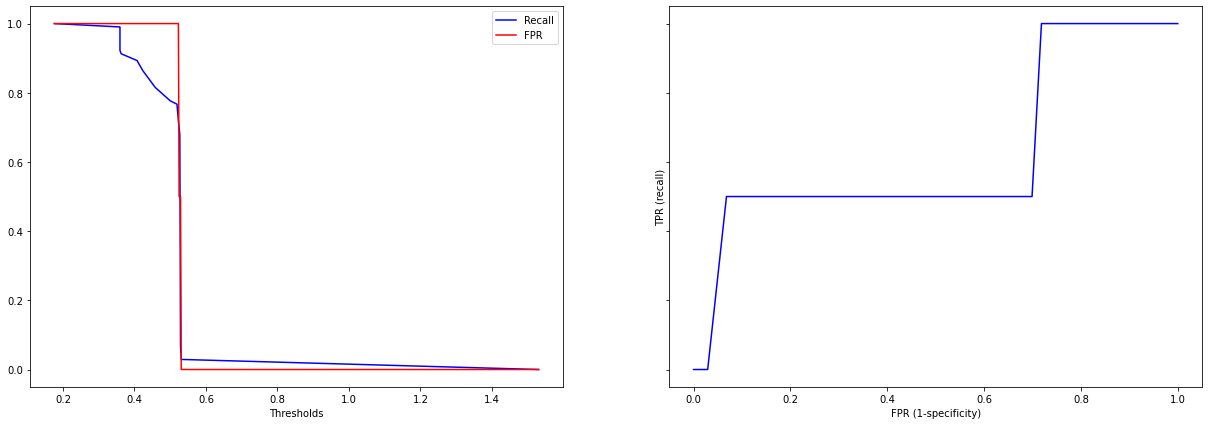

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.538114  0.782129   0.573060     0.294198  0.589643  0.543950
Validation  0.521580  0.769874   0.463575     0.272381  0.578594  0.517298

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.015545  0.274892   0.150111     0.249335  0.206496  0.011112
Validation  0.031869  0.272149   0.164023     0.259356  0.204477  0.039363

KNN
╠■■■■■■■■■╣


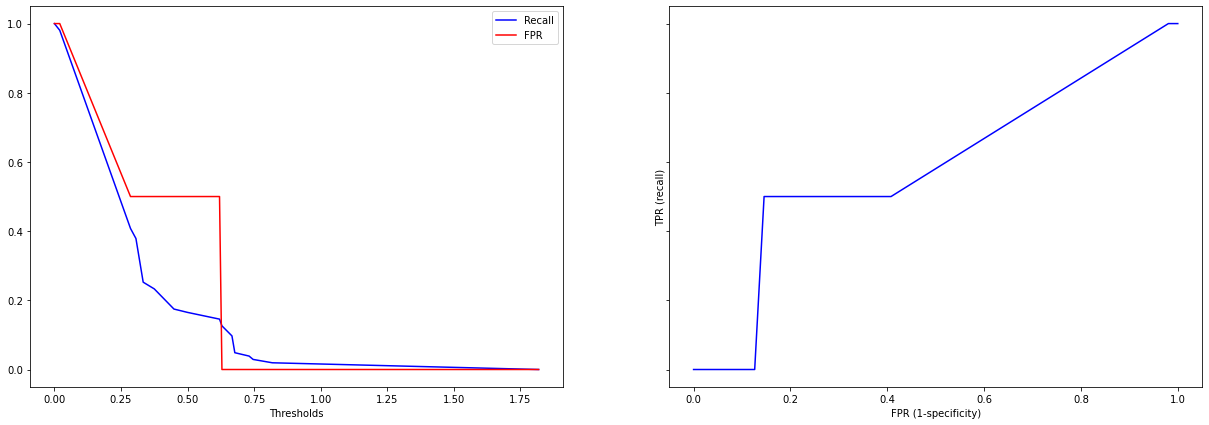

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.607163  0.398332   0.684387     0.815928  0.503275  0.600530
Validation  0.583965  0.382902   0.638836     0.785714  0.477162  0.567304

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004723  0.015795   0.013649     0.016835  0.010682  0.006346
Validation  0.034046  0.067459   0.048627     0.027401  0.064035  0.045886

Logistic Regression
╠■■■■■■■■■╣


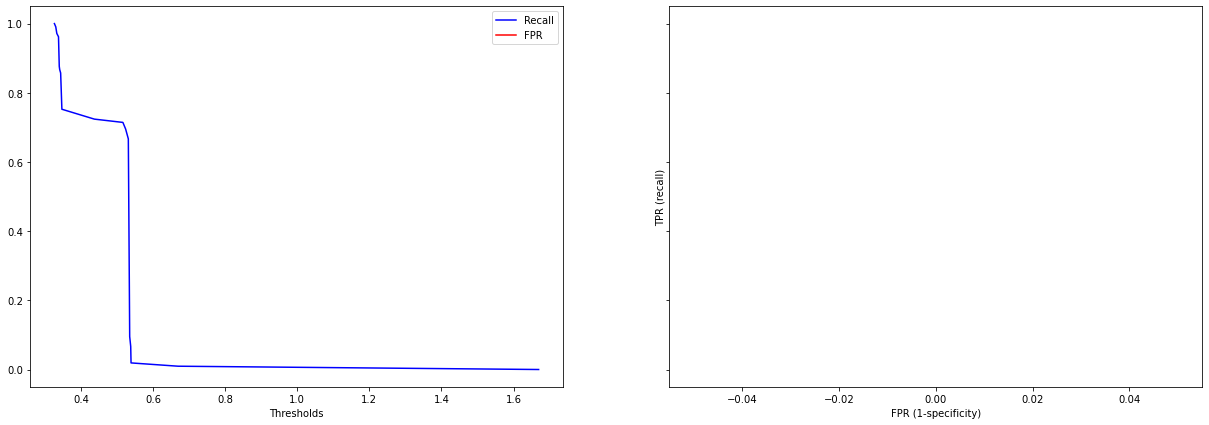

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.545445  0.829375   0.528955     0.261603  0.645904  0.543611
Validation  0.540144  0.826173   0.525840     0.253333  0.642451  0.536228

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004573  0.012861   0.003094     0.015083  0.004428  0.007787
Validation  0.028507  0.045811   0.018697     0.034834  0.026087  0.047491

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499289  0.000000   0.000000     1.000000   
MultinomialNB                   0.552995  0.851779   0.533621     0.253333   
Random Forest (100 estimators)  0.585394  0.395193   0.636125     0.776190   
XGBoost Classifier              0.588734  0.386649   0.647776     0.791429   
SVM                             0.521580  0.769874   0.463575     0.272381   
KNN                             0.583965  0.382902   0.638836     0.785714   
Logistic Regression             0.540144  0.826173   0.525840     0.253333   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.655985  0.563203  
Random Forest (100 estimators)  0.486538  0.609698  
XGBoost Classifier              0.483046  0.604813  
SVM                             0.578594  0.517298  
KNN                             0.477162  0.567304  
Logistic Regression             0.642451  0.536228

Accuracy  \
Dummy Random                    0.4985651539186483-0.5000130451334843   
MultinomialNB                   0.5336757795224571-0.5723138390737963   
Random Forest (100 estimators)  0.5595152223868056-0.6112724102017746   
XGBoost Classifier              0.5648653034011576-0.6126025368154974   
SVM                              0.5014242125515892-0.541735345110338   
KNN                             0.5624326095756069-0.6054978801558304   
Logistic Regression             0.5221152592748849-0.5581736145684913   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.8251278417825892-0.8784301096998904   
Random Forest (100 estimators)   0.3538776691144433-0.4365086741020886   
XGBoost Classifier              0.3465647592160486-0.42673263521342136   
SVM                              0.5977523426347584-0.9419960850381972   
KNN                              0.340236979559596-0.42556715341434825   
Logistic Regression              0.7971989233062102-0.8551460901708787   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5210365753015268-0.5462053166359265   
Random Forest (100 estimators)  0.5967019655226812-0.6755487037171833   
XGBoost Classifier              0.6138699576021495-0.6816827005905902   
SVM                              0.3598379757359368-0.567312584560134   
KNN                             0.6080809291467159-0.6695902895634366   
Logistic Regression             0.5140154967858059-0.5376654383728894   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                    0.22651592116578678-0.2801507455008798   
Random Forest (100 estimators)    0.7577340420904778-0.7946469102904744   
XGBoost Classifier                0.7727118692406556-0.8101452736164871   
SVM                             0.10835009415915439-0.43641181060275025   
KNN                               0.7683843249981509-0.8030442464304205   
Logistic Regression               0.2313024107010826-0.2753642559655841   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.6399484929172101-0.6720205515572757   
Random Forest (100 estimators)   0.4446118724592925-0.5284642441353887   
XGBoost Classifier               0.44333615280504746-0.522756255280429   
SVM                             0.44927101712999973-0.7079163498900157   
KNN                              0.4366626791869086-0.5176612709704251   
Logistic Regression              0.6259520406988952-0.6589492313477869   

                                                               ROC_AUC  
Dummy Random                                                   0.5-0.5  
MultinomialNB                    0.5405408603982664-0.5858655059218463  
Random Forest (100 estimators)   0.5891528728896219-0.6302435246631098  
XGBoost Classifier               0.5822609982257534-0.6273650660364294  
SVM                             0.49240279639714724-0.5421934471317108  
KNN                              0.5382834994815759-0.5963250659571782  
Logistic Regression              0.5061923208118111-0.5662643599737105

In [27]:
run_models(a_symptoms, y[a_symptoms.index], models, ratio_negatives_to_positives=1)

The most important features here seem to be <b>wheezes</b>, <b>ctab</b> and <b>labored respiration</b>

Dummy Random
╠■■■■■■■■■╣


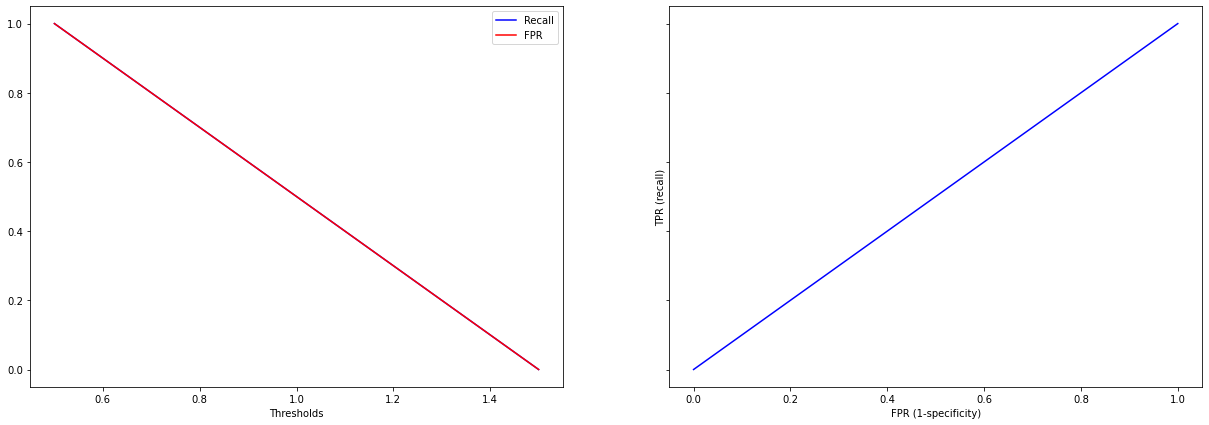

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500079     0.0        0.0          1.0  0.0      0.5
Validation  0.499289     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000127     0.0        0.0          0.0  0.0      0.0
Validation  0.001145     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


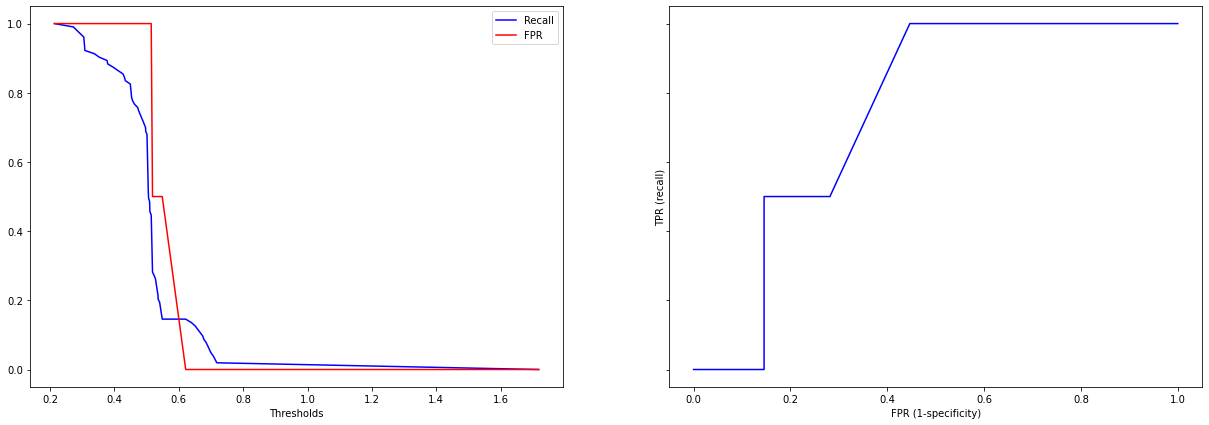

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.553938  0.753917   0.538565     0.354008  0.626121  0.573597
Validation  0.562516  0.749416   0.544190     0.375238  0.627117  0.581997

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006356  0.090182   0.002480     0.079500  0.033529  0.008321
Validation  0.045390  0.132316   0.032663     0.089814  0.068110  0.034904

Random Forest (100 estimators)
╠■■■■■■■■■╣


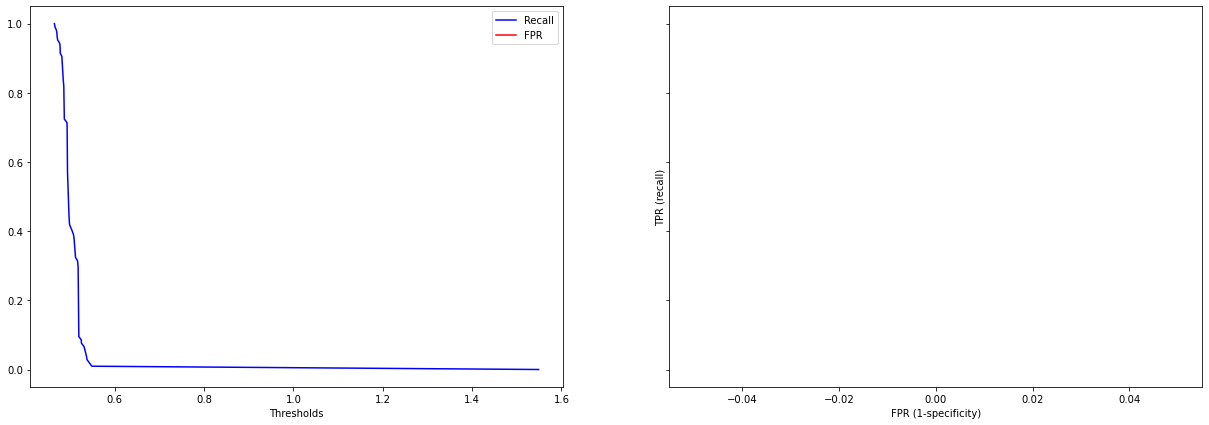

feature_importances


Permutation Importance



Mean metrics


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.601572  0.57044   0.609702     0.632700  0.586741  0.642400
Validation  0.601562  0.56416   0.610752     0.639048  0.583846  0.644167

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007836  0.067724   0.013850     0.059341  0.034672  0.008739
Validation  0.037830  0.086247   0.040604     0.059806  0.056113  0.038254

XGBoost Classifier
╠■■■■■■■■■╣


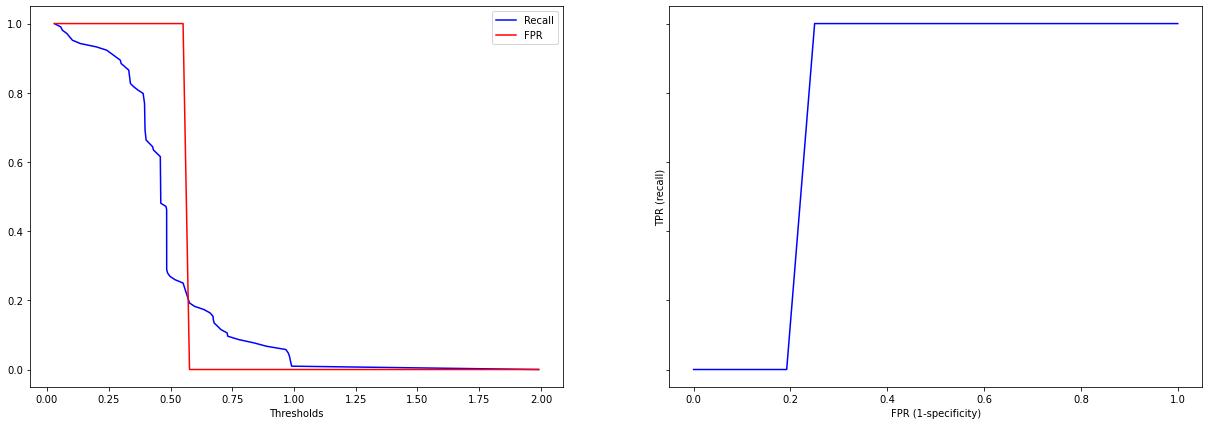

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.650840  0.581491   0.677290     0.720148  0.623309  0.729832
Validation  0.567285  0.502597   0.579367     0.632381  0.535104  0.599882

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007055  0.058901   0.021088     0.050238  0.028688  0.008591
Validation  0.030380  0.077388   0.036596     0.071861  0.051765  0.034530

SVM
╠■■■■■■■■■╣


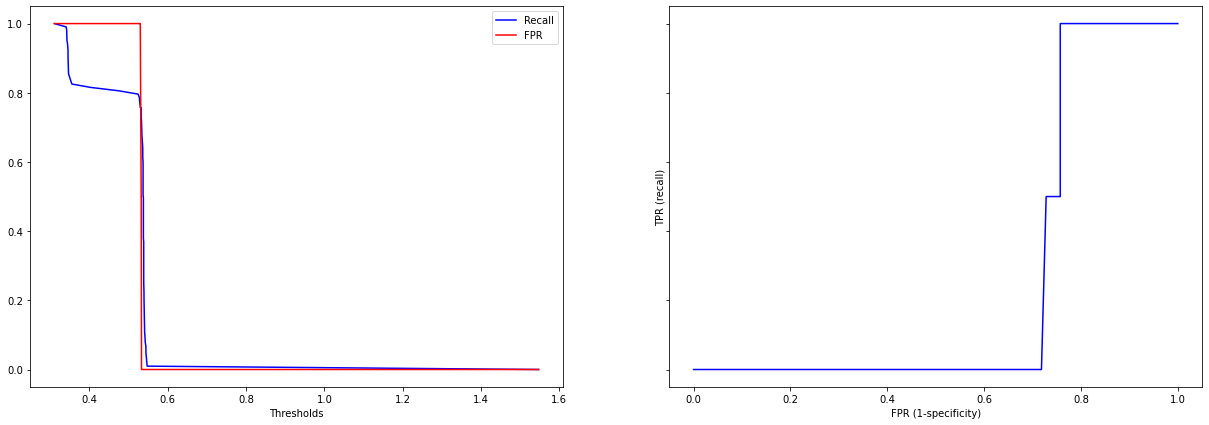

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.556522  0.648898   0.558973     0.464135  0.578188  0.576191
Validation  0.534940  0.617727   0.541305     0.452381  0.549730  0.568900

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005843  0.185224   0.043266     0.180082  0.107182  0.012390
Validation  0.035734  0.200094   0.045818     0.196069  0.137314  0.037829

KNN
╠■■■■■■■■■╣


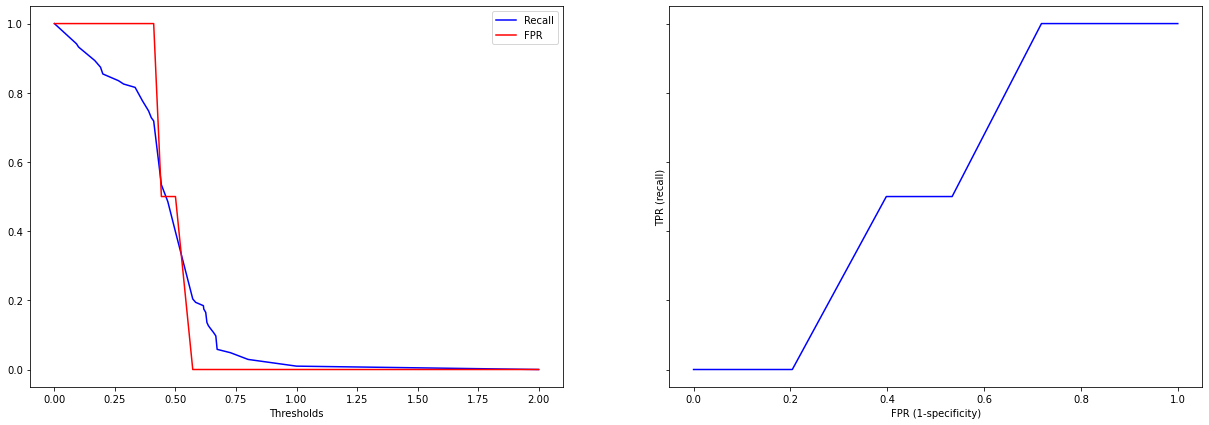

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.648890  0.462805   0.737656     0.834916  0.568211  0.698232
Validation  0.583943  0.392390   0.639726     0.776190  0.482709  0.587502

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007016  0.025661   0.014162     0.019060  0.017192  0.009734
Validation  0.020839  0.066462   0.032298     0.051238  0.053807  0.022909

Logistic Regression
╠■■■■■■■■■╣


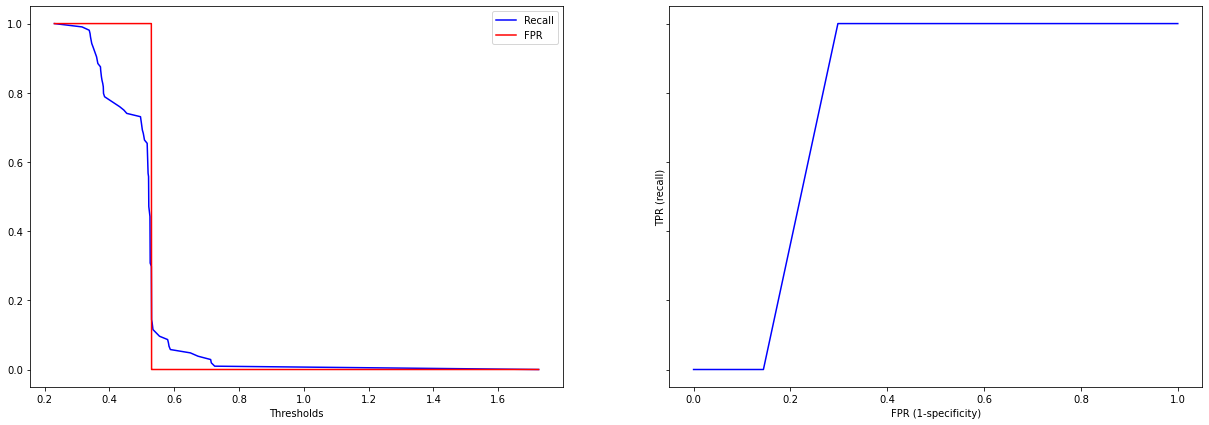

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.570290  0.716157   0.554591     0.424473  0.624185  0.591862
Validation  0.557793  0.705606   0.545162     0.409524  0.614374  0.575002

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010540  0.054661   0.008992     0.051247  0.020971  0.012788
Validation  0.036449  0.061980   0.028127     0.057319  0.037071  0.039936

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499289  0.000000   0.000000     1.000000   
MultinomialNB                   0.562516  0.749416   0.544190     0.375238   
Random Forest (100 estimators)  0.601562  0.564160   0.610752     0.639048   
XGBoost Classifier              0.567285  0.502597   0.579367     0.632381   
SVM                             0.534940  0.617727   0.541305     0.452381   
KNN                             0.583943  0.392390   0.639726     0.776190   
Logistic Regression             0.557793  0.705606   0.545162     0.409524   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.627117  0.581997  
Random Forest (100 estimators)  0.583846  0.644167  
XGBoost Classifier              0.535104  0.599882  
SVM                             0.549730  0.568900  
KNN                             0.482709  0.587502  
Logistic Regression             0.614374  0.575002

Accuracy  \
Dummy Random                    0.4985651539186483-0.5000130451334843   
MultinomialNB                   0.5338090369241453-0.5912236870659247   
Random Forest (100 estimators)   0.5776357552226344-0.625487693208871   
XGBoost Classifier              0.5480711844934719-0.5864988899818159   
SVM                             0.5123401264167735-0.5575402617574534   
KNN                             0.5707632330161744-0.5971221201772355   
Logistic Regression             0.5347404210644512-0.5808452255164559   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.6657318009257036-0.8331001846987347   
Random Forest (100 estimators)   0.5096127139865441-0.6187071422578405   
XGBoost Classifier               0.45365222423857404-0.551540947369692   
SVM                              0.49117613373145985-0.744277594929816   
KNN                             0.35035580742218575-0.4344240667916508   
Logistic Regression              0.6664068126421051-0.7448061253632859   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5235326185521825-0.5648479128512813   
Random Forest (100 estimators)  0.5850715576420544-0.6364320774815613   
XGBoost Classifier              0.5562218823252919-0.6025119375643792   
SVM                             0.5123269435787275-0.5702831666436677   
KNN                             0.6192989288815112-0.6601529332284739   
Logistic Regression             0.5273731043277333-0.5629506716772904   

                                                            Specificity  \
Dummy Random                                                    1.0-1.0   
MultinomialNB                   0.31843487175531415-0.43204131872087626   
Random Forest (100 estimators)    0.6012231847400471-0.6768720533551911   
XGBoost Classifier                0.5869319868744806-0.6778299178874242   
SVM                               0.3283762222636749-0.5763856824982296   
KNN                               0.7437846345265401-0.8085963178544123   
Logistic Regression               0.3732721208289011-0.4457754982187179   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.584040484131418-0.6701931105009142   
Random Forest (100 estimators)   0.5483566570596919-0.6193351531426666   
XGBoost Classifier               0.5023653373968544-0.5678430084562753   
SVM                              0.4628846271693571-0.6365748693032464   
KNN                             0.44867804776551634-0.5167395073328739   
Logistic Regression              0.5909279920492818-0.6378200861978645   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.5599216532460979-0.604071843523679  
Random Forest (100 estimators)  0.6199728092560192-0.6683603101552674  
XGBoost Classifier              0.5780433505283068-0.6217211640825692  
SVM                             0.5449752289320489-0.5928256524267839  
KNN                             0.5730129788179461-0.6019907434256682  
Logistic Regression              0.549743995428601-0.6002599407370603

In [28]:
run_models(a_symptoms_ef, y[a_symptoms_ef.index], models, ratio_negatives_to_positives=1)

Adding the epidemiological factors doesn't seem to make much difference in performance metrics. However, <b>days_since_symptom_onset</b> appears to become more important after adding the factors.

### Reported symptoms

In [29]:
r_symptoms.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46525 entries, 25963 to 90779
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   cough           46516 non-null  object 
 1   cough_severity  5675 non-null   float64
 2   fever           43599 non-null  object 
 3   sob             46446 non-null  object 
 4   sob_severity    46446 non-null  float64
 5   diarrhea        46460 non-null  object 
 6   fatigue         46470 non-null  object 
 7   headache        46465 non-null  object 
 8   loss_of_smell   46458 non-null  object 
 9   loss_of_taste   46458 non-null  object 
 10  runny_nose      46461 non-null  object 
 11  muscle_sore     46465 non-null  object 
 12  sore_throat     46465 non-null  object 
dtypes: float64(2), object(11)
memory usage: 6.0+ MB


In [30]:
#All datasets that contain reported symptoms
r_symptoms.dropna(how="all", inplace=True)
ra_symptoms = pd.merge(r_symptoms, a_symptoms, left_index=True, right_index=True)
r_symptoms_ex = pd.merge(r_symptoms, e_factors, left_index=True, right_index=True)
r_symptoms_vitals = pd.merge(r_symptoms, vitals, left_index=True, right_index=True)
r_symptoms_svitals = pd.merge(r_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals = pd.merge(ra_symptoms, vitals, left_index=True, right_index=True)
ra_symptoms_nvitals = pd.merge(ra_symptoms, n_vitals, left_index=True, right_index=True)
ra_symptoms_svitals = pd.merge(ra_symptoms, s_vitals, left_index=True, right_index=True)
ra_symptoms_vitals_ex = pd.merge(ra_symptoms_vitals, e_factors, left_index=True, right_index=True)
ra_symptoms_nvitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)
ra_symptoms_svitals_ex = pd.merge(ra_symptoms_svitals, e_factors, left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


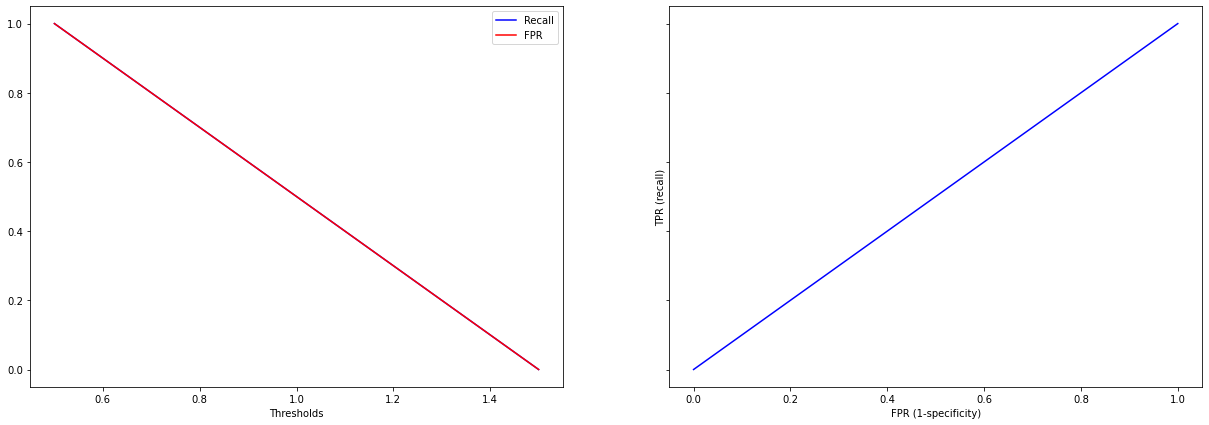

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


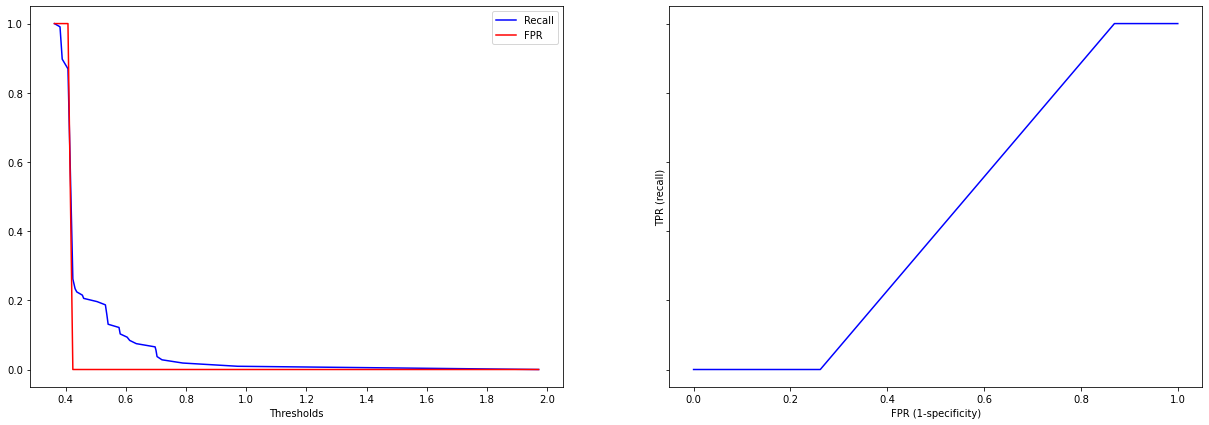

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.648508  0.474691   0.727975     0.822325  0.574470  0.674119
Validation  0.639815  0.475000   0.710034     0.804630  0.567389  0.664005

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007482  0.014672   0.014682     0.014956  0.011103  0.009745
Validation  0.035514  0.059696   0.049299     0.048693  0.050567  0.043876

Random Forest (100 estimators)
╠■■■■■■■■■╣


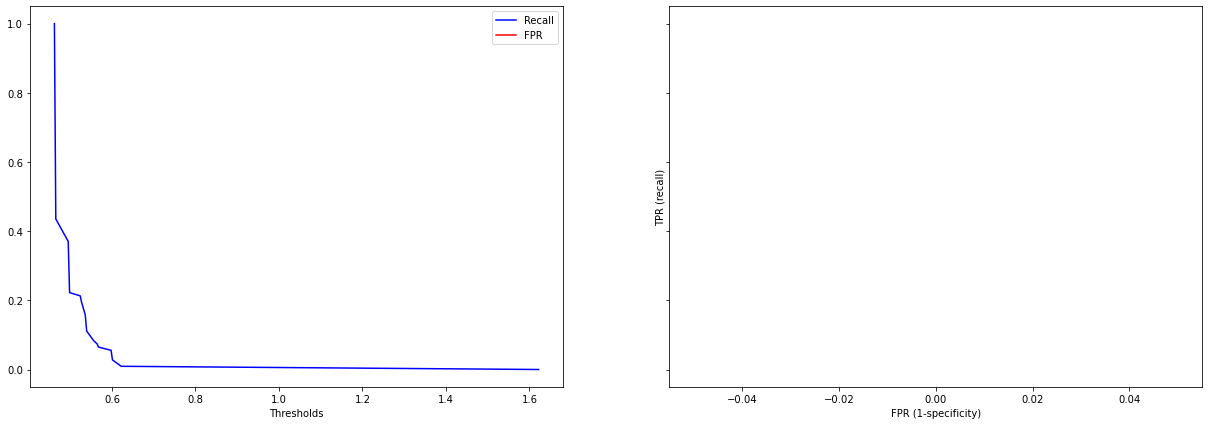

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.640792  0.481893   0.706610     0.799691  0.572944  0.661456
Validation  0.641204  0.482407   0.709726     0.800000  0.572749  0.662170

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007873  0.007115   0.014784     0.013829  0.007781  0.007533
Validation  0.027017  0.046899   0.049367     0.049228  0.035893  0.028909

XGBoost Classifier
╠■■■■■■■■■╣


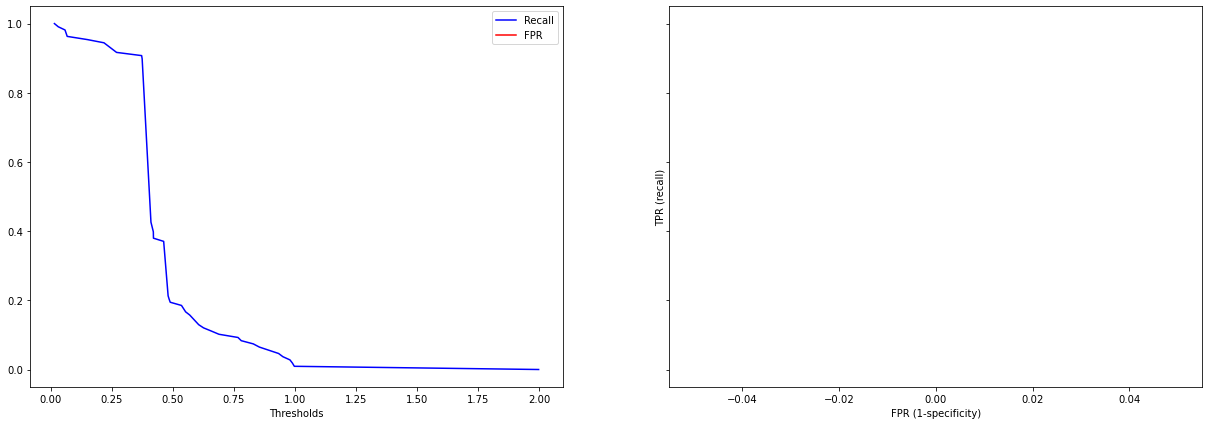

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.709259  0.514095   0.843674     0.904424  0.638690  0.762730
Validation  0.655556  0.467593   0.751929     0.843519  0.575269  0.666465

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004397  0.012384   0.014707     0.012321  0.007585  0.003384
Validation  0.036073  0.047062   0.061498     0.049853  0.046684  0.030724

SVM
╠■■■■■■■■■╣


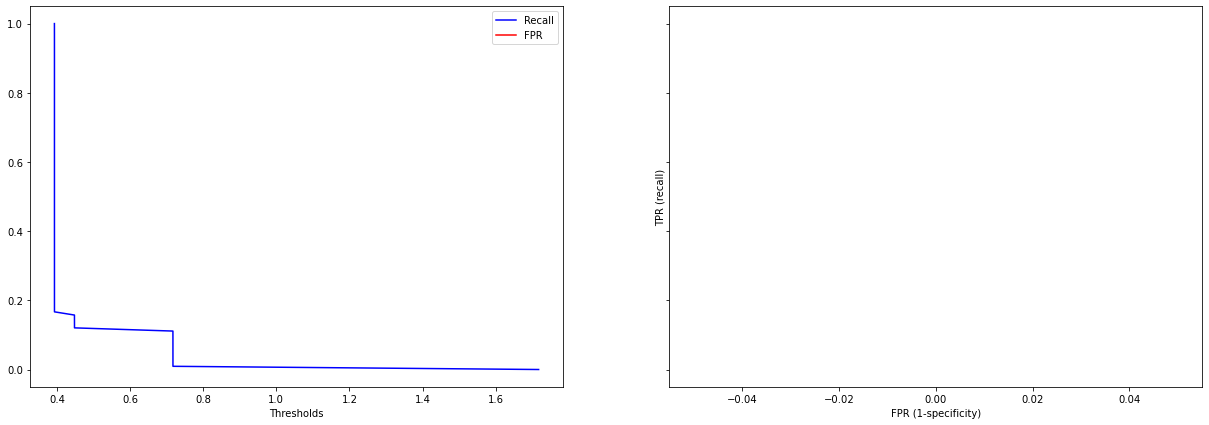

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.658179  0.465844   0.757837     0.850514  0.576274  0.694105
Validation  0.658796  0.459259   0.767140     0.858333  0.571573  0.698165

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007280  0.029332   0.013545     0.019241  0.020262  0.007358
Validation  0.019526  0.062830   0.031749     0.041650  0.044632  0.028893

KNN
╠■■■■■■■■■╣


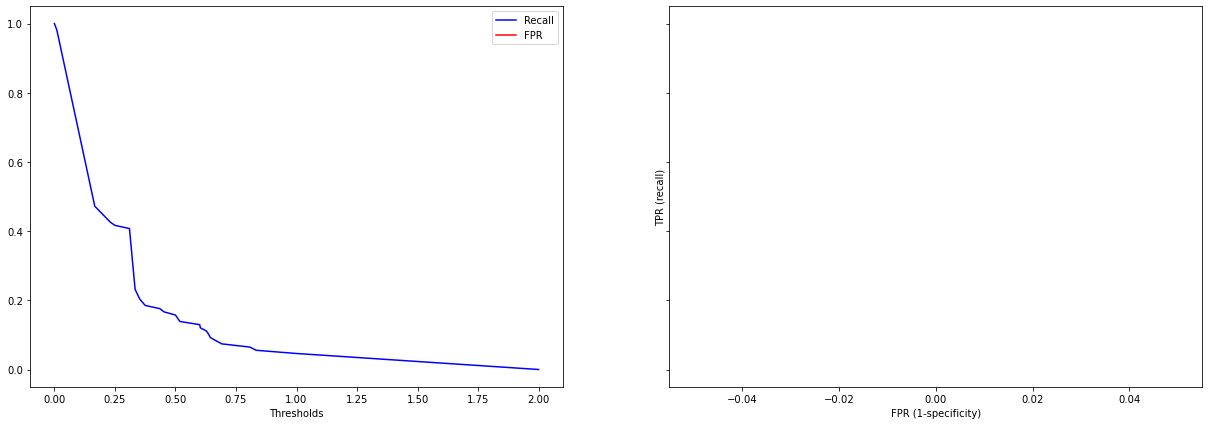

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.710237  0.496091   0.868118     0.924383  0.631230  0.743441
Validation  0.647685  0.437963   0.755346     0.857407  0.553423  0.664682

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003933  0.010148   0.014415     0.010595  0.006494  0.010181
Validation  0.041835  0.053645   0.068466     0.045193  0.056757  0.047450

Logistic Regression
╠■■■■■■■■■╣


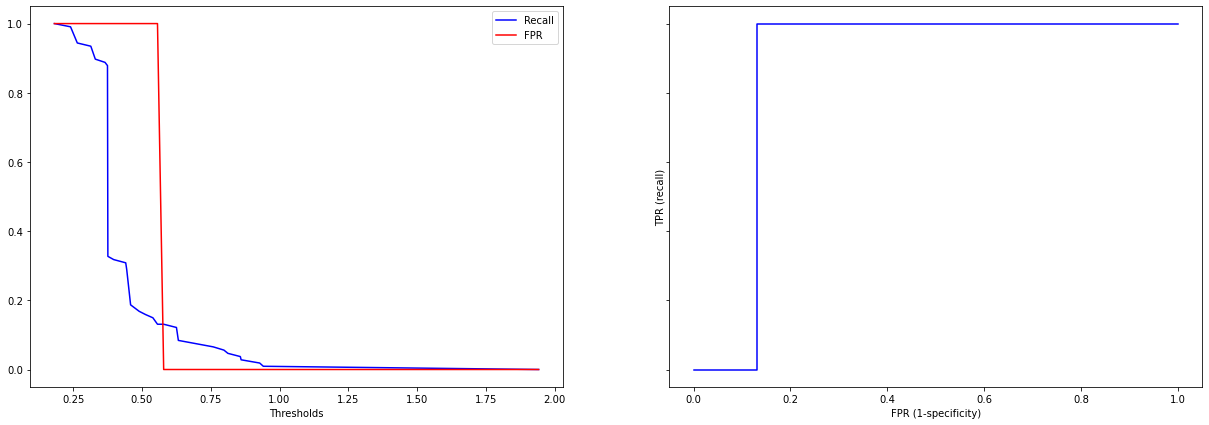

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.668519  0.504527   0.753678     0.832510  0.603187  0.696950
Validation  0.665278  0.499074   0.750428     0.831481  0.597374  0.692468

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008801  0.029593   0.031157     0.043556  0.010154  0.005940
Validation  0.028957  0.055804   0.044925     0.051238  0.041583  0.034698

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.639815  0.475000   0.710034     0.804630   
Random Forest (100 estimators)  0.641204  0.482407   0.709726     0.800000   
XGBoost Classifier              0.655556  0.467593   0.751929     0.843519   
SVM                             0.658796  0.459259   0.767140     0.858333   
KNN                             0.647685  0.437963   0.755346     0.857407   
Logistic Regression             0.665278  0.499074   0.750428     0.831481   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.567389  0.664005  
Random Forest (100 estimators)  0.572749  0.662170  
XGBoost Classifier              0.575269  0.666465  
SVM                             0.571573  0.698165  
KNN                             0.553423  0.664682  
Logistic Regression             0.597374  0.692468

Accuracy  \
Dummy Random                                                  0.5-0.5   
MultinomialNB                   0.6173538204954812-0.6622758091341485   
Random Forest (100 estimators)  0.6241165302028809-0.6582908772045263   
XGBoost Classifier              0.6327410881326219-0.6783700229784893   
SVM                             0.6464467598618874-0.6711458327307053   
KNN                               0.621226447938089-0.674143922432281   
Logistic Regression             0.6469635756800657-0.6835919798754898   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                     0.4372446205348814-0.5127553794651185   
Random Forest (100 estimators)   0.45274564499571857-0.5120691698190961   
XGBoost Classifier                 0.437828238391997-0.4973569467931881   
SVM                             0.41952227916189855-0.49899623935661996   
KNN                             0.40403479979342893-0.47189112613249706   
Logistic Regression                0.463780759607598-0.5343673885405501   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6788542721276166-0.7412134650436776   
Random Forest (100 estimators)  0.6785036467441591-0.7409486306390599   
XGBoost Classifier              0.7130342013514043-0.7908239494203503   
SVM                             0.7470599030904171-0.7872200724132877   
KNN                             0.7120443788966248-0.7986482100058635   
Logistic Regression             0.7220145110471721-0.7788411512645659   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7738334081894656-0.8354258510697936   
Random Forest (100 estimators)  0.7688653821903246-0.8311346178096752   
XGBoost Classifier              0.8119886597799455-0.8750483772570918   
SVM                             0.8319918663045037-0.8846748003621626   
KNN                             0.8288250940671846-0.8859897207476302   
Logistic Regression             0.7990755438310946-0.8638874191318684   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5354077001029908-0.5993699876863655   
Random Forest (100 estimators)  0.5500479577971874-0.5954498975955048   
XGBoost Classifier               0.5457431568028241-0.604794383847624   
SVM                              0.543345228820809-0.5998003777835011   
KNN                             0.5175269785272936-0.5893198777327422   
Logistic Regression             0.5710747523374657-0.6236733784868076   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6362553137056088-0.6917539455536503  
Random Forest (100 estimators)  0.6438860747354693-0.6804537743728984  
XGBoost Classifier              0.6470334394068611-0.6858969446809302  
SVM                             0.6798915501973154-0.7164390396517931  
KNN                              0.634671835233101-0.6946920193622351  
Logistic Regression             0.6705233391245331-0.7144132178027649

In [31]:
run_models(r_symptoms, y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Not surprisingly, <b>cough</b> and <b>cough_severity</b> seem to be the most important ones. Also, almost <b>all of them</b> seem to be <b>relevant</b> for some model, <b>except</b> for <b>diarreah</b> and <b>runny_nose</b>.

Dummy Random
╠■■■■■■■■■╣


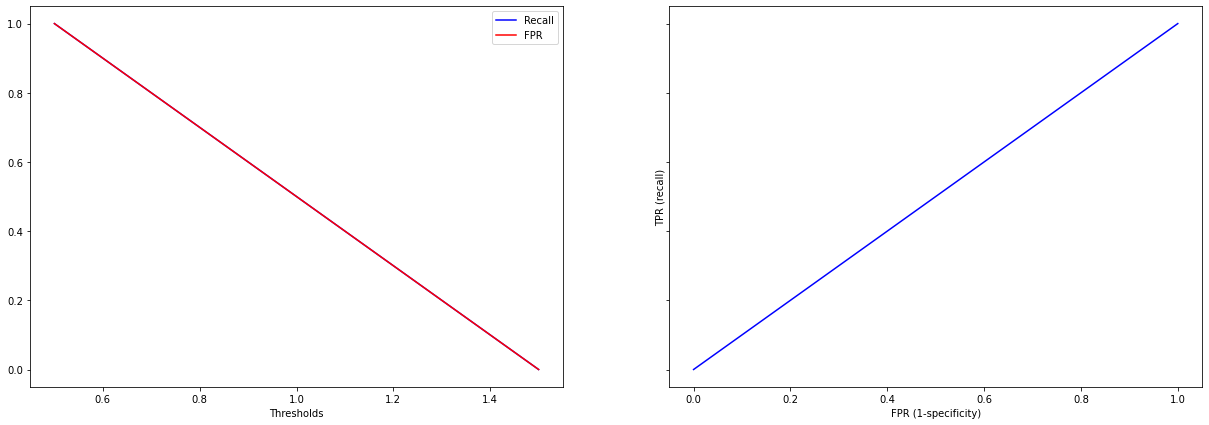

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


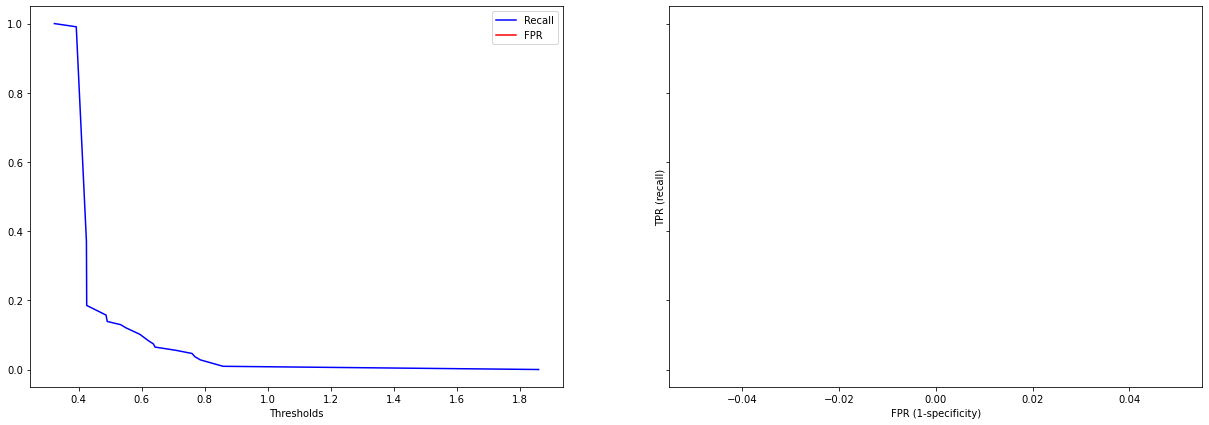

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.622942  0.377366   0.741809     0.868519  0.500179  0.627947
Validation  0.610648  0.373148   0.713608     0.848148  0.487903  0.630444

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006829  0.008847   0.015786     0.010217  0.009498  0.009912
Validation  0.029154  0.052569   0.058735     0.043692  0.049216  0.040768

Random Forest (100 estimators)
╠■■■■■■■■■╣


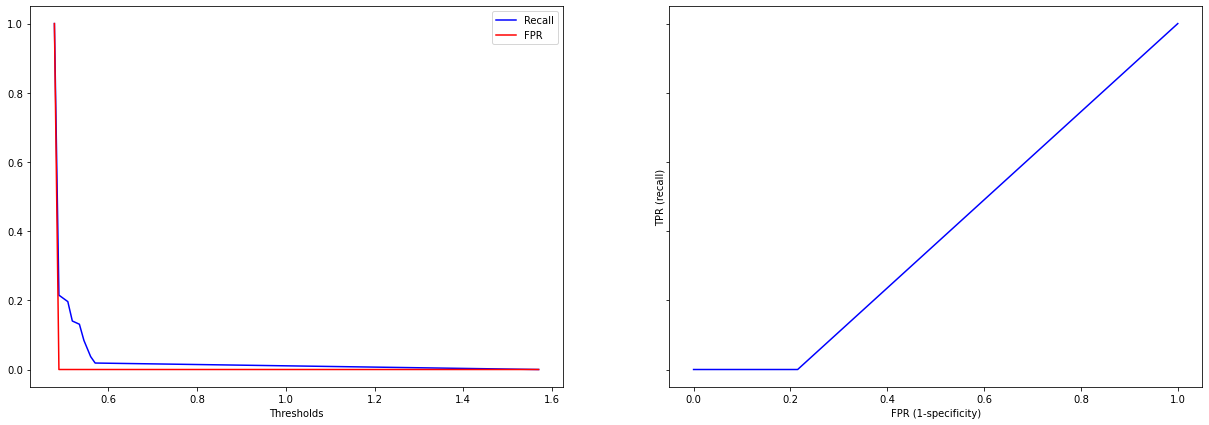

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.602623  0.428189   0.666927     0.777058  0.516029  0.620146
Validation  0.600000  0.426852   0.659299     0.773148  0.512960  0.619269

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010467  0.065289   0.048987     0.078819  0.035117  0.007806
Validation  0.032824  0.078743   0.059847     0.075507  0.057811  0.037323

XGBoost Classifier
╠■■■■■■■■■╣


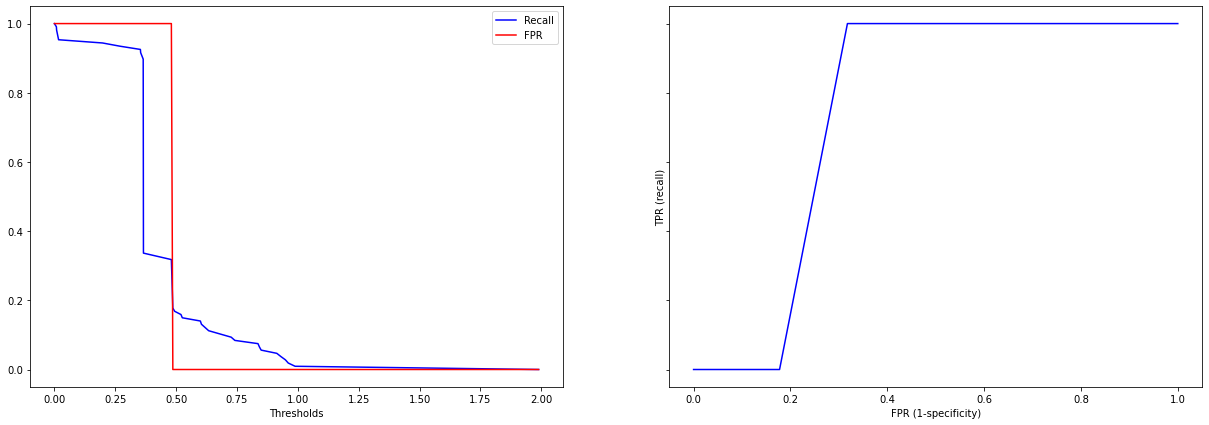

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.677881  0.447737   0.830403     0.908025  0.581429  0.72796
Validation  0.625463  0.386111   0.740535     0.864815  0.505490  0.63065

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003036  0.015826   0.017315     0.014454  0.009776  0.003357
Validation  0.044376  0.068048   0.072275     0.046440  0.071282  0.042234

SVM
╠■■■■■■■■■╣


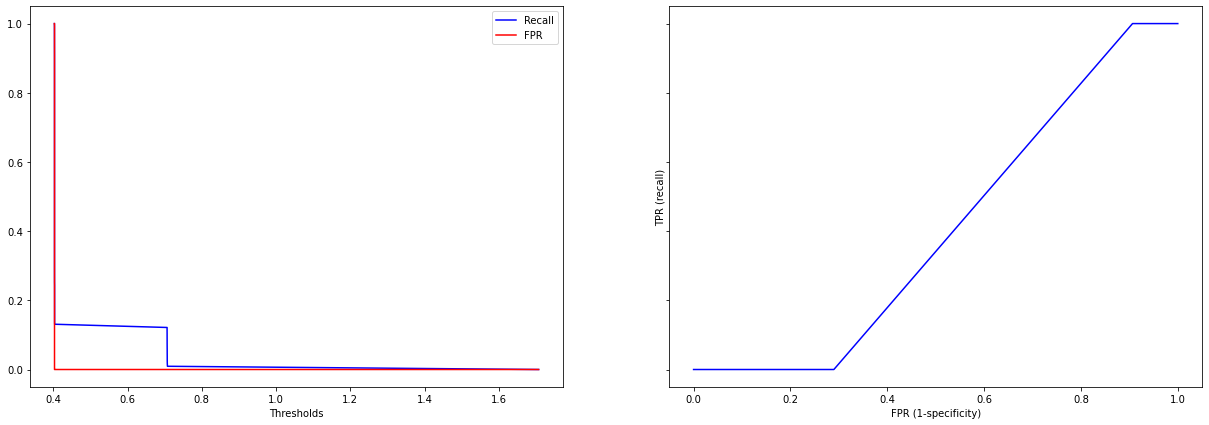

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.629578  0.494033   0.694013     0.765123  0.565922  0.668165
Validation  0.624074  0.487037   0.684366     0.761111  0.554428  0.652996

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005957  0.098896   0.067536     0.099200  0.054715  0.012479
Validation  0.025897  0.132119   0.053535     0.107698  0.086695  0.033393

KNN
╠■■■■■■■■■╣


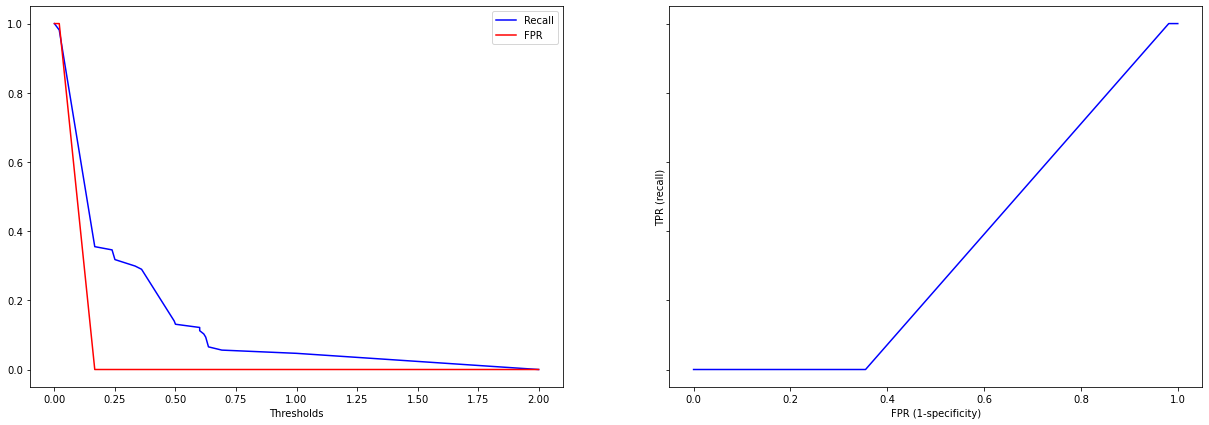

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675977  0.421811   0.858683     0.930144  0.565334  0.702319
Validation  0.607870  0.351852   0.719833     0.863889  0.470758  0.627345

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005611  0.018276   0.017312     0.012100  0.014155  0.007891
Validation  0.031479  0.060639   0.056836     0.030256  0.061184  0.033777

Logistic Regression
╠■■■■■■■■■╣


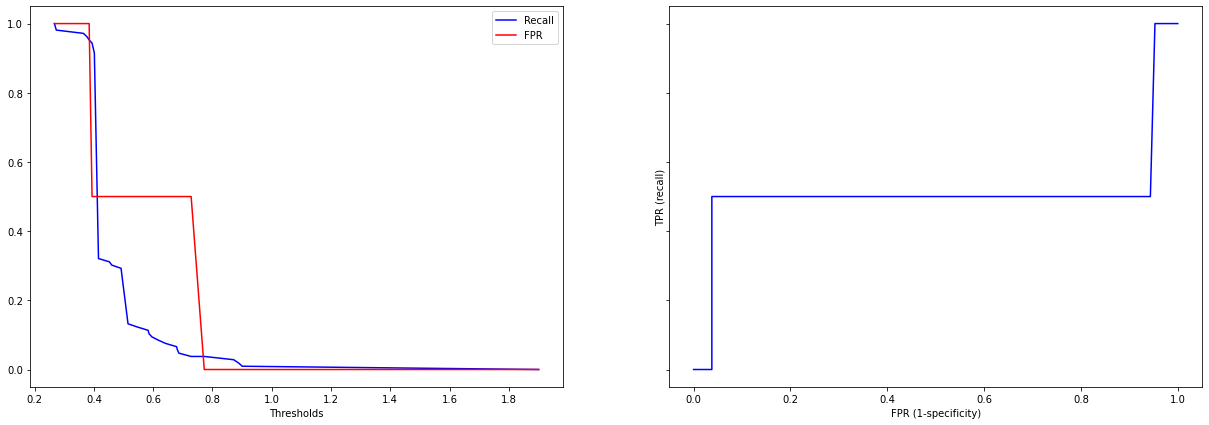

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.636317  0.437757   0.733898     0.834877  0.544771  0.665122
Validation  0.634722  0.436111   0.734726     0.833333  0.541787  0.664892

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009868  0.050539   0.048298     0.062484  0.024759  0.010096
Validation  0.029236  0.069899   0.067726     0.083732  0.046621  0.029070

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.610648  0.373148   0.713608     0.848148   
Random Forest (100 estimators)  0.600000  0.426852   0.659299     0.773148   
XGBoost Classifier              0.625463  0.386111   0.740535     0.864815   
SVM                             0.624074  0.487037   0.684366     0.761111   
KNN                             0.607870  0.351852   0.719833     0.863889   
Logistic Regression             0.634722  0.436111   0.734726     0.833333   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.487903  0.630444  
Random Forest (100 estimators)  0.512960  0.619269  
XGBoost Classifier              0.505490  0.630650  
SVM                             0.554428  0.652996  
KNN                             0.470758  0.627345  
Logistic Regression             0.541787  0.664892

Accuracy  \
Dummy Random                                                  0.5-0.5   
MultinomialNB                   0.5922095345293286-0.6290867617669678   
Random Forest (100 estimators)  0.5792405287397527-0.6207594712602472   
XGBoost Classifier              0.5973969006078784-0.6535290253180476   
SVM                             0.6076956800476276-0.6404524681005204   
KNN                             0.5879611686137406-0.6277795721270002   
Logistic Regression             0.6162320175299381-0.6532124269145063   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                    0.3399006592358142-0.40639563706048204   
Random Forest (100 estimators)   0.3770503865394322-0.47665331716427145   
XGBoost Classifier               0.34307353576900407-0.4291486864532182   
SVM                              0.40347767279497426-0.5705964012790998   
KNN                             0.31350068008145904-0.39020302362224457   
Logistic Regression               0.3919030635313732-0.4803191586908491   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6764609790757798-0.7507559274064772   
Random Forest (100 estimators)  0.6214489151281322-0.6971494345138094   
XGBoost Classifier              0.6948241224750378-0.7862454646382886   
SVM                             0.6505073340391029-0.7182246949530723   
KNN                             0.6838874621291607-0.7557793738078923   
Logistic Regression             0.6918929220864611-0.7775600297659677   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8205147786597538-0.8757815176365424   
Random Forest (100 estimators)  0.7253933445991569-0.8209029516971393   
XGBoost Classifier              0.8354435129546413-0.8941861166749886   
SVM                             0.6929969667944014-0.8292252554278208   
KNN                             0.8447530864197529-0.8830246913580245   
Logistic Regression             0.7803762701493155-0.8862903965173512   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4567756604992316-0.5190299041437946   
Random Forest (100 estimators)   0.4763974309395813-0.5495228658197839   
XGBoost Classifier                0.460407627649025-0.5505731429174829   
SVM                             0.49959713410089507-0.6092591397722982   
KNN                             0.43206214114196484-0.5094548582457444   
Logistic Regression               0.5123010669246286-0.571272819949747   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6046602741355386-0.6562279288822942  
Random Forest (100 estimators)  0.5956636783354082-0.6428737016371567  
XGBoost Classifier              0.6039386809252669-0.6573610447263107  
SVM                              0.6318769093901124-0.674115888963797  
KNN                             0.6059822501304636-0.6487073932165873  
Logistic Regression             0.6465063439185904-0.6832776066986935

In [32]:
run_models(r_symptoms.drop(columns=["sob", "cough"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

In almost all models performance went down if we removed the booleanw <b>cough</b> and <b>sob</b> in favor of the graded <b>cough_severity</b>.


Dummy Random
╠■■■■■■■■■╣


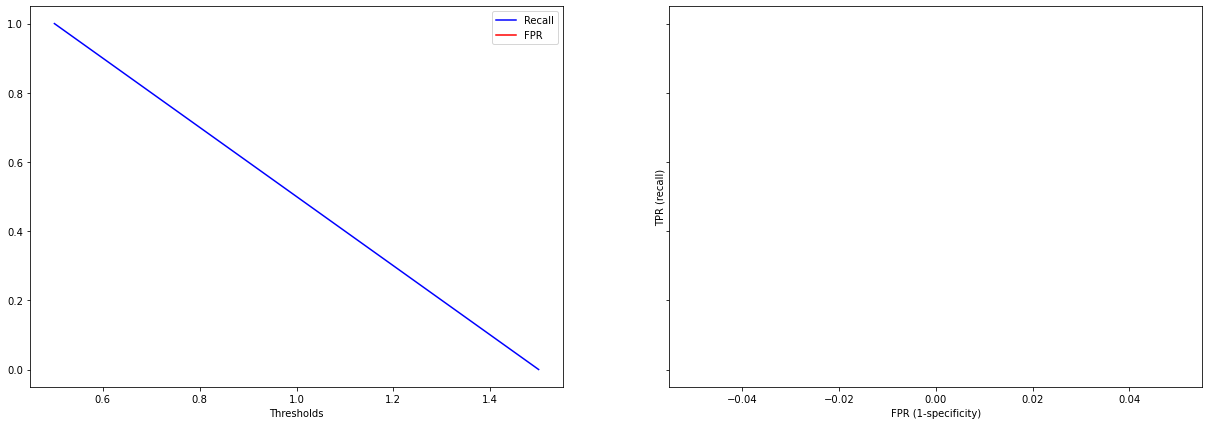

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


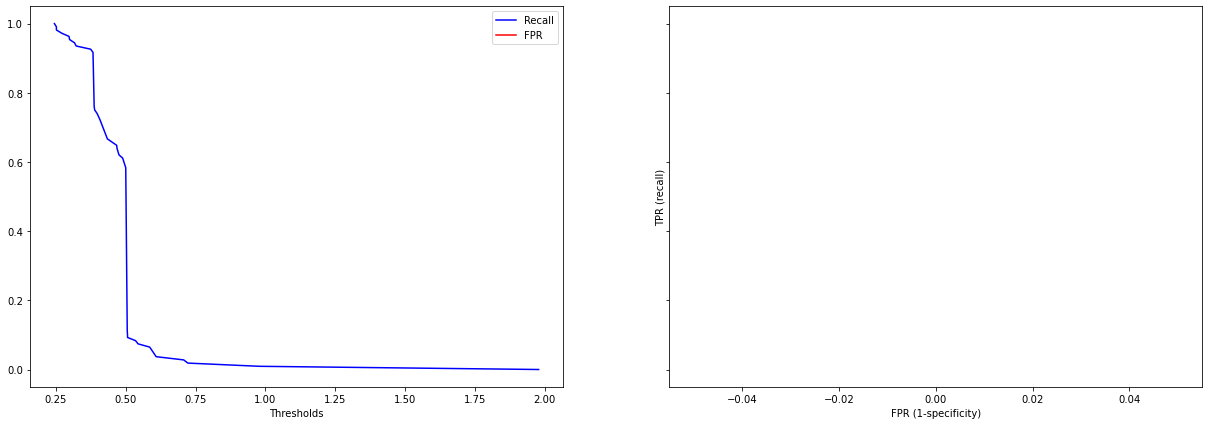

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.621451  0.333230   0.787525     0.909671  0.467971  0.596752
Validation  0.618519  0.335185   0.772734     0.901852  0.462876  0.592001

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010041  0.017556   0.027986     0.015189  0.018347  0.013870
Validation  0.041190  0.084390   0.073666     0.034424  0.087005  0.042363

Random Forest (100 estimators)
╠■■■■■■■■■╣


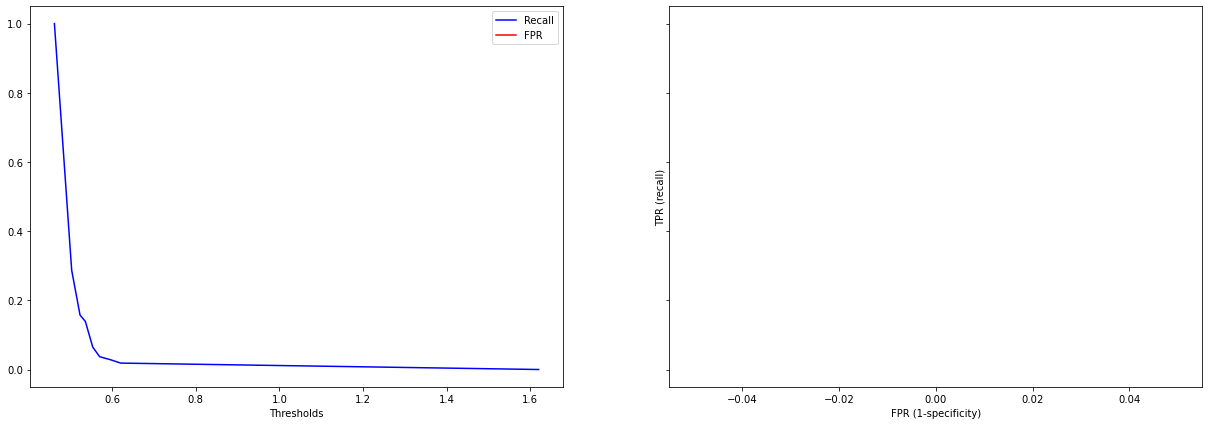

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.639815  0.482819   0.703991     0.796811  0.572709  0.662107
Validation  0.638889  0.480556   0.704436     0.797222  0.570701  0.655783

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006158  0.009541   0.011568     0.012098  0.007606  0.006890
Validation  0.028288  0.036112   0.045581     0.038413  0.034702  0.033365

XGBoost Classifier
╠■■■■■■■■■╣


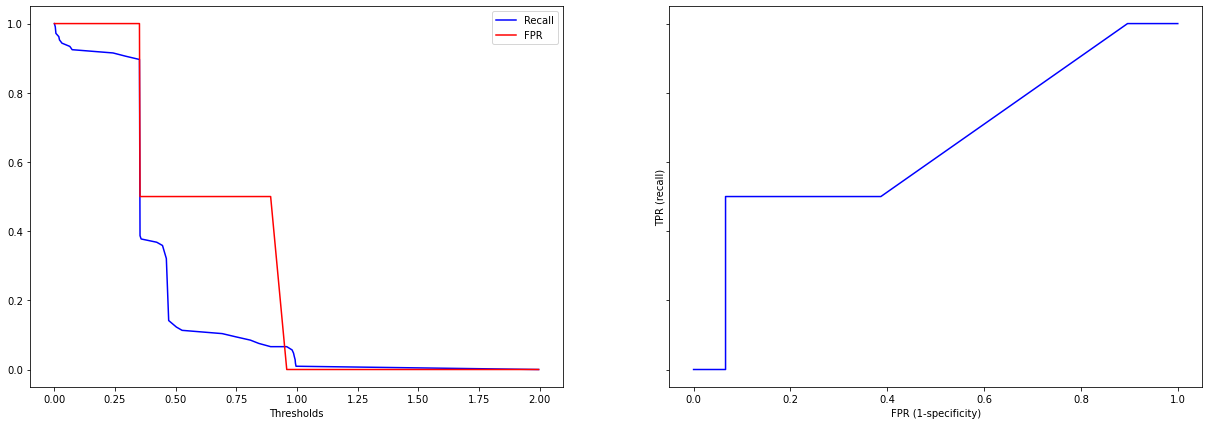

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.702366  0.505556   0.833982     0.899177  0.629404  0.753922
Validation  0.650463  0.446296   0.751969     0.854630  0.559257  0.660550

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003687  0.008813   0.011766     0.009700  0.005590  0.005927
Validation  0.032242  0.057543   0.033405     0.009809  0.053755  0.038547

SVM
╠■■■■■■■■■╣


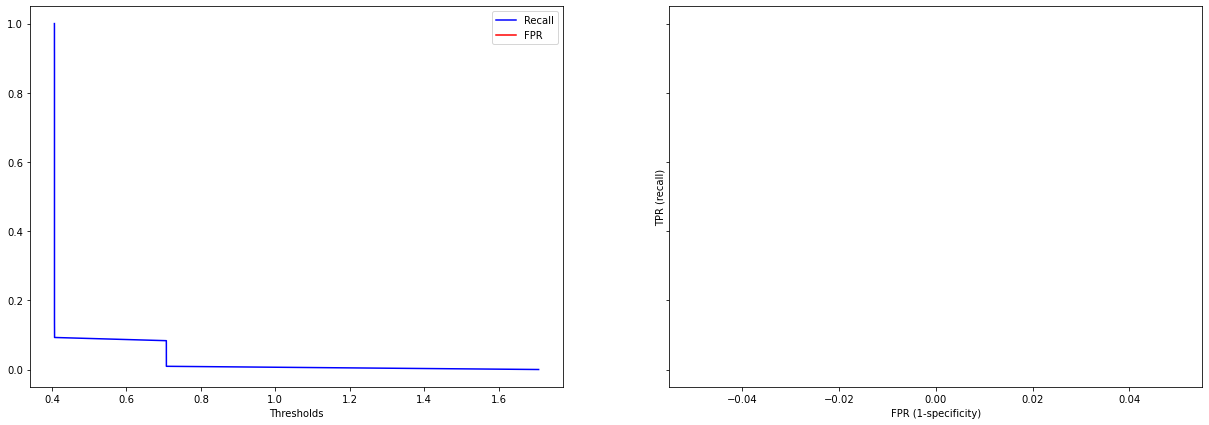

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.662500  0.467078   0.767745     0.857922  0.580011  0.695027
Validation  0.654167  0.463889   0.751349     0.844444  0.570151  0.674035

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010943  0.030841   0.021425     0.021545  0.022442  0.007356
Validation  0.033814  0.075658   0.055640     0.044040  0.059051  0.037777

KNN
╠■■■■■■■■■╣


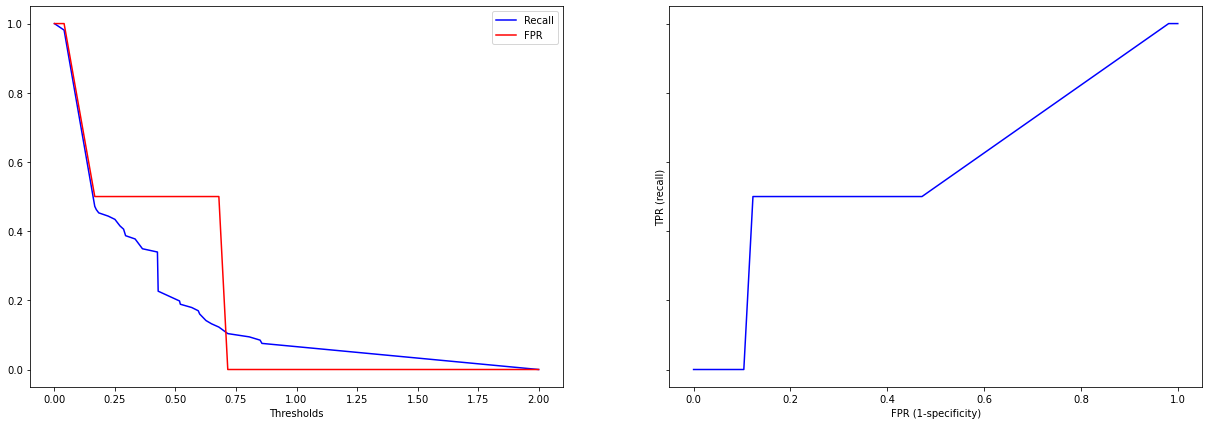

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.703601  0.493313   0.851555     0.913889  0.624548  0.739933
Validation  0.639352  0.438889   0.735995     0.839815  0.548766  0.660700

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005166  0.015122   0.007108     0.006773  0.011093  0.005683
Validation  0.038823  0.042811   0.076028     0.053822  0.047849  0.042826

Logistic Regression
╠■■■■■■■■■╣


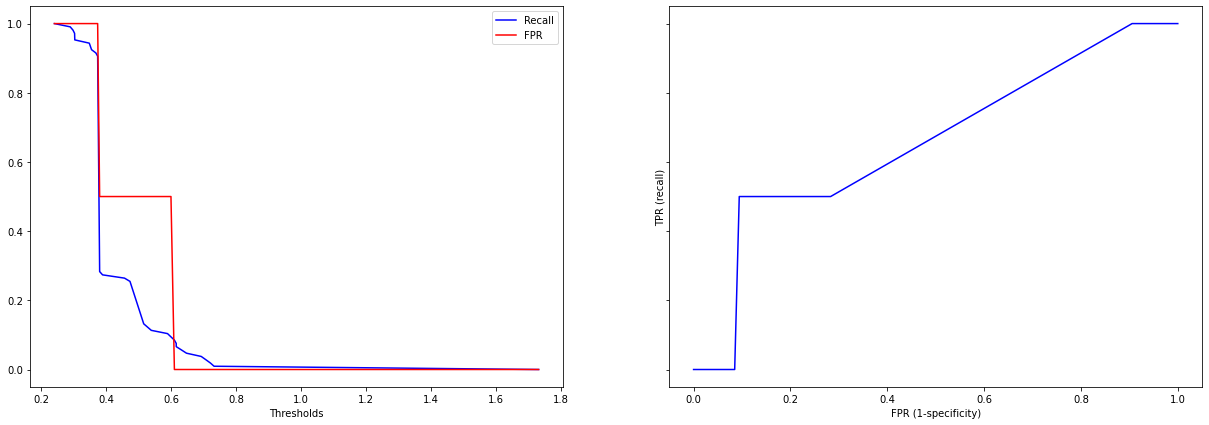

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674383  0.499897   0.767950     0.848868  0.605522  0.703092
Validation  0.658796  0.492593   0.738898     0.825000  0.589966  0.692631

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009173  0.012293   0.014887     0.011138  0.012007  0.010715
Validation  0.019769  0.043386   0.030946     0.030694  0.032238  0.036966

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.618519  0.335185   0.772734     0.901852   
Random Forest (100 estimators)  0.638889  0.480556   0.704436     0.797222   
XGBoost Classifier              0.650463  0.446296   0.751969     0.854630   
SVM                             0.654167  0.463889   0.751349     0.844444   
KNN                             0.639352  0.438889   0.735995     0.839815   
Logistic Regression             0.658796  0.492593   0.738898     0.825000   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.462876  0.592001  
Random Forest (100 estimators)  0.570701  0.655783  
XGBoost Classifier              0.559257  0.660550  
SVM                             0.570151  0.674035  
KNN                             0.548766  0.660700  
Logistic Regression             0.589966  0.692631

Accuracy  \
Dummy Random                                                  0.5-0.5   
MultinomialNB                   0.5924679656222109-0.6445690714148262   
Random Forest (100 estimators)  0.6209983003133462-0.6567794774644312   
XGBoost Classifier              0.6300715596800508-0.6708543662458752   
SVM                              0.632781096047753-0.6755522372855801   
KNN                             0.6147978356750632-0.6639058680286405   
Logistic Regression             0.6462934388268339-0.6712991537657588   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                   0.28181242883650054-0.38855794153386986   
Random Forest (100 estimators)      0.457716049382716-0.503395061728395   
XGBoost Classifier               0.40990270870868234-0.4826898838839104   
SVM                               0.4160384321573247-0.5117393456204531   
KNN                              0.4118127009883193-0.46596507678945837   
Logistic Regression              0.46515294966556436-0.5200322355196209   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.7261436152611906-0.8193239296223034   
Random Forest (100 estimators)  0.6756082037216801-0.7332643212937356   
XGBoost Classifier              0.7308421524160439-0.7730959665789842   
SVM                             0.7161588147166924-0.7865387620672852   
KNN                             0.6879106339806237-0.7840788893624812   
Logistic Regression             0.7193253705334653-0.7584697621338915   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.8800800097672242-0.9236236939364796   
Random Forest (100 estimators)  0.7729275695627722-0.8215168748816721   
XGBoost Classifier              0.8484260027030119-0.8608332565562475   
SVM                             0.8165913230304235-0.8722975658584654   
KNN                             0.8057745291877476-0.8738551004418822   
Logistic Regression             0.8055874256870168-0.8444125743129831   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.4078492183748162-0.5179022004063081   
Random Forest (100 estimators)  0.5487540829766959-0.5926487833281977   
XGBoost Classifier               0.5252595447920444-0.593254679743669   
SVM                              0.532803880083104-0.6074976829897335   
KNN                             0.5185042249019763-0.5790284039582146   
Logistic Regression             0.5695766641536106-0.6103553526895547   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.5652080885762416-0.6187939690369268  
Random Forest (100 estimators)  0.6346806810372053-0.6768848196486655  
XGBoost Classifier              0.6361702955692126-0.6849288127984143  
SVM                             0.6501435104305442-0.6979274772237767  
KNN                             0.6336141101480073-0.6877850668067254  
Logistic Regression              0.6692520706907154-0.716010274988297

In [33]:
run_models(r_symptoms.drop(columns=["sob_severity", "cough_severity"]), y[r_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently keeping both the boolean and the graded yields better performance for every algorithm, except for <b>XGBoost</b> which improves when we just leave the boolean value.

Dummy Random
╠■■■■■■■■■╣


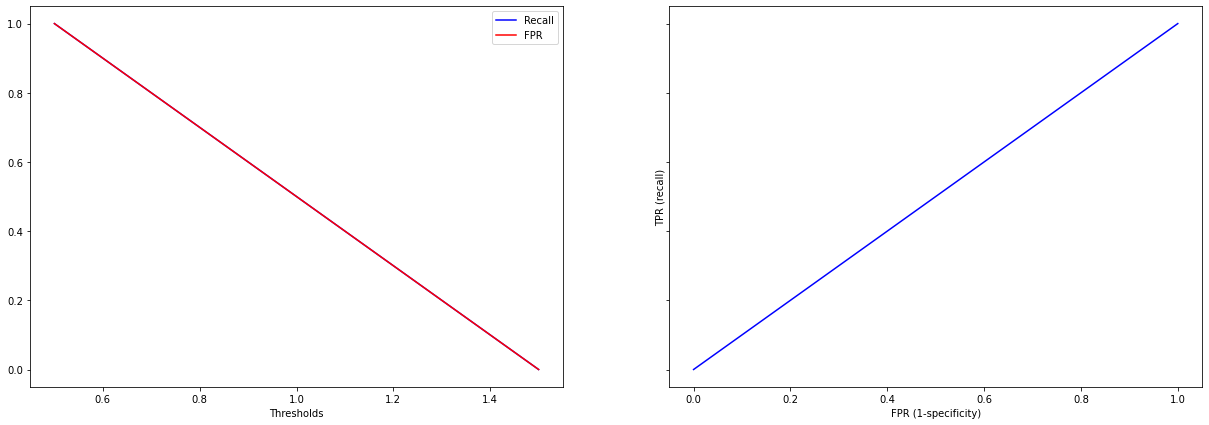

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500079     0.0        0.0          1.0  0.0      0.5
Validation  0.499289     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000127     0.0        0.0          0.0  0.0      0.0
Validation  0.001145     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


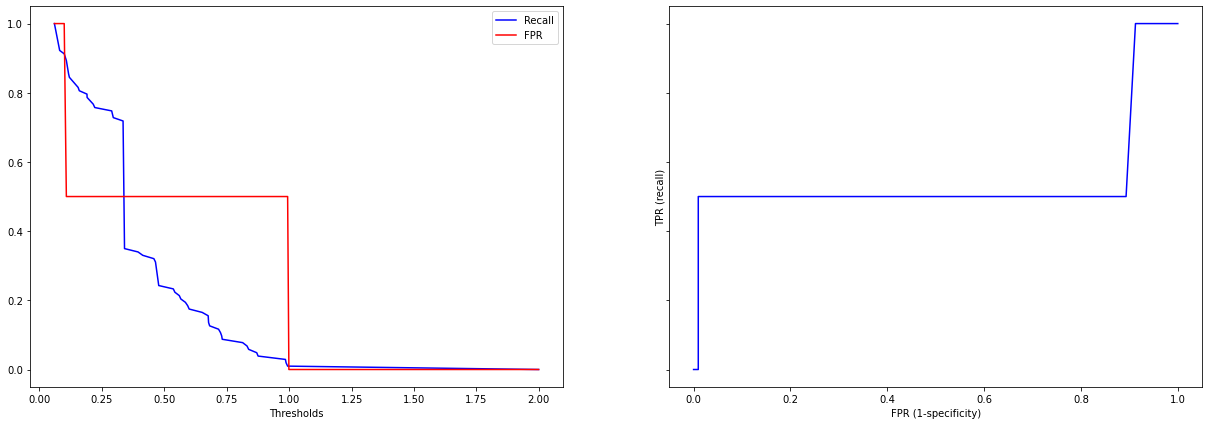

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.650684  0.512188   0.708415     0.789135  0.594455  0.690698
Validation  0.649549  0.510988   0.713084     0.788571  0.592960  0.687066

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006294  0.010460   0.009926     0.010774  0.008188  0.005919
Validation  0.026807  0.047086   0.054014     0.067761  0.030468  0.031858

Random Forest (100 estimators)
╠■■■■■■■■■╣


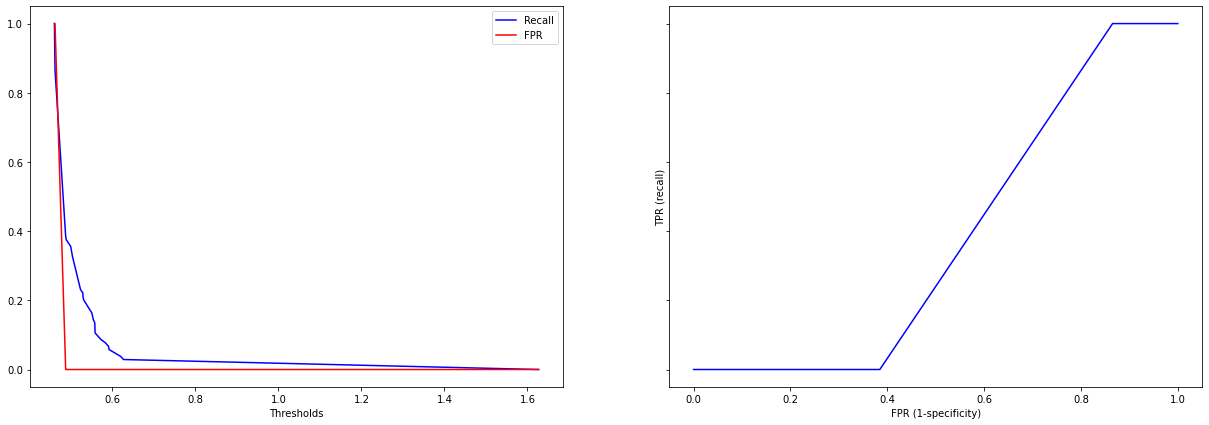

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.649892  0.506278   0.710700     0.793460  0.591090  0.687919
Validation  0.657183  0.512911   0.723993     0.801905  0.599234  0.690724

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005613  0.012482   0.015132     0.018790  0.006270  0.008358
Validation  0.024477  0.040755   0.039772     0.043943  0.031003  0.019635

XGBoost Classifier
╠■■■■■■■■■╣


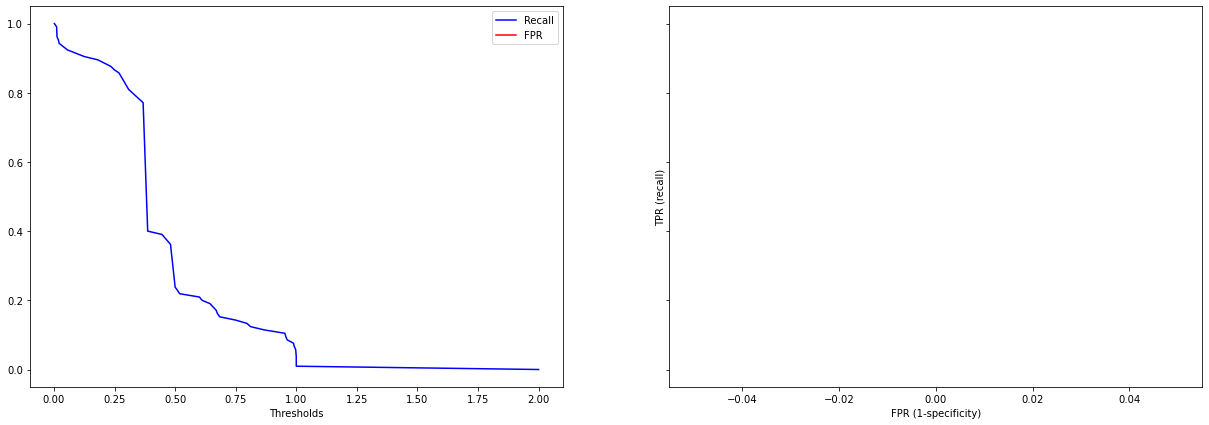

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.773962  0.601564   0.918209     0.946308  0.726817  0.847836
Validation  0.640074  0.472075   0.711338     0.808571  0.565790  0.653759

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004508  0.009455   0.010858     0.008025  0.006356  0.006249
Validation  0.040981  0.069786   0.050588     0.038477  0.061784  0.035721

SVM
╠■■■■■■■■■╣


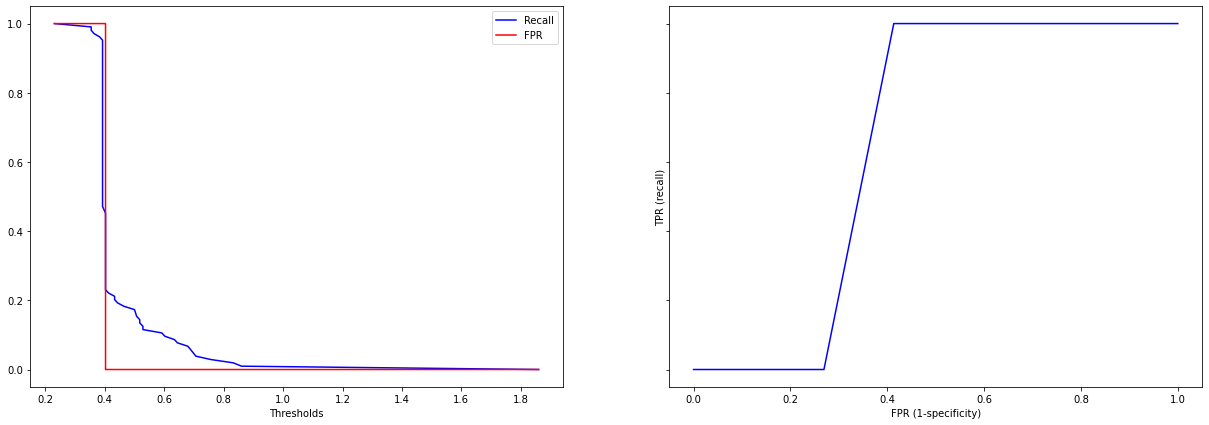

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664979  0.474943   0.766987     0.854958  0.585426  0.707688
Validation  0.652891  0.467251   0.742506     0.839048  0.573033  0.695708

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010164  0.039791   0.013237     0.021418  0.027556  0.006784
Validation  0.034671  0.053336   0.041701     0.020303  0.052107  0.036114

KNN
╠■■■■■■■■■╣


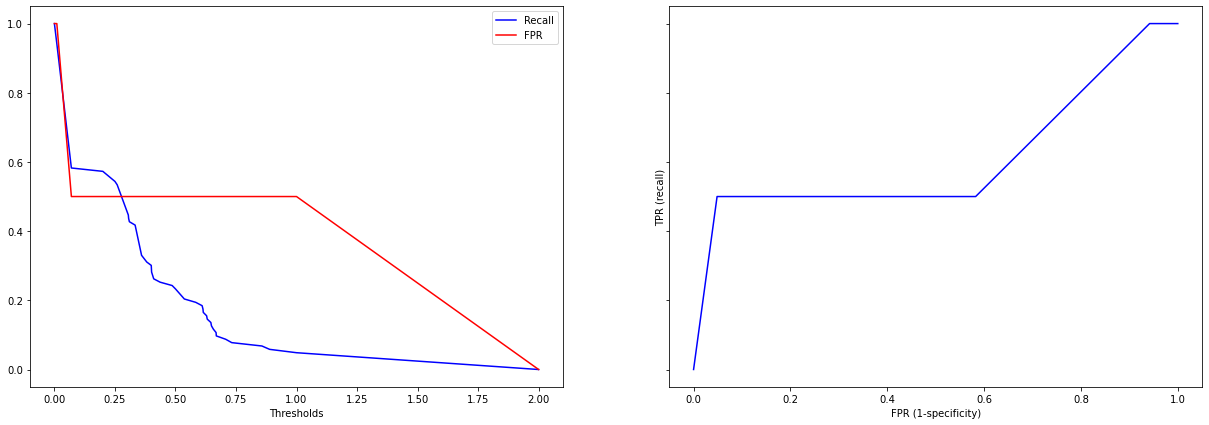

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.776389  0.583414   0.950073     0.969304  0.722874  0.826436
Validation  0.645780  0.477790   0.722896     0.814286  0.574071  0.657794

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004075  0.006728   0.008519     0.005457  0.005563  0.014224
Validation  0.035885  0.047126   0.059664     0.050843  0.046165  0.046801

Logistic Regression
╠■■■■■■■■■╣


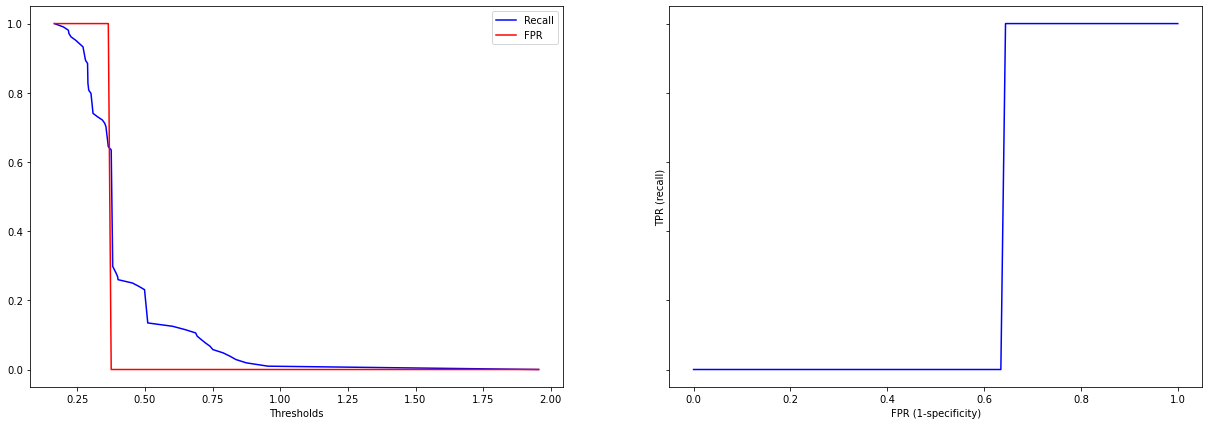

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.675001  0.511984   0.761047     0.837975  0.611428  0.720928
Validation  0.684724  0.514681   0.781256     0.855238  0.618691  0.717465

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005969  0.024237   0.022800     0.029716  0.010346  0.007180
Validation  0.027992  0.063171   0.031026     0.027603  0.047314  0.038009

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.499289  0.000000   0.000000     1.000000   
MultinomialNB                   0.649549  0.510988   0.713084     0.788571   
Random Forest (100 estimators)  0.657183  0.512911   0.723993     0.801905   
XGBoost Classifier              0.640074  0.472075   0.711338     0.808571   
SVM                             0.652891  0.467251   0.742506     0.839048   
KNN                             0.645780  0.477790   0.722896     0.814286   
Logistic Regression             0.684724  0.514681   0.781256     0.855238   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.592960  0.687066  
Random Forest (100 estimators)  0.599234  0.690724  
XGBoost Classifier              0.565790  0.653759  
SVM                             0.573033  0.695708  
KNN                             0.574071  0.657794  
Logistic Regression             0.618691  0.717465

Accuracy  \
Dummy Random                    0.4985651539186483-0.5000130451334843   
MultinomialNB                   0.6325944589512856-0.6665028102881637   
Random Forest (100 estimators)    0.641702919897941-0.672664040156223   
XGBoost Classifier              0.6141555823042039-0.6659933682712872   
SVM                             0.6309634076195603-0.6748185829017668   
KNN                             0.6230841283846467-0.6684753390042049   
Logistic Regression             0.6670198432345695-0.7024272341745934   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4812087571148381-0.5407678825976506   
Random Forest (100 estimators)   0.4871354252439432-0.5386866771819327   
XGBoost Classifier               0.4279391192619697-0.5162118241342566   
SVM                                 0.4335181919064-0.5009831558024949   
KNN                             0.44798469129928165-0.5075948235255162   
Logistic Regression               0.4747282315782002-0.554633852878224   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6789220335790225-0.7472453895565445   
Random Forest (100 estimators)   0.698839036990373-0.7491464808197061   
XGBoost Classifier              0.6793435378447134-0.7433334031507023   
SVM                             0.7161317421507664-0.7688799148938136   
KNN                             0.6851610795696824-0.7606306171808456   
Logistic Regression             0.7616337231003688-0.8008782292311621   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7457154615093684-0.8314273956334888   
Random Forest (100 estimators)  0.7741129287260453-0.8296965950834785   
XGBoost Classifier              0.7842364852104928-0.8329063719323642   
SVM                             0.8262071438627575-0.8518880942324804   
KNN                             0.7821296323502207-0.8464417962212079   
Logistic Regression             0.8377806640192156-0.8726955264569745   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                     0.573690092328011-0.612229429076544   
Random Forest (100 estimators)  0.5796260326171433-0.6188420456296387   
XGBoost Classifier              0.5267148208222878-0.6048658882273801   
SVM                             0.5400781550396021-0.6059886014136409   
KNN                             0.5448742145573662-0.6032682854689579   
Logistic Regression              0.588767144886606-0.6486149540996057   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6669172601682156-0.7072152003631669  
Random Forest (100 estimators)  0.6783063449936471-0.7031422495385056  
XGBoost Classifier              0.6311667067880375-0.6763511984872803  
SVM                              0.6728679263176922-0.718548751045077  
KNN                              0.6281939447467233-0.687393100134122  
Logistic Regression             0.6934263865522147-0.7415044310578486

In [34]:
#ra_symptoms
run_models(ra_symptoms, y[ra_symptoms.index], models, ratio_negatives_to_positives=1)

Apparently, all features in <b>reported_symptoms</b> are more important than the assesed ones. <b>days_since_symptom_onset</b> seems to have some importance. Performance improves slightly for all of them except for <b>SVM</b> and <b>Logistic Regression</b>. Logistic Regression improves with a slightly lower threshold (.4 for higher recall and .44 for higher specificity). SVM improves also with a lower threshold(.47)

Dummy Random
╠■■■■■■■■■╣


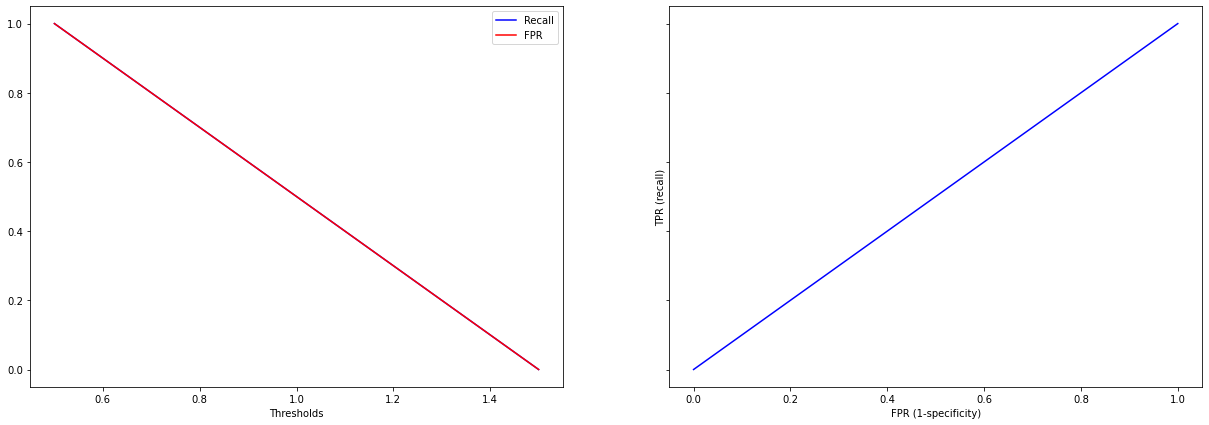

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.5     0.0        0.0          1.0  0.0      0.5
Validation       0.5     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training         0.0     0.0        0.0          0.0  0.0      0.0
Validation       0.0     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


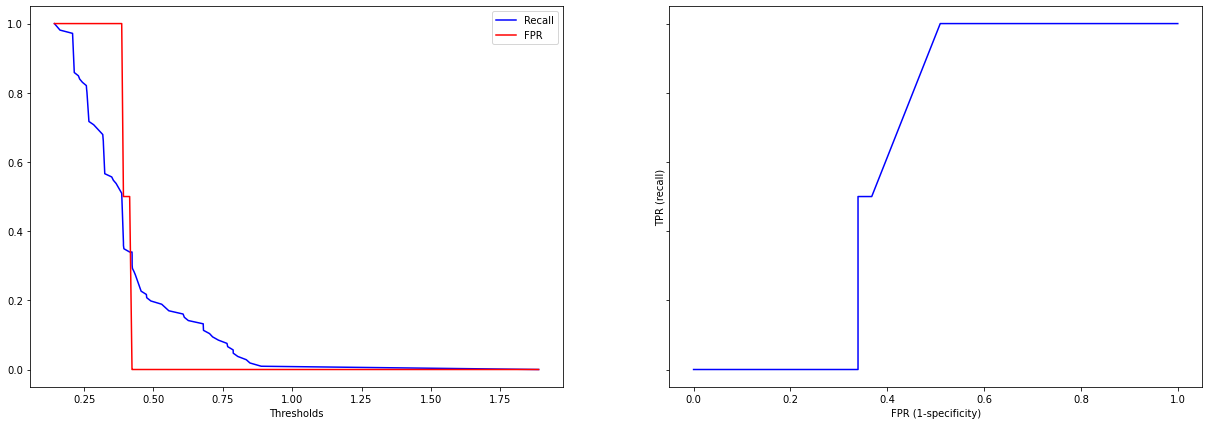

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.642284  0.471811   0.715999     0.812757  0.568759  0.682345
Validation  0.636574  0.466667   0.708014     0.806481  0.561046  0.674987

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005213  0.007115   0.009870     0.009227  0.006304  0.008662
Validation  0.037879  0.058103   0.056357     0.045455  0.052393  0.031319

Random Forest (100 estimators)
╠■■■■■■■■■╣


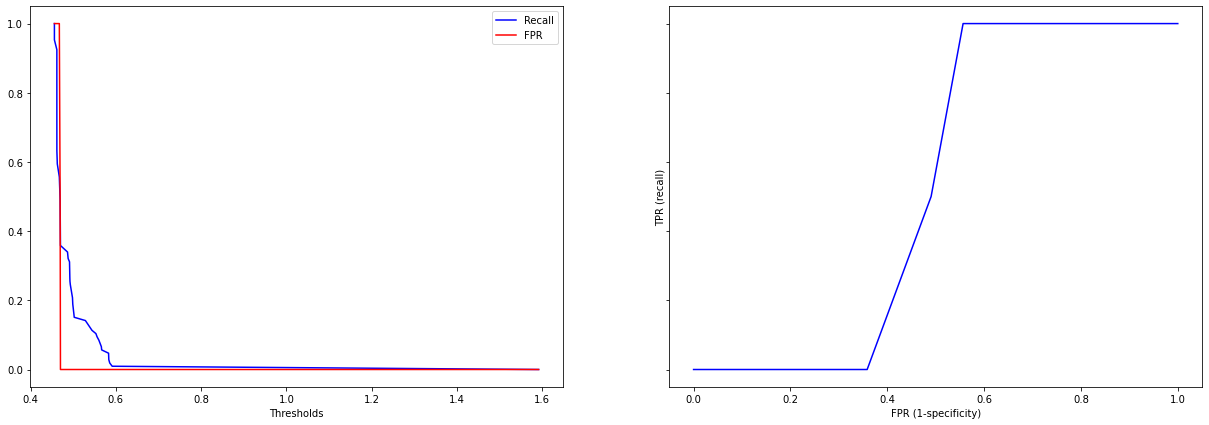

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.645113  0.481996   0.715684     0.808230  0.575911  0.685780
Validation  0.649537  0.483333   0.725072     0.815741  0.579337  0.687148

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.00713  0.010804   0.014660     0.014784  0.008481  0.010649
Validation   0.02700  0.036727   0.042653     0.036112  0.034446  0.021377

XGBoost Classifier
╠■■■■■■■■■╣


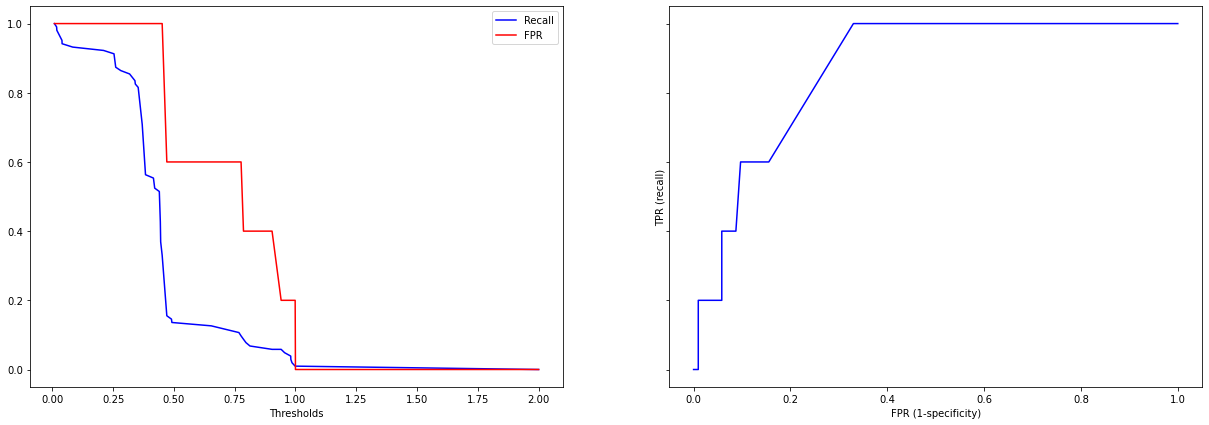

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.758282  0.576029   0.906549     0.940535  0.704386  0.843249
Validation  0.633796  0.459259   0.705018     0.808333  0.554346  0.648980

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005822  0.009259   0.011234     0.007966  0.007831  0.007681
Validation  0.031434  0.064623   0.036828     0.032090  0.054622  0.028462

SVM
╠■■■■■■■■■╣


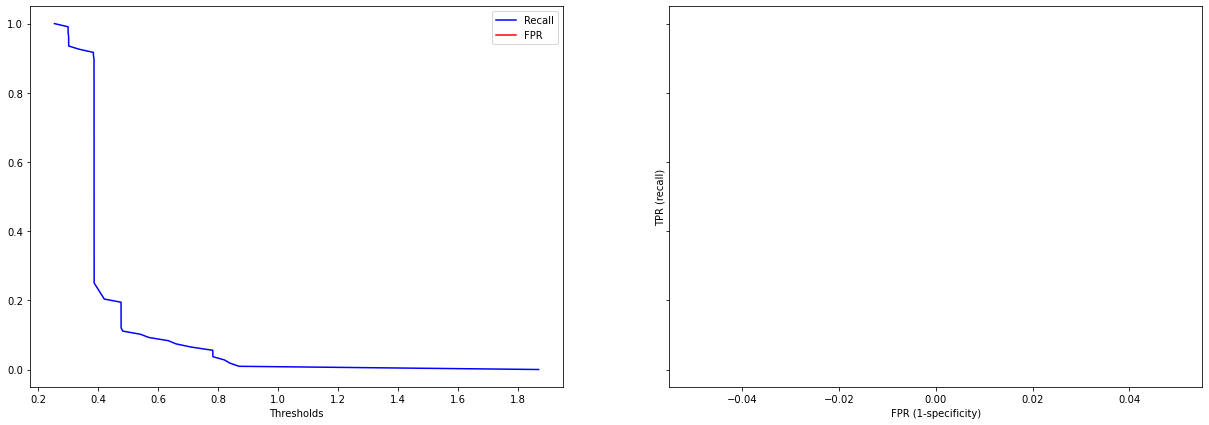

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.655813  0.463477   0.754753     0.848148  0.573135  0.706317
Validation  0.661111  0.450926   0.776840     0.871296  0.568635  0.704150

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005559  0.034585   0.018343     0.025687  0.021828  0.006977
Validation  0.042308  0.072783   0.051310     0.032795  0.065686  0.052375

KNN
╠■■■■■■■■■╣


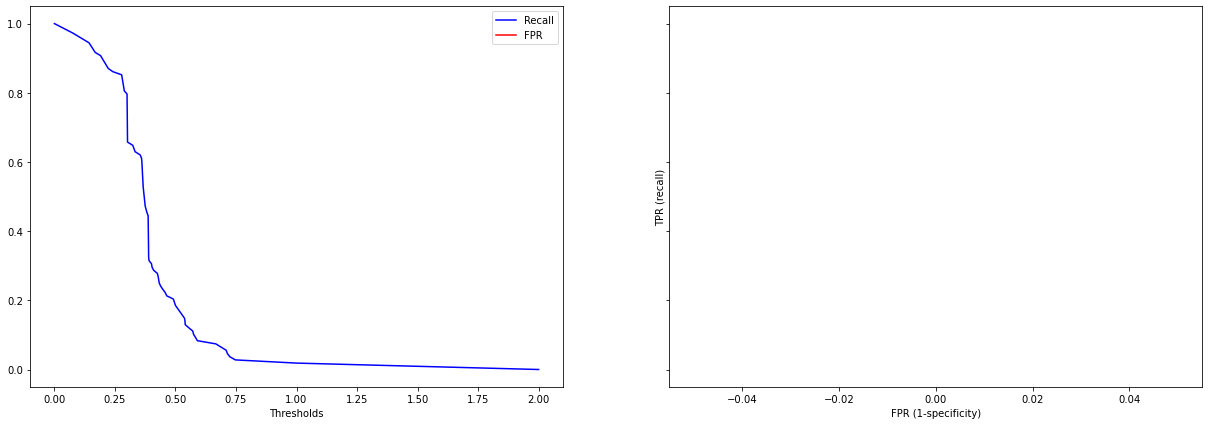

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.755093  0.550206   0.932557     0.959979  0.691893  0.820456
Validation  0.633333  0.406481   0.741748     0.860185  0.524359  0.646078

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004003  0.013733   0.012185     0.008586  0.008369  0.004633
Validation  0.035648  0.056144   0.048177     0.022448  0.057634  0.044549

Logistic Regression
╠■■■■■■■■■╣


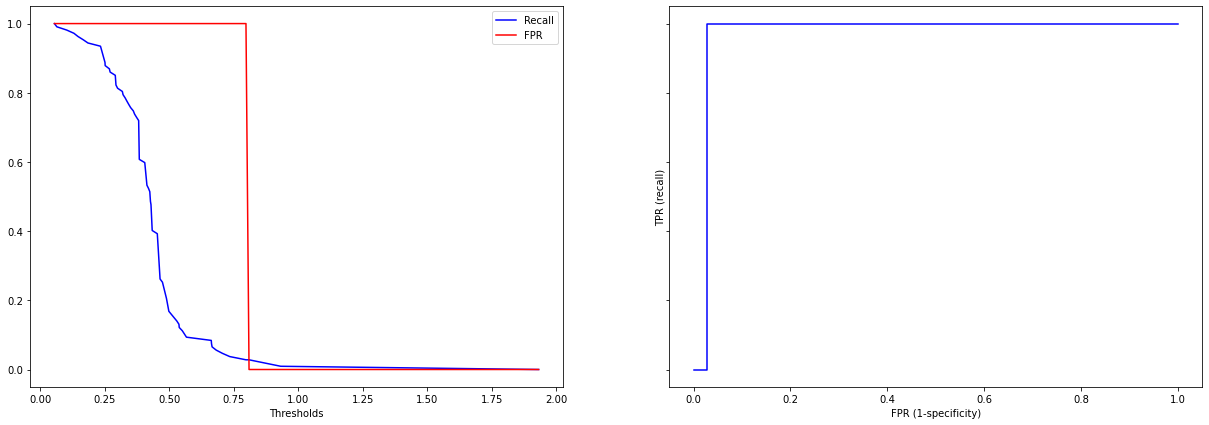

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670319  0.517695   0.746311     0.822942  0.610839  0.716460
Validation  0.671759  0.515741   0.750009     0.827778  0.609538  0.713216

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006113  0.017296   0.021936     0.026106  0.006580  0.003462
Validation  0.026501  0.059216   0.027762     0.030616  0.044274  0.026204

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.500000  0.000000   0.000000     1.000000   
MultinomialNB                   0.636574  0.466667   0.708014     0.806481   
Random Forest (100 estimators)  0.649537  0.483333   0.725072     0.815741   
XGBoost Classifier              0.633796  0.459259   0.705018     0.808333   
SVM                             0.661111  0.450926   0.776840     0.871296   
KNN                             0.633333  0.406481   0.741748     0.860185   
Logistic Regression             0.671759  0.515741   0.750009     0.827778   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.561046  0.674987  
Random Forest (100 estimators)  0.579337  0.687148  
XGBoost Classifier              0.554346  0.648980  
SVM                             0.568635  0.704150  
KNN                             0.524359  0.646078  
Logistic Regression             0.609538  0.713216

Accuracy  \
Dummy Random                                                  0.5-0.5   
MultinomialNB                   0.6126170143576234-0.6605311337905247   
Random Forest (100 estimators)  0.6324610170449098-0.6666130570291643   
XGBoost Classifier              0.6139158235614964-0.6536767690310962   
SVM                             0.6343534360472923-0.6878687861749299   
KNN                             0.6107876760891979-0.6558789905774687   
Logistic Regression             0.6549985506390305-0.6885199678794883   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                      0.4299188245280562-0.503414508805277   
Random Forest (100 estimators)   0.46010507688613983-0.5065615897805269   
XGBoost Classifier               0.41838778924136594-0.5001307292771529   
SVM                               0.4048937575617231-0.4969580942901288   
KNN                             0.37097289625118607-0.44199006671177693   
Logistic Regression              0.47828935478489487-0.5531921266965864   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6723711400017602-0.7436574279381412   
Random Forest (100 estimators)  0.6980960009252232-0.7520479627656455   
XGBoost Classifier              0.6817262202462545-0.7283105928942998   
SVM                             0.7443885435795616-0.8092915299197394   
KNN                              0.711278015963481-0.7722173777942302   
Logistic Regression             0.7324504361978624-0.7675667992933207   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7777330098217407-0.8352299531412223   
Random Forest (100 estimators)  0.7929012345679014-0.8385802469135804   
XGBoost Classifier               0.788037923181761-0.8286287434849057   
SVM                              0.850555188127887-0.8920374044647055   
KNN                             0.8459876543209877-0.8743827160493827   
Logistic Regression              0.808414336862521-0.8471412186930347   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                      0.527909451981592-0.594182484113036   
Random Forest (100 estimators)   0.5575512790278756-0.6011230266475454   
XGBoost Classifier               0.5198003517168134-0.5888924003137818   
SVM                              0.5270916358354908-0.6101791687792416   
KNN                             0.48790833881471535-0.5608098205845315   
Logistic Regression              0.5815368059264401-0.6375397343177696   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6551794651008791-0.6947948147345118  
Random Forest (100 estimators)   0.673628549348406-0.7006684328189465  
XGBoost Classifier              0.6309787310027143-0.6669808026049674  
SVM                             0.6710246992824096-0.7372743404981117  
KNN                             0.6179024924450848-0.6742528573491539  
Logistic Regression             0.6966432159369067-0.7297885398929973

In [35]:
#r_symptoms_ex
run_models(r_symptoms_ex, y[r_symptoms_ex.index], models, ratio_negatives_to_positives=1)

Epidemiological factors proves themselves to be slightly more important that some of the of the reported symptoms. <b>high_risk_exposure_occupation</b> once again proves to be a highly determinant feature. It also improves performance in all other models, while reducing specificity by a small amount (with the exception of <b>KNN</b>).

Dummy Random
╠■■■■■■■■■╣


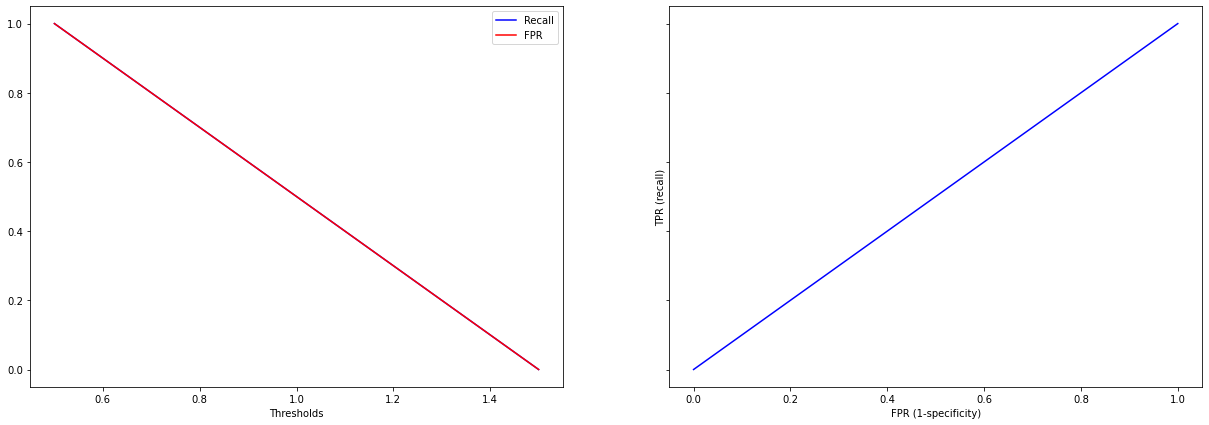

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


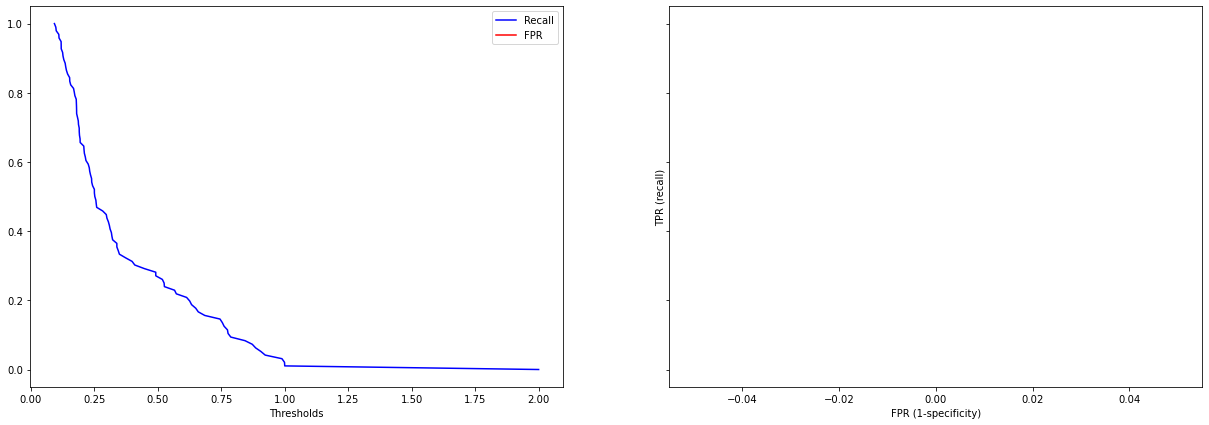

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.659190  0.508953   0.727368     0.809289  0.598750  0.707667
Validation  0.658738  0.506271   0.730623     0.812500  0.596865  0.702942

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003782  0.012527   0.006722     0.009686  0.007878  0.005742
Validation  0.044711  0.068242   0.057567     0.040194  0.061453  0.034551

Random Forest (100 estimators)
╠■■■■■■■■■╣


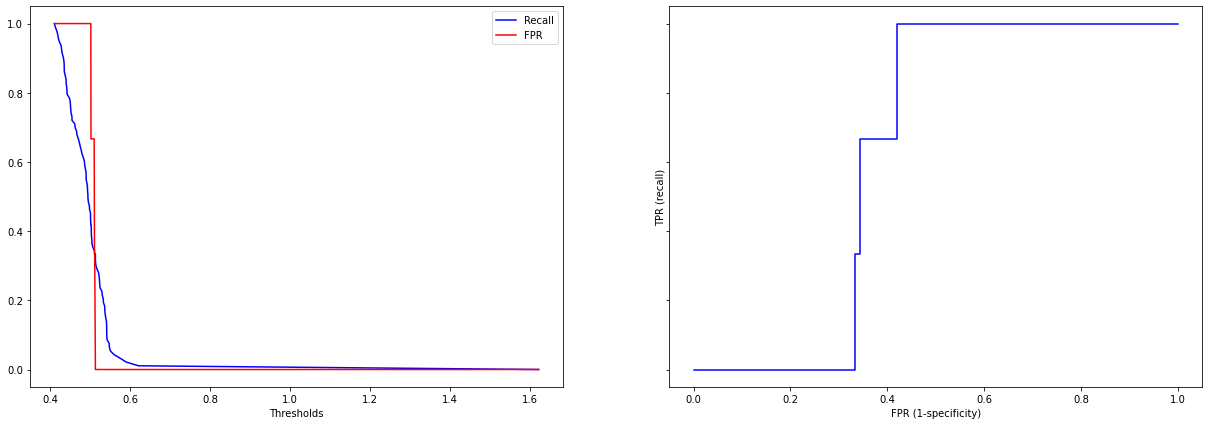

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.661543  0.564396   0.701666     0.758601  0.624804  0.72207
Validation  0.651967  0.557925   0.693245     0.746875  0.616226  0.70608

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009216  0.026092   0.023188     0.035512  0.011157  0.008413
Validation  0.019050  0.045485   0.038054     0.062123  0.022042  0.038587

XGBoost Classifier
╠■■■■■■■■■╣


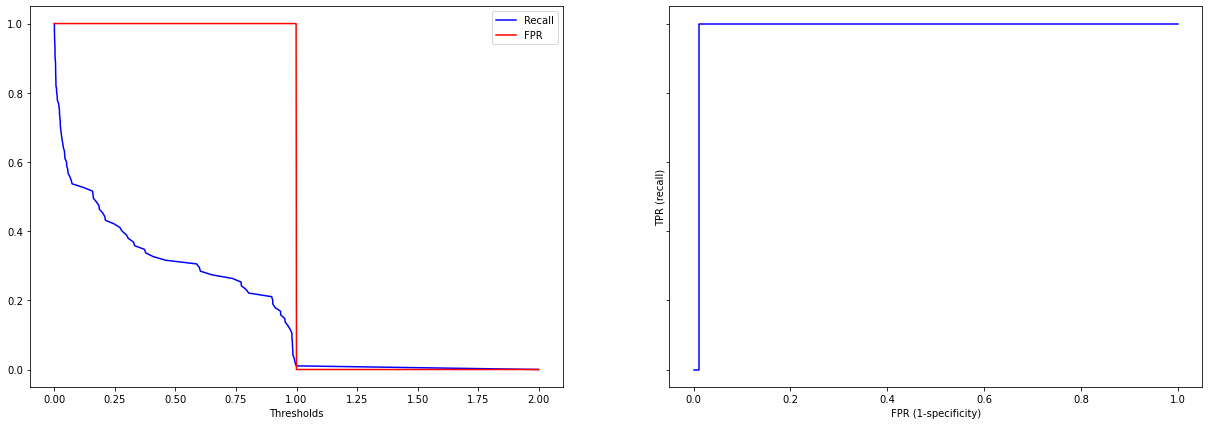

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999312  0.998967   0.999656     0.999656  0.999311  0.999998
Validation  0.618272  0.579671   0.631196     0.657292  0.603377  0.671231

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000527  0.000651   0.000555     0.000554  0.000527  0.000002
Validation  0.029415  0.049111   0.034787     0.048969  0.034157  0.030726

SVM
╠■■■■■■■■■╣


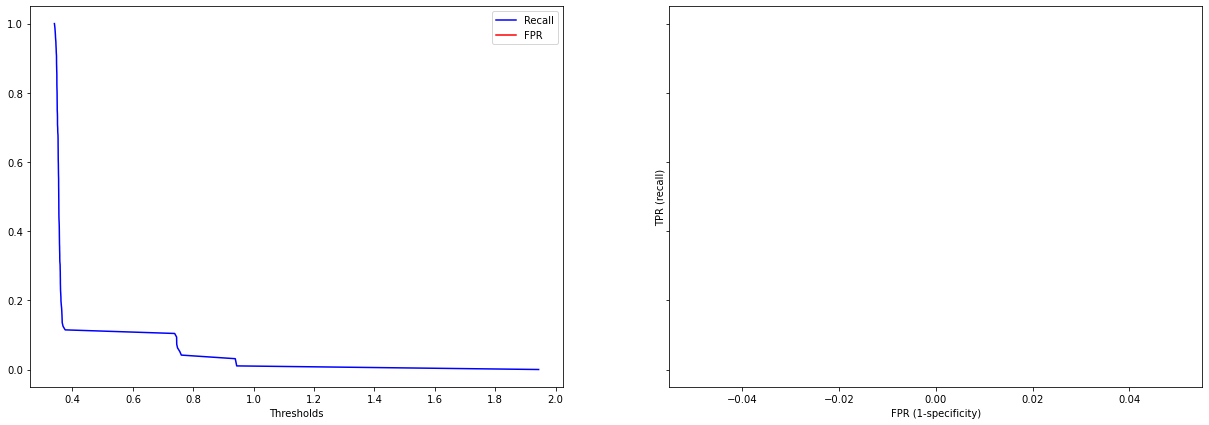

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669803  0.477730   0.776177     0.861697  0.591053  0.738932
Validation  0.666513  0.476342   0.772364     0.858333  0.587640  0.723617

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005706  0.016726   0.019909     0.018029  0.010271  0.005803
Validation  0.028783  0.058356   0.034075     0.028717  0.047784  0.031228

KNN
╠■■■■■■■■■╣


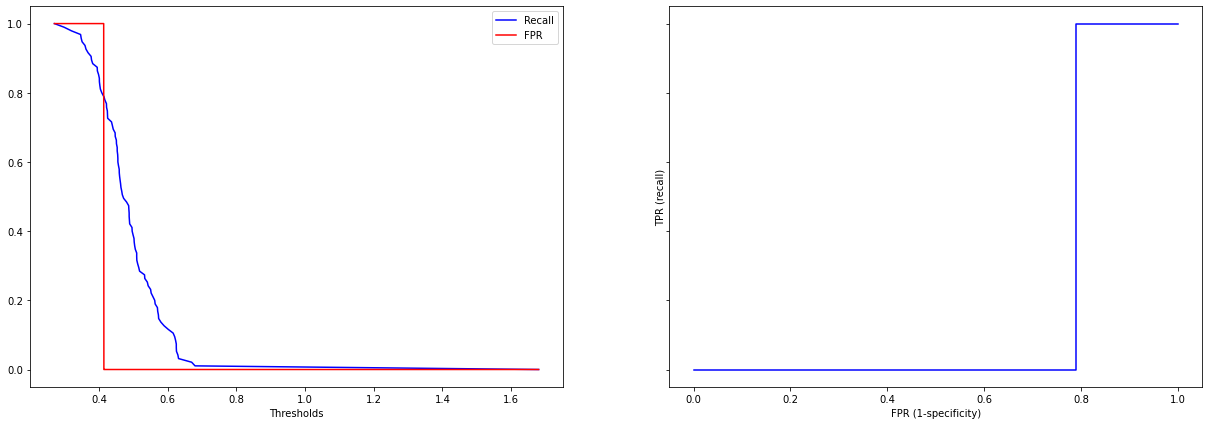

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999713  0.999426   1.000000      1.00000  0.999713  1.000000
Validation  0.578319  0.501095   0.596963      0.65625  0.542562  0.596015

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000406  0.000812   0.000000     0.000000  0.000406  8.239933e-07
Validation  0.036552  0.066318   0.043137     0.069791  0.046520  4.604069e-02

Logistic Regression
╠■■■■■■■■■╣


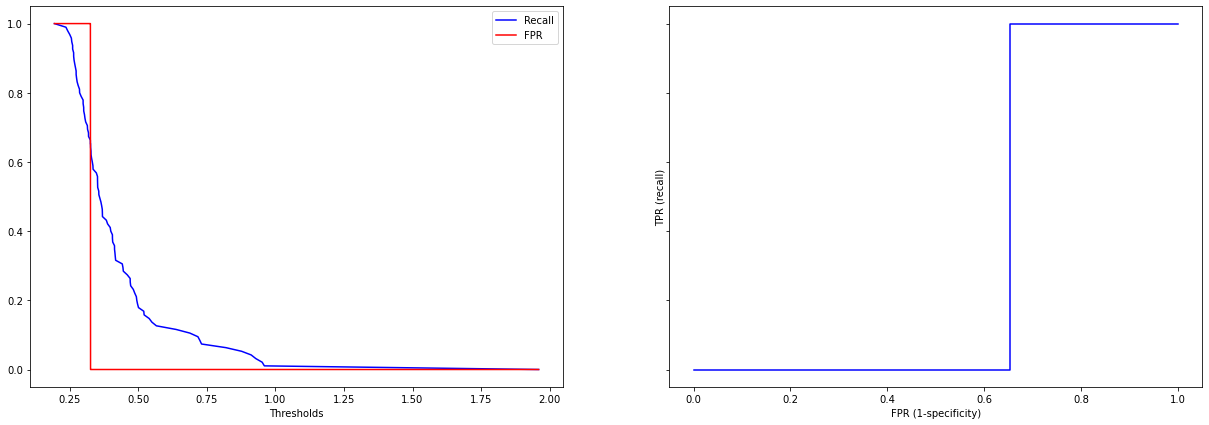

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.680014  0.551883   0.742356     0.808028  0.632884  0.737301
Validation  0.673756  0.551750   0.734783     0.796875  0.628547  0.728539

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.006338  0.009770   0.017357     0.020679  0.00343  0.005467
Validation  0.027461  0.052406   0.042972     0.048673  0.03603  0.029675

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.658738  0.506271   0.730623     0.812500   
Random Forest (100 estimators)  0.651967  0.557925   0.693245     0.746875   
XGBoost Classifier              0.618272  0.579671   0.631196     0.657292   
SVM                             0.666513  0.476342   0.772364     0.858333   
KNN                             0.578319  0.501095   0.596963     0.656250   
Logistic Regression             0.673756  0.551750   0.734783     0.796875   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.596865  0.702942  
Random Forest (100 estimators)  0.616226  0.706080  
XGBoost Classifier              0.603377  0.671231  
SVM                             0.587640  0.723617  
KNN                             0.542562  0.596015  
Logistic Regression             0.628547  0.728539

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                   0.6304601476033643-0.6870161045555302   
Random Forest (100 estimators)  0.6399187336711567-0.6640158518210715   
XGBoost Classifier              0.5996685640446805-0.6368761250744904   
SVM                             0.6483091717920026-0.6847165190542841   
KNN                             0.5552017575333774-0.6014368435028918   
Logistic Regression             0.6563881732352288-0.6911237006853239   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.463111168261034-0.5494317870654266   
Random Forest (100 estimators)  0.5291578860649081-0.5866926293990092   
XGBoost Classifier              0.5486107920129747-0.6107319914921797   
SVM                              0.4394350305521641-0.513249677351616   
KNN                             0.4591522858780161-0.5430384357714685   
Logistic Regression             0.5186059969445188-0.5848948621620101   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6942148394026366-0.7670318551669366   
Random Forest (100 estimators)  0.6691769734508229-0.7173124321440446   
XGBoost Classifier               0.609194679381703-0.6531974991881323   
SVM                             0.7508129421595978-0.7939142677146175   
KNN                             0.5696813205526987-0.6242455613071547   
Logistic Regression             0.7076055305402472-0.7619608592756532   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                     0.787079159419829-0.837920840580171   
Random Forest (100 estimators)  0.7075851523338454-0.7861648476661545   
XGBoost Classifier              0.6263206901097531-0.6882626432235803   
SVM                             0.8401712544019136-0.8764954122647527   
KNN                             0.6121104206053591-0.7003895793946409   
Logistic Regression             0.7660914440843035-0.8276585559156965   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5579993600884307-0.6357313805115364   
Random Forest (100 estimators)  0.6022854585826092-0.6301666488055502   
XGBoost Classifier              0.5817740754553882-0.6249802091480954   
SVM                             0.5574184532294688-0.6178606806898366   
KNN                             0.5131402801644785-0.5719835595942183   
Logistic Regression             0.6057598628325873-0.6513343263449047   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6810899287067514-0.7247942798413581  
Random Forest (100 estimators)   0.6816758409528961-0.730484990948593  
XGBoost Classifier              0.6517976043540749-0.6906637358521107  
SVM                             0.7038669596138118-0.7433677912452947  
KNN                             0.5668958605549553-0.6251332416787215  
Logistic Regression             0.7097710567492047-0.7473071756391113

In [36]:
#r_symptoms_vitals
run_models(r_symptoms_vitals, y[r_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


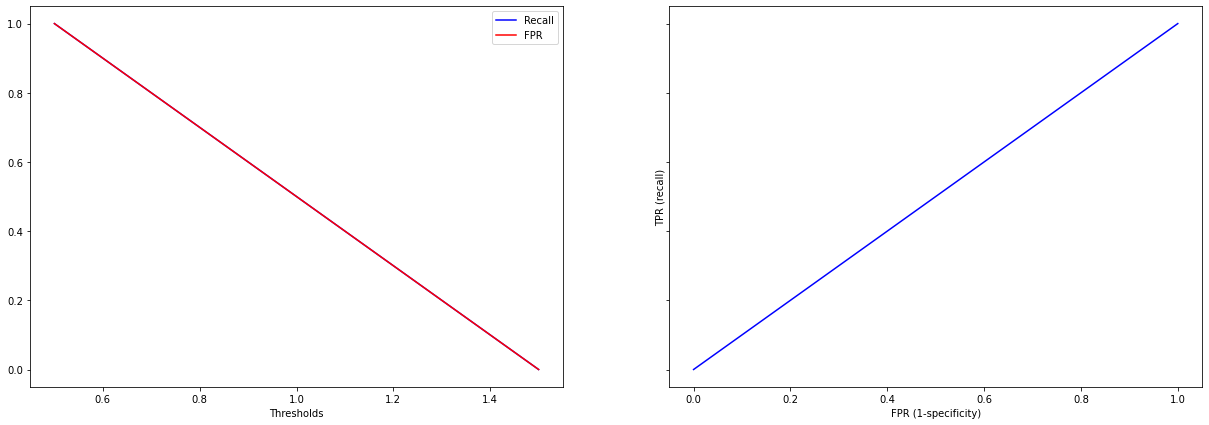

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500229     0.0        0.0          1.0  0.0      0.5
Validation  0.497927     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000121     0.0        0.0          0.0  0.0      0.0
Validation  0.001092     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


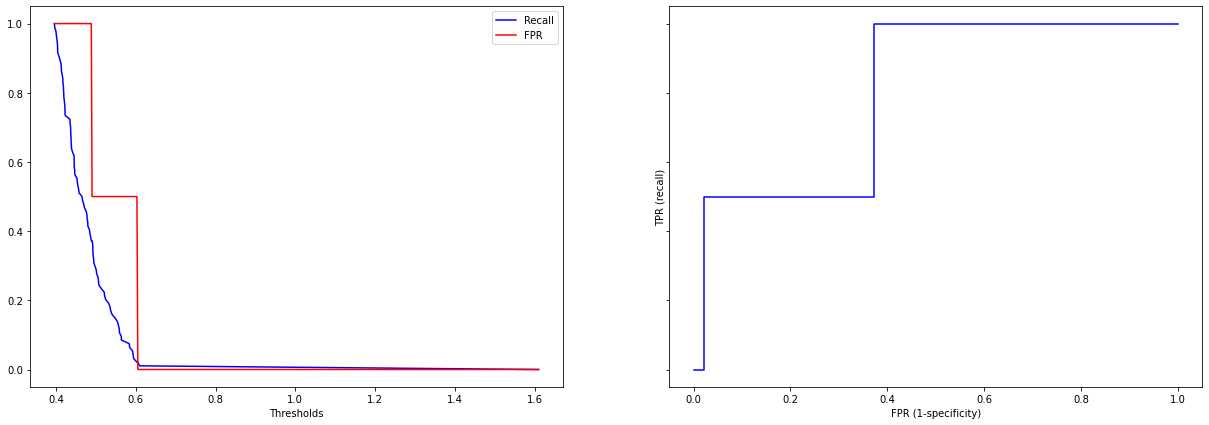

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663493  0.571053   0.700763     0.755849  0.628878  0.720647
Validation  0.654072  0.567225   0.690230     0.741667  0.621818  0.699471

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006541  0.024613   0.012164     0.021856  0.012569  0.008137
Validation  0.031565  0.043147   0.040208     0.047558  0.034685  0.037711

XGBoost Classifier
╠■■■■■■■■■╣


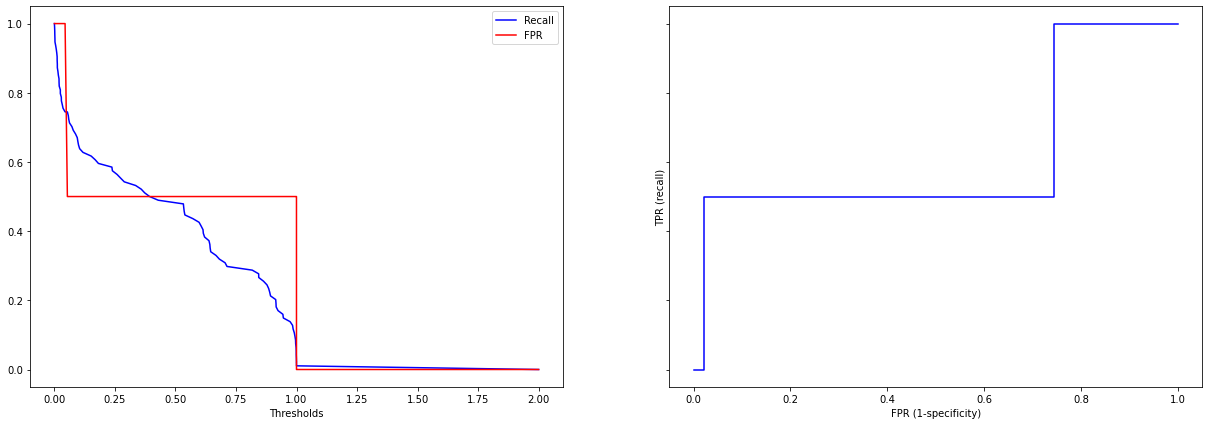

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999426  0.999082   0.999771     0.999771  0.999426  0.999999
Validation  0.626055  0.607496   0.634434     0.644792  0.620271  0.682910

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000270  0.000484   0.000484     0.000484  0.000270  8.231156e-07
Validation  0.052825  0.047395   0.056266     0.068121  0.049152  5.452843e-02

SVM
╠■■■■■■■■■╣


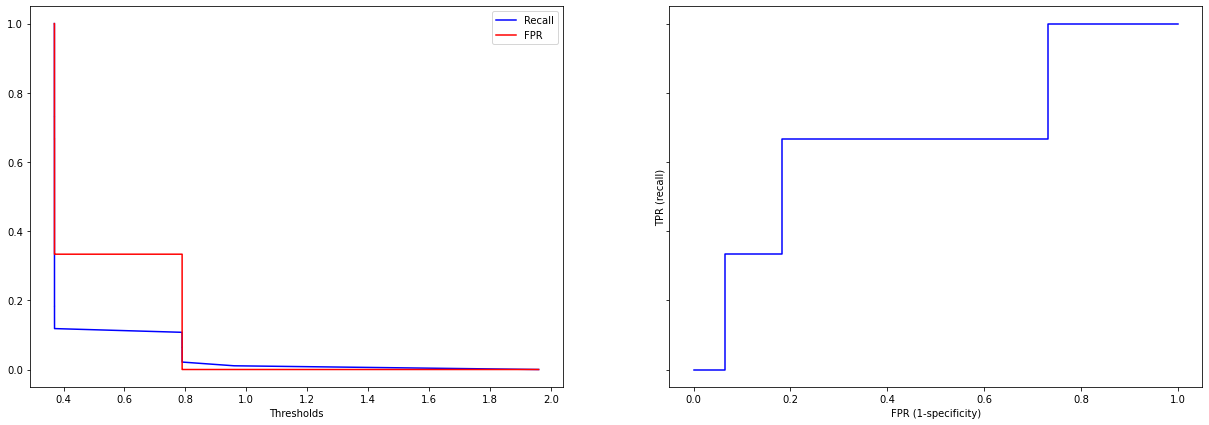

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.667051  0.476821   0.769467     0.857110  0.588445  0.736270
Validation  0.661842  0.479381   0.757547     0.845833  0.586101  0.732635

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010027  0.023407   0.013696     0.012886  0.018591  0.008296
Validation  0.031075  0.055132   0.035865     0.023956  0.047920  0.026012

KNN
╠■■■■■■■■■╣


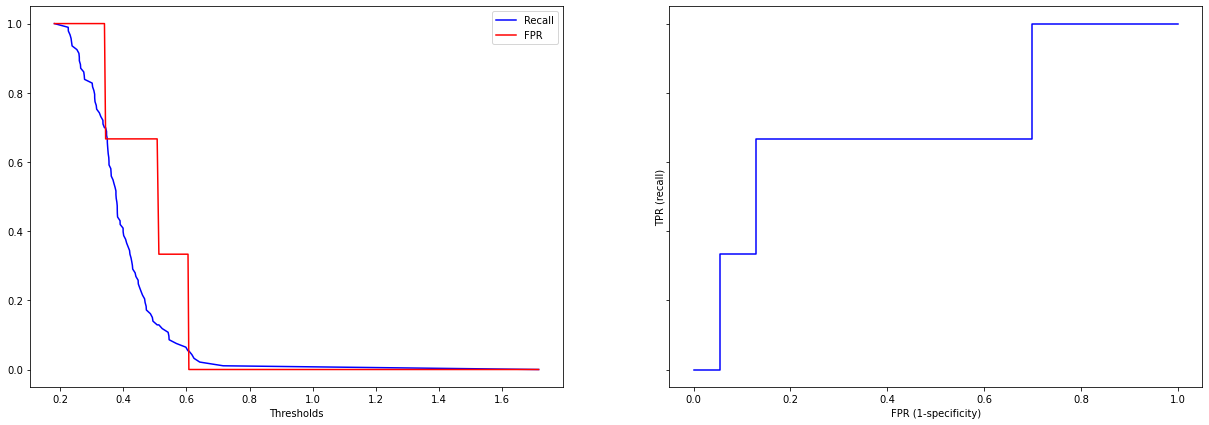

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999426  0.998852   1.000000     1.000000  0.999425  0.999999
Validation  0.600108  0.331594   0.721804     0.870833  0.453214  0.669253

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000662  0.001326   0.000000      0.00000  0.000664  0.000003
Validation  0.020136  0.040537   0.036797      0.02465  0.041635  0.014279

Logistic Regression
╠■■■■■■■■■╣


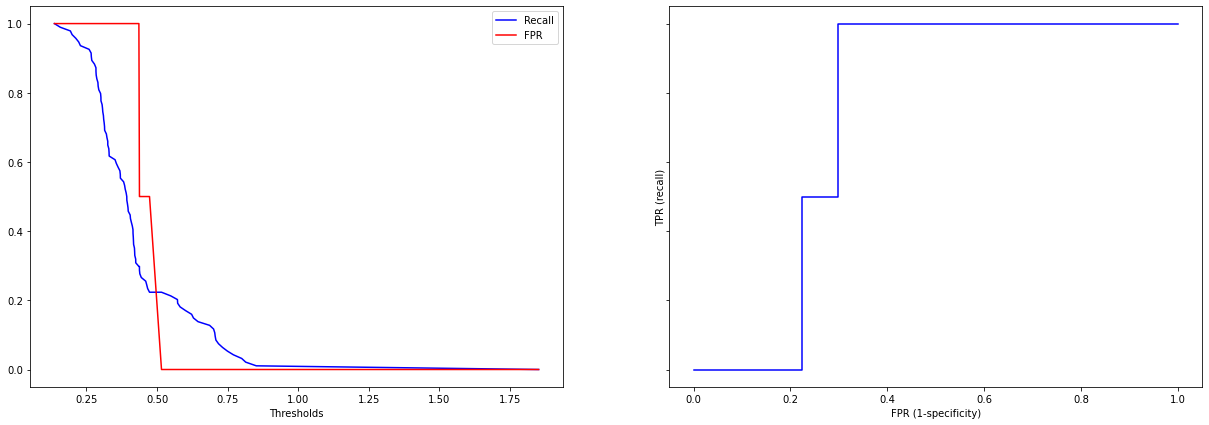

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688274  0.562210   0.751566     0.814220  0.643147  0.745267
Validation  0.681040  0.565131   0.739285     0.797917  0.639325  0.726791

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005664  0.012401   0.008670     0.009997  0.008431  0.007157
Validation  0.039573  0.058588   0.049496     0.047912  0.048416  0.037659

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.497927  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.654072  0.567225   0.690230     0.741667   
XGBoost Classifier              0.626055  0.607496   0.634434     0.644792   
SVM                             0.661842  0.479381   0.757547     0.845833   
KNN                             0.600108  0.331594   0.721804     0.870833   
Logistic Regression             0.681040  0.565131   0.739285     0.797917   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.621818  0.699471  
XGBoost Classifier              0.620271  0.682910  
SVM                             0.586101  0.732635  
KNN                             0.453214  0.669253  
Logistic Regression             0.639325  0.726791

Accuracy  \
Dummy Random                    0.4972366148531952-0.4986183074265976   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6341085313345552-0.6740358987172582   
XGBoost Classifier               0.592645843246916-0.6594644762694916   
SVM                             0.6421881360364244-0.6814949382295515   
KNN                             0.5873725903261893-0.6128432991384047   
Logistic Regression             0.6560114816211391-0.7060675339229021   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.5399366744413349-0.594513497379971   
XGBoost Classifier                0.5775207203698852-0.637470688564823   
SVM                              0.4445128026601542-0.5142500839377842   
KNN                             0.30595561728184695-0.3572316679415206   
Logistic Regression               0.5280767327047938-0.602185294786615   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6648004447662581-0.7156598995244816   
XGBoost Classifier              0.5988475770223752-0.6700195436382378   
SVM                              0.7348641453535326-0.780229931659787   
KNN                              0.6985316640030359-0.745076487771015   
Logistic Regression             0.7079815578441836-0.7705890969896315   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.711588322461517-0.7717450108718164   
XGBoost Classifier              0.6017081184187608-0.6878752149145725   
SVM                             0.8306823442852282-0.8609843223814386   
KNN                             0.8552430942217751-0.8864235724448913   
Logistic Regression             0.7676146885704563-0.8282186447628769   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5998813931320665-0.6437542046023869   
XGBoost Classifier               0.5891839925568496-0.6513570438682721   
SVM                               0.5557935211365462-0.616408595916022   
KNN                             0.4268814585609399-0.47954637181065135   
Logistic Regression              0.6087040712414941-0.6699461859163728   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6756198656045851-0.7233214645786912  
XGBoost Classifier              0.6484233468768218-0.7173969656231783  
SVM                             0.7161829677839346-0.7490860846931557  
KNN                             0.6602226804290254-0.6782840850348919  
Logistic Regression             0.7029737072245223-0.7506090354730721

In [37]:
#r_symptoms_svitals
run_models(r_symptoms_svitals, y[r_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

It seems the vitals do hold certain importance compared to the reported symptoms. Surprisingly, <b>sats</b> is on the list of high importance, however this might be due to the vitals not being standardized. Again there is an improvement, with a little sacrifice in specificity. <b>XGB</b> and <b>KNN</b> however performed slightly worse.

Dummy Random
╠■■■■■■■■■╣


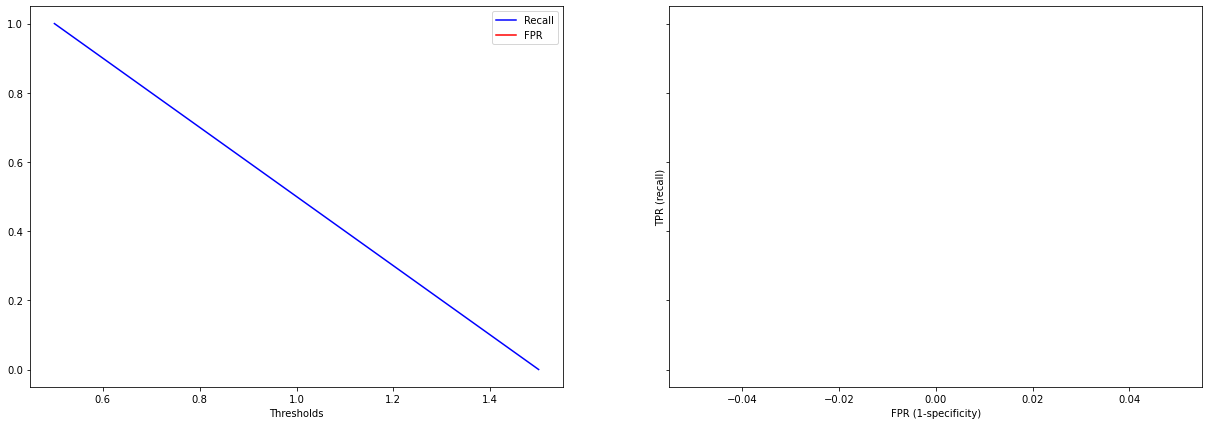

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


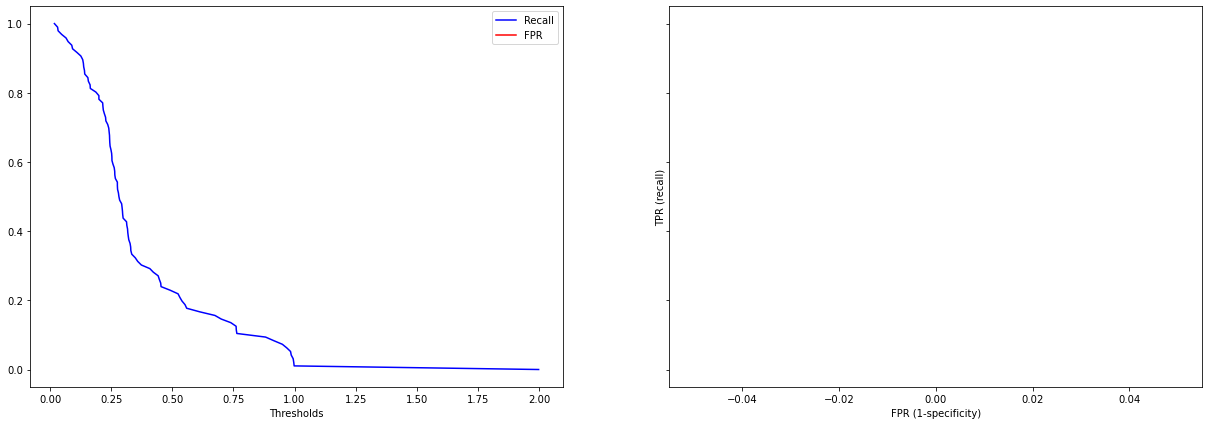

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.664172  0.532873   0.722602     0.795397  0.613294  0.711505
Validation  0.653022  0.528630   0.707894     0.778125  0.603350  0.703724

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006213  0.012234   0.010317     0.012188  0.008649  0.005511
Validation  0.025681  0.051963   0.040295     0.049117  0.036350  0.025616

Random Forest (100 estimators)
╠■■■■■■■■■╣


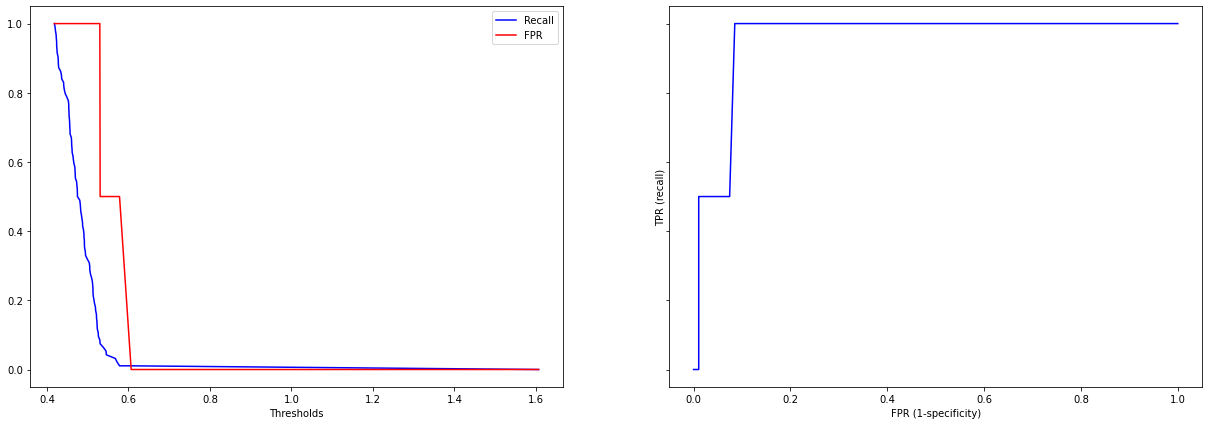

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.661640  0.569140   0.698561     0.754085  0.626869  0.722210
Validation  0.662875  0.552395   0.713930     0.773958  0.621473  0.713448

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009643  0.024741    0.01470     0.022029  0.014590  0.010399
Validation  0.034737  0.043162    0.05284     0.062510  0.035862  0.036375

XGBoost Classifier
╠■■■■■■■■■╣


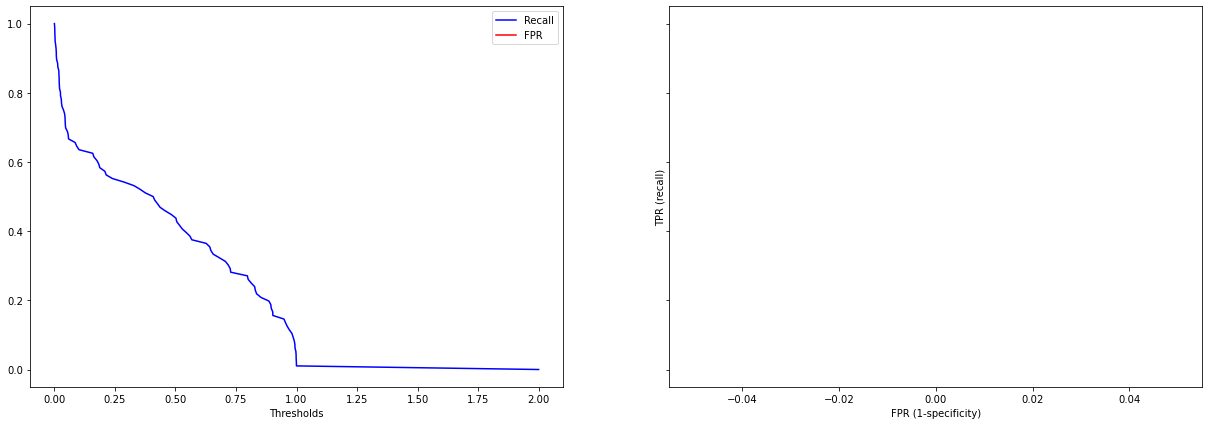

feature_importances


Permutation Importance



Mean metrics


Accuracy   Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999942  1.00000   0.999885     0.999885  0.999942  1.000000
Validation  0.634275  0.63416   0.636304     0.634375  0.634794  0.682657

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000182  0.000000   0.000364     0.000364  0.000182  2.096189e-07
Validation  0.023948  0.029453   0.028086     0.043493  0.022711  1.868870e-02

SVM
╠■■■■■■■■■╣


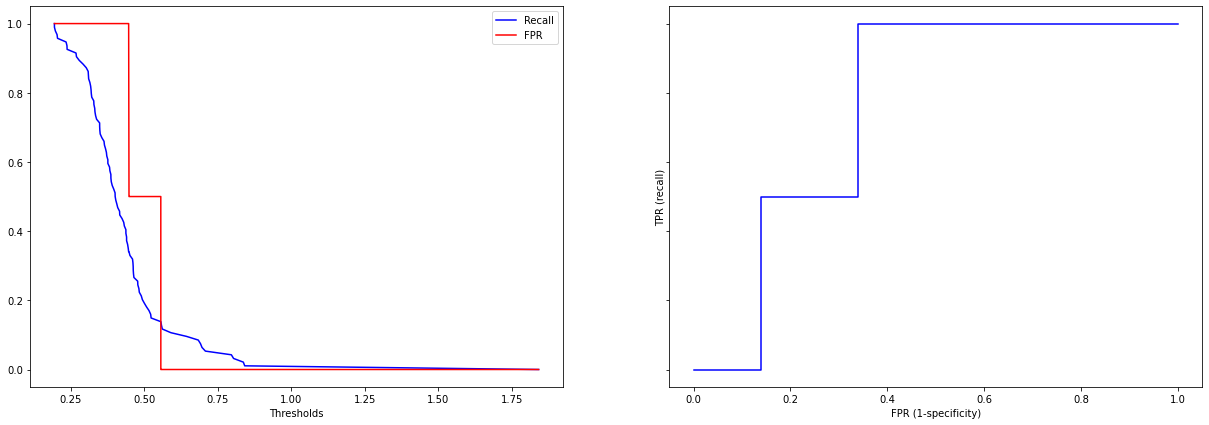

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.678446  0.499595   0.778280     0.857192  0.608185  0.749071
Validation  0.676371  0.495447   0.778906     0.858333  0.604549  0.728503

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005076  0.018014   0.016085     0.017889  0.010385  0.003741
Validation  0.037427  0.055307   0.053813     0.037461  0.051021  0.028241

KNN
╠■■■■■■■■■╣


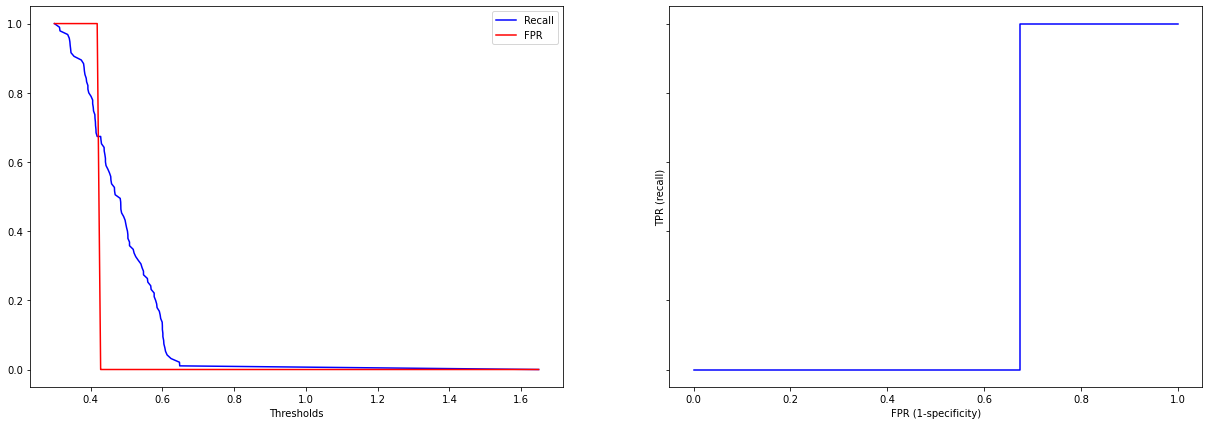

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999655  0.999309   1.000000     1.000000  0.999654  0.999999
Validation  0.574582  0.466312   0.600214     0.683333  0.523110  0.607043

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000402  0.000805   0.000000     0.000000  0.000403  8.139419e-07
Validation  0.033459  0.047295   0.050928     0.072202  0.035118  5.979076e-02

Logistic Regression
╠■■■■■■■■■╣


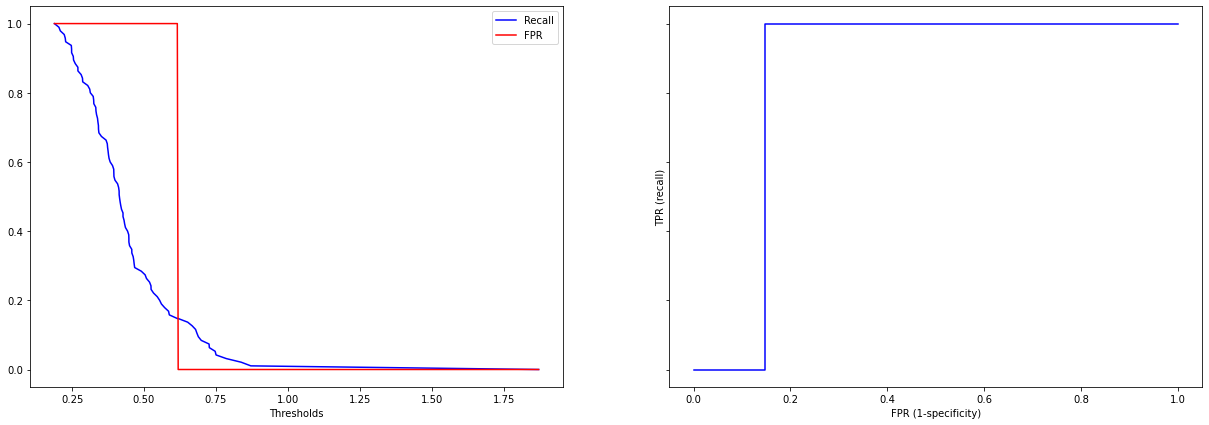

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682130  0.562809   0.739504     0.801381  0.639019  0.737835
Validation  0.667042  0.556594   0.717055     0.778125  0.625273  0.728836

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008283  0.008498   0.017073     0.019485  0.006480  0.007202
Validation  0.039289  0.061715   0.047870     0.050089  0.049211  0.027695

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.653022  0.528630   0.707894     0.778125   
Random Forest (100 estimators)  0.662875  0.552395   0.713930     0.773958   
XGBoost Classifier              0.634275  0.634160   0.636304     0.634375   
SVM                             0.676371  0.495447   0.778906     0.858333   
KNN                             0.574582  0.466312   0.600214     0.683333   
Logistic Regression             0.667042  0.556594   0.717055     0.778125   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.603350  0.703724  
Random Forest (100 estimators)  0.621473  0.713448  
XGBoost Classifier              0.634794  0.682657  
SVM                             0.604549  0.728503  
KNN                             0.523110  0.607043  
Logistic Regression             0.625273  0.728836

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                    0.6367806753418754-0.6692642296667601   
Random Forest (100 estimators)   0.6409054240632184-0.6848447918262461   
XGBoost Classifier               0.6191293942086116-0.6494209080366389   
SVM                              0.6527001770682115-0.7000416191321339   
KNN                              0.5534201380478494-0.5957432902768482   
Logistic Regression              0.6421933332682803-0.6918902159545177   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                   0.49576545037288766-0.5614939997989337   
Random Forest (100 estimators)   0.5250969874514312-0.5796925314489124   
XGBoost Classifier               0.6155324020022381-0.6527880447331569   
SVM                             0.46046756659807137-0.5304259041923067   
KNN                              0.4364001025611272-0.4962244678856082   
Logistic Regression              0.5175613355636343-0.5956259496597335   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6824096059849809-0.7333787106714718   
Random Forest (100 estimators)  0.6805110366763923-0.7473485291706553   
XGBoost Classifier               0.6185407585432202-0.654067477484798   
SVM                             0.7448717113133314-0.8129409513887422   
KNN                              0.5680044004252697-0.632423275128115   
Logistic Regression             0.6867787370828016-0.7473304414437503   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                    0.747060737157854-0.8091892628421459   
Random Forest (100 estimators)   0.7344237629791937-0.813492903687473   
XGBoost Classifier              0.6068676356661968-0.6618823643338034   
SVM                             0.8346406637371776-0.8820260029294887   
KNN                              0.6376686604922954-0.728998006174371   
Logistic Regression              0.746445847977897-0.8098041520221029   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5803605177983527-0.6263399724571342   
Random Forest (100 estimators)  0.5987914377618688-0.6441538580583759   
XGBoost Classifier               0.620430575722882-0.6491582865712081   
SVM                             0.5722810020370274-0.6368178303548121   
KNN                              0.500899313343829-0.5453207361672371   
Logistic Regression             0.5941492146452438-0.6563972954771746   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                    0.6875229076137761-0.719925143288286  
Random Forest (100 estimators)  0.6904421983826942-0.7364535409858625  
XGBoost Classifier              0.6708371268415557-0.6944766707672644  
SVM                             0.7106417350460353-0.7463638983660493  
KNN                             0.5692277761753409-0.6448577675675001  
Logistic Regression             0.7113200650368993-0.7463523827007869

In [38]:
#ra_symptoms_vitals
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


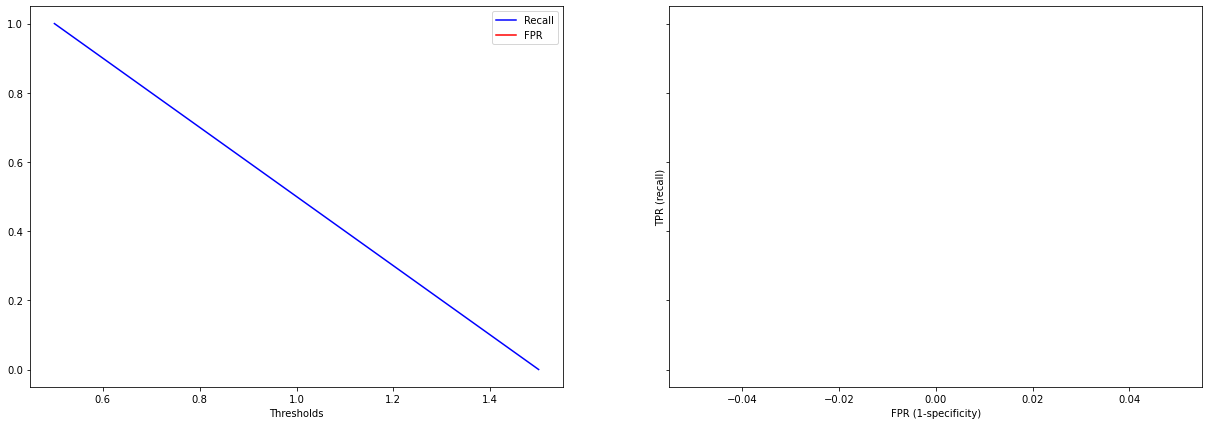

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


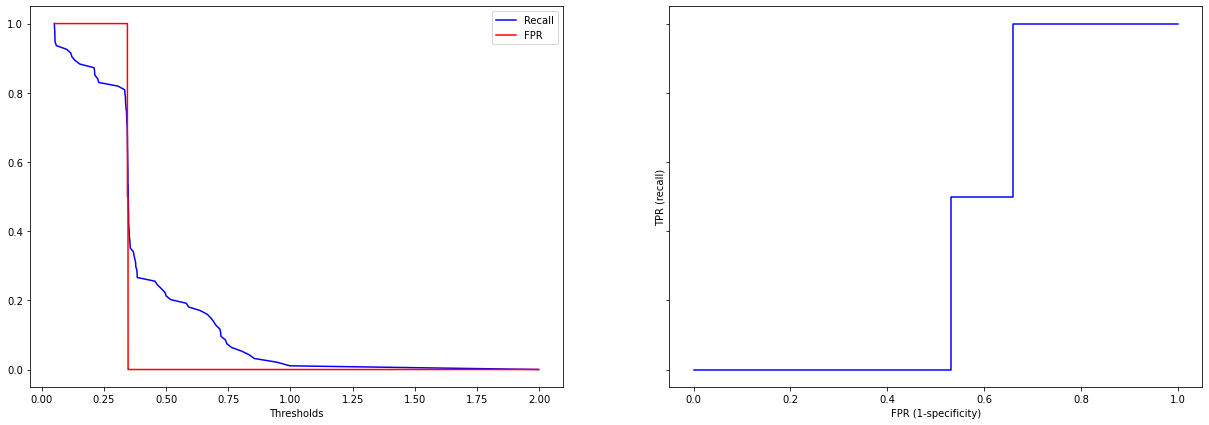

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.649210  0.497412   0.714081     0.800921  0.586350  0.684671
Validation  0.654574  0.500612   0.723603     0.809375  0.591273  0.682520

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008210  0.009496   0.011944     0.009238  0.009959  0.013408
Validation  0.042501  0.059966   0.052209     0.031076  0.058024  0.044474

Random Forest (100 estimators)
╠■■■■■■■■■╣


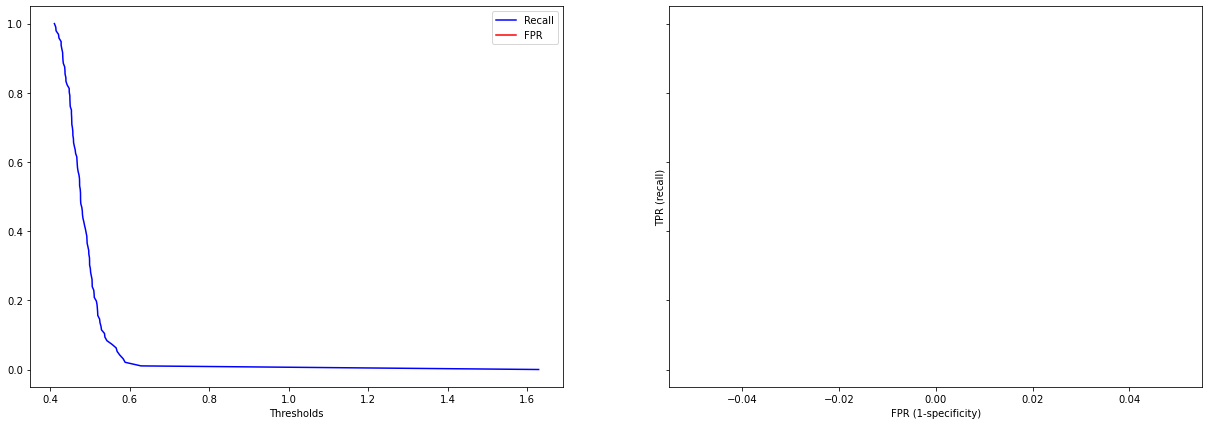

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663368  0.582845   0.695058     0.743843  0.633781  0.727695
Validation  0.651430  0.577234   0.680814     0.726042  0.623575  0.712062

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008905  0.015380   0.016112     0.022927  0.008811  0.007776
Validation  0.032129  0.049908   0.042186     0.053578  0.037159  0.026770

XGBoost Classifier
╠■■■■■■■■■╣


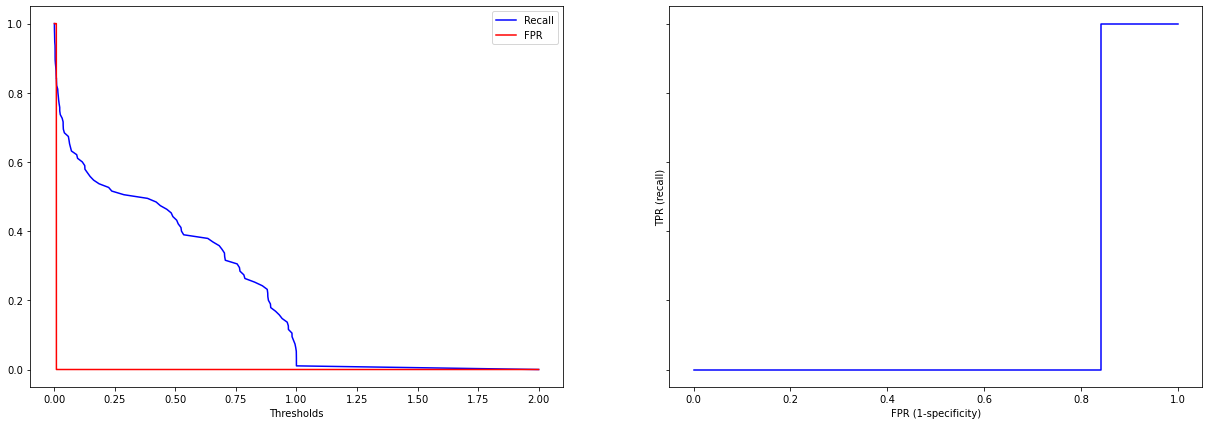

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999655  0.999424   0.999885     0.999885  0.999654  0.999999
Validation  0.638992  0.614594   0.647624     0.663542  0.630144  0.689767

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000619  0.000979   0.000364     0.000364  0.000619  0.000002
Validation  0.028024  0.044075   0.029229     0.036434  0.032268  0.032802

SVM
╠■■■■■■■■■╣


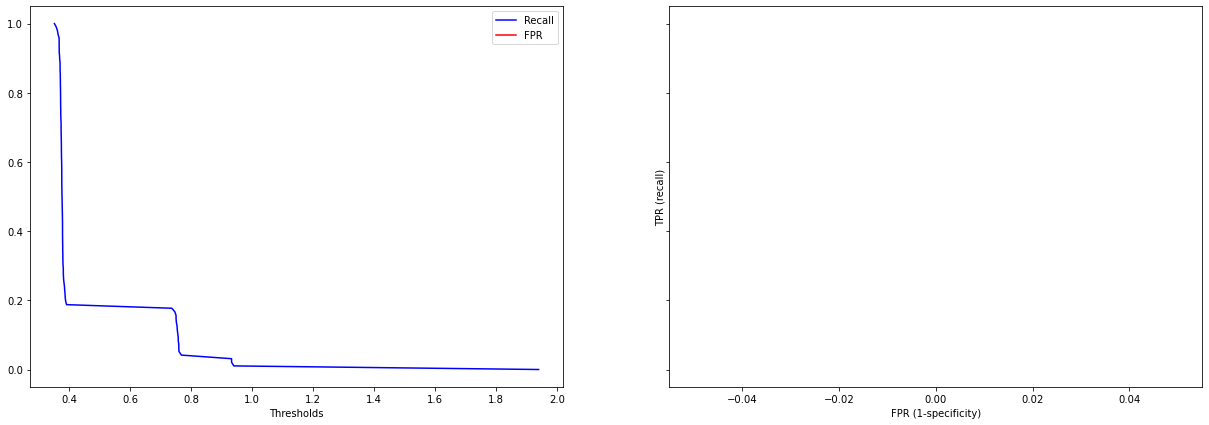

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.666072  0.469885   0.774484     0.862140  0.584157  0.744056
Validation  0.660279  0.466484   0.764596     0.855208  0.577796  0.728148

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002077  0.023837   0.021284     0.021947  0.013615  0.005608
Validation  0.031191  0.057439   0.041859     0.031993  0.048888  0.039319

KNN
╠■■■■■■■■■╣


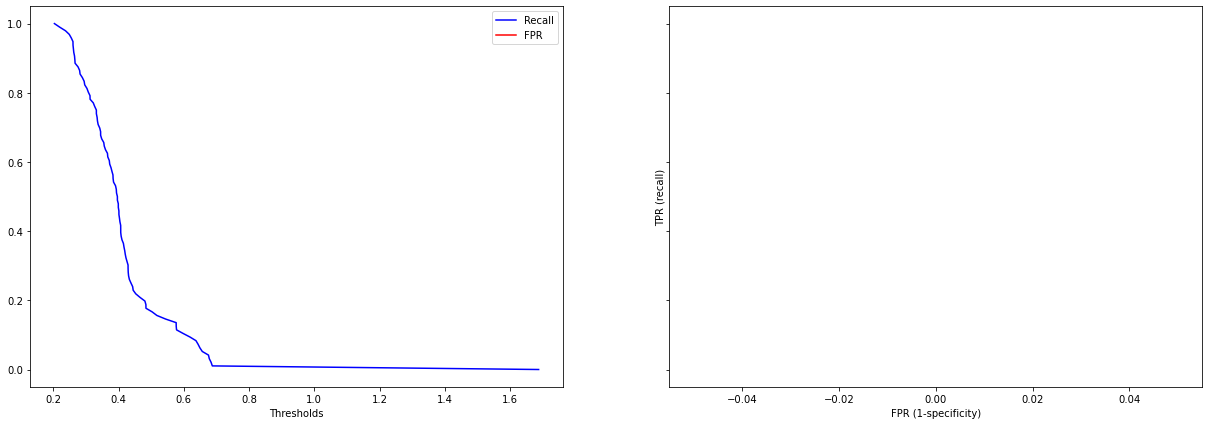

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999712  0.999424   1.000000     1.000000  0.999712  1.000000
Validation  0.649385  0.481959   0.727494     0.817708  0.578309  0.704048

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000303  0.000607   0.000000     0.000000  0.000304  3.492042e-07
Validation  0.024463  0.050991   0.033078     0.033032  0.040677  2.935156e-02

Logistic Regression
╠■■■■■■■■■╣


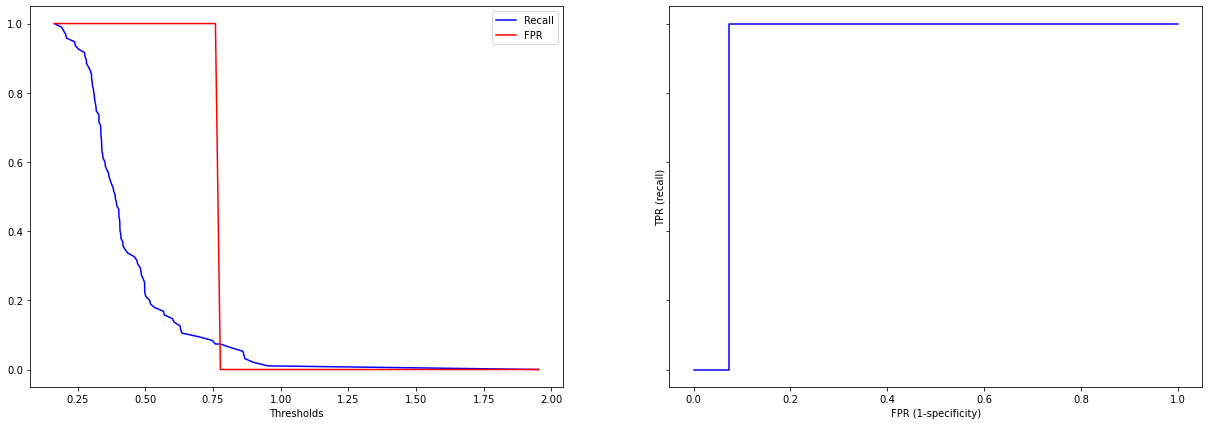

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688231  0.554752   0.756795     0.821634  0.640117  0.751645
Validation  0.675845  0.545135   0.738950     0.807292  0.626365  0.732140

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007004  0.010670   0.012705     0.012814  0.008283  0.006371
Validation  0.040976  0.065357   0.046275     0.033754  0.055219  0.037271

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.654574  0.500612   0.723603     0.809375   
Random Forest (100 estimators)  0.651430  0.577234   0.680814     0.726042   
XGBoost Classifier              0.638992  0.614594   0.647624     0.663542   
SVM                             0.660279  0.466484   0.764596     0.855208   
KNN                             0.649385  0.481959   0.727494     0.817708   
Logistic Regression             0.675845  0.545135   0.738950     0.807292   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.591273  0.682520  
Random Forest (100 estimators)  0.623575  0.712062  
XGBoost Classifier              0.630144  0.689767  
SVM                             0.577796  0.728148  
KNN                             0.578309  0.704048  
Logistic Regression             0.626365  0.732140

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                    0.6276939515520324-0.6814543645101437   
Random Forest (100 estimators)   0.6311098726227036-0.6717506627831686   
XGBoost Classifier               0.6212686928202913-0.6567159790277226   
SVM                              0.6405522065453362-0.6800058677206398   
KNN                              0.6339129752115589-0.6648564548402547   
Logistic Regression              0.6499294419550196-0.7017598931054295   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                    0.4626861838385519-0.5385380429655717   
Random Forest (100 estimators)   0.5456693573006836-0.6087979966512066   
XGBoost Classifier               0.5867187193310207-0.6424694249988762   
SVM                              0.4301563895196498-0.5028118235387694   
KNN                             0.44970943190503265-0.5142080938681631   
Logistic Regression              0.5037996995870955-0.5864709189696058   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                     0.690583238347642-0.756623191512128   
Random Forest (100 estimators)  0.6541331698873699-0.7074944815456549   
XGBoost Classifier              0.6291375631376974-0.6661102362774682   
SVM                              0.7381222743104572-0.791070314786881   
KNN                              0.706573746504505-0.7484143784220636   
Logistic Regression             0.7096829130805289-0.7682171349557094   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7897208726415487-0.8290291273584512   
Random Forest (100 estimators)   0.692155908614567-0.7599274247187662   
XGBoost Classifier               0.6404990833013374-0.686584250031996   
SVM                             0.8349738857162036-0.8754427809504631   
KNN                             0.7968172097826509-0.8385994568840156   
Logistic Regression             0.7859438525709175-0.8286394807624158   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                    0.5545760006005599-0.627970817169644   
Random Forest (100 estimators)  0.6000733131568182-0.6470758895065153   
XGBoost Classifier              0.6097355953304093-0.6505523073342008   
SVM                             0.5468765719368351-0.6087161226956426   
KNN                             0.5525824120019153-0.6040357570234175   
Logistic Regression             0.5914420208735072-0.6612889484969158   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                     0.654392563318064-0.710647841535888  
Random Forest (100 estimators)  0.6951315357593992-0.7289930257383097  
XGBoost Classifier               0.669021755186066-0.7105129401890771  
SVM                             0.7032802532044873-0.7530156105555357  
KNN                             0.6854848741430576-0.7226119811690844  
Logistic Regression             0.7085674669744199-0.7557118231888104

In [39]:
#ra_symptoms_nvitals
run_models(ra_symptoms_nvitals, y[ra_symptoms_nvitals.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


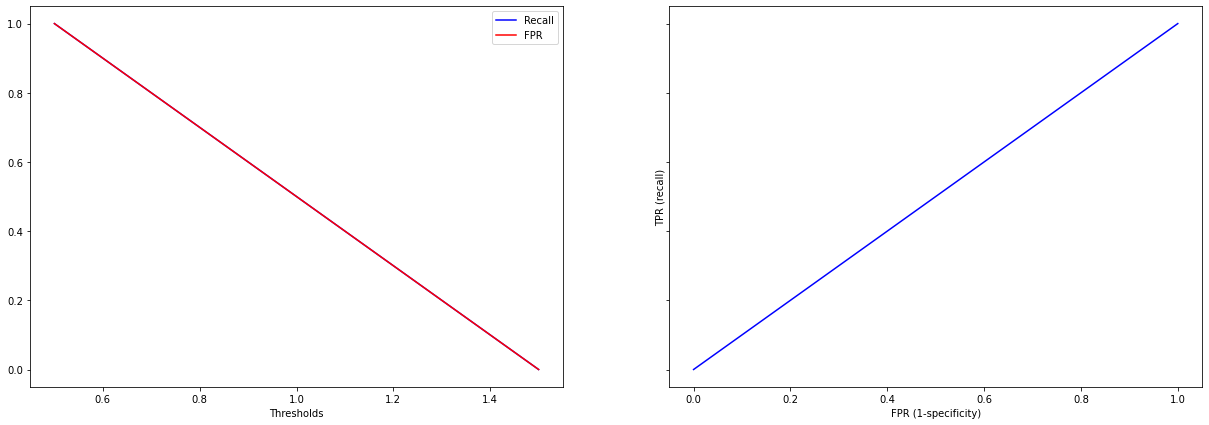

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


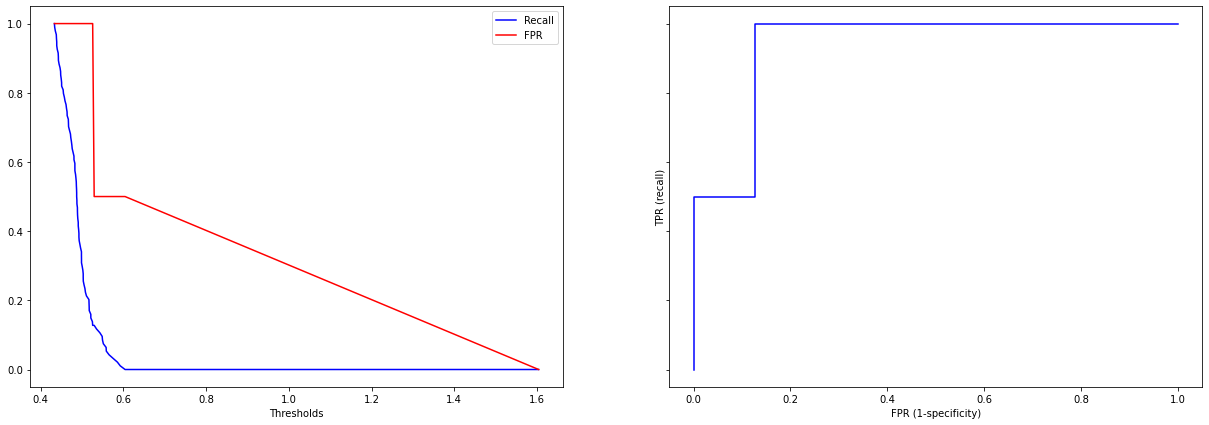

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663597  0.578925   0.697119     0.748216  0.632307  0.727095
Validation  0.664394  0.569974   0.706404     0.759375  0.629567  0.714103

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007729  0.018308   0.013049     0.019565  0.010501  0.006003
Validation  0.026377  0.044059   0.042317     0.050901  0.030805  0.034515

XGBoost Classifier
╠■■■■■■■■■╣


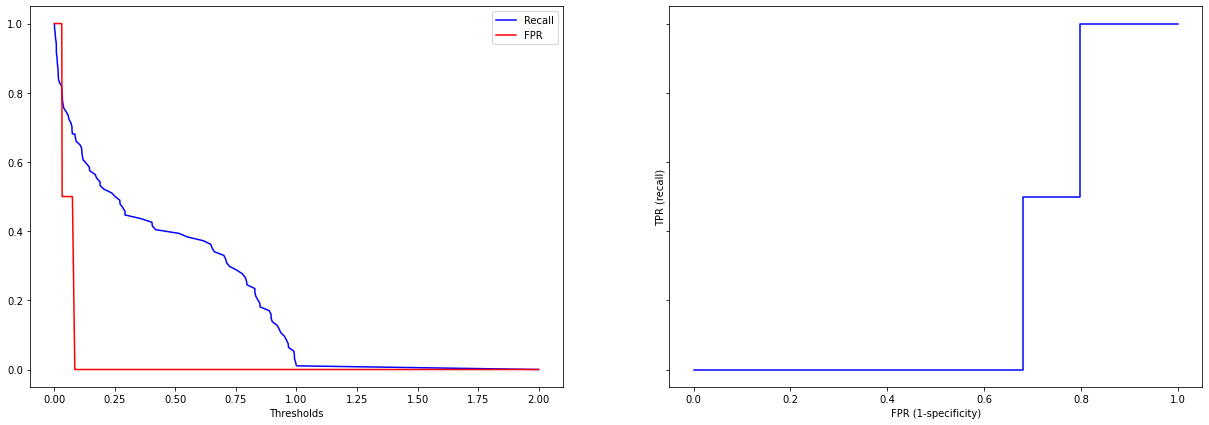

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999827  0.999770   0.999885     0.999885  0.999827  1.000000
Validation  0.639513  0.625956   0.645191     0.653125  0.635314  0.697299

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000278  0.000485   0.000364     0.000364  0.000278  3.200755e-07
Validation  0.032096  0.027477   0.034563     0.041391  0.029829  2.904421e-02

SVM
╠■■■■■■■■■╣


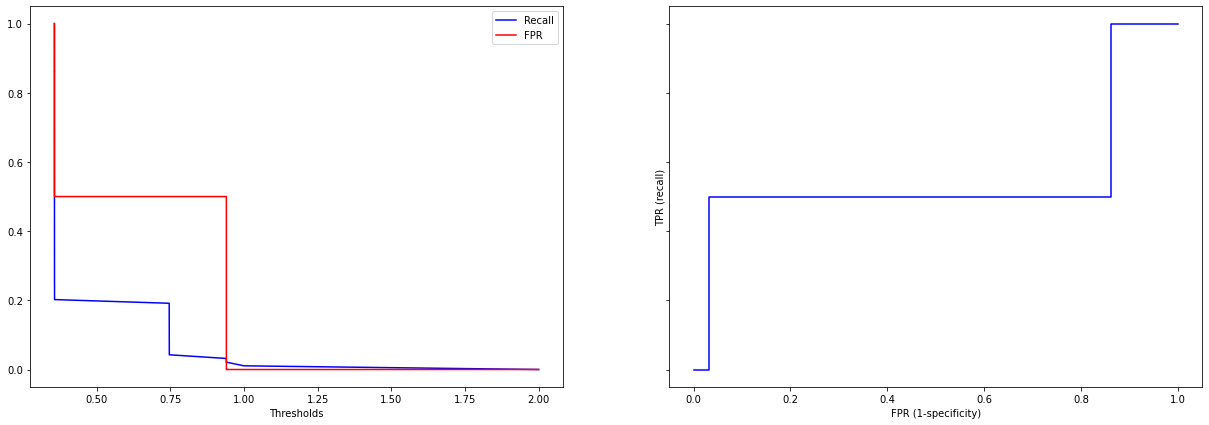

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.670848  0.485778   0.771108     0.855811  0.595985  0.744666
Validation  0.670159  0.485116   0.773977     0.856250  0.594977  0.735394

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004221  0.009730   0.007744     0.007339  0.007255  0.007676
Validation  0.036629  0.054322   0.058682     0.041898  0.049105  0.035723

KNN
╠■■■■■■■■■╣


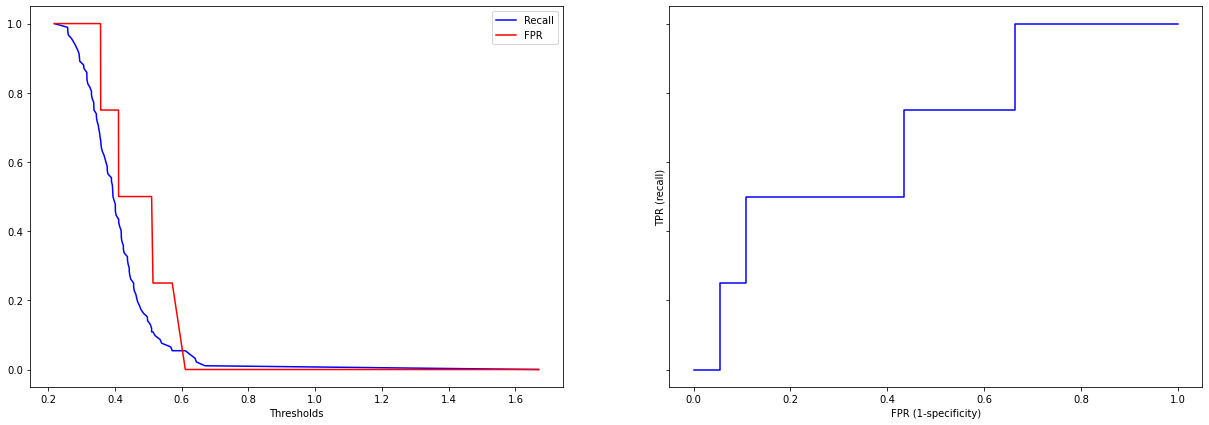

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.999712  0.999424   1.000000     1.000000  0.999712  1.00000
Validation  0.616621  0.394770   0.713797     0.839583  0.505328  0.67758

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000407  0.000814   0.000000     0.000000  0.000408  8.296551e-07
Validation  0.031328  0.068090   0.057286     0.045591  0.060471  2.070321e-02

Logistic Regression
╠■■■■■■■■■╣


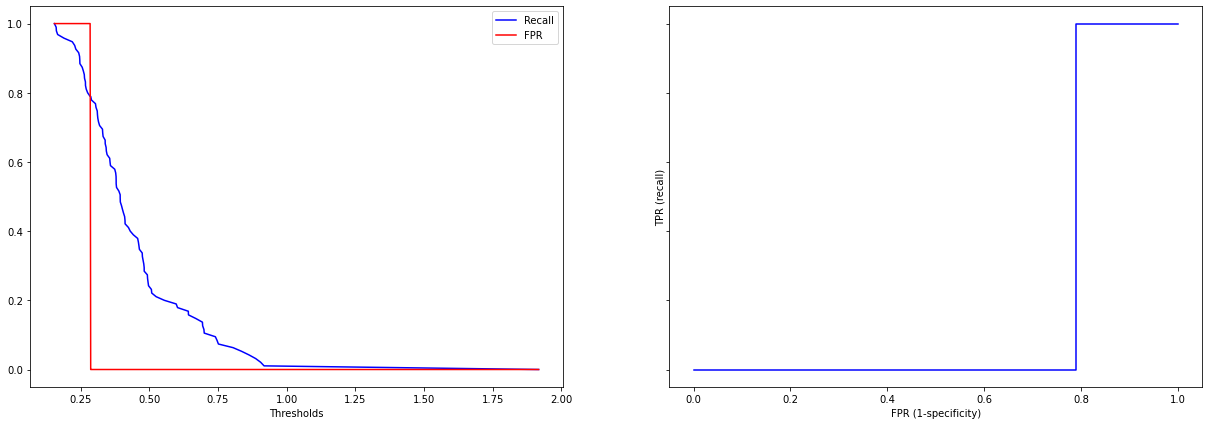

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692891  0.586644   0.744918     0.799079  0.656302  0.754047
Validation  0.686213  0.570962   0.746808     0.802083  0.644640  0.745753

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007064  0.010128   0.011527     0.012313  0.008013  0.006390
Validation  0.020158  0.058119   0.040475     0.049105  0.033632  0.018257

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.664394  0.569974   0.706404     0.759375   
XGBoost Classifier              0.639513  0.625956   0.645191     0.653125   
SVM                             0.670159  0.485116   0.773977     0.856250   
KNN                             0.616621  0.394770   0.713797     0.839583   
Logistic Regression             0.686213  0.570962   0.746808     0.802083   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.629567  0.714103  
XGBoost Classifier              0.635314  0.697299  
SVM                             0.594977  0.735394  
KNN                             0.505328  0.677580  
Logistic Regression             0.644640  0.745753

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6477121879677206-0.6810766721359065   
XGBoost Classifier               0.6192136579338017-0.6598126805808786   
SVM                              0.6469923610146207-0.6933249964983326   
KNN                              0.5968070072246608-0.6364345730862201   
Logistic Regression               0.6734639777744369-0.698961540360278   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.542109011654333-0.5978394419539144   
XGBoost Classifier               0.6085776423286258-0.6433338696988657   
SVM                             0.45075981505277346-0.5194721437101132   
KNN                             0.3517062816349193-0.43783409637195353   
Logistic Regression              0.5342047503193526-0.6077196483060769   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6796399375079292-0.7331677140964614   
XGBoost Classifier              0.6233312344331926-0.6670507827144921   
SVM                             0.7368631682425375-0.8110907432044119   
KNN                             0.6775660012117817-0.7500275017843745   
Logistic Regression             0.7212091352980846-0.7724065719744334   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.7271824250375021-0.791567574962498   
XGBoost Classifier               0.6269471155208739-0.679302884479126   
SVM                             0.8297516888495292-0.8827483111504707   
KNN                             0.8107492507055185-0.8684174159611482   
Logistic Regression             0.7710268336458364-0.8331398330208304   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.610083720077289-0.6490499213034168   
XGBoost Classifier               0.6164487740699871-0.6541793320707854   
SVM                              0.5639207104550082-0.6260341440149529   
KNN                             0.46708246399958064-0.5435729765483949   
Logistic Regression              0.6233691784110873-0.6659110607346796   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6922743334954852-0.7359326619584096  
XGBoost Classifier              0.6789296775948062-0.7156680189258124  
SVM                             0.7128012311426418-0.7579873570589618  
KNN                             0.6644861477211512-0.6906738608699143  
Logistic Regression               0.73420600776962-0.7572998001484783

In [40]:
#ra_symptoms_svitals
run_models(ra_symptoms_svitals, y[ra_symptoms_svitals.index], models, ratio_negatives_to_positives=1)

All the features that were determined to be important before are also important here

Dummy Random
╠■■■■■■■■■╣


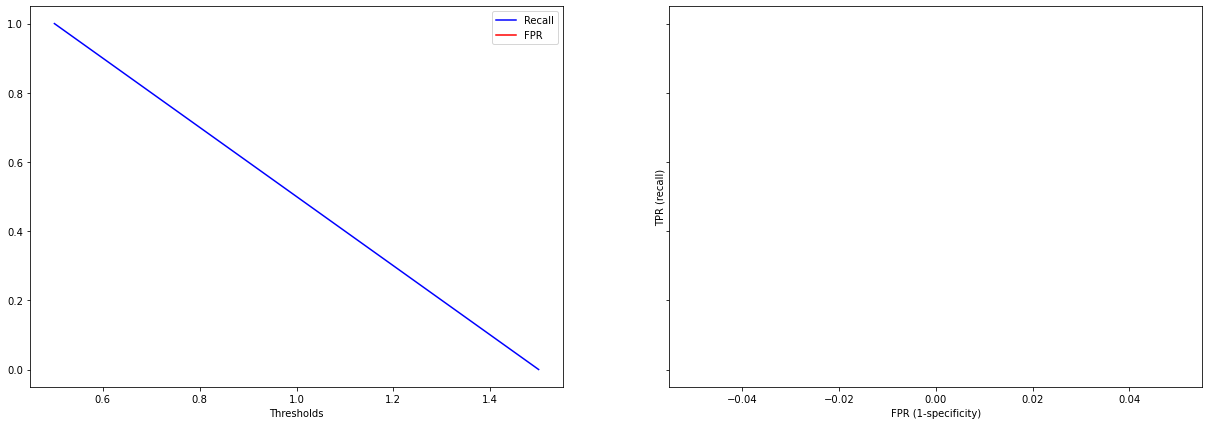

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
╠■■■■■■■■■╣


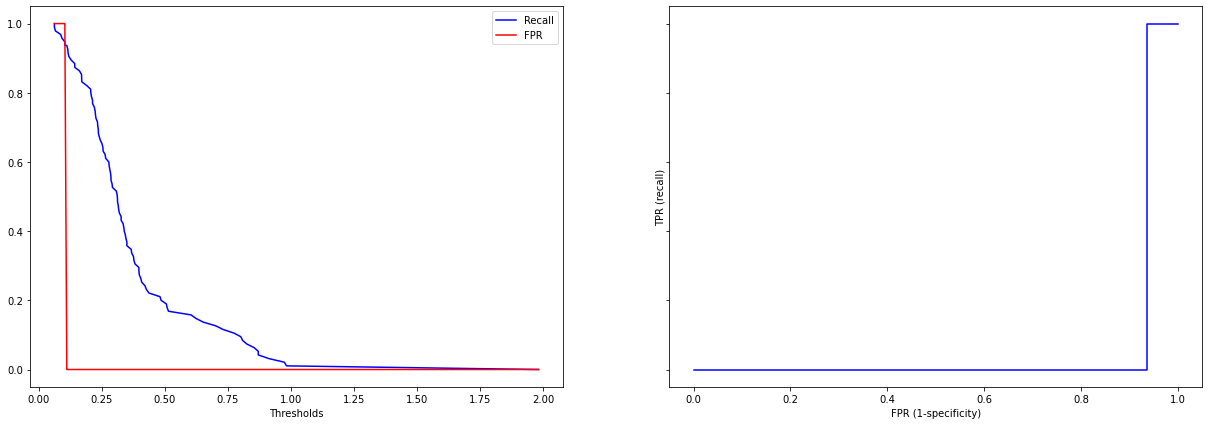

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.663887  0.546233   0.714833     0.781473  0.618950  0.715925
Validation  0.660805  0.551385   0.706184     0.770833  0.618424  0.704454

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011458  0.017495   0.021464     0.025150  0.012244  0.009850
Validation  0.034293  0.061425   0.030574     0.019642  0.048323  0.025474

Random Forest (100 estimators)
╠■■■■■■■■■╣


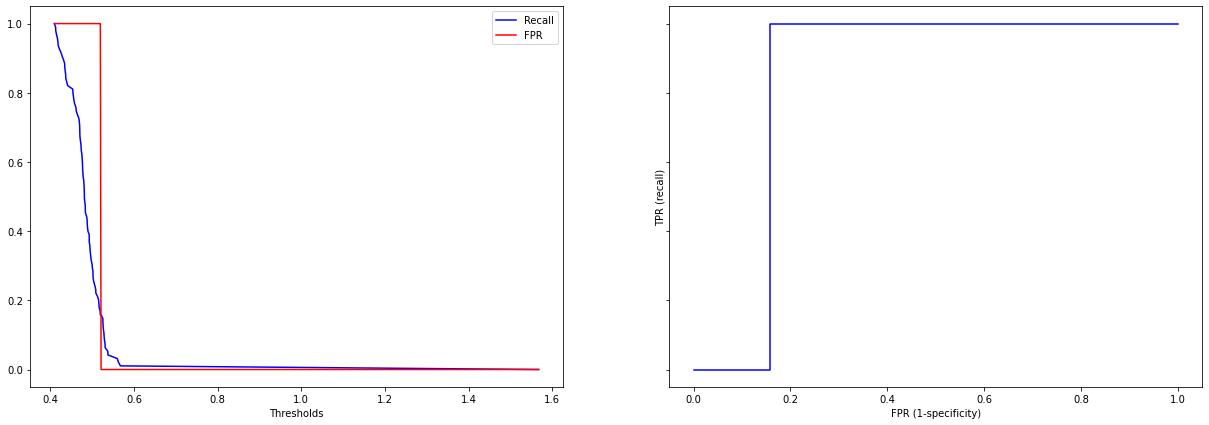

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669525  0.594818   0.699492     0.744189  0.642653  0.734609
Validation  0.658163  0.580294   0.689030     0.736458  0.629712  0.709713

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004117  0.018633   0.010140     0.018901  0.008283  0.006103
Validation  0.023772  0.031617   0.028435     0.029483  0.027362  0.030854

XGBoost Classifier
╠■■■■■■■■■╣


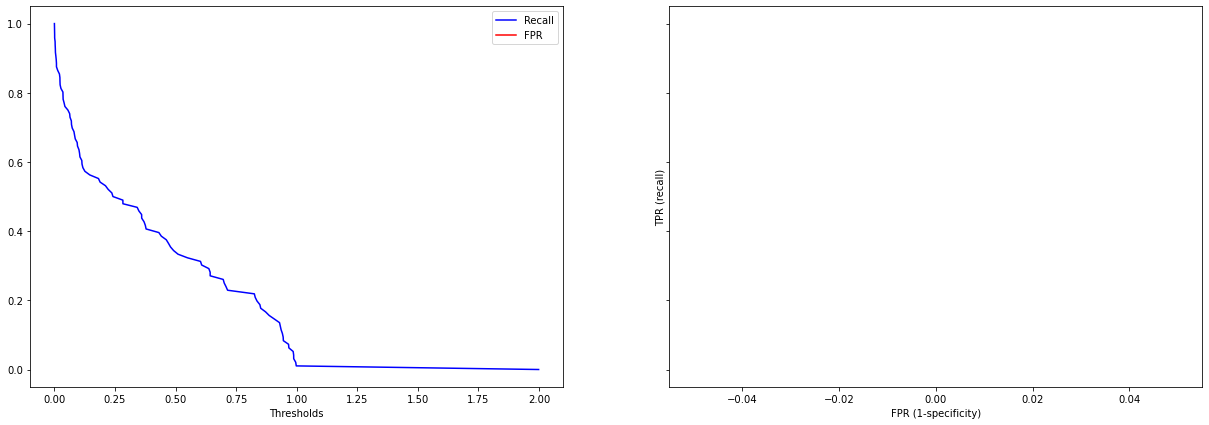

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999827  0.999885   0.999770     0.999770  0.999827  1.000000
Validation  0.639492  0.617590   0.647538     0.661458  0.631659  0.694245

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000389  0.000364   0.000485     0.000485  0.000389  8.413487e-07
Validation  0.023292  0.039306   0.025455     0.036168  0.027157  2.386725e-02

SVM
╠■■■■■■■■■╣


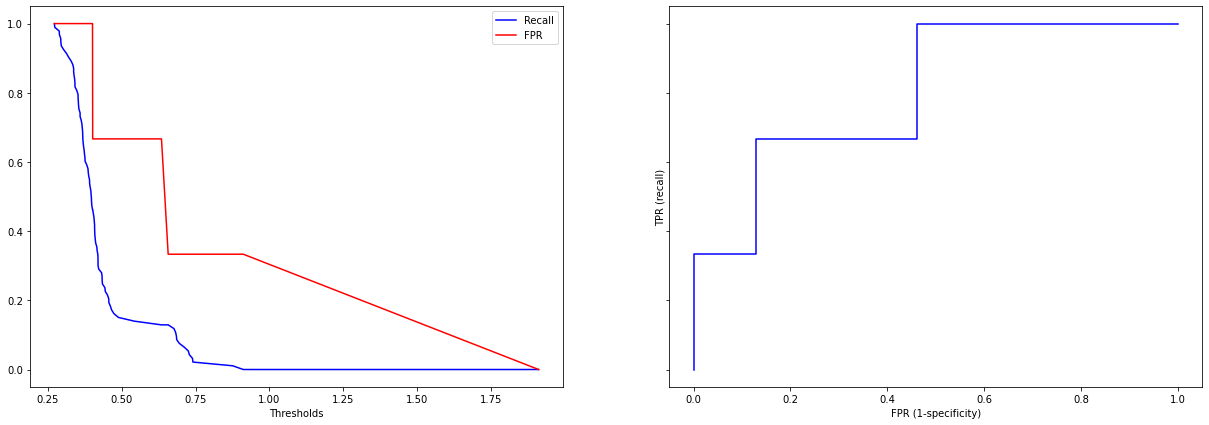

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683512  0.506628   0.784334     0.860299  0.615072  0.757682
Validation  0.672202  0.503630   0.764104     0.841667  0.605866  0.744979

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.011389  0.027869   0.018480     0.018620  0.020107  0.007965
Validation  0.023261  0.039241   0.044891     0.039832  0.030727  0.027637

KNN
╠■■■■■■■■■╣


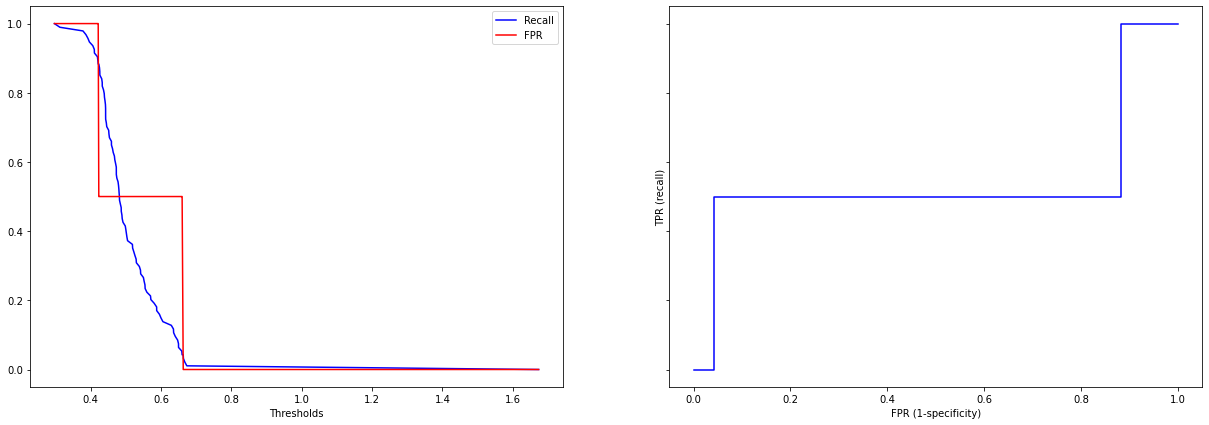

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999942  0.999885   1.000000     1.000000  0.999942  1.000000
Validation  0.550685  0.454983   0.566643     0.646875  0.503143  0.584126

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000182  0.000364   0.000000     0.000000  0.000182  2.093777e-07
Validation  0.023879  0.042853   0.035131     0.062971  0.026434  2.893147e-02

Logistic Regression
╠■■■■■■■■■╣


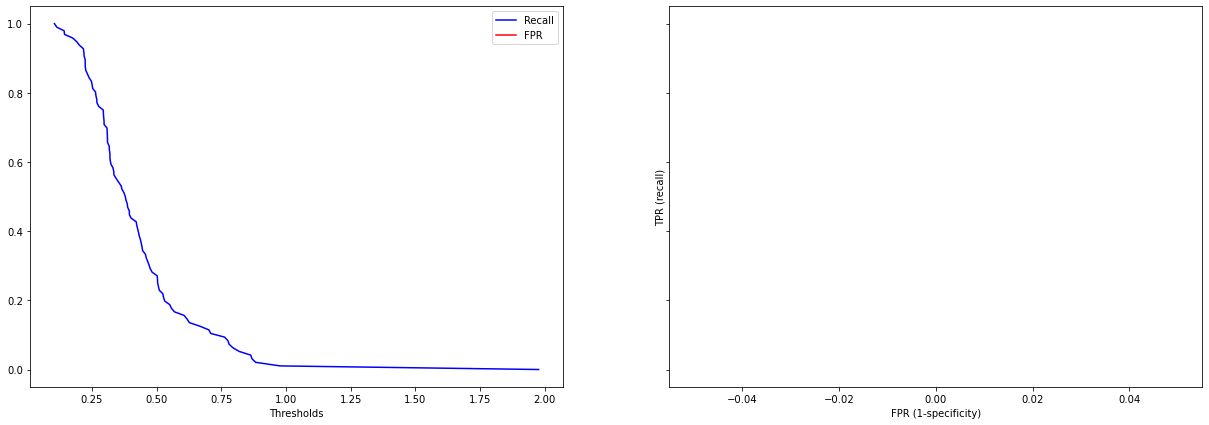

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689209  0.592978   0.734208     0.785386  0.655976  0.753874
Validation  0.663382  0.574087   0.699902     0.753125  0.629515  0.730192

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010581  0.016876   0.012795     0.012954  0.013311  0.007995
Validation  0.040303  0.068499   0.039950     0.038991  0.053034  0.036185

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.660805  0.551385   0.706184     0.770833   
Random Forest (100 estimators)  0.658163  0.580294   0.689030     0.736458   
XGBoost Classifier              0.639492  0.617590   0.647538     0.661458   
SVM                             0.672202  0.503630   0.764104     0.841667   
KNN                             0.550685  0.454983   0.566643     0.646875   
Logistic Regression             0.663382  0.574087   0.699902     0.753125   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.618424  0.704454  
Random Forest (100 estimators)  0.629712  0.709713  
XGBoost Classifier              0.631659  0.694245  
SVM                             0.605866  0.744979  
KNN                             0.503143  0.584126  
Logistic Regression             0.629515  0.730192

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                    0.6391165234225613-0.6824940119833109   
Random Forest (100 estimators)   0.6431284979029548-0.6731981428569762   
XGBoost Classifier               0.6247602857103959-0.6542228749113658   
SVM                               0.6574901062586689-0.686912959371728   
KNN                              0.5355831815751632-0.5657877165250095   
Logistic Regression              0.6378926646496854-0.6888722317233715   

                                                               Recall  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.5125365990770889-0.5902340194796121   
Random Forest (100 estimators)  0.5602977039094104-0.6002907840630984   
XGBoost Classifier              0.5927306524383347-0.6424497599327992   
SVM                              0.478811424283365-0.5284480258884565   
KNN                             0.4278804085140557-0.4820852272247759   
Logistic Regression              0.530764393446906-0.6174100051785236   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                   0.6868479066600189-0.7255210159266757   
Random Forest (100 estimators)  0.6710463717833981-0.7070138237605654   
XGBoost Classifier              0.6314386847660082-0.6636374376696893   
SVM                             0.7357127831785678-0.7924960438323015   
KNN                             0.5444242609924548-0.5888617286649114   
Logistic Regression             0.6746358300908017-0.7251690426813382   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                   0.7584107334583344-0.7832559332083321   
Random Forest (100 estimators)  0.7178114978026423-0.7551051688640243   
XGBoost Classifier              0.6385837929277769-0.6843328737388896   
SVM                             0.8164745039621985-0.8668588293711347   
KNN                             0.6070487473362787-0.6867012526637213   
Logistic Regression              0.728464887632549-0.7777851123674511   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                     0.5878621260186556-0.648986241526035   
Random Forest (100 estimators)   0.6124065781983623-0.6470169903412855   
XGBoost Classifier               0.6144832202965465-0.6488339780266434   
SVM                              0.5864332933765151-0.6252996265957467   
KNN                             0.48642466931904615-0.5198613633185856   
Logistic Regression              0.5959736457935708-0.6630570971839901   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                   0.6883432371881296-0.7205657422649058  
Random Forest (100 estimators)  0.6901997872359085-0.7292272066071614  
XGBoost Classifier               0.6791501313003565-0.709340078464821  
SVM                              0.7275004855534098-0.762458483160794  
KNN                             0.5658277892068594-0.6024235263000134  
Logistic Regression             0.7073067270422062-0.7530774994039564

In [41]:
#ra_symptoms_vitals_ex
run_models(ra_symptoms_vitals_ex, y[ra_symptoms_vitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


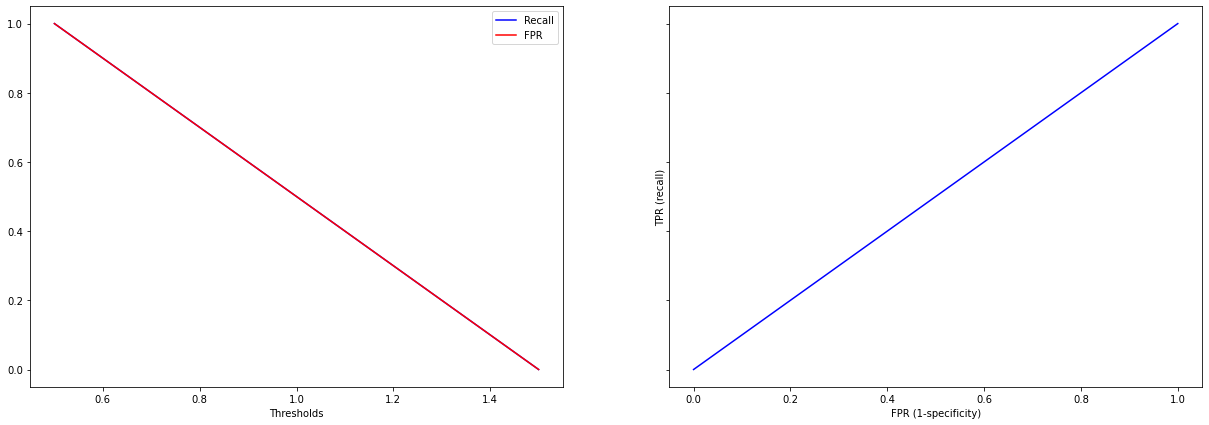

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


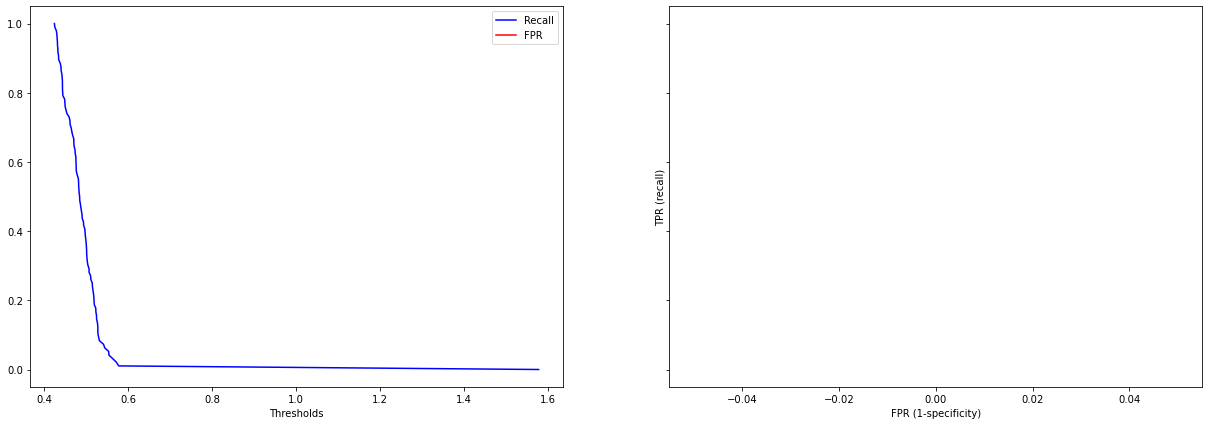

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669583  0.585718   0.703854     0.753395  0.639099  0.732375
Validation  0.661828  0.568986   0.703400     0.755208  0.627580  0.722132

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008420  0.021959   0.011527     0.018195  0.012931  0.006964
Validation  0.033833  0.045336   0.051628     0.060391  0.034914  0.028185

XGBoost Classifier
╠■■■■■■■■■╣


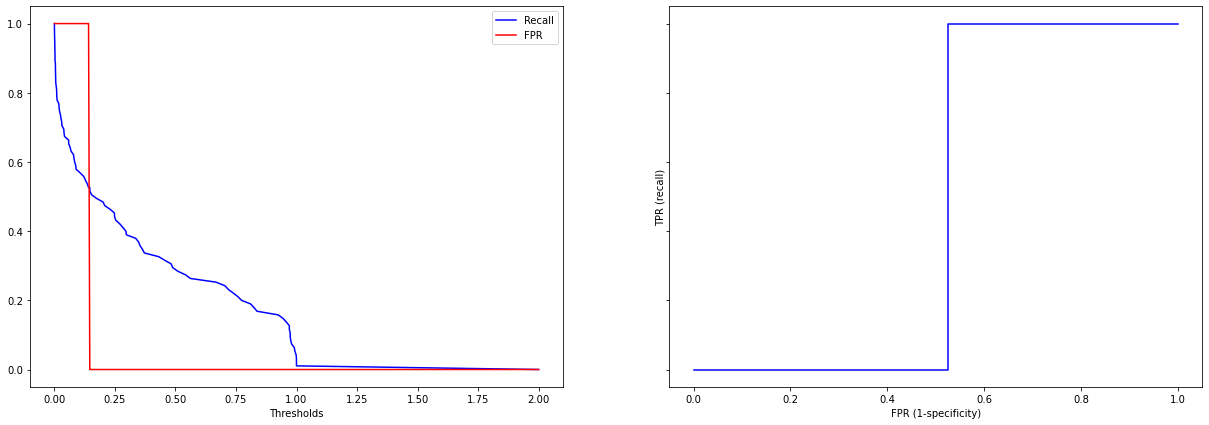

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation  0.640528  0.642472   0.642085     0.638542  0.641859  0.686615

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1  ROC_AUC
Training    0.000000  0.000000   0.000000     0.000000  0.000000  0.00000
Validation  0.030333  0.032145   0.032891     0.047874  0.027587  0.03519

SVM
╠■■■■■■■■■╣


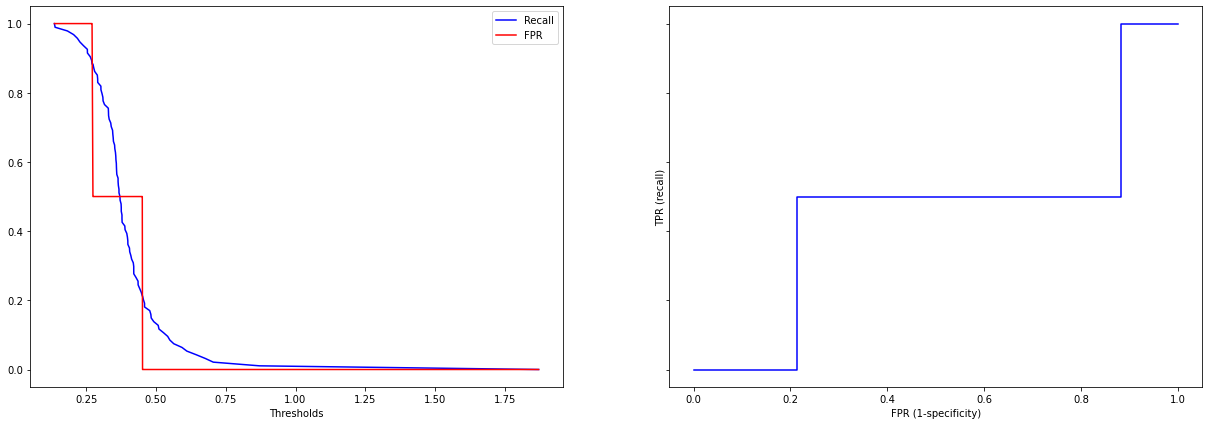

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.684318  0.518945   0.775439     0.849597  0.621189  0.753929
Validation  0.677423  0.518192   0.762499     0.837500  0.615974  0.735238

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012270  0.032856   0.012726     0.015102  0.023229  0.010331
Validation  0.041441  0.058912   0.053018     0.043424  0.053988  0.037545

KNN
╠■■■■■■■■■╣


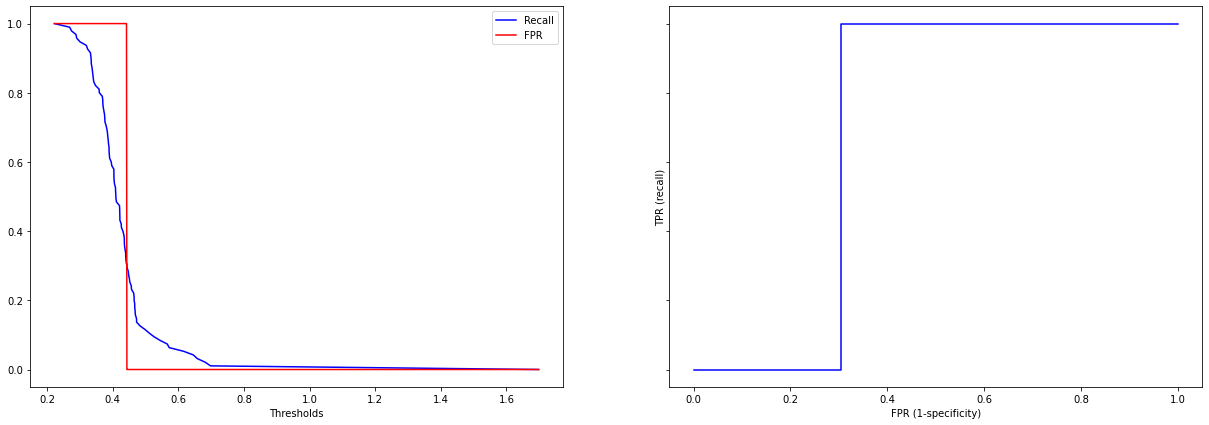

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    1.000000  1.000000   1.000000     1.000000  1.000000  1.000000
Validation  0.604159  0.377201   0.692955     0.832292  0.488433  0.669001

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.00000  0.000000   0.000000     0.000000  0.000000  0.000000
Validation   0.01915  0.023906   0.032057     0.015874  0.027654  0.031105

Logistic Regression
╠■■■■■■■■■╣


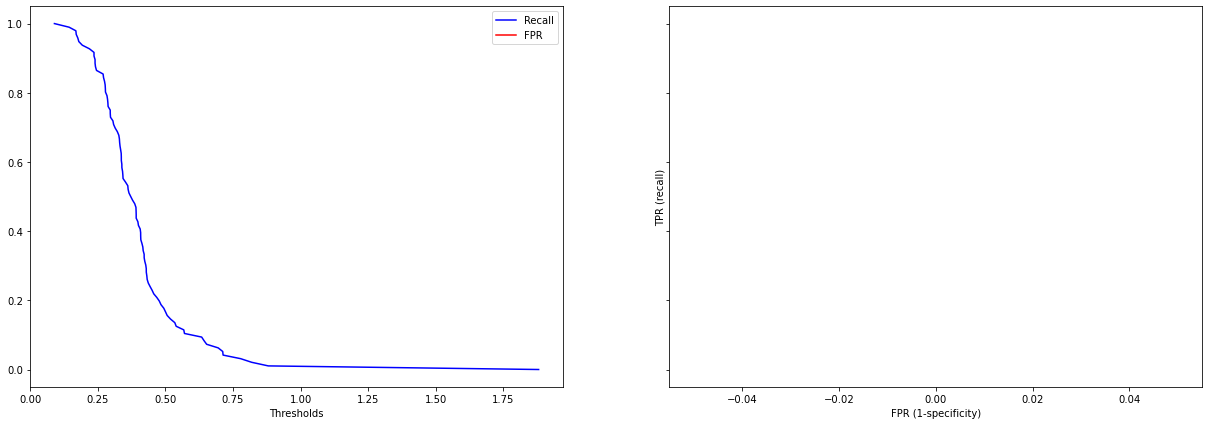

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693237  0.586411   0.745676     0.800000  0.656398  0.757561
Validation  0.684675  0.578265   0.736483     0.791667  0.646919  0.744887

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008913  0.016360   0.011654     0.012224  0.011982  0.008229
Validation  0.029344  0.050662   0.035798     0.032572  0.039192  0.031841

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.661828  0.568986   0.703400     0.755208   
XGBoost Classifier              0.640528  0.642472   0.642085     0.638542   
SVM                             0.677423  0.518192   0.762499     0.837500   
KNN                             0.604159  0.377201   0.692955     0.832292   
Logistic Regression             0.684675  0.578265   0.736483     0.791667   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.627580  0.722132  
XGBoost Classifier              0.641859  0.686615  
SVM                             0.615974  0.735238  
KNN                             0.488433  0.669001  
Logistic Regression             0.646919  0.744887

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6404300612445757-0.6832260268383259   
XGBoost Classifier               0.6213433830122079-0.6597123164696572   
SVM                              0.6512135286047607-0.7036331898753776   
KNN                              0.5920470172490112-0.6162701243744774   
Logistic Regression              0.6661160664961944-0.7032330267680543   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)    0.5403130206353347-0.5976594879557305   
XGBoost Classifier                0.6221415033289222-0.6628026547466792   
SVM                               0.4809325813465767-0.5554505801654507   
KNN                             0.36208196354215594-0.39232095742004347   
Logistic Regression               0.5462231783570782-0.6103060312649148   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6707477109019817-0.7360526383570272   
XGBoost Classifier              0.6212828658401932-0.6628874571001402   
SVM                              0.7289672781395053-0.796030399808495   
KNN                             0.6726809114880433-0.7132296325246096   
Logistic Regression             0.7138422029454484-0.7591233990362017   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.717013888888889-0.7934027777777778   
XGBoost Classifier              0.6082635703380672-0.6688197629952661   
SVM                             0.8100365000926595-0.8649634999073406   
KNN                             0.8222521997952771-0.8423311335380562   
Logistic Regression             0.7710661153136232-0.8122672180197102   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6054989554645067-0.6496615437425399   
XGBoost Classifier              0.6244111217886044-0.6593068297962486   
SVM                               0.58182934421853-0.6501193851083198   
KNN                             0.47094276181783035-0.505922889132899   
Logistic Regression              0.6221314603496299-0.671705780372636   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.7043063594379156-0.7399582095769756  
XGBoost Classifier              0.6643583557609529-0.7088710793765043  
SVM                             0.7114924896483901-0.7589838893965699  
KNN                              0.6493287739299968-0.688673490173669  
Logistic Regression             0.7247487631740116-0.7650247369691728

In [42]:
#ra_symptoms_nvitals_ex
run_models(ra_symptoms_nvitals_ex, y[ra_symptoms_nvitals_ex.index], models, ratio_negatives_to_positives=1)

Dummy Random
╠■■■■■■■■■╣


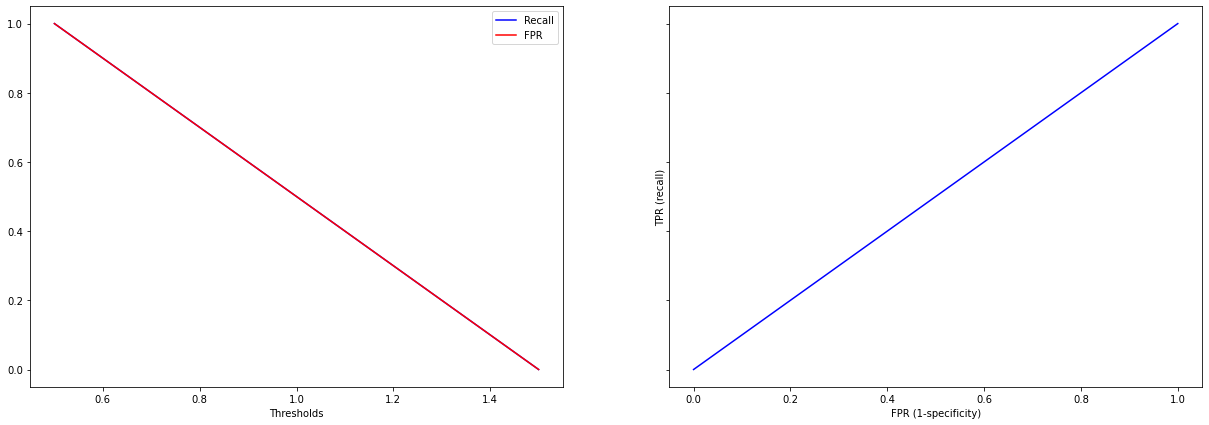

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


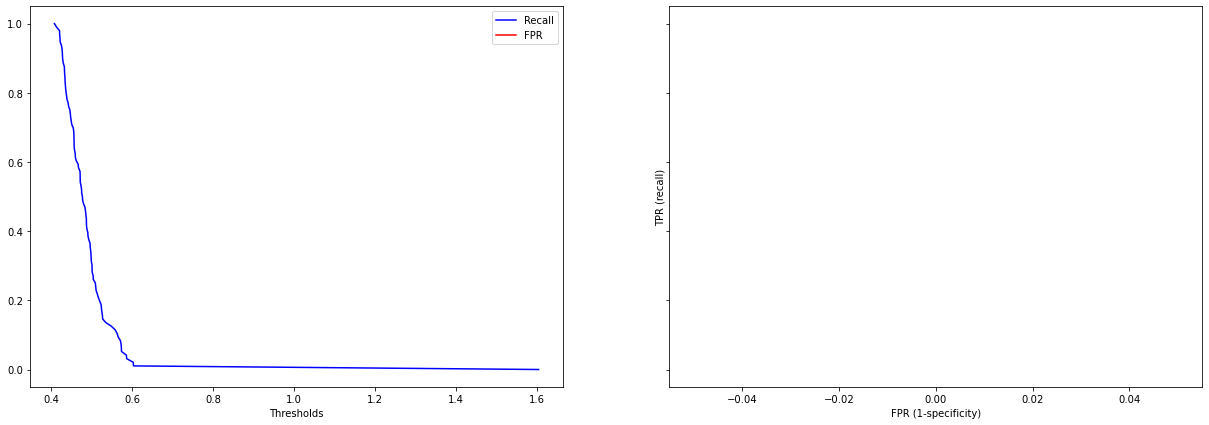

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.671425  0.602416   0.699046     0.740391  0.646837  0.736904
Validation  0.657149  0.591742   0.685176     0.722917  0.633135  0.710660

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008490  0.022435   0.012585     0.020182  0.012489  0.009897
Validation  0.033509  0.054181   0.048954     0.062731  0.037465  0.035876

XGBoost Classifier
╠■■■■■■■■■╣


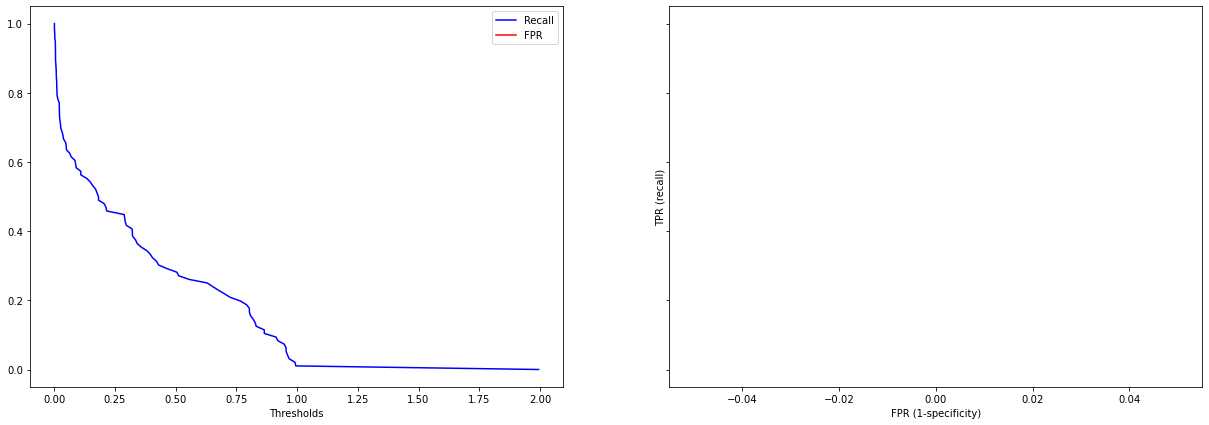

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999942  0.999885   1.000000     1.000000  0.999942  1.000000
Validation  0.656118  0.644534   0.660901     0.667708  0.652048  0.710026

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000182  0.000364   0.000000      0.00000  0.000182  2.096189e-07
Validation  0.030904  0.050548   0.030312      0.03418  0.037190  3.072703e-02

SVM
╠■■■■■■■■■╣


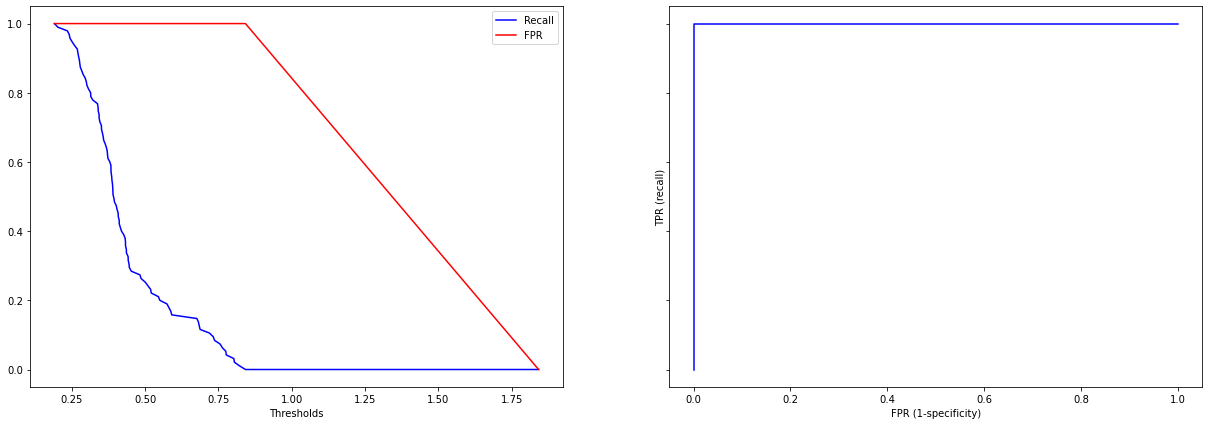

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.679193  0.505920   0.774705     0.852359  0.611493  0.753674
Validation  0.664977  0.500655   0.750988     0.830208  0.598879  0.721523

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007815  0.028148   0.015057     0.019180  0.017611  0.006069
Validation  0.031498  0.052309   0.055085     0.051043  0.041236  0.036478

KNN
╠■■■■■■■■■╣


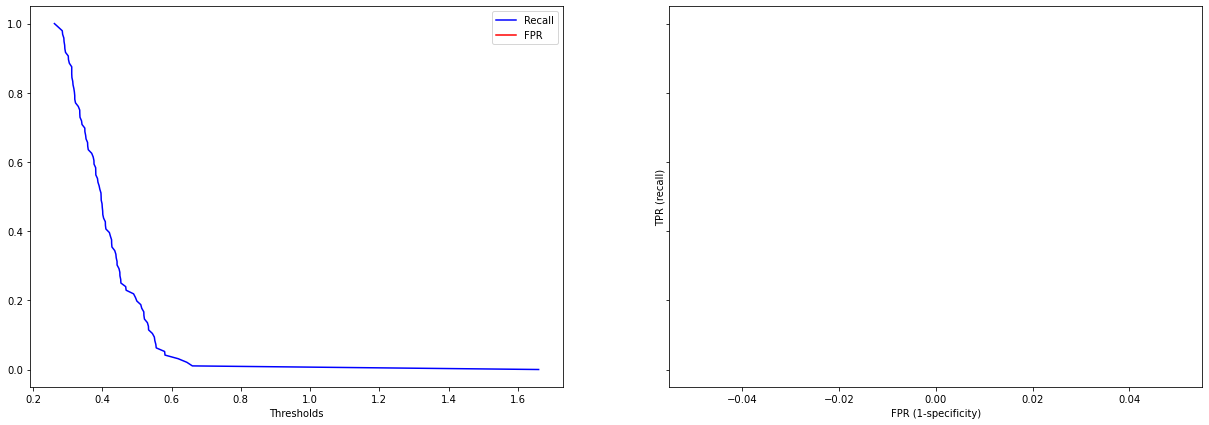

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.999942  0.999885    1.00000       1.0000  0.999942  1.000000
Validation  0.611439  0.386512    0.70453       0.8375  0.497826  0.675631

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1       ROC_AUC
Training    0.000182  0.000364   0.000000      0.00000  0.000182  2.096189e-07
Validation  0.029430  0.053099   0.045694      0.03035  0.052291  2.590283e-02

Logistic Regression
╠■■■■■■■■■╣


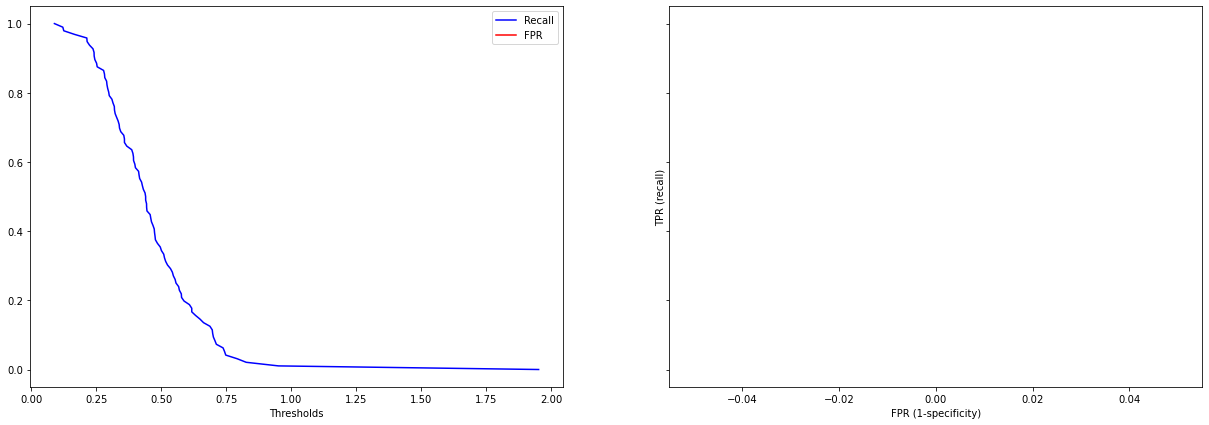

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.690187  0.586528   0.739942     0.793786  0.65426  0.756304
Validation  0.674814  0.562726   0.728323     0.787500  0.63332  0.738211

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005513  0.011104   0.010194     0.012731  0.006861  0.007112
Validation  0.026408  0.054924   0.036025     0.043145  0.037822  0.031007

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.657149  0.591742   0.685176     0.722917   
XGBoost Classifier              0.656118  0.644534   0.660901     0.667708   
SVM                             0.664977  0.500655   0.750988     0.830208   
KNN                             0.611439  0.386512   0.704530     0.837500   
Logistic Regression             0.674814  0.562726   0.728323     0.787500   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.633135  0.710660  
XGBoost Classifier              0.652048  0.710026  
SVM                             0.598879  0.721523  
KNN                             0.497826  0.675631  
Logistic Regression             0.633320  0.738211

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)    0.635955553328944-0.6783417264638019   
XGBoost Classifier               0.6365722160724798-0.6756633193333925   
SVM                              0.6450563055153353-0.6848983576971002   
KNN                              0.5928260087598634-0.6300528772504994   
Logistic Regression               0.6581121574095111-0.691515433264064   

                                                                Recall  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.5574748709007602-0.6260088060751849   
XGBoost Classifier               0.6125645462179706-0.6765033231978369   
SVM                             0.46757194560343274-0.5337381918536118   
KNN                              0.3529294530222285-0.4200946019605893   
Logistic Regression              0.5279882481137421-0.5974627828140928   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6542143081079702-0.7161367851887143   
XGBoost Classifier              0.6417302476768969-0.6800724595812258   
SVM                             0.7161491680869816-0.7858268148567058   
KNN                             0.6756303920160913-0.7334287120750869   
Logistic Regression             0.7055389623365813-0.7511073349076633   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6832420642858731-0.7625912690474602   
XGBoost Classifier              0.6460911355329536-0.6893255311337131   
SVM                             0.7979260019467513-0.8624906647199151   
KNN                             0.8183051736651594-0.8566948263348406   
Logistic Regression             0.7602126629105715-0.8147873370894284   

                                                                    F1  \
Dummy Random                                                   0.0-0.0   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6094401111932373-0.6568295262962371   
XGBoost Classifier               0.6285268254258701-0.6755689170701215   
SVM                              0.5727984954089393-0.6249586109889056   
KNN                             0.46475487675512805-0.5308980975597293   
Logistic Regression              0.6093988805721493-0.6572409639772561   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.6879697992547096-0.7333496899348666  
XGBoost Classifier              0.6905926732621012-0.7294596337968909  
SVM                             0.6984526669059044-0.7445940514861347  
KNN                             0.6592487392885804-0.6920135208775133  
Logistic Regression              0.718600298228906-0.7578210308804868

In [43]:
#ra_symptoms_svitals_ex
run_models(ra_symptoms_svitals_ex, y[ra_symptoms_svitals_ex.index], models, ratio_negatives_to_positives=1)

Notes:

I made a pass through all the metrics selecting the best algorithm for each one. Then, for the ones with notes I look at the recall and if the note is not satisfactory, I look for the second best. 
Repeat the process untill we find the real best metric.

|Best Metric|Model|Dataset|Value|Cons|
| :-| -: | -: | -: | -: |
|Accuracy| Logistic Regression|ra_symptoms_svitals_ex| 0.684209| None |
|Recall | XGBoost | ra_symptoms_vitals_ex |0.614604| Average everywhere else (but above .5)|
|Precision | SVM | ra_symptoms_vitals | 0.775354 | Recall below .5 (but above .4)|
|Specificity | SVM | ra_symptoms_vitals | 0.863303 | Recall below .5 (but above.4) |
|F1 Score | Logistic Regression |ra_symptoms_svitals_ex| 0.646409 | None |
|ROC_AUC Score | Logistic Regression | ra_symptoms_svitals_ex | 0.742775 | None |

Logistic Regression with ra_symptoms_svitals_ex seems to be the best.

In [44]:
selected_features = ["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["asthma", "smoker", "diabetes"]], left_index=True, right_index=True)

Dummy Random
╠■■■■■■■■■╣


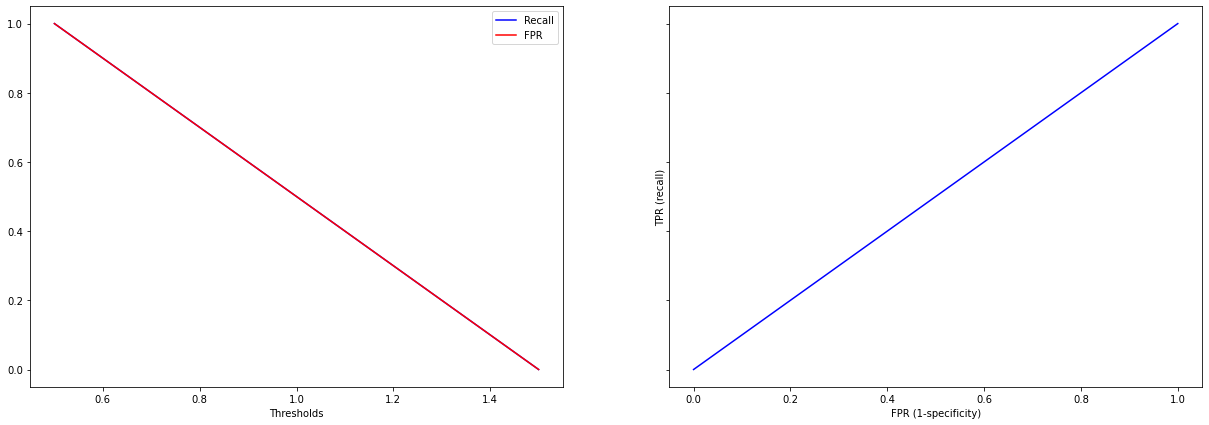

feature_importances


Permutation Importance



Mean metrics


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.500144     0.0        0.0          1.0  0.0      0.5
Validation  0.498705     0.0        0.0          1.0  0.0      0.5

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
Training    0.000152     0.0        0.0          0.0  0.0      0.0
Validation  0.001365     0.0        0.0          0.0  0.0      0.0

MultinomialNB
Negative values in data passed to MultinomialNB (input X)
Random Forest (100 estimators)
╠■■■■■■■■■╣


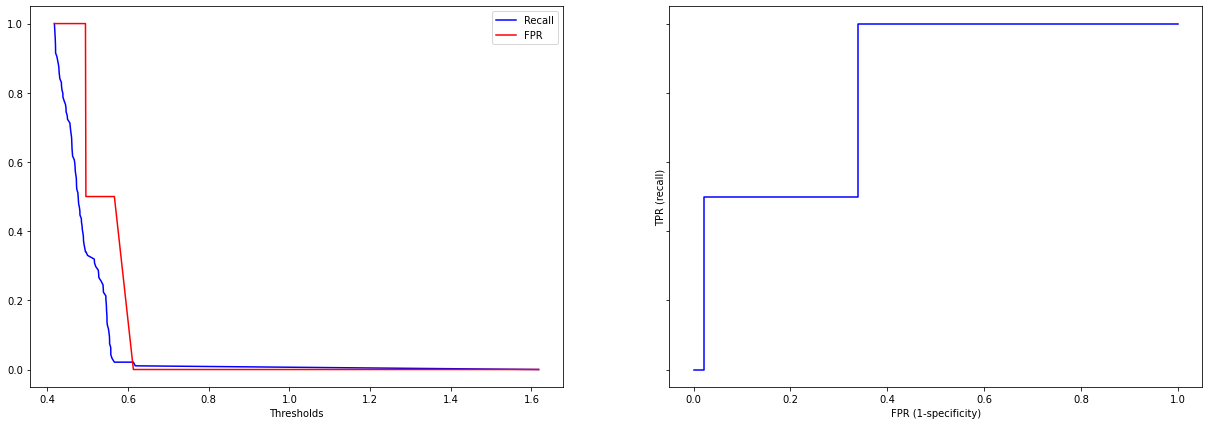

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669007  0.574431   0.708985     0.763521  0.634250  0.725330
Validation  0.668569  0.572101   0.713865     0.765625  0.633773  0.720841

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010966  0.021118   0.019451     0.026715  0.012755  0.011619
Validation  0.029391  0.037111   0.048738     0.063315  0.028051  0.029999

XGBoost Classifier
╠■■■■■■■■■╣


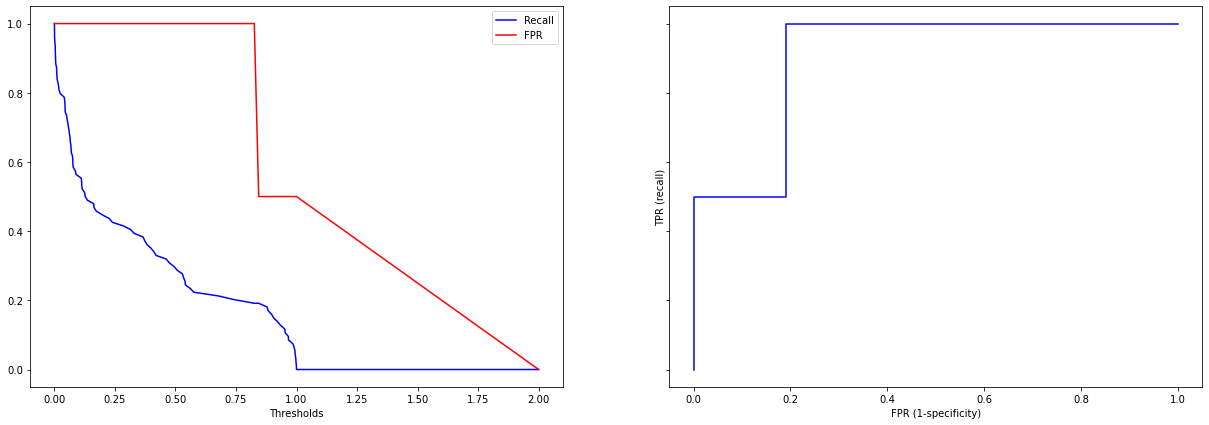

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.977094  0.969720   0.984242     0.984465  0.976913  0.998362
Validation  0.637387  0.618664   0.645092     0.656250  0.630998  0.694262

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.003467  0.006059   0.004153     0.004176  0.003526  0.000468
Validation  0.032461  0.037732   0.036622     0.051967  0.031547  0.038062

SVM
╠■■■■■■■■■╣


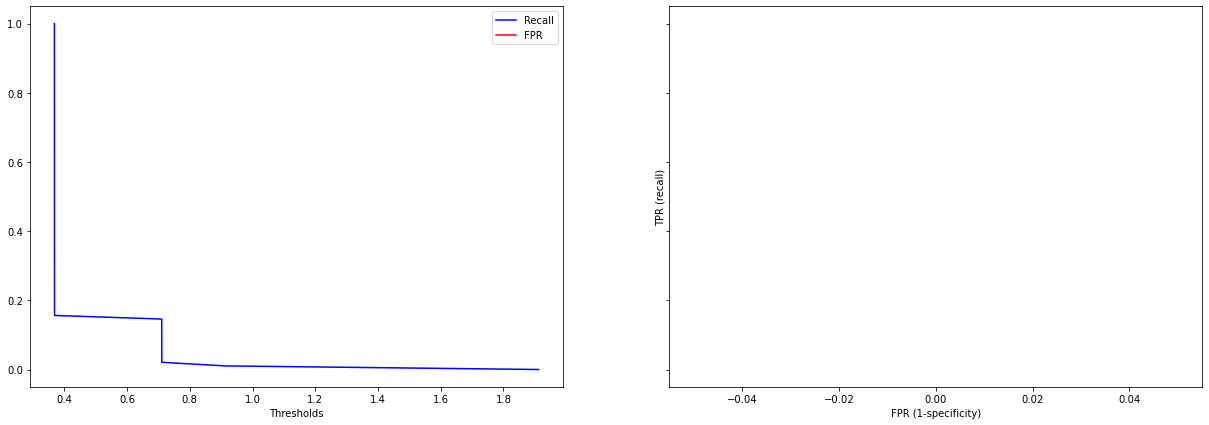

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.676201  0.500859   0.771254     0.851438  0.607067  0.745304
Validation  0.668086  0.497552   0.758515     0.839583  0.599274  0.729328

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007619  0.020963   0.008185     0.009786  0.014986  0.007257
Validation  0.035700  0.059459   0.051282     0.045854  0.049755  0.025235

KNN
╠■■■■■■■■■╣


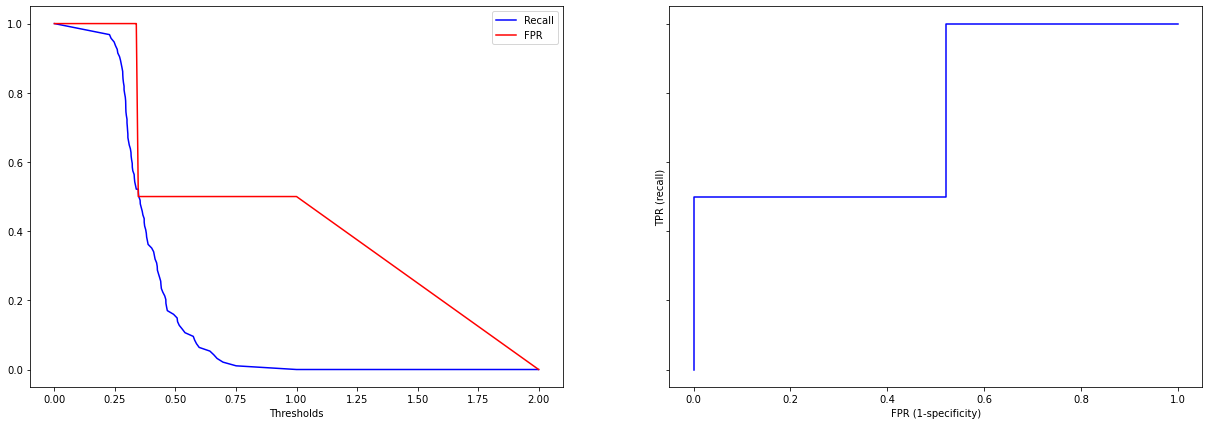

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.984460  0.971098   0.997757     0.997814  0.984240  0.999491
Validation  0.619759  0.465324   0.675806     0.775000  0.550289  0.668499

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.002206  0.004875   0.001411     0.001378  0.002273  0.000129
Validation  0.039746  0.052279   0.058258     0.046117  0.051280  0.036754

Logistic Regression
╠■■■■■■■■■╣


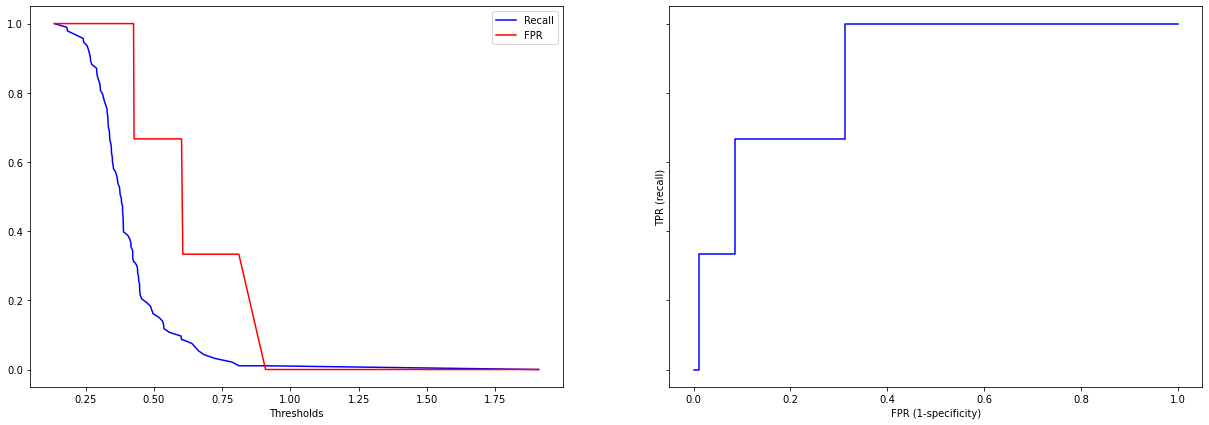

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.693352  0.583072   0.748158     0.803567  0.655193  0.753947
Validation  0.696648  0.581433   0.756378     0.812500  0.656797  0.751632

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010549  0.017888   0.016237     0.016676  0.013403  0.009926
Validation  0.033603  0.054617   0.033902     0.024552  0.044983  0.031091

Accuracy    Recall  Precision  Specificity  \
Dummy Random                    0.498705  0.000000   0.000000     1.000000   
MultinomialNB                   0.000000  0.000000   0.000000     0.000000   
Random Forest (100 estimators)  0.668569  0.572101   0.713865     0.765625   
XGBoost Classifier              0.637387  0.618664   0.645092     0.656250   
SVM                             0.668086  0.497552   0.758515     0.839583   
KNN                             0.619759  0.465324   0.675806     0.775000   
Logistic Regression             0.696648  0.581433   0.756378     0.812500   

                                      F1   ROC_AUC  
Dummy Random                    0.000000  0.500000  
MultinomialNB                   0.000000  0.000000  
Random Forest (100 estimators)  0.633773  0.720841  
XGBoost Classifier              0.630998  0.694262  
SVM                             0.599274  0.729328  
KNN                             0.550289  0.668499  
Logistic Regression             0.656797  0.751632

Accuracy  \
Dummy Random                    0.49784110535405873-0.4995682210708117   
MultinomialNB                                                  0.0-0.0   
Random Forest (100 estimators)   0.6499805105979886-0.6871578745488163   
XGBoost Classifier                0.6168566596400171-0.657916656422159   
SVM                              0.6455077599791615-0.6906645198135847   
KNN                              0.5946214219650677-0.6448971445288872   
Logistic Regression              0.6753956792461275-0.7179009528782248   

                                                                 Recall  \
Dummy Random                                                    0.0-0.0   
MultinomialNB                                                   0.0-0.0   
Random Forest (100 estimators)    0.5486292474599646-0.5955717834678704   
XGBoost Classifier                0.5948001384119057-0.6425280402822522   
SVM                                0.4599464975359513-0.535156595247554   
KNN                             0.43226022000825254-0.49838840542130064   
Logistic Regression               0.5468895588147649-0.6159755614601492   

                                                            Precision  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.6830405447763428-0.7446902543421952   
XGBoost Classifier              0.6219305431791627-0.6682535806597395   
SVM                             0.7260816941597114-0.7909492126383583   
KNN                             0.6389608027805461-0.7126513817151868   
Logistic Regression             0.7349360918174843-0.7778190325284222   

                                                          Specificity  \
Dummy Random                                                  1.0-1.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)  0.7255813798796152-0.8056686201203848   
XGBoost Classifier                0.623382890093891-0.689117109906109   
SVM                             0.8105824819196928-0.8685841847469736   
KNN                             0.7458333333333335-0.8041666666666668   
Logistic Regression             0.7969717501562514-0.8280282498437486   

                                                                   F1  \
Dummy Random                                                  0.0-0.0   
MultinomialNB                                                 0.0-0.0   
Random Forest (100 estimators)   0.616031996405534-0.6515137940378574   
XGBoost Classifier              0.6110453788570266-0.6509496512860641   
SVM                              0.5678064159557097-0.630742097645804   
KNN                             0.5178565286900902-0.5827215131014505   
Logistic Regression             0.6283473537478172-0.6852474748577173   

                                                              ROC_AUC  
Dummy Random                                                  0.5-0.5  
MultinomialNB                                                 0.0-0.0  
Random Forest (100 estimators)  0.7018684586484782-0.7398144281284404  
XGBoost Classifier                0.6701891154850956-0.71833454126605  
SVM                             0.7133678384722313-0.7452883309865321  
KNN                             0.6452535008255871-0.6917445706592351  
Logistic Regression             0.7319684590291122-0.7712962576447135

In [45]:
run_models(selected_dataset, y[selected_dataset.index], models, ratio_negatives_to_positives=1)


╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■╣
Threshold: 0.6


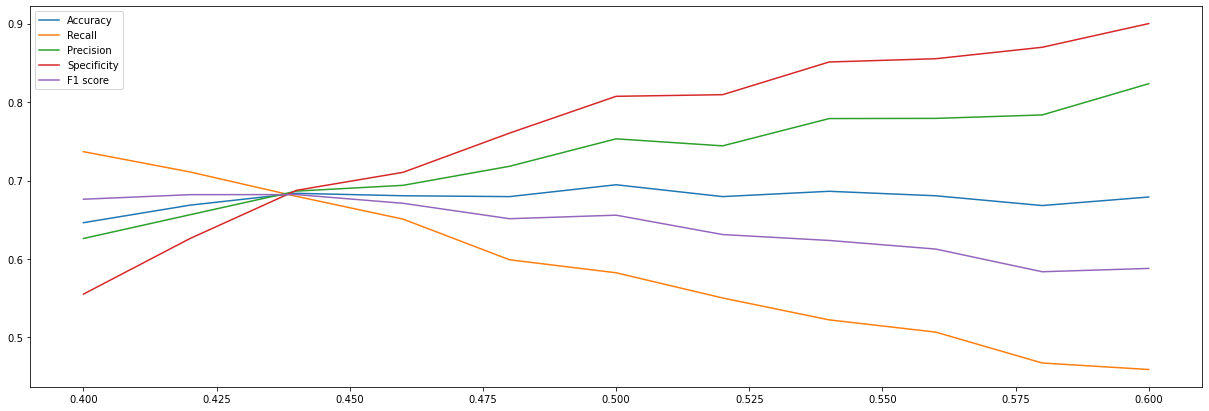

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.646252  0.668572  0.683660  0.680554  0.679480  0.694568   
Recall       0.736759  0.710889  0.679822  0.650784  0.598980  0.582399   
Precision    0.626087  0.656363  0.686492  0.693848  0.718133  0.753110   
Specificity  0.555208  0.626042  0.687500  0.710417  0.760417  0.807292   
F1           0.676135  0.681953  0.682057  0.670946  0.651306  0.655820   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.679482  0.686251  0.680543  0.668078  0.678964  
Recall       0.550290  0.522390  0.506798  0.467408  0.459128  
Precision    0.744150  0.778936  0.779178  0.783546  0.823387  
Specificity  0.809375  0.851042  0.855208  0.869792  0.900000  
F1           0.631127  0.623589  0.612646  0.583716  0.587950

In [46]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(.4,.6,num=11))

With the dataset <b>selected_features</b> and a threshold of <b>.44</b> (for high recall), <b>Logistic Regression</b> seems to be the best out of all algorithms

In [47]:
logistic_model_group = {
    "LogisticVanilla" : LogisticRegression(),
    "LogisticStrongRegularization" : LogisticRegression(C=.5),
    "LogisticWeakRegularization" : LogisticRegression(C=2),
    "AdaBoost" : AdaBoostClassifier(base_estimator=LogisticRegression())
}



LogisticVanilla
╠■■■■■■■■■╣


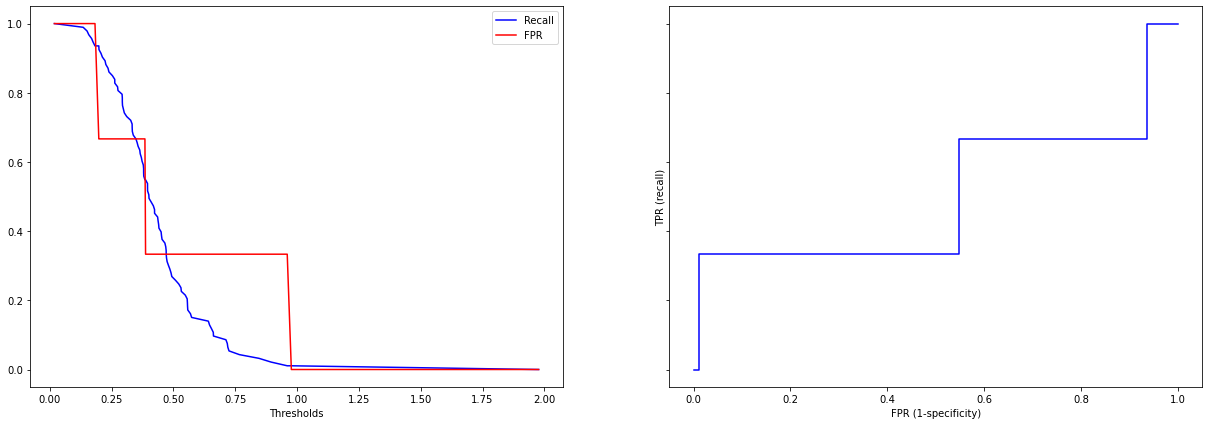

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.694158  0.583647   0.749362     0.804603  0.656088  0.752904
Validation  0.684162  0.573110   0.739817     0.795833  0.644155  0.735524

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005997  0.009278   0.012925     0.015070  0.005731  0.004959
Validation  0.046411  0.068762   0.061545     0.054504  0.057051  0.044790

LogisticStrongRegularization
╠■■■■■■■■■╣


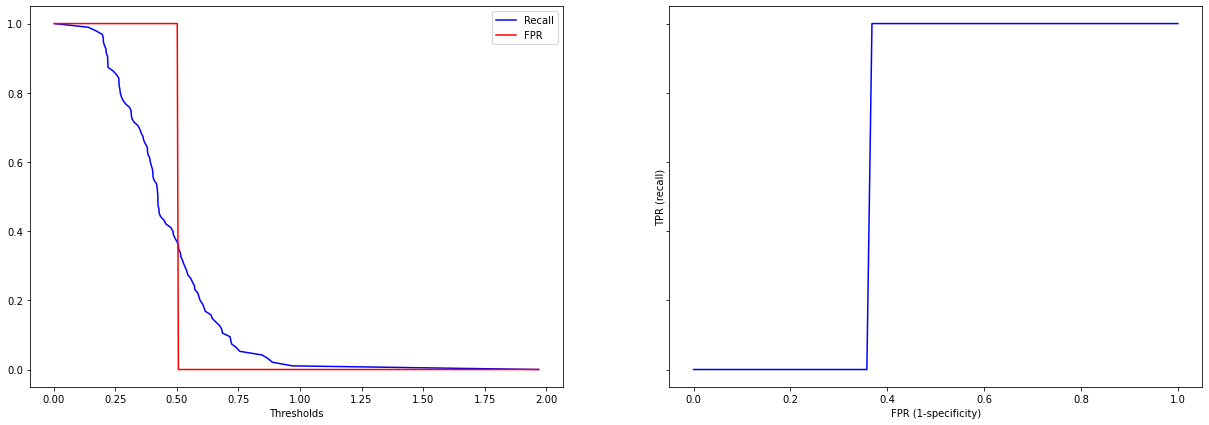

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.691742  0.580774   0.746534     0.802647  0.653194  0.749853
Validation  0.695086  0.578254   0.756081     0.812500  0.654266  0.755567

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.012651  0.014367   0.019168     0.018406  0.013755  0.009211
Validation  0.038483  0.060197   0.042491     0.037397  0.050020  0.036664

LogisticWeakRegularization
╠■■■■■■■■■╣


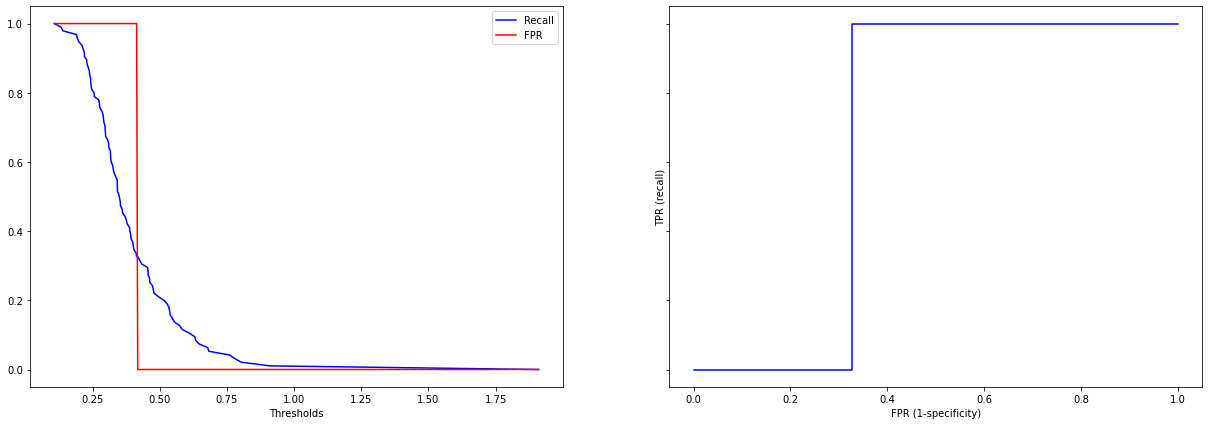

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.690361  0.578468   0.745245     0.802186  0.651277  0.751561
Validation  0.682065  0.569996   0.736713     0.794792  0.641702  0.739300

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.009777  0.011494   0.014911     0.014611  0.010747  0.007827
Validation  0.042521  0.060001   0.053596     0.046598  0.052252  0.040426

AdaBoost
╠■■■■■■■■■╣


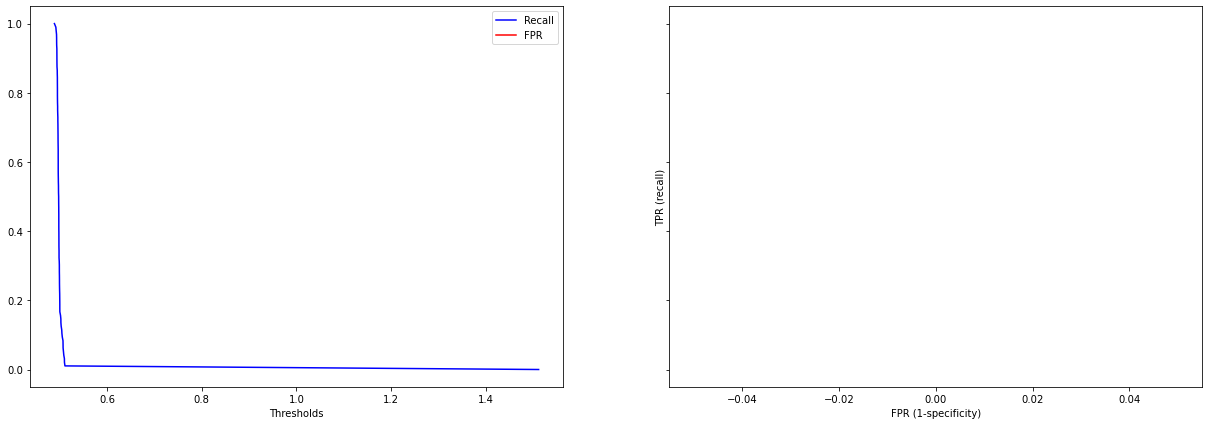

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training     0.68800  0.589062   0.734333     0.786881  0.653675  0.745132
Validation   0.68261  0.590722   0.724809     0.775000  0.650555  0.739149

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010092  0.011066   0.014317     0.013764  0.010952  0.009060
Validation  0.025458  0.041929   0.024346     0.019145  0.033165  0.019764

Accuracy    Recall  Precision  Specificity  \
LogisticVanilla               0.684162  0.573110   0.739817     0.795833   
LogisticStrongRegularization  0.695086  0.578254   0.756081     0.812500   
LogisticWeakRegularization    0.682065  0.569996   0.736713     0.794792   
AdaBoost                      0.682610  0.590722   0.724809     0.775000   

                                    F1   ROC_AUC  
LogisticVanilla               0.644155  0.735524  
LogisticStrongRegularization  0.654266  0.755567  
LogisticWeakRegularization    0.641702  0.739300  
AdaBoost                      0.650555  0.739149

Accuracy  \
LogisticVanilla               0.6548086896803507-0.7135149286270757   
LogisticStrongRegularization   0.670747102769213-0.7194245293551397   
LogisticWeakRegularization    0.6551720412396652-0.7089579242180203   
AdaBoost                      0.6665090416426224-0.6987111656112638   

                                                             Recall  \
LogisticVanilla                0.529620767034714-0.6165991642367636   
LogisticStrongRegularization  0.5401817899682579-0.6163259419905049   
LogisticWeakRegularization     0.5320477157564308-0.607943693178277   
AdaBoost                       0.564203604692591-0.6172396942764812   

                                                          Precision  \
LogisticVanilla               0.7008927398805449-0.7787419203768102   
LogisticStrongRegularization   0.7292074353472514-0.782955054252844   
LogisticWeakRegularization    0.7028158738418424-0.7706099329373184   
AdaBoost                      0.7094111674787179-0.7402070793379295   

                                                        Specificity  \
LogisticVanilla               0.7613620176500254-0.8303046490166414   
LogisticStrongRegularization  0.7888480744917689-0.8361519255082311   
LogisticWeakRegularization    0.7653207011473292-0.8242626321860039   
AdaBoost                      0.7628919473790537-0.7871080526209463   

                                                                 F1  \
LogisticVanilla                0.608072469318725-0.6802371903155372   
LogisticStrongRegularization  0.6226308382362088-0.6859019148623554   
LogisticWeakRegularization     0.6086553585222398-0.674749231456788   
AdaBoost                      0.6295792455786703-0.6715301932692147   

                                                            ROC_AUC  
LogisticVanilla               0.7071965912342472-0.7638519661827062  
LogisticStrongRegularization  0.7323787480483093-0.7787552949428134  
LogisticWeakRegularization     0.7137326617700546-0.764868090843061  
AdaBoost                       0.726649150556796-0.7516493486914857

In [48]:
run_models(selected_dataset, y[selected_dataset.index], logistic_model_group, folds=10, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.36
╠■■■■■■■■■╣
Threshold: 0.37
╠■■■■■■■■■╣
Threshold: 0.38
╠■■■■■■■■■╣
Threshold: 0.39
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.41000000000000003
╠■■■■■■■■■╣
Threshold: 0.42
╠■■■■■■■■■╣
Threshold: 0.43
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.45


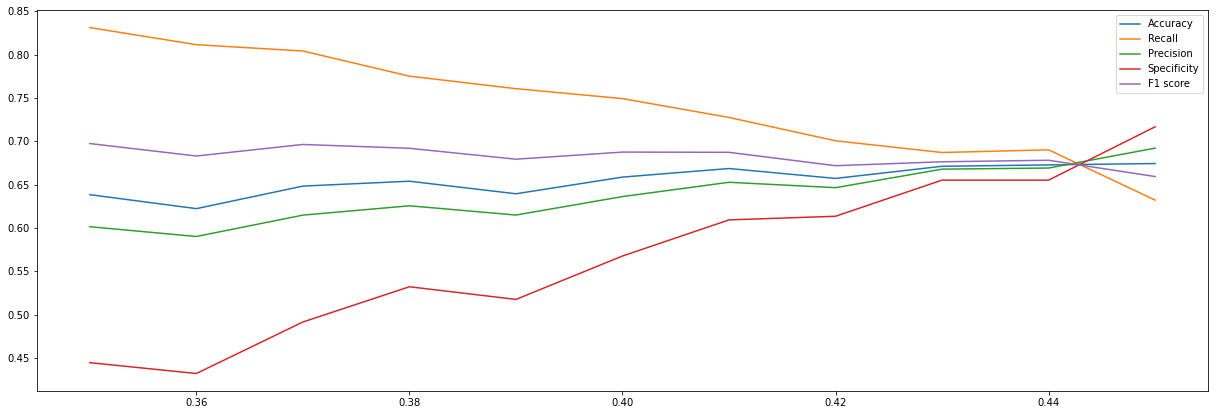

0.35      0.36      0.37      0.38      0.39      0.40  \
Accuracy     0.638434  0.622334  0.648316  0.653951  0.639467  0.658684   
Recall       0.831046  0.811340  0.804059  0.775064  0.760621  0.749173   
Precision    0.601478  0.590226  0.614866  0.625608  0.614959  0.636239   
Specificity  0.444792  0.432292  0.491667  0.532292  0.517708  0.567708   
F1           0.697371  0.682994  0.696310  0.691898  0.679324  0.687524   

                 0.41      0.42      0.43      0.44      0.45  
Accuracy     0.668577  0.657159  0.671163  0.672739  0.674323  
Recall       0.727438  0.700558  0.687049  0.690131  0.632195  
Precision    0.652724  0.646506  0.667844  0.669143  0.692079  
Specificity  0.609375  0.613542  0.655208  0.655208  0.716667  
F1           0.687263  0.671813  0.676356  0.678107  0.659344

In [49]:
run_threshold(selected_dataset, y[selected_dataset.index], logistic_model_group["LogisticWeakRegularization"], thresholds=np.linspace(.35,.45,num=11))

In [50]:
imputer = Imputer()
imputer.fit_transform(selected_dataset, y[selected_dataset.index])
imp_x = test_x[selected_dataset.columns].copy()
imputer.transform(imp_x)
lr = LogisticRegression(C=2)

train_x = pd.concat([selected_dataset[y[selected_dataset.index] == "Positive"], selected_dataset[y[selected_dataset.index] == "Negative"].sample((selected_dataset[y[selected_dataset.index] == "Positive"]).shape[0])])
lr.fit(train_x, y[train_x.index])
t_preds = lr.predict_proba(train_x)
t_preds = pd.cut(t_preds[:,1], [-1, .41, 1.1], labels=["Negative", "Positive"], right=False)
preds = lr.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .41, 1.1], labels=["Negative", "Positive"], right=False)

random_even = DummyClassifier(strategy="uniform")
random_even.fit(train_x, y[train_x.index])

random_stratified = DummyClassifier(strategy="stratified")
random_stratified.fit(train_x, y[train_x.index])

pd.DataFrame([get_metrics(y[train_x.index], t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
             index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

Accuracy    Recall  Precision  Specificiy        F1
Training Data      0.678756  0.720207   0.665072    0.637306  0.691542
Test Data          0.060348  0.992958   0.028211    0.034010  0.054864
Random 50/50       0.505996  0.500000   0.027800    0.506165  0.052671
Random stratified  0.501741  0.478873   0.026459    0.502387  0.050147

It still seems to perform poorly on unseen data. However we can see that F1 score (our lead metric) improves slightly compared to the random baselines. Also it is worth nothing that even though precision is low, it is better than random guessing; this means that the model is better than random at giving detecting false positives.

### SVM experiment


SVC 0.5
╠■■■■■■■■■╣


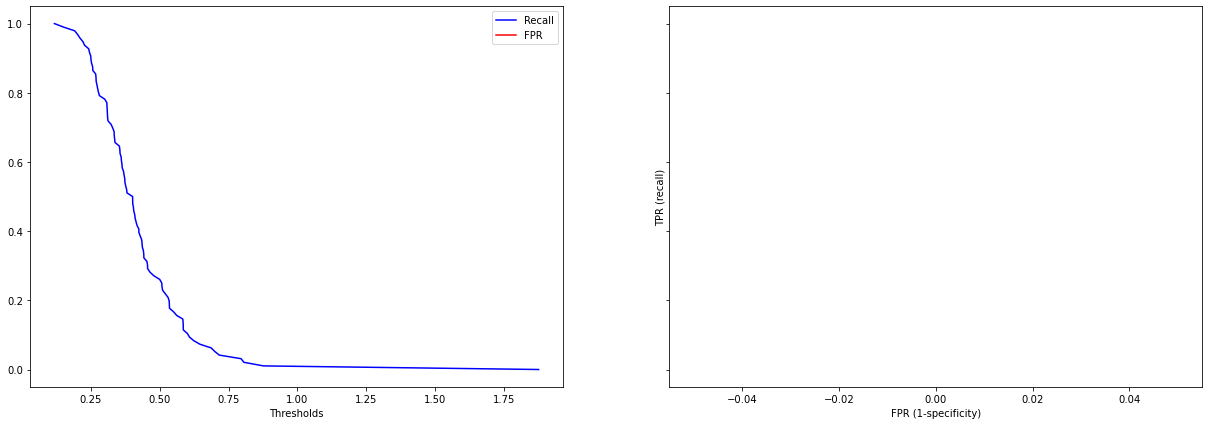

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.681094  0.581005   0.726265     0.781128  0.645373  0.741509
Validation  0.680527  0.578254   0.731494     0.783333  0.644831  0.736567

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007128  0.021081   0.004241     0.008993  0.013353  0.007272
Validation  0.033693  0.035270   0.053100     0.058267  0.033248  0.025305

SVC 1
╠■■■■■■■■■╣


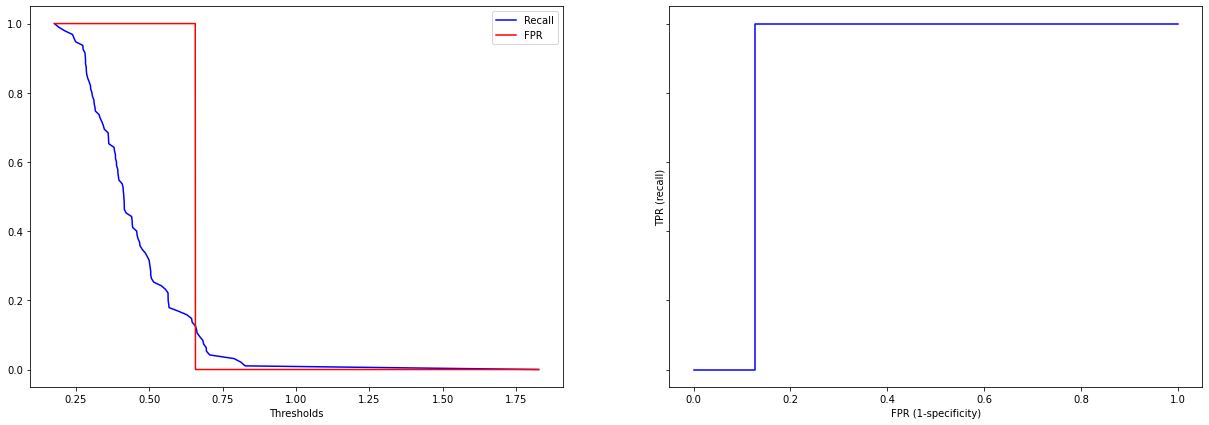

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.689093  0.577548   0.743483     0.800575  0.649981  0.752425
Validation  0.675864  0.574098   0.722448     0.778125  0.639178  0.727260

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008728  0.011504   0.015166     0.015807  0.009378  0.005719
Validation  0.017633  0.038812   0.017325     0.021988  0.026809  0.018996

SVC 1.5
╠■■■■■■■■■╣


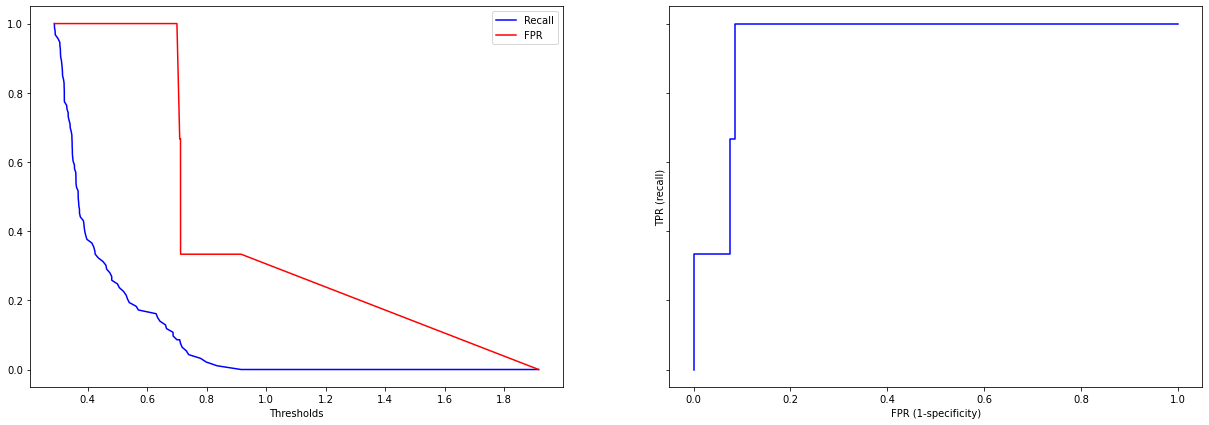

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685871  0.561660   0.747369     0.810012  0.641177  0.748077
Validation  0.689354  0.557528   0.759021     0.821875  0.642397  0.751655

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006202  0.014648   0.011242     0.013696  0.009052  0.007073
Validation  0.037392  0.046291   0.048467     0.038805  0.045261  0.029203

SVC 2
╠■■■■■■■■■╣


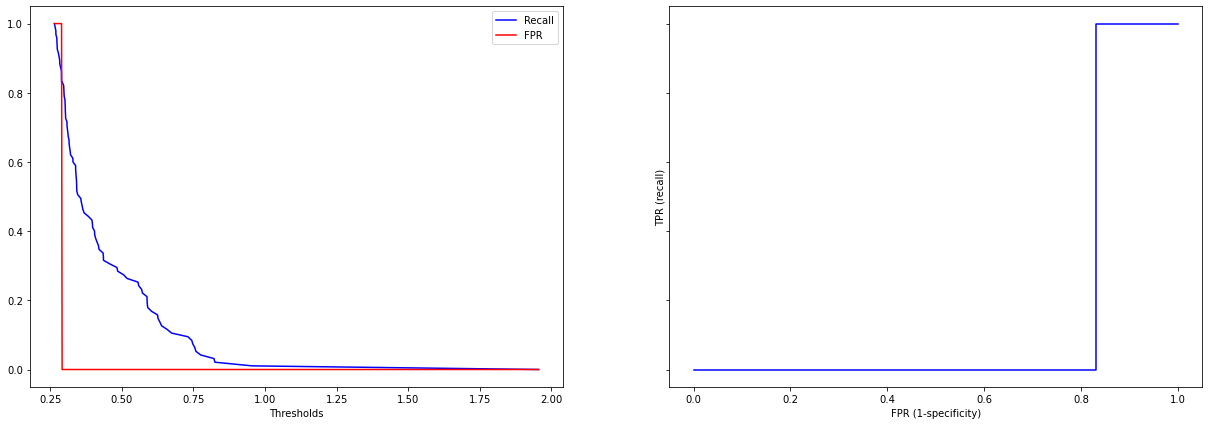

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.691857  0.561542   0.759935     0.822094  0.645541  0.759086
Validation  0.675847  0.553426   0.735298     0.798958  0.631051  0.726255

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.006108  0.015783   0.017263     0.019859  0.007903  0.007862
Validation  0.027355  0.034555   0.039466     0.035427  0.031963  0.028535

NuSVC 0.25
╠■■■■■■■■■╣


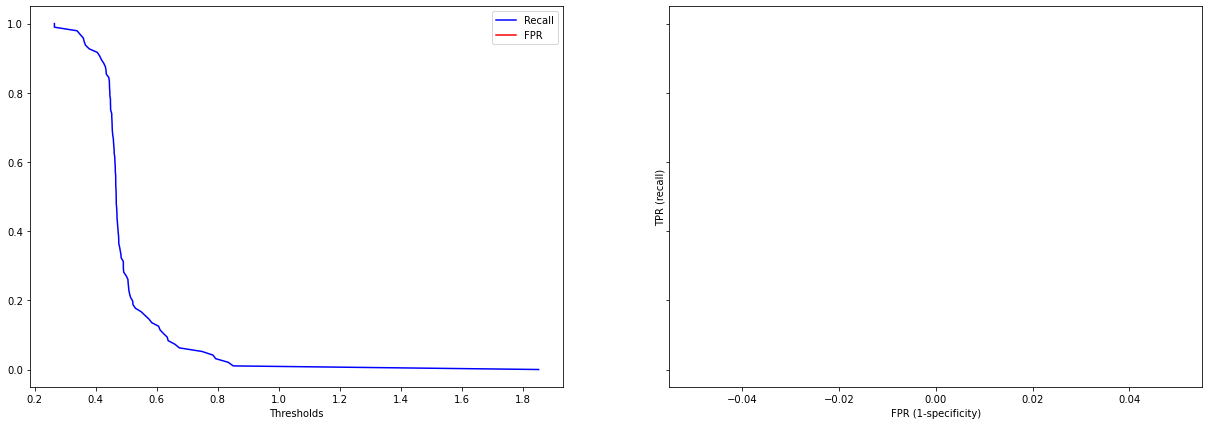

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.716371  0.544160   0.843441     0.888493  0.657051  0.791290
Validation  0.611968  0.433247   0.686194     0.791667  0.526949  0.626578

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.033809  0.050206   0.095419     0.079967  0.034756  0.045905
Validation  0.027535  0.052141   0.067878     0.080238  0.034586  0.031038

NuSVC 0.5
╠■■■■■■■■■╣


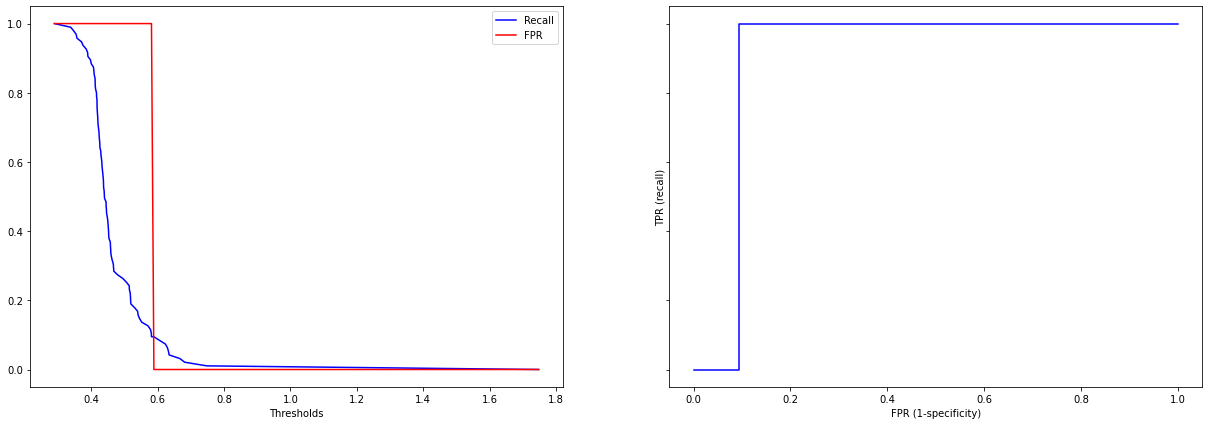

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.779856  0.636270   0.892997     0.923360  0.742130  0.856333
Validation  0.642617  0.474721   0.718492     0.811458  0.570096  0.657421

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.022253  0.045773   0.023916     0.020065  0.032618  0.021842
Validation  0.037264  0.056275   0.058672     0.048475  0.051262  0.046757

NuSVC 0.75
╠■■■■■■■■■╣


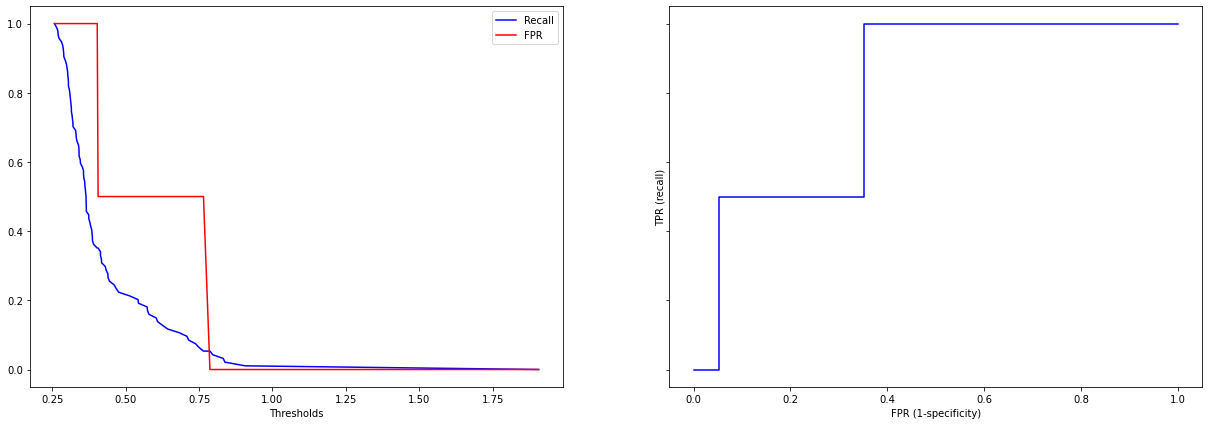

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.688921  0.575250   0.744689     0.802532  0.648733  0.753268
Validation  0.682602  0.575129   0.734553     0.790625  0.644320  0.736961

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004895  0.023116   0.008927     0.016384  0.012184  0.004822
Validation  0.034198  0.050942   0.042821     0.039726  0.043058  0.033488

NuSVC 1
specified nu is infeasible


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
SVC 0.5     0.680527  0.578254   0.731494     0.783333  0.644831  0.736567
SVC 1       0.675864  0.574098   0.722448     0.778125  0.639178  0.727260
SVC 1.5     0.689354  0.557528   0.759021     0.821875  0.642397  0.751655
SVC 2       0.675847  0.553426   0.735298     0.798958  0.631051  0.726255
NuSVC 0.25  0.611968  0.433247   0.686194     0.791667  0.526949  0.626578
NuSVC 0.5   0.642617  0.474721   0.718492     0.811458  0.570096  0.657421
NuSVC 0.75  0.682602  0.575129   0.734553     0.790625  0.644320  0.736961
NuSVC 1     0.000000  0.000000   0.000000     0.000000  0.000000  0.000000

Accuracy  \
SVC 0.5      0.659217536265448-0.7018360043217713   
SVC 1       0.6647111557253623-0.6870159599913909   
SVC 1.5     0.6657049703220028-0.7130029312324013   
SVC 2        0.658546802584007-0.6931479297130568   
NuSVC 0.25  0.5945539421025845-0.6293828022842896   
NuSVC 0.5    0.619048541620209-0.6661846190015526   
NuSVC 0.75  0.6609731926821931-0.7042308228618483   
NuSVC 1                                   0.0-0.0   

                                           Recall  \
SVC 0.5      0.555947151897435-0.6005605800613281   
SVC 1         0.5495512459729097-0.59864463031575   
SVC 1.5     0.5282509071942967-0.5868049347301021   
SVC 2       0.5315712634680786-0.5752801111023681   
NuSVC 0.25   0.4002703344707317-0.466224510890093   
NuSVC 0.5   0.4391296359799756-0.5103119447760383   
NuSVC 0.75  0.5429103316160402-0.6073474003427226   
NuSVC 1                                   0.0-0.0   

                                        Precision  \
SVC 0.5      0.697910903344117-0.7650779955888457   
SVC 1       0.7114911054016158-0.7334057117522192   
SVC 1.5     0.7283678728068657-0.7896743087469915   
SVC 2       0.7103373729982194-0.7602580320808003   
NuSVC 0.25  0.6432637330942752-0.7291234852227302   
NuSVC 0.5   0.6813840357647697-0.7555991933966278   
NuSVC 0.75  0.7074712731549018-0.7616354038911108   
NuSVC 1                                   0.0-0.0   

                                      Specificity  \
SVC 0.5     0.7464819467738291-0.8201847198928378   
SVC 1       0.7642187608371522-0.7920312391628477   
SVC 1.5     0.7973325041012885-0.8464174958987115   
SVC 2       0.7765524086043031-0.8213642580623634   
NuSVC 0.25  0.7409199280376524-0.8424134052956809   
NuSVC 0.5     0.7808003610352163-0.84211630563145   
NuSVC 0.75  0.7654999270623256-0.8157500729376744   
NuSVC 1                                   0.0-0.0   

                                               F1  \
SVC 0.5     0.6238027946553056-0.6658589941481755   
SVC 1       0.6222221987205804-0.6561331130358149   
SVC 1.5     0.6137719963726102-0.6710227068112967   
SVC 2       0.6108360969923332-0.6512665623489877   
NuSVC 0.25   0.505075348934356-0.5488233475360662   
NuSVC 0.5   0.5376751962422401-0.6025170395186279   
NuSVC 0.75  0.6170879564561064-0.6715522983831371   
NuSVC 1                                   0.0-0.0   

                                          ROC_AUC  
SVC 0.5     0.7205621355287218-0.7525708738498579  
SVC 1       0.7152454743260414-0.7392737839786551  
SVC 1.5      0.733185484275333-0.7701244249815399  
SVC 2       0.7082082411510299-0.7443018488761751  
NuSVC 0.25   0.606947440900929-0.6462076502001592  
NuSVC 0.5    0.627849513020284-0.6869927827629346  
NuSVC 0.75  0.7157814605013504-0.7581414123150871  
NuSVC 1                                   0.0-0.0

In [51]:
svm_models = {
    "SVC 0.5" : SVC(C=0.5, probability=True),
    "SVC 1" : SVC(C=1, probability=True),
    "SVC 1.5" : SVC(C=1.5, probability=True),
    "SVC 2" : SVC(C=2, probability=True),
    "NuSVC 0.25" : NuSVC(nu=0.25, probability=True),
    "NuSVC 0.5" : NuSVC(nu=0.5, probability=True),
    "NuSVC 0.75" : NuSVC(nu=0.75, probability=True),
    "NuSVC 1" : NuSVC(nu=1, probability=True)
}

run_models(selected_dataset, y[selected_dataset.index], svm_models, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.36
╠■■■■■■■■■╣
Threshold: 0.37
╠■■■■■■■■■╣
Threshold: 0.38
╠■■■■■■■■■╣
Threshold: 0.39
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.41000000000000003
╠■■■■■■■■■╣
Threshold: 0.42
╠■■■■■■■■■╣
Threshold: 0.43
╠■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■╣
Threshold: 0.45


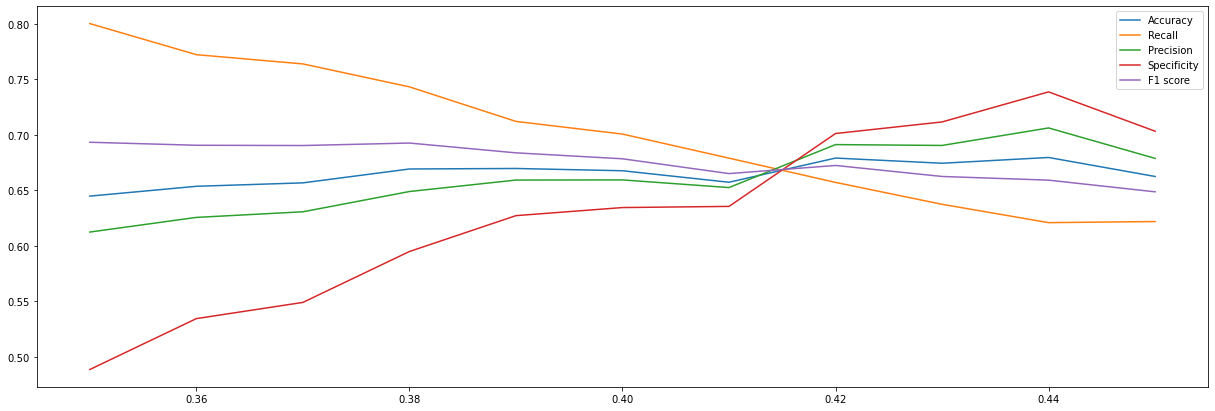

0.35      0.36      0.37      0.38      0.39      0.40  \
Accuracy     0.644676  0.653514  0.656601  0.669101  0.669568  0.667517   
Recall       0.800043  0.772047  0.763724  0.743063  0.711942  0.700548   
Precision    0.612319  0.625503  0.630563  0.648814  0.659134  0.659264   
Specificity  0.488542  0.534375  0.548958  0.594792  0.627083  0.634375   
F1           0.693171  0.690468  0.690230  0.692462  0.683645  0.678284   

                 0.41      0.42      0.43      0.44      0.45  
Accuracy     0.657157  0.678943  0.674269  0.679469  0.662354  
Recall       0.678866  0.657023  0.637307  0.620790  0.621778  
Precision    0.652378  0.691070  0.690294  0.706064  0.678648  
Specificity  0.635417  0.701042  0.711458  0.738542  0.703125  
F1           0.664960  0.672283  0.662365  0.659057  0.648539

In [52]:
run_threshold(selected_dataset, y[selected_dataset.index], svm_models["SVC 1"], thresholds=np.linspace(.35, .45, num=11))

In [53]:
imputer = Imputer()
imputer.fit_transform(selected_dataset, y[selected_dataset.index])
imp_x = test_x[selected_dataset.columns].copy()
imputer.transform(imp_x)
svc = SVC(C=2, probability=True)

train_x = pd.concat([selected_dataset[y[selected_dataset.index] == "Positive"], selected_dataset[y[selected_dataset.index] == "Negative"].sample((selected_dataset[y[selected_dataset.index] == "Positive"]).shape[0])])
svc.fit(train_x, y[train_x.index])
t_preds = svc.predict_proba(train_x)
t_preds = pd.cut(t_preds[:,1], [-1, .38, 1.1], labels=["Negative", "Positive"], right=False)
preds = svc.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .38, 1.1], labels=["Negative", "Positive"], right=False)

random_even = DummyClassifier(strategy="uniform")
random_even.fit(train_x, y[train_x.index])

random_stratified = DummyClassifier(strategy="stratified")
random_stratified.fit(train_x, y[train_x.index])

pd.DataFrame([get_metrics(y[train_x.index], t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
             index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

Accuracy    Recall  Precision  Specificiy        F1
Training Data      0.689637  0.719171   0.679061    0.660104  0.698541
Test Data          0.061315  0.971831   0.027672    0.035601  0.053812
Random 50/50       0.498646  0.507042   0.027756    0.498409  0.052632
Random stratified  0.488975  0.563380   0.030075    0.486874  0.057102

The SVM seems to perform slightly better on training data than Logistic Regression. However, on test data they seem to perform roughly the same

## Ensemble models

In [54]:
class CustomModel():

    def __init__(self):
        self.model_1 = LogisticRegression() #The best model (has very high accuracy and precission but not very good recall. Good for determining Positive results)
        self.model_2 = RandomForestClassifier() #The one with the best recall. Poor specificity and precision but high recall. Good for determining Negative results
        self.model_3 = XGBAdapter() #The one with high accuracy, and balanced recall and precision. If none of the other 2 are sure this is the tie breaker
        self.imputer = Imputer()
        
    def fit(self, data_x, data_y):
        self.imputer.fit(data_x, data_y)
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
        self.model_1.fit(data_1, data_y[data_1.index])
        self.model_2.fit(data_2, data_y[data_2.index])
        self.model_3.fit(data_3, data_y[data_3.index])
        
    def predict(self, data_x):
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict(data_1)
        preds_2 = self.model_2.predict(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        #final_preds = np.sum(np.array([preds_1, preds_2, preds_3]), axis = 0)
        
        #final_preds[final_preds <=1] = "Negative"
        #final_preds[final_preds != "Negative" ] = "Positive"
        final_preds[final_preds == True] = "Positive"
        final_preds[final_preds == False] = "Negative"
        return final_preds
        
    def predict_proba(self, data_x):
        
        data_1 = data_x.iloc[:,16:]
        data_2 = data_x.iloc[:,:10]
        data_3 = pd.merge(data_x.iloc[:,10-16].drop(columns=["sys", "dia"]), data_x.iloc[:,21:], left_index=True, right_index=True)
                
        preds_1 = self.model_1.predict_proba(data_1)
        preds_2 = self.model_2.predict_proba(data_2)
        preds_3 = self.model_3.predict(data_3)
        
        preds_1[preds_1 == "Positive"] = True
        preds_1[preds_1 == "Negative"] = False
        preds_2[preds_2 == "Positive"] = True
        preds_2[preds_2 == "Negative"] = False
        preds_3[preds_3 == "Positive"] = True
        preds_3[preds_3 == "Negative"] = False
        
        final_preds = ((preds_1)| (preds_2 & preds_3)) #If predicted positive by model 1 then we keep that prediction. If predicted negative by model 2, we try to keep it. In case preds1 is False and preds2 is True the final decision is with preds3
        
        final_preds[final_preds == True] = 1 # Not the real probability, but just a placeholder to make the cross_validation method to work
        final_preds[final_preds == False] = 0
        
        final_preds = np.zeros((final_preds.shape[0], 2)) + final_preds #both positive and negative probability will be the same, which is incorrect but for this purpose it doesnt matter
        print(final_preds)
        return np.array(final_preds)

In [55]:
run_models(X, y, {"FirstEnsembleModel" : CustomModel()}, folds=10, ratio_negatives_to_positives=1)

FirstEnsembleModel
operands could not be broadcast together with shapes (1944,2) (1944,) 


Accuracy  Recall  Precision  Specificity   F1  ROC_AUC
FirstEnsembleModel       0.0     0.0        0.0          0.0  0.0      0.0

Accuracy   Recall Precision Specificity       F1  ROC_AUC
FirstEnsembleModel  0.0-0.0  0.0-0.0   0.0-0.0     0.0-0.0  0.0-0.0  0.0-0.0

In [56]:
weights=(np.ones(y[ra_symptoms_vitals.index].shape) + (y[ra_symptoms_vitals.index]=="Negative"))

╠■■■■■■■■■╣
Threshold: 0.25
╠■■■■■■■■■╣
Threshold: 0.275
╠■■■■■■■■■╣
Threshold: 0.3
╠■■■■■■■■■╣
Threshold: 0.325
╠■■■■■■■■■╣
Threshold: 0.35
╠■■■■■■■■■╣
Threshold: 0.375
╠■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■╣
Threshold: 0.42500000000000004
╠■■■■■■■■■╣
Threshold: 0.45
╠■■■■■■■■■╣
Threshold: 0.475
╠■■■■■■■■■╣
Threshold: 0.5


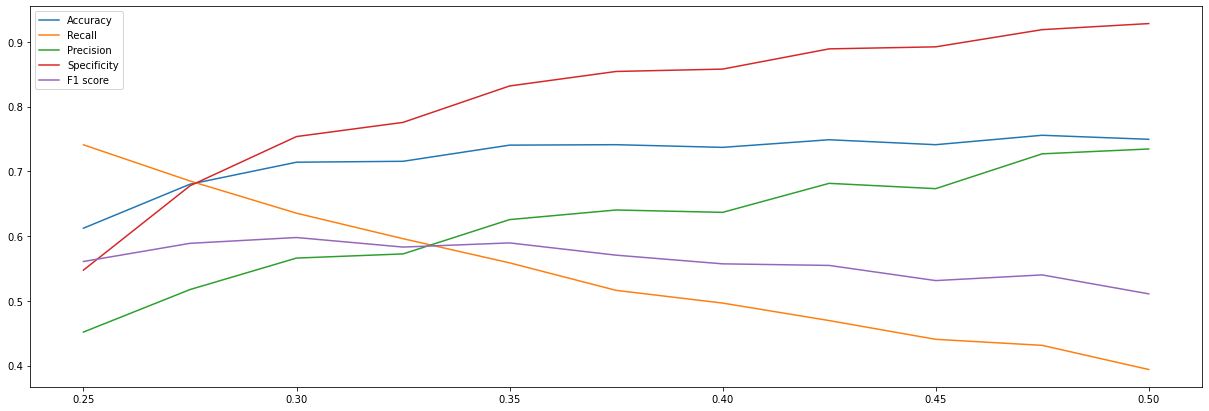

0.250     0.275     0.300     0.325     0.350     0.375  \
Accuracy     0.612122  0.680053  0.714022  0.715429  0.740391  0.741080   
Recall       0.740915  0.684998  0.635288  0.595898  0.558580  0.516119   
Precision    0.451727  0.517339  0.565972  0.572388  0.625386  0.640224   
Specificity  0.547396  0.677604  0.753646  0.775521  0.831771  0.854167   
F1           0.560689  0.588740  0.597721  0.582957  0.589402  0.570465   

                0.400     0.425     0.450     0.475     0.500  
Accuracy     0.736940  0.748710  0.741073  0.755636  0.749398  
Recall       0.496467  0.469459  0.440496  0.431175  0.393879  
Precision    0.636571  0.681379  0.673169  0.726961  0.734451  
Specificity  0.857812  0.889062  0.892188  0.918750  0.928125  
F1           0.557060  0.554619  0.531200  0.539978  0.510734

In [57]:
run_threshold(selected_dataset, y[selected_dataset.index], models["Logistic Regression"], thresholds=np.linspace(0.25,0.5,num=11), ratio_negatives_to_positives=2)

In general it seems that normal logistic regression beats all of the other datasets, although by running the experiment multiple times there is no clear winner (all of the results vary a lot to decide a clear winner

In [58]:
ada_configurations = {
    "Ada Vanilla" : AdaBoostClassifier(),
    "Ada Logistic" : AdaBoostClassifier(base_estimator=LogisticRegression()),
    "Ada algo" : AdaBoostClassifier(algorithm="SAMME"),
    "Ada learning rate" : AdaBoostClassifier(learning_rate=.5),
    "Ada complete" : AdaBoostClassifier(base_estimator=LogisticRegression(C=.5), algorithm="SAMME", learning_rate=.5)
    
}

Ada Vanilla
╠■■■■■■■■■╣


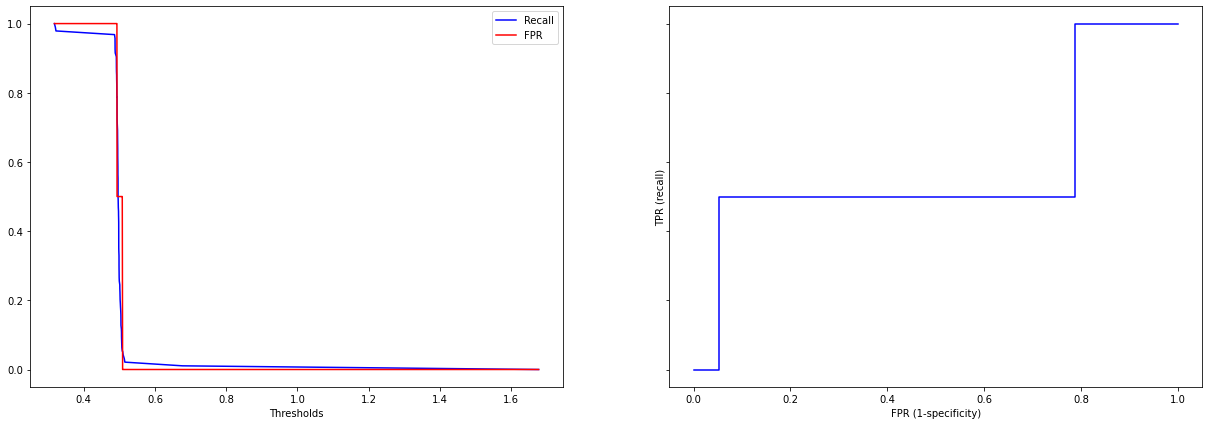

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.701238  0.609100   0.746826     0.793326  0.670892  0.770687
Validation  0.676363  0.569899   0.727615     0.783333  0.638095  0.721880

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010924  0.008931   0.017272     0.018188  0.010239  0.010012
Validation  0.033274  0.044104   0.048876     0.051921  0.038061  0.018681

Ada Logistic
╠■■■■■■■■■╣


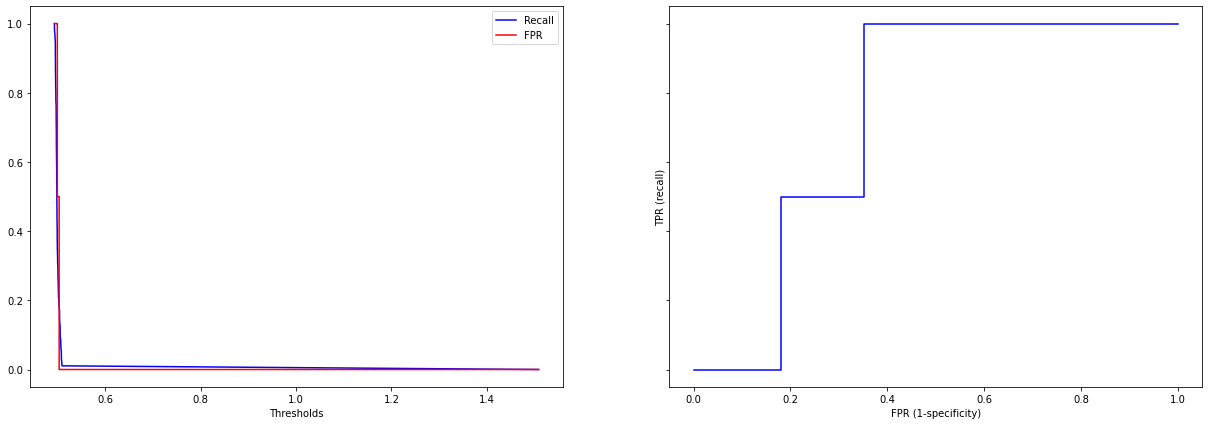

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.686965  0.592516   0.730481     0.781358  0.654206  0.745447
Validation  0.670663  0.587597   0.707916     0.754167  0.640685  0.725562

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005563  0.012178   0.008944     0.011848  0.007448  0.005610
Validation  0.031257  0.053970   0.041669     0.052014  0.037885  0.031195

Ada algo
╠■■■■■■■■■╣


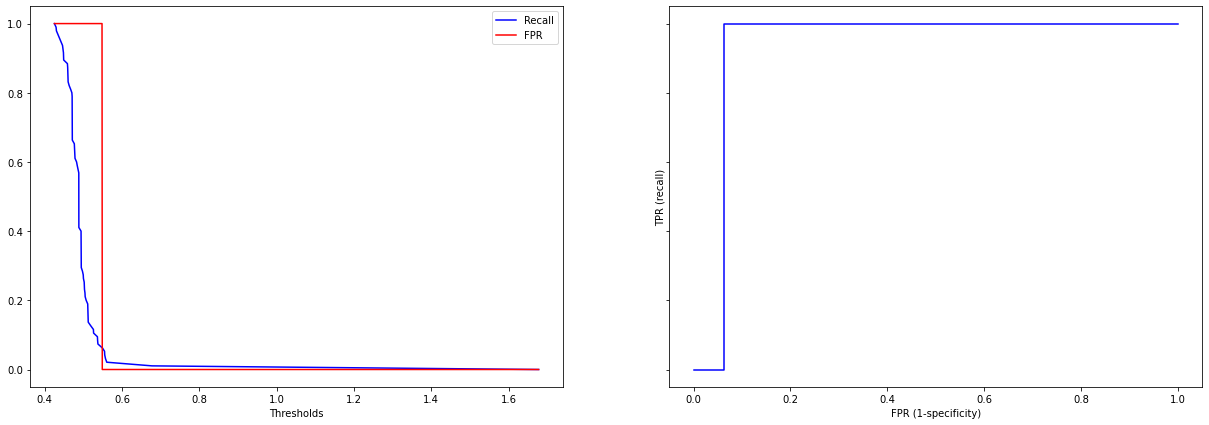

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.685583  0.602076   0.723896     0.769045  0.656608  0.744272
Validation  0.659237  0.588595   0.688949     0.730208  0.633577  0.708035

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.005147  0.028193   0.020170     0.032760  0.010202  0.006693
Validation  0.033155  0.046654   0.044048     0.056938  0.035824  0.041324

Ada learning rate
╠■■■■■■■■■╣


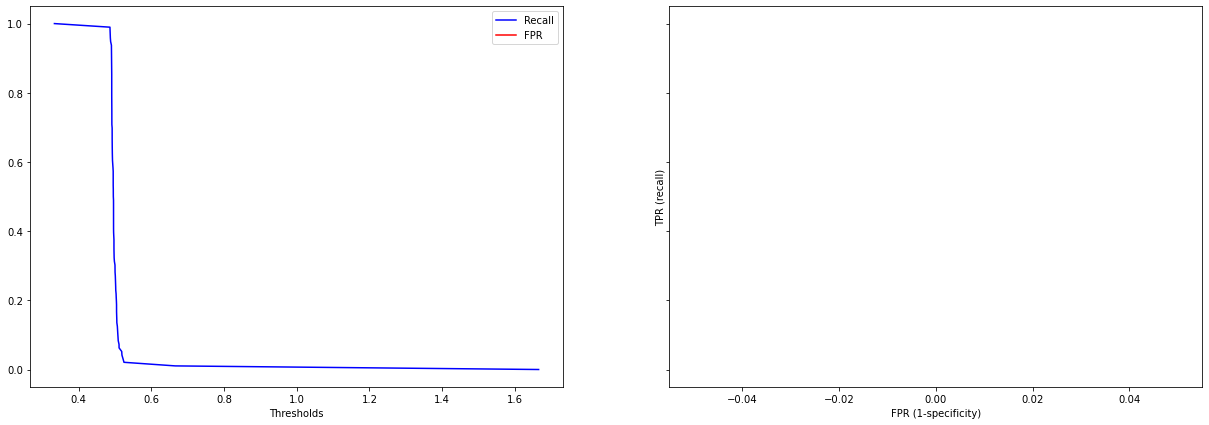

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.697900  0.589176   0.752983     0.806559  0.660906  0.765704
Validation  0.669616  0.570017   0.713711     0.769792  0.632654  0.723458

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007311  0.015765   0.012367     0.015271  0.009923  0.006371
Validation  0.025652  0.054271   0.029166     0.033105  0.037097  0.025145

Ada complete
╠■■■■■■■■■╣


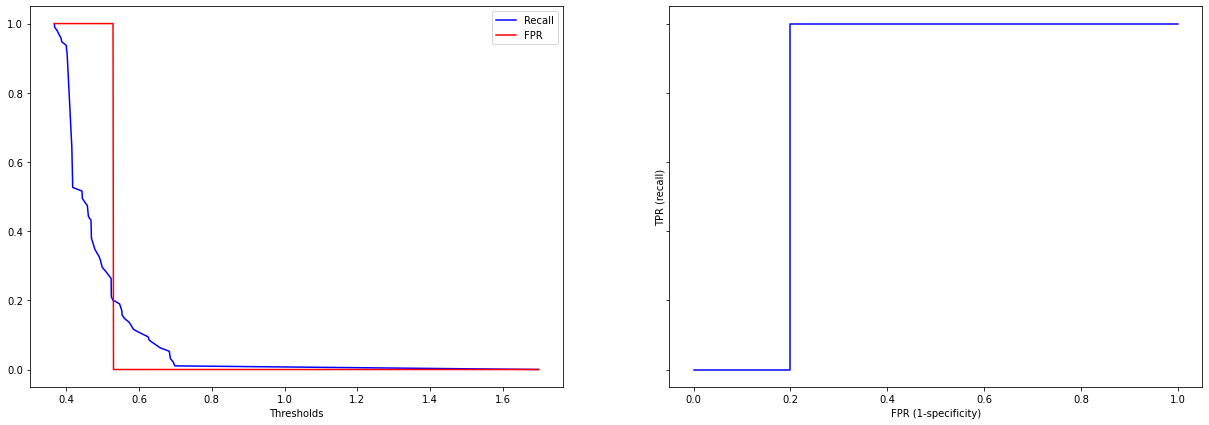

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.674763  0.631082   0.692240     0.718412  0.659735  0.732166
Validation  0.666988  0.620790   0.687679     0.713542  0.651332  0.717485

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.010940  0.023776   0.020176     0.032778  0.010993  0.006608
Validation  0.040511  0.048963   0.050026     0.064820  0.039341  0.044555

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.676363  0.569899   0.727615     0.783333  0.638095   
Ada Logistic       0.670663  0.587597   0.707916     0.754167  0.640685   
Ada algo           0.659237  0.588595   0.688949     0.730208  0.633577   
Ada learning rate  0.669616  0.570017   0.713711     0.769792  0.632654   
Ada complete       0.666988  0.620790   0.687679     0.713542  0.651332   

                    ROC_AUC  
Ada Vanilla        0.721880  
Ada Logistic       0.725562  
Ada algo           0.708035  
Ada learning rate  0.723458  
Ada complete       0.717485

Accuracy  \
Ada Vanilla        0.6553186496930886-0.6974069547974125   
Ada Logistic       0.6508943585818328-0.6904322821780982   
Ada algo           0.6382683609753653-0.6802063799572774   
Ada learning rate  0.6533923530365161-0.6858401599168519   
Ada complete       0.6413666622153175-0.6926089422751832   

                                                  Recall  \
Ada Vanilla        0.5420054681960123-0.5977926417696233   
Ada Logistic       0.5534628670642512-0.6217304319048211   
Ada algo            0.559088806815886-0.6181019148335988   
Ada learning rate   0.5356930210818703-0.604341343179298   
Ada complete       0.5898234604039023-0.6517572956098434   

                                               Precision  \
Ada Vanilla         0.6967029773570615-0.758526949356413   
Ada Logistic       0.6815623148337128-0.7342703730036869   
Ada algo           0.6610905913522838-0.7168077431878057   
Ada learning rate  0.6952641691615189-0.7321569110306319   
Ada complete       0.6560400206155887-0.7193188589680091   

                                             Specificity  \
Ada Vanilla         0.7504955821735086-0.816171084493158   
Ada Logistic        0.7212702242157583-0.787063109117575   
Ada algo           0.6941975217709329-0.7662191448957338   
Ada learning rate  0.7488544257893315-0.7907289075440018   
Ada complete       0.6725459107134849-0.7545374226198486   

                                                      F1  \
Ada Vanilla         0.6140235679459347-0.662167298170597   
Ada Logistic        0.616724291841229-0.6646449116492925   
Ada algo           0.6109201899989923-0.6562344136438759   
Ada learning rate  0.6091917976388375-0.6561158479306852   
Ada complete       0.6264502377138982-0.6762128693643755   

                                                 ROC_AUC  
Ada Vanilla        0.7100648022831856-0.7336944823316484  
Ada Logistic       0.7058321872241647-0.7452910274450791  
Ada algo           0.6819000312224045-0.7341709658781107  
Ada learning rate   0.707554734016629-0.7393609840532449  
Ada complete        0.689306045674148-0.7456641764406857

In [59]:
run_models(selected_dataset, y[selected_dataset.index], ada_configurations, ratio_negatives_to_positives=1)

Ada Vanilla
╠■■■■■■■■■╣


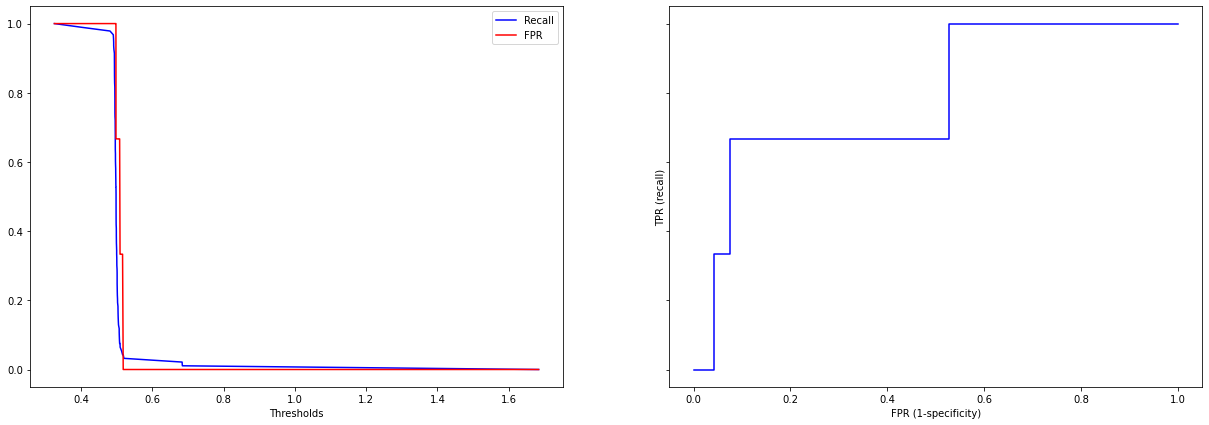

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.699453  0.599197   0.749900     0.799655  0.665841  0.770300
Validation  0.672202  0.575140   0.716505     0.769792  0.637015  0.721053

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007669  0.016426   0.016929     0.022131  0.008548  0.007551
Validation  0.035089  0.050462   0.047543     0.047469  0.041756  0.031116

Ada Logistic
╠■■■■■■■■■╣


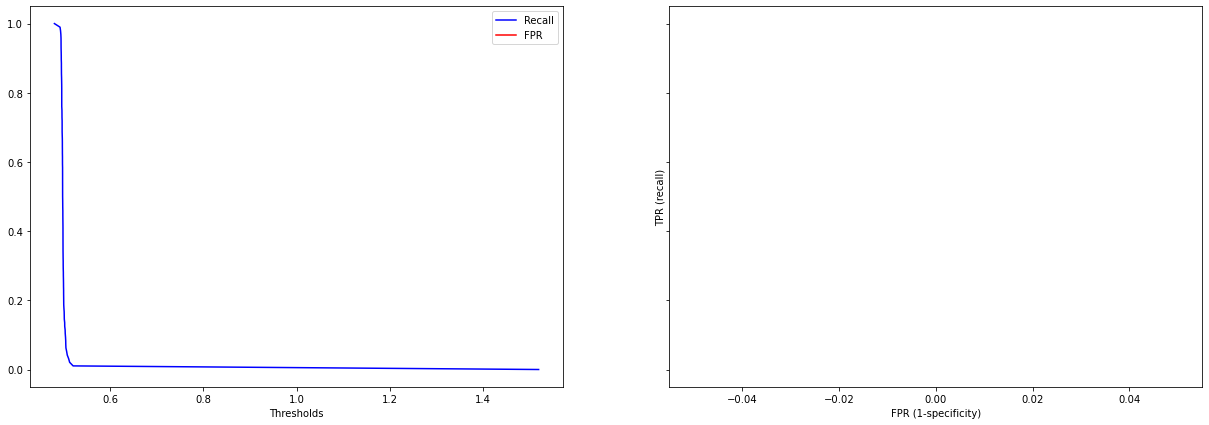

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.683165  0.585144   0.727726     0.781128  0.648631  0.738691
Validation  0.685697  0.574152   0.741376     0.797917  0.646487  0.736034

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.004512  0.010390   0.006477     0.008453  0.006561  0.007061
Validation  0.032276  0.043009   0.042900     0.039650  0.037804  0.027594

Ada algo
╠■■■■■■■■■╣


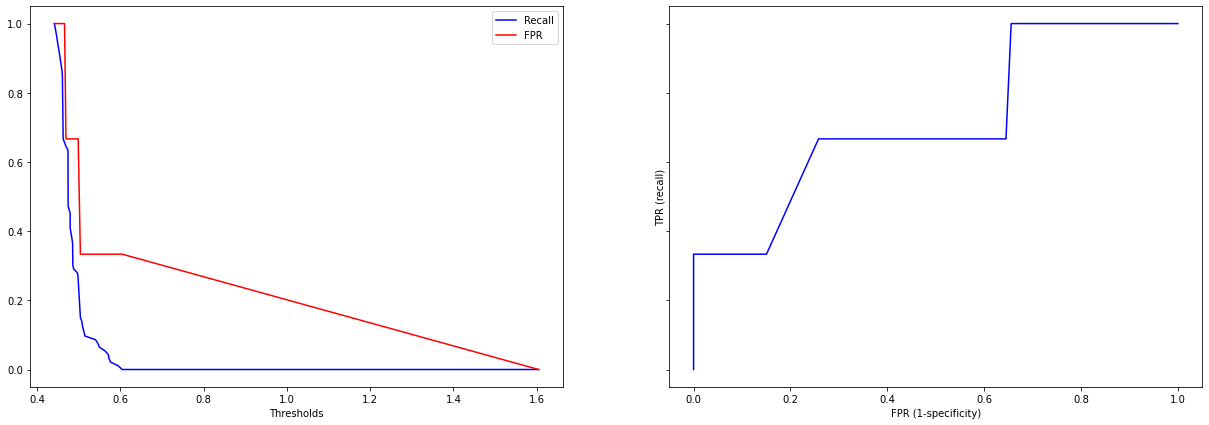

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.682591  0.583766   0.728788     0.781358  0.647048  0.744817
Validation  0.673769  0.570006   0.723026     0.778125  0.635784  0.715364

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008593  0.040907   0.019559     0.034145  0.020303  0.008242
Validation  0.033435  0.055786   0.045155     0.054912  0.040721  0.042618

Ada learning rate
╠■■■■■■■■■╣


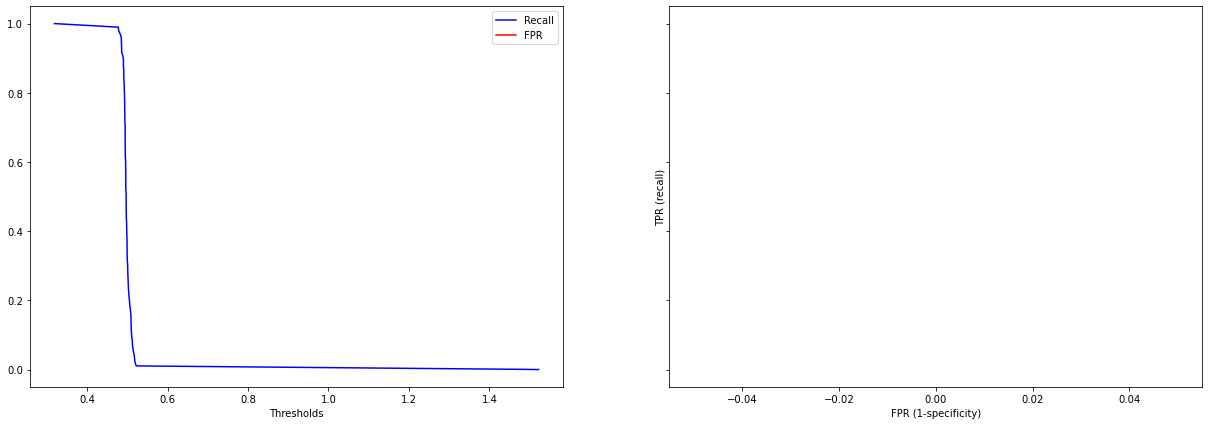

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.700315  0.592973   0.755085     0.807595  0.664220  0.767954
Validation  0.668075  0.559654   0.717511     0.777083  0.627304  0.726299

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.008240  0.008774   0.013545     0.013689  0.008433  0.008062
Validation  0.022134  0.052373   0.029410     0.038100  0.033139  0.027076

Ada complete
╠■■■■■■■■■╣


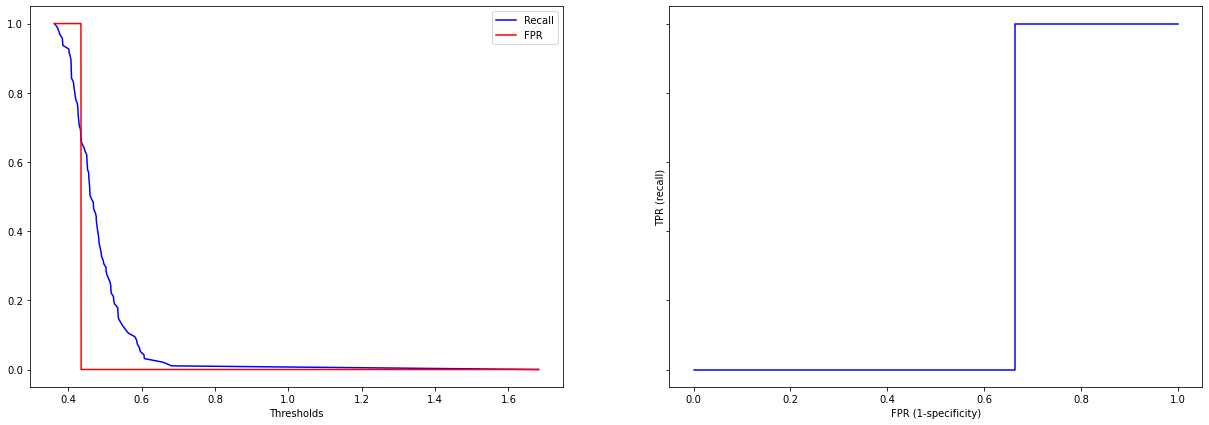

feature_importances
Unable to compute feature importances since base_estimator does not have a feature_importances_ attribute

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.673037  0.627978   0.690534     0.718067  0.657471  0.723329
Validation  0.658220  0.612586   0.676773     0.704167  0.642124  0.712471

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.007219  0.017975   0.014582     0.023992  0.007783  0.004891
Validation  0.026463  0.042495   0.033470     0.047151  0.028782  0.031456

Accuracy    Recall  Precision  Specificity        F1  \
Ada Vanilla        0.672202  0.575140   0.716505     0.769792  0.637015   
Ada Logistic       0.685697  0.574152   0.741376     0.797917  0.646487   
Ada algo           0.673769  0.570006   0.723026     0.778125  0.635784   
Ada learning rate  0.668075  0.559654   0.717511     0.777083  0.627304   
Ada complete       0.658220  0.612586   0.676773     0.704167  0.642124   

                    ROC_AUC  
Ada Vanilla        0.721053  
Ada Logistic       0.736034  
Ada algo           0.715364  
Ada learning rate  0.726299  
Ada complete       0.712471

Accuracy  \
Ada Vanilla        0.6500091828979491-0.6943938827324483   
Ada Logistic       0.6652838911228129-0.7061107548184653   
Ada algo           0.6526231626071651-0.6949156974964618   
Ada learning rate  0.6540766809311486-0.6820740099151382   
Ada complete       0.6414830551295083-0.6749569275993343   

                                                  Recall  \
Ada Vanilla         0.5432249398881359-0.607054269733857   
Ada Logistic       0.5469506384135742-0.6013526261912366   
Ada algo           0.5347243890480409-0.6052884975498973   
Ada learning rate  0.5265303845185254-0.5927780347254608   
Ada complete       0.5857098438282883-0.6394619774775535   

                                               Precision  \
Ada Vanilla        0.6864357791207116-0.7465733717367213   
Ada Logistic       0.7142438236997741-0.7685083481370956   
Ada algo           0.6944672690540912-0.7515844868149217   
Ada learning rate  0.6989108259018973-0.7361117959972158   
Ada complete       0.6556045624515667-0.6979411394001986   

                                             Specificity  \
Ada Vanilla        0.7397694912205316-0.7998138421128017   
Ada Logistic       0.7728396248815724-0.8229937084517608   
Ada algo            0.7433958340276389-0.812854165972361   
Ada learning rate   0.752987011704309-0.8011796549623577   
Ada complete        0.674345957564467-0.7339873757688666   

                                                      F1  \
Ada Vanilla         0.610606314860866-0.6634245641975167   
Ada Logistic        0.6225775422577375-0.670396145671438   
Ada algo             0.61002990531739-0.6615388050616792   
Ada learning rate    0.6063451574316566-0.64826330865929   
Ada complete       0.6239200464953883-0.6603271047266491   

                                                 ROC_AUC  
Ada Vanilla        0.7013736586045165-0.7407320696672475  
Ada Logistic       0.7185823695075156-0.7534863769128738  
Ada algo           0.6884099098955834-0.7423180262799609  
Ada learning rate  0.7091739215268706-0.7434230859187192  
Ada complete       0.6925765928891967-0.7323654621652134

In [60]:
run_models(ra_symptoms_vitals, y[ra_symptoms_vitals.index], ada_configurations, ratio_negatives_to_positives=1)

╠■■■■■■■■■╣
Threshold: 0.49
╠■■■■■■■■■╣
Threshold: 0.491
╠■■■■■■■■■╣
Threshold: 0.492
╠■■■■■■■■■╣
Threshold: 0.493
╠■■■■■■■■■╣
Threshold: 0.494
╠■■■■■■■■■╣
Threshold: 0.495
╠■■■■■■■■■╣
Threshold: 0.496
╠■■■■■■■■■╣
Threshold: 0.497
╠■■■■■■■■■╣
Threshold: 0.498
╠■■■■■■■■■╣
Threshold: 0.499
╠■■■■■■■■■╣
Threshold: 0.5


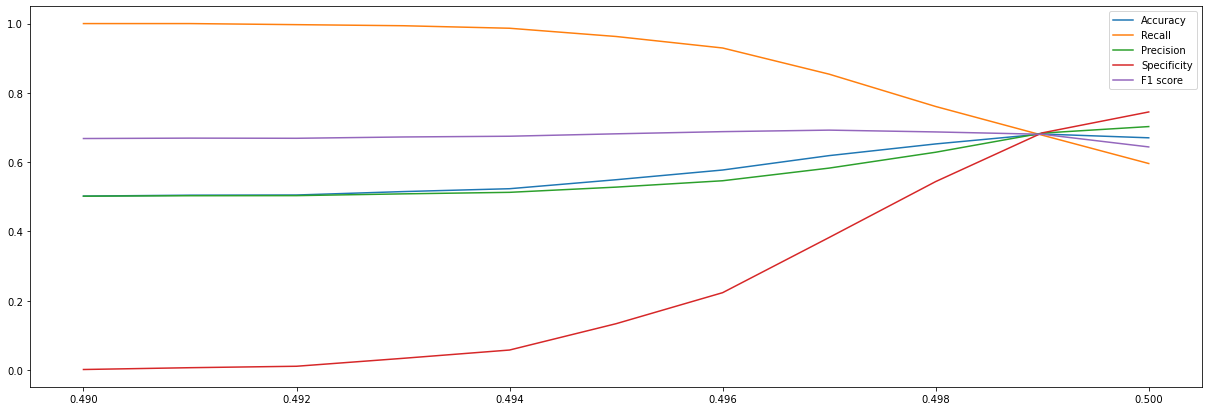

0.490     0.491     0.492     0.493     0.494     0.495  \
Accuracy     0.501813  0.504415  0.504933  0.514815  0.523111  0.549074   
Recall       1.000000  1.000000  0.996896  0.993793  0.986512  0.962704   
Precision    0.501557  0.502871  0.503147  0.508262  0.512657  0.527711   
Specificity  0.001042  0.006250  0.010417  0.033333  0.057292  0.133333   
F1           0.668048  0.669211  0.668755  0.672539  0.674681  0.681654   

                0.496     0.497     0.498     0.499     0.500  
Accuracy     0.577132  0.618701  0.652445  0.681050  0.670124  
Recall       0.929521  0.853898  0.760567  0.677760  0.595887  
Precision    0.546111  0.582656  0.628466  0.683683  0.702561  
Specificity  0.222917  0.382292  0.543750  0.684375  0.744792  
F1           0.687920  0.692308  0.687089  0.680366  0.643808

In [61]:
run_threshold(selected_dataset, y[selected_dataset.index], ada_configurations["Ada Logistic"], thresholds=np.linspace(0.49, 0.50, num=11), ratio_negatives_to_positives=1)

Accuracy    Recall  Precision  Specificity        F1
Metrics  0.701172  0.566116   0.740541     0.822222  0.641686

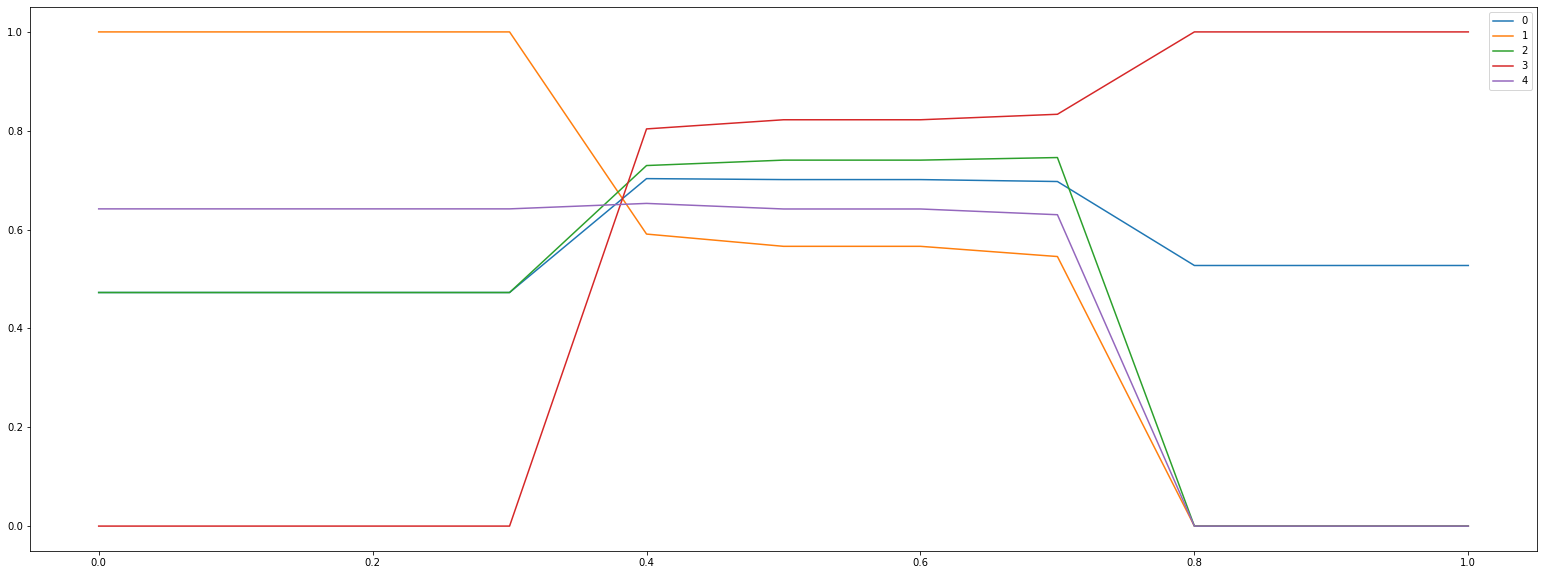

0.0       0.1       0.2       0.3       0.4       0.5  \
Accuracy     0.472656  0.472656  0.472656  0.472656  0.703125  0.701172   
Recall       1.000000  1.000000  1.000000  1.000000  0.590909  0.566116   
Precision    0.472656  0.472656  0.472656  0.472656  0.729592  0.740541   
Specificity  0.000000  0.000000  0.000000  0.000000  0.803704  0.822222   
F1           0.641910  0.641910  0.641910  0.641910  0.652968  0.641686   

                  0.6       0.7       0.8       0.9       1.0  
Accuracy     0.701172  0.697266  0.527344  0.527344  0.527344  
Recall       0.566116  0.545455  0.000000  0.000000  0.000000  
Precision    0.740541  0.745763  0.000000  0.000000  0.000000  
Specificity  0.822222  0.833333  1.000000  1.000000  1.000000  
F1           0.641686  0.630072  0.000000  0.000000  0.000000

In [62]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.model_selection import train_test_split

test_data = pd.concat([selected_dataset[y=="Positive"], selected_dataset[y=="Negative"].sample(np.sum(y=="Positive"))])

X_train, X_test, y_train, y_test = train_test_split(test_data, y[test_data.index])


stack_classifier = StackingCVClassifier([models["Logistic Regression"], ada_configurations["Ada Logistic"]], meta_classifier=RandomForestClassifier())

imp = Imputer()
imp.fit_transform(X_train, y_train)
imp.transform(X_test)

y_train[y_train == "Positive"] = 1
y_train[y_train == "Negative"] = 0
y_train = y_train.astype("float")

stack_classifier.fit(X_train, y_train)

y_preds = stack_classifier.predict(X_test)
y_preds = y_preds.astype("object")
y_preds[y_preds == 1] = "Positive"
y_preds[y_preds == 0] = "Negative"

display(pd.DataFrame(data=np.array(get_metrics(y_test, y_preds)).reshape((1,5)), index=["Metrics"], columns=["Accuracy", "Recall", "Precision", "Specificity", "F1"]))

scores = np.ones((11, 5))
thresholds = np.linspace(0, 1, num=11)
i = 0
for threshold in thresholds:
    y_preds = stack_classifier.predict_proba(X_test)
    y_preds = y_preds[:,1]
    y_preds[y_preds >= threshold] = 1
    y_preds[y_preds < 1] = 0
    
    
    
    y_preds = y_preds.astype("object")
    y_preds[y_preds == 1] = "Positive"
    y_preds[y_preds == 0] = "Negative"
    
    scores[i] = get_metrics(y_test, y_preds)
    i+=1

plt.figure(figsize=(27, 10))
for i in range(scores.shape[1]):
    plt.plot(thresholds, scores[:,i], label=i)

plt.legend()
plt.show()
pd.DataFrame(scores.transpose(), index=["Accuracy", "Recall", "Precision", "Specificity", "F1"], columns=thresholds)

Apparently stacking and ensemble models do not do much better than regular logistic regression

### SMOTE

In [63]:
models_smote ={
    "MultinomialNB" : MultinomialNB(alpha=0, class_prior=(.5, .5)),
    "Random Forest (100 estimators)" : RandomForestClassifier(min_samples_leaf=100),
    "XGBoost Classifier" : XGBAdapter(n_estimators=500),
    #"SVM" : SVC(kernel='linear', probability=True), #Removed due to getting the notebook stuck
    "KNN" : KNeighborsClassifier(n_neighbors=100, weights="distance"), 
    "Logistic Regression" : LogisticRegression()
}

In [64]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
ratio_negs_to_pos = (y == "Negative").sum() / (y == "Positive").sum()
weights = ((y == "Positive")* ratio_negs_to_pos * 100) + 1

X_copy = X.copy()
imp = Imputer()
imp.fit_transform(X_copy, y)
run_models(X_copy[selected_features], y, models_smote, ratio_negatives_to_positives=-1, sample_weights=weights)

MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.777606  0.516747   0.053856     0.783804  0.097511  0.697176
Validation  0.778398  0.506914   0.053185     0.784869  0.096174  0.694661

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.013575  0.018786   0.002106     0.014300  0.003226  0.007334
Validation  0.013628  0.043941   0.006681     0.014313  0.011269  0.027451

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy  Recall  Precision  Specificity   F1   ROC_AUC
Training    0.976787     0.0        0.0          1.0  0.0  0.676828
Validation  0.976787     0.0        0.0          1.0  0.0  0.664902

Spread in metrics (sample std)


Accuracy  Recall  Precision  Specificity   F1   ROC_AUC
Training    0.000312     0.0        0.0          0.0  0.0  0.008639
Validation  0.002809     0.0        0.0          0.0  0.0  0.021602

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.987046  0.479877   0.926867      0.99910  0.63225  0.922073
Validation  0.969909  0.059233   0.143581      0.99155  0.08330  0.648825

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000413  0.014511   0.008869     0.000110  0.013448  0.004179
Validation  0.002284  0.021092   0.053476     0.001479  0.028908  0.031525

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.975676  0.053219   0.349263     0.997597  0.091930  0.649199
Validation  0.975433  0.056179   0.382133     0.997274  0.094844  0.641837

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000560  0.009969   0.045384     0.000653  0.015550  0.014456
Validation  0.001637  0.025223   0.210587     0.001967  0.040057  0.037882

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.778398  0.506914   0.053185     0.784869   
Random Forest (100 estimators)  0.976787  0.000000   0.000000     1.000000   
XGBoost Classifier              0.969909  0.059233   0.143581     0.991550   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.975433  0.056179   0.382133     0.997274   

                                      F1   ROC_AUC  
MultinomialNB                   0.096174  0.694661  
Random Forest (100 estimators)  0.000000  0.664902  
XGBoost Classifier              0.083300  0.648825  
KNN                             0.000000  0.000000  
Logistic Regression             0.094844  0.641837

Accuracy  \
MultinomialNB                   0.7697792895035156-0.7870169619187033   
Random Forest (100 estimators)  0.9750104042209996-0.9785631831371872   
XGBoost Classifier              0.9684643228653907-0.9713529789650465   
KNN                                                           0.0-0.0   
Logistic Regression             0.9743971288525224-0.9764679829966549   

                                                                  Recall  \
MultinomialNB                     0.47912303684946544-0.5347043900752328   
Random Forest (100 estimators)                                   0.0-0.0   
XGBoost Classifier              0.045893903994749005-0.07257303355302404   
KNN                                                              0.0-0.0   
Logistic Regression              0.04022633380594829-0.07213128306625338   

                                                              Precision  \
MultinomialNB                   0.04895970259676364-0.05741096640658718   
Random Forest (100 estimators)                                  0.0-0.0   
XGBoost Classifier              0.10975990128647681-0.17740184903316822   
KNN                                                             0.0-0.0   
Logistic Regression              0.24894571553190745-0.5153194316016607   

                                                          Specificity  \
MultinomialNB                   0.7758168896619654-0.7939211073351177   
Random Forest (100 estimators)                                1.0-1.0   
XGBoost Classifier              0.9906152234836422-0.9924855280847881   
KNN                                                           0.0-0.0   
Logistic Regression             0.9960294287840104-0.9985181043629665   

                                                                     F1  \
MultinomialNB                    0.0890470265257809-0.10330155927866182   
Random Forest (100 estimators)                                  0.0-0.0   
XGBoost Classifier               0.06501689559828427-0.1015831291716413   
KNN                                                             0.0-0.0   
Logistic Regression             0.06950929070524899-0.12017843881407138   

                                                              ROC_AUC  
MultinomialNB                   0.6772994246407287-0.7120227799311885  
Random Forest (100 estimators)  0.6512400003497038-0.6785642711866796  
XGBoost Classifier              0.6288864280439014-0.6687630565491295  
KNN                                                           0.0-0.0  
Logistic Regression             0.6178781832896774-0.6657955101285233

Here I am using sample weights instead of SMOTE to compare the performance between the 2 approaches. Apparently the using sample weights do not yield good results at all.

In [65]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.preprocessing import LabelEncoder

X_copy = X.copy()

imp = Imputer()
imp.fit_transform(X_copy, y)

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y)
print(y_copy.value_counts())
run_models(X_copy[selected_features], y_copy, models_smote, ratio_negatives_to_positives=-1)

(46525, 34)
Negative    45445
Positive    45445
Name: covid19_test_results, dtype: int64
MultinomialNB
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.646498  0.552593   0.680383     0.740399  0.609862  0.700557
Validation  0.646529  0.552413   0.680582     0.740737  0.609776  0.700501

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000978  0.001711   0.001815     0.003277  0.000625  0.000439
Validation  0.003749  0.004916   0.011078     0.008204  0.004448  0.004362

Random Forest (100 estimators)
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.928045  0.884118   0.969276     0.971973  0.924740  0.979483
Validation  0.926846  0.882411   0.968358     0.971206  0.923374  0.978505

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.001148  0.001778   0.001360     0.001316  0.001133  0.000518
Validation  0.003753  0.008176   0.002534     0.001695  0.005172  0.002343

XGBoost Classifier
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.982147  0.984878   0.979528     0.979416  0.982196  0.998346
Validation  0.976015  0.976837   0.975249     0.975190  0.976041  0.992355

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000327  0.000419   0.000330     0.000358  0.000314  0.000047
Validation  0.002237  0.002235   0.002395     0.002588  0.002143  0.001020

KNN
fit() got an unexpected keyword argument 'sample_weight'
Logistic Regression
╠■■■■■■■■■╣

Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.669764  0.570283   0.711944     0.769243  0.633281  0.733268
Validation  0.669755  0.570318   0.711935     0.769216  0.633276  0.733163

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.000840  0.002369   0.002234     0.003595  0.000878  0.000835
Validation  0.002606  0.004116   0.007877     0.006844  0.003427  0.003345

Accuracy    Recall  Precision  Specificity  \
MultinomialNB                   0.646529  0.552413   0.680582     0.740737   
Random Forest (100 estimators)  0.926846  0.882411   0.968358     0.971206   
XGBoost Classifier              0.976015  0.976837   0.975249     0.975190   
KNN                             0.000000  0.000000   0.000000     0.000000   
Logistic Regression             0.669755  0.570318   0.711935     0.769216   

                                      F1   ROC_AUC  
MultinomialNB                   0.609776  0.700501  
Random Forest (100 estimators)  0.923374  0.978505  
XGBoost Classifier              0.976041  0.992355  
KNN                             0.000000  0.000000  
Logistic Regression             0.633276  0.733163

Accuracy  \
MultinomialNB                   0.6441578816263007-0.6488996604575368   
Random Forest (100 estimators)  0.9244721626828656-0.9292191124849198   
XGBoost Classifier              0.9745998836994336-0.9774300425850859   
KNN                                                           0.0-0.0   
Logistic Regression             0.6681066017663149-0.6714026951860452   

                                                               Recall  \
MultinomialNB                     0.549303891718716-0.555522490125529   
Random Forest (100 estimators)  0.8772398647826265-0.8875813952091252   
XGBoost Classifier                0.9754227740672129-0.97825026540517   
KNN                                                           0.0-0.0   
Logistic Regression             0.5677154440634996-0.5729213406370867   

                                                            Precision  \
MultinomialNB                   0.6735760050944072-0.6875889297616716   
Random Forest (100 estimators)  0.9667554515466138-0.9699605232125076   
XGBoost Classifier                0.9737344850608404-0.97676337990401   
KNN                                                           0.0-0.0   
Logistic Regression             0.7069526285932068-0.7169164432714499   

                                                          Specificity  \
MultinomialNB                   0.7355485938632703-0.7459263526729044   
Random Forest (100 estimators)   0.970133904591496-0.9722777285768299   
XGBoost Classifier              0.9735525056304318-0.9768266299246787   
KNN                                                           0.0-0.0   
Logistic Regression             0.7648876749016197-0.7735445921786138   

                                                                   F1  \
MultinomialNB                   0.6069632123206937-0.6125896328774868   
Random Forest (100 estimators)  0.9201034324502264-0.9266453368145431   
XGBoost Classifier              0.9746858780419654-0.9773968511326436   
KNN                                                           0.0-0.0   
Logistic Regression             0.6311084149762275-0.6354426451596379   

                                                              ROC_AUC  
MultinomialNB                    0.6977424879506926-0.703260021671609  
Random Forest (100 estimators)  0.9770230239081982-0.9799871069695104  
XGBoost Classifier              0.9917092252481244-0.9929998384862656  
KNN                                                           0.0-0.0  
Logistic Regression             0.7310477749940875-0.7352790540667805

In the initial run logistic regression didn't do better, but surprisingly the tree-based models did extremely well. Although this might be a legit improvement due to now having enough samples, I suspect the tree base models are overfitting since I am doing the cross validation <i>after doing the resampling</i>. The next iteration will be saving a test sample with evenly distributed samples of positive and negative taken away before the resampling and applying SMOTE to the rest.

In [66]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
from sklearn.metrics import confusion_matrix
X_test = pd.concat([X[y=="Positive"].sample(100), X[y=="Negative"].sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test)].copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy.drop(columns=["sys", "dia"]), y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test.drop(columns=["sys", "dia"]))
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test.drop(columns=["sys", "dia"]))[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
display(pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"]))


(46417, 34)
Negative    45344
Positive    45344
Name: covid19_test_results, dtype: int64
MultinomialNB
[[65 35]
 [30 70]]
Random Forest (100 estimators)
[[100   0]
 [ 73  27]]
XGBoost Classifier
[[92  8]
 [27 73]]
KNN
[[93  7]
 [ 4 96]]
Logistic Regression
[[69 31]
 [33 67]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.675    0.70   0.666667         0.65   
Random Forest (100 estimators)     0.635    0.27   1.000000         1.00   
XGBoost Classifier                 0.825    0.73   0.901235         0.92   
KNN                                0.945    0.96   0.932039         0.93   
Logistic Regression                0.680    0.67   0.683673         0.69   

                                      F1  ROC_AUC  
MultinomialNB                   0.682927  0.75000  
Random Forest (100 estimators)  0.425197  0.81200  
XGBoost Classifier              0.806630  0.92640  
KNN                             0.945813  0.99675  
Logistic Regression             0.676768  0.75600

As expected, the tree methods were overfitting. Surprisingly enough, KNN performed really well with oversampling: so far it would be the best model we have. However, since the socres are too high, I believe there might be some kind of overfitting done as well (in order to test this, it might be good to use the data from the dataset from Mexico since, in theory, has no relationship to this one). Logistic Regression is doing a little bit worse than our best model. However it makes me curious to see if by moving the thresholds, the performance improves. If that is the case, doing SMOTE might be a very good thing to do for imbalanced datasets.

In [67]:
#Note: This cell was added before generating the train_test_split from all the data, ie. 'X' and 'y' contained ALL DATAPOINTS in the dataset
X_test = pd.concat([X.loc[y=="Positive", selected_features].dropna(how="all").sample(100), X.loc[y=="Negative", selected_features].dropna(how="all").sample(100)])
y_test = y[X_test.index]
X_copy = X.loc[np.setdiff1d(X.index, X_test), selected_features].dropna(how="all").copy()
imp = Imputer()
imp.fit_transform(X_copy, y[X_copy.index])

print(X_copy.shape)
smote = SMOTE()
X_copy, y_copy = smote.fit_resample(X_copy, y[X_copy.index])
print(y_copy.value_counts())

imp.fit(X_copy, y_copy)
imp.transform(X_test)

results = np.zeros((len(models_smote), 6))
i = 0
for model in models_smote:
    print(Fore.RED, model, Fore.BLACK, sep="")
    models_smote[model].fit(X_copy, y_copy)
    y_preds = models_smote[model].predict(X_test)
    metrics = get_metrics(y_test, y_preds) + (roc_auc_score(y_test, models_smote[model].predict_proba(X_test)[:,1]),)
    print(confusion_matrix(y_test, y_preds, labels=["Negative", "Positive"]))
    results[i] = metrics
    i+=1
    
pd.DataFrame(results, index=models_smote.keys(), columns=["Accuracy", "Recall", "Precision", "Specificity", "F1", "ROC_AUC"])

(46450, 16)
Negative    45374
Positive    45374
Name: covid19_test_results, dtype: int64
MultinomialNB
[[68 32]
 [42 58]]
Random Forest (100 estimators)
[[98  2]
 [76 24]]
XGBoost Classifier
[[92  8]
 [38 62]]
KNN
[[98  2]
 [26 74]]
Logistic Regression
[[71 29]
 [42 58]]


Accuracy  Recall  Precision  Specificity  \
MultinomialNB                      0.630    0.58   0.644444         0.68   
Random Forest (100 estimators)     0.610    0.24   0.923077         0.98   
XGBoost Classifier                 0.770    0.62   0.885714         0.92   
KNN                                0.860    0.74   0.973684         0.98   
Logistic Regression                0.645    0.58   0.666667         0.71   

                                      F1  ROC_AUC  
MultinomialNB                   0.610526  0.70030  
Random Forest (100 estimators)  0.380952  0.75960  
XGBoost Classifier              0.729412  0.90720  
KNN                             0.840909  0.98605  
Logistic Regression             0.620321  0.72630

By just using the selected features, performance on KNN decreases a little bit. Logistic regression on the other hand improved way more than how it was doing in the baseline. I trust these results more because with the complete dataset, apart from the comorbidities, half of the examples have null features.

## Using Significance (z) tests and $\chi^{2}$ tests for all features

In [68]:
X.describe(include="all")

age high_risk_exposure_occupation high_risk_interactions  \
count   46525.000000                         46477                  42730   
unique           NaN                             2                      2   
top              NaN                         False                  False   
freq             NaN                         40704                  32483   
mean        2.266136                           NaN                    NaN   
std         1.140020                           NaN                    NaN   
min         1.000000                           NaN                    NaN   
25%         1.000000                           NaN                    NaN   
50%         2.000000                           NaN                    NaN   
75%         3.000000                           NaN                    NaN   
max         4.000000                           NaN                    NaN   

       diabetes    chd    htn cancer asthma autoimmune_dis smoker  ...    sob  \
count     46525  46525  46525  46525  46525          46525  46525  ...  46446   
unique        2      2      2      2      2              2      2  ...      2   
top       False  False  False  False  False          False  False  ...  False   
freq      46024  46200  43290  46322  44649          46336  43736  ...  43619   
mean        NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
std         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
min         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
25%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
50%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
75%         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   
max         NaN    NaN    NaN    NaN    NaN            NaN    NaN  ...    NaN   

        sob_severity  diarrhea  fatigue  headache  loss_of_smell  \
count   46446.000000     46460    46470     46465          46458   
unique           NaN         2        2         2              2   
top              NaN     False    False     False          False   
freq             NaN     44832    41132     41722          45883   
mean        0.081966       NaN      NaN       NaN            NaN   
std         0.342709       NaN      NaN       NaN            NaN   
min         0.000000       NaN      NaN       NaN            NaN   
25%         0.000000       NaN      NaN       NaN            NaN   
50%         0.000000       NaN      NaN       NaN            NaN   
75%         0.000000       NaN      NaN       NaN            NaN   
max         2.000000       NaN      NaN       NaN            NaN   

       loss_of_taste runny_nose muscle_sore sore_throat  
count          46458      46461       46465       46465  
unique             2          2           2           2  
top            False      False       False       False  
freq           45875      43451       43502       41321  
mean             NaN        NaN         NaN         NaN  
std              NaN        NaN         NaN         NaN  
min              NaN        NaN         NaN         NaN  
25%              NaN        NaN         NaN         NaN  
50%              NaN        NaN         NaN         NaN  
75%              NaN        NaN         NaN         NaN  
max              NaN        NaN         NaN         NaN  

[11 rows x 34 columns]

### Significance (z) tests for the difference between the means of the Positive result group and the Negative result group

$H_{0}$: The difference between the means of the Positive and Negative result groups should be 0. <br>
$H_{a}$: The difference between the means of the Positive and Negative result groups is different than 0. <br>
$\alpha$: 0.05 (z-value of 1.96 for 2 tails)

In [69]:
Pos_stats=X.loc[y == "Positive", X.columns].describe()
Neg_stats=X.loc[y == "Negative", X.columns].describe()

d_means = Pos_stats.loc["mean"] - Neg_stats.loc["mean"]
#print(d_means)
d_std_sampling_dist = np.sqrt((Pos_stats.loc["std"]**2)/(y=="Positive").sum() + (Neg_stats.loc["std"]**2)/(y=="Negative").sum())
#print(d_std_sampling_dist)
z_values = d_means / d_std_sampling_dist
z_values

age                         -2.125323
temperature                 11.811070
pulse                       10.980145
sys                          2.842029
dia                          4.214236
rr                           5.039091
sats                        -2.216392
days_since_symptom_onset   -14.811113
cough_severity               2.709260
sob_severity                 3.865509
dtype: float64

As we can see, we cannot reject $H_{0}$ for any of the features, since all of them have a z-value larger in magnitude than 1.96. This was to be expected because the dataset was curated in a previous notebook removing a lot of unnecessary variables. We can see that the most significant variables here are <b>temperature</b>, <b>pulse</b> and <b>days_since_symptom_onset</b>. (We do not count <b>cough_severity</b> and <b>sob_severity</b> since this are encoded ordinal variables).


In [ ]:
#Difference between t_test, z_test and my way of calculating the score (they seem to be different for some reason)
for feature in X.describe().columns:
    t_statistic, p_value = ttest_ind(X.loc[(y == "Positive"), feature], X.loc[(y == "Negative"), feature], nan_policy="omit", equal_var=False) #Note: if 'equal_var=True' then the values are the same as the weightstats.ztest values (meaning mine is the complete method)
    
    z = weightstats.ztest(X.loc[(y == "Positive") & (X[feature].notna()), feature], X.loc[(y == "Negative") & (X[feature].notna()), feature])
    
    #This is the proper way since we are ignoring the nans (something we are not doing in the implementation of the cell above)
    d_std_sampling_dist = np.sqrt((X.loc[(y == "Positive") & (X[feature].notna()), feature].std()**2)/X.loc[(y == "Positive") & (X[feature].notna()), feature].shape[0] + 
                                  (X.loc[(y == "Negative") & (X[feature].notna()), feature].std()**2)/X.loc[(y == "Negative") & (X[feature].notna()), feature].shape[0])
    z_values = (X.loc[(y == "Positive") & (X[feature].notna()), feature].mean() - X.loc[(y == "Negative") & (X[feature].notna()), feature].mean()) / d_std_sampling_dist
    print(Fore.BLUE, feature, Fore.BLACK, t_statistic, p_value, Fore.GREEN, *z, Fore.CYAN, z_values )

### $\chi^{2}$ tests for independence between the covid test result and each categorial feature's values

$\alpha$: 0.005<br>

|Degrees of Freedom | $\chi^{2}$ value |
|:-|-:|
|1 | 7.879 |
|2 | 10.597|
|3 | 12.838|


In [70]:
categorical_columns = [x for x in X.columns if X[x].dtype != "float64" or x == "cough_severity" or x == "sob_severity"]

dof_dict = [7.879, 10.597, 12.838]
for column in categorical_columns:
    #size() gives us a count of the group by (basically we just count how many are in each category in each column)
    a = all_data.groupby(by=["covid19_test_results", column], as_index=False).size().pivot(index=column, columns="covid19_test_results")
    
    #This is the formula for calculating the expected values of each cell:
    # - The a/a is just to make sure the matrix becomes 1
    # - The formula states that we have to calculate the probability of each cell, multiply those probabilities, and then multiply them by n. Doing algebra we arrive at the formula below
    #   (X/n) is the prob of X. (A/n) is the prob of A. To obtain the expected value of cell AX we do n*(X/n)*(A/n), which can just be reduced to (X*A)/n
    expected_values = (a/a) * (a.sum(axis=0)/a.values.sum()) * (a.sum(axis=1).values.reshape((a.shape[0], 1)))
    
    result = (((a - expected_values)**2) / expected_values).values.sum()
    dof = (a.shape[0]-1) * (a.shape[1]-1)
    feature_color = Fore.RED if result > dof_dict[dof-1] else Fore.BLUE 
    print(feature_color, column, Fore.BLACK, result, Fore.BLACK, "Degrees of Freedom:", dof)
    


 age  12.304979994127251  Degrees of Freedom: 3
 high_risk_exposure_occupation  29.169743671410526  Degrees of Freedom: 1
 high_risk_interactions  8.41341454158724  Degrees of Freedom: 1
 diabetes  14.737881198206395  Degrees of Freedom: 1
 chd  0.27847911649352725  Degrees of Freedom: 1
 htn  0.020651208663104388  Degrees of Freedom: 1
 cancer  0.03611757567792817  Degrees of Freedom: 1
 asthma  4.967144991265233  Degrees of Freedom: 1
 autoimmune_dis  1.881511790675224  Degrees of Freedom: 1
 smoker  2.1566721956255455  Degrees of Freedom: 1
 ctab  43.020189783598475  Degrees of Freedom: 1
 labored_respiration  12.429060901771509  Degrees of Freedom: 1
 rhonchi  47.22018187987378  Degrees of Freedom: 1
 wheezes  53.45630238256156  Degrees of Freedom: 1
 cough  585.3538502797772  Degrees of Freedom: 1
 cough_severity  2.4109888159239223  Degrees of Freedom: 2
 fever  101.0392643859637  Degrees of Freedom: 1
 sob  29.644225710571217  Degrees of Freedom: 1
 sob_severity  31.489094772751

In [ ]:
chisquare(f_obs=a.values.flatten(), f_exp=expected_values.values.flatten()) #this will give us the same results as above

As we can see, the important features obtained using $\chi^{2}$ tests and significance tests are very similar to our set of selected features:

["wheezes", "ctab", "labored_respiration", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "sob", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever", "asthma", "smoker", "diabetes"]

In [71]:
selected_features = ["wheezes", "ctab", "pam", "rr", "pulse", "temperature", "high_risk_exposure_occupation", "cough", "loss_of_smell", "muscle_sore", "loss_of_taste", "headache", "days_since_symptom_onset", "fatigue", "fever"]
selected_dataset = pd.merge(ra_symptoms_svitals_ex[selected_features], X[["diabetes"]], left_index=True, right_index=True)
#selected_dataset = ra_symptoms_svitals_ex[selected_features]

Logistic Regression
╠■■■■■■■■■╣


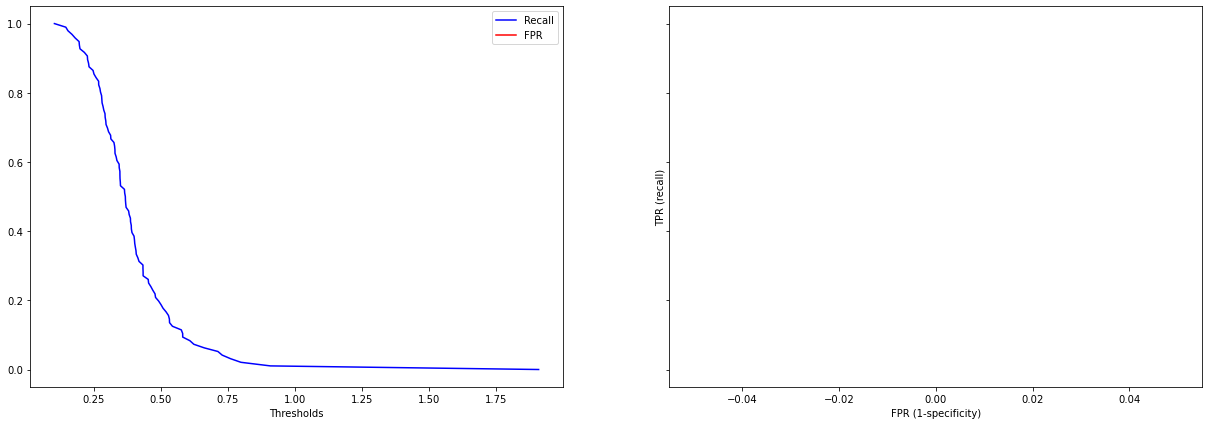

feature_importances


Permutation Importance



Mean metrics


Accuracy    Recall  Precision  Specificity        F1   ROC_AUC
Training    0.692087  0.585032   0.744526     0.799079  0.655063  0.752020
Validation  0.681539  0.570994   0.737179     0.792708  0.641671  0.740085

Spread in metrics (sample std)


Accuracy    Recall  Precision  Specificity       F1   ROC_AUC
Training    0.007024  0.013203   0.012868     0.015393  0.00843  0.006959
Validation  0.036360  0.058994   0.055189     0.056513  0.04556  0.037220

Accuracy    Recall  Precision  Specificity        F1  \
Logistic Regression  0.681539  0.570994   0.737179     0.792708  0.641671   

                      ROC_AUC  
Logistic Regression  0.740085

Accuracy  \
Logistic Regression  0.6585426258723965-0.7045348784453926   

                                                    Recall  \
Logistic Regression  0.5336831071111654-0.6083057245039547   

                                                 Precision  \
Logistic Regression  0.7022741030863923-0.7720834631399204   

                                               Specificity  \
Logistic Regression  0.7569663632431729-0.8284503034234938   

                                                        F1  \
Logistic Regression  0.6128562636477664-0.6704857895670167   

                                                   ROC_AUC  
Logistic Regression  0.7165445337473296-0.7636246475957401

In [72]:
run_models(selected_dataset, y[selected_dataset.index], {"Logistic Regression": LogisticRegression(C=2)}, ratio_negatives_to_positives=1)

╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.4
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.42000000000000004
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.44
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.46
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.48
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.5
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.52
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.54
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.56
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.58
╠■■■■■■■■■■■■■■■■■■■■■■■■■■■■■╣
Threshold: 0.6


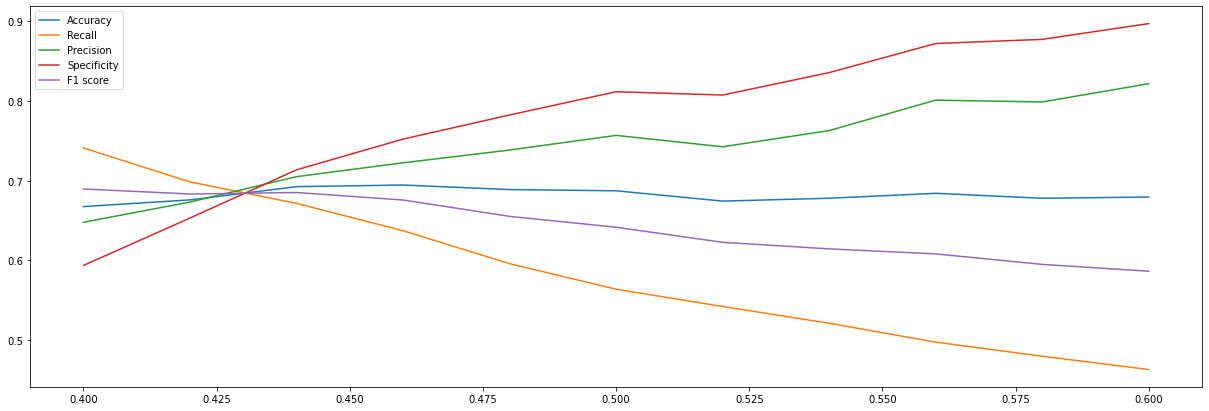

0.40      0.42      0.44      0.46      0.48      0.50  \
Accuracy     0.667492  0.675873  0.692476  0.694527  0.688838  0.687260   
Recall       0.740941  0.698422  0.671528  0.637279  0.595928  0.563920   
Precision    0.647828  0.673166  0.704985  0.722380  0.738359  0.756728   
Specificity  0.593750  0.653125  0.713542  0.752083  0.782292  0.811458   
F1           0.689566  0.683260  0.685137  0.675725  0.655234  0.641599   

                 0.52      0.54      0.56      0.58      0.60  
Accuracy     0.674375  0.677941  0.684135  0.677925  0.679487  
Recall       0.542266  0.521338  0.497569  0.479956  0.463289  
Precision    0.742462  0.762724  0.800898  0.798647  0.821500  
Specificity  0.807292  0.835417  0.871875  0.877083  0.896875  
F1           0.622686  0.614492  0.608193  0.595035  0.586486

In [73]:
run_threshold(selected_dataset, y[selected_dataset.index], LogisticRegression(C=2), thresholds=np.linspace(.4,.6,num=11), folds=30)

As we can see, the performance of the model improves a little bit if we take the results of the statistical tests into consideration for selecting them (not much but its something)

In [84]:
smote = SMOTE(sampling_strategy="minority", random_state=0)
sd_imp = selected_dataset.copy()
imputer = Imputer()
imputer.fit_transform(sd_imp, y[sd_imp.index])
X_resample, y_resample = smote.fit_resample(sd_imp, y[sd_imp.index])
display(X_resample)
imp_x = test_x.copy()
imp_x["pam"] = calculate_pam(imp_x)
imp_x = imp_x[selected_dataset.columns]
imputer.transform(imp_x)
display(imp_x)
lr = LogisticRegression(C=2)
lr.fit(X_resample, y_resample)
t_preds = lr.predict_proba(X_resample)
t_preds = pd.cut(t_preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)
preds = lr.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .44, 1.1], labels=["Negative", "Positive"], right=False)

random_even = DummyClassifier(strategy="uniform")
random_even.fit(X_resample, y_resample)

random_stratified = DummyClassifier(strategy="stratified")
random_stratified.fit(X_resample, y_resample)
pd.DataFrame([get_metrics(y_resample, t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
             index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])

wheezes ctab       pam        rr     pulse  temperature  \
0         0.0  0.0  0.544285  1.248023 -0.298478     0.725163   
1         1.0  1.0 -0.934789 -0.419150 -0.909881    -0.512399   
2         0.0  0.0 -0.620092 -1.530599  0.924328     1.255546   
3         0.0  0.0 -0.210987 -1.530599  0.236499     0.725163   
4         0.0  0.0 -1.123607 -1.530599  0.160074     0.548368   
...       ...  ...       ...       ...       ...          ...   
84613     0.0  0.0 -1.578307  0.692299 -0.285615     0.351736   
84614     0.0  0.0  0.772290  0.136575 -0.246436     0.094343   
84615     0.0  0.0  0.226380  0.692299 -1.394959     0.280172   
84616     0.0  0.0 -1.524910  0.692299  0.057580     1.195242   
84617     0.0  0.0 -0.279564 -1.429622 -0.798788     0.435821   

      high_risk_exposure_occupation cough loss_of_smell muscle_sore  \
0                               0.0   0.0           0.0         0.0   
1                               0.0   0.0           0.0         0.0   
2                               0.0   0.0           0.0         0.0   
3                               0.0   0.0           0.0         0.0   
4                               0.0   0.0           0.0         0.0   
...                             ...   ...           ...         ...   
84613                           0.0   1.0           0.0         0.0   
84614                           0.0   1.0           0.0         1.0   
84615                           0.0   1.0      0.516991    0.516991   
84616                           0.0   0.0           0.0         0.0   
84617                           0.0   1.0           0.0         1.0   

      loss_of_taste headache  days_since_symptom_onset fatigue     fever  \
0               0.0      0.0                  3.000000     0.0       1.0   
1               0.0      0.0                  3.000000     0.0       0.0   
2               0.0      0.0                  3.000000     0.0       1.0   
3               0.0      0.0                  4.000000     0.0       1.0   
4               0.0      0.0                  3.000000     0.0       0.0   
...             ...      ...                       ...     ...       ...   
84613           0.0      0.0                  3.943895     0.0       0.0   
84614           0.0      0.0                  4.000000     1.0       0.0   
84615           0.0      0.0                  5.000000     1.0       0.0   
84616           0.0      0.0                  2.341096     0.0       1.0   
84617           0.0      0.0                  1.181702     0.0  0.181702   

       diabetes  
0         False  
1         False  
2         False  
3         False  
4         False  
...         ...  
84613      True  
84614     False  
84615     False  
84616     False  
84617     False  

[84618 rows x 16 columns]

wheezes   ctab         pam         rr       pulse  temperature  \
29723   False  False  113.915995  15.235328   58.619438    37.458190   
52643   False  False  100.191032  16.325198   81.864864    37.611078   
9353    False  False   97.789163  17.415068   65.694133    37.458190   
68646   False  False  100.191032  19.594808   69.736816    37.509152   
43427   False  False   90.240433  17.415068  102.078278    37.356264   
...       ...    ...         ...        ...         ...          ...   
15775    True   True   94.701046  17.415068   52.555414    37.458190   
2812    False  False    0.000000   0.136575   -0.069202     0.000000   
20967   False  False   86.809193  13.055588   78.832852    37.458190   
90740   False  False   94.014798  15.235328  100.056937    37.662040   
50440   False  False   99.847908   0.136575   -0.069202     0.000000   

      high_risk_exposure_occupation  cough loss_of_smell muscle_sore  \
29723                         False  False         False       False   
52643                         False  False         False       False   
9353                           True  False         False       False   
68646                         False  False         False       False   
43427                          True  False         False       False   
...                             ...    ...           ...         ...   
15775                         False  False         False       False   
2812                          False  False         False        True   
20967                         False  False         False       False   
90740                         False  False         False       False   
50440                         False  False         False       False   

      loss_of_taste headache  days_since_symptom_onset fatigue  fever  \
29723         False    False                       3.0   False  False   
52643         False    False                       3.0   False  False   
9353          False    False                       3.0   False  False   
68646         False    False                       3.0   False  False   
43427         False    False                       3.0   False  False   
...             ...      ...                       ...     ...    ...   
15775         False    False                       3.0   False  False   
2812          False    False                       3.0    True  False   
20967         False    False                       3.0   False  False   
90740         False    False                       3.0   False  False   
50440         False    False                       3.0   False  False   

       diabetes  
29723     False  
52643     False  
9353      False  
68646     False  
43427     False  
...         ...  
15775     False  
2812      False  
20967     False  
90740     False  
50440     False  

[5170 rows x 16 columns]

Accuracy    Recall  Precision  Specificiy        F1
Training Data      0.682763  0.707485   0.674151    0.658040  0.690416
Test Data          0.060155  0.985915   0.028017    0.034010  0.054485
Random 50/50       0.500000  0.471831   0.025999    0.500796  0.049283
Random stratified  0.497099  0.457746   0.025116    0.498210  0.047619

It seems that even though, the performance improves in the training data, using SMOTE doesn't seem to do much (the randomly stratified model, however improves a lot, which is kind of expected). This kind of suggests that a lot of the data produced by SMOTE is not really meaningful

In [75]:
smote = SMOTE(sampling_strategy="minority", random_state=0)
sd_imp = selected_dataset.copy()
imputer = Imputer()
imputer.fit_transform(sd_imp, y[sd_imp.index])
X_resample, y_resample = smote.fit_resample(sd_imp, y[sd_imp.index])
print("Resampling done... Imputing data")
imp_x = test_x.copy()
imp_x["pam"] = calculate_pam(imp_x)
imp_x = imp_x[selected_dataset.columns]
imputer.transform(imp_x)
print("Imputing done... training model")
svc = SVC(C=2, probability=True)
svc.fit(X_resample, y_resample)
print("Training done... predictiong results")
t_preds = svc.predict_proba(X_resample)
t_preds = pd.cut(t_preds[:,1], [-1, .38, 1.1], labels=["Negative", "Positive"], right=False)
preds = svc.predict_proba(imp_x)
preds = pd.cut(preds[:,1], [-1, .38, 1.1], labels=["Negative", "Positive"], right=False)

print("Done! Doing dummy models now")
random_even = DummyClassifier(strategy="uniform")
random_even.fit(X_resample, y_resample)

random_stratified = DummyClassifier(strategy="stratified")
random_stratified.fit(X_resample, y_resample)
pd.DataFrame([get_metrics(y_resample, t_preds), get_metrics(test_y, preds), get_metrics(test_y, random_even.predict(imp_x)), get_metrics(test_y, random_stratified.predict(imp_x))], 
             index=["Training Data", "Test Data", "Random 50/50", "Random stratified"], columns=["Accuracy", "Recall", "Precision", "Specificiy", "F1"])


Resampling done... Imputing data
Imputing done... training model
Training done... predictiong results
Done! Doing dummy models now


Accuracy    Recall  Precision  Specificiy        F1
Training Data      0.710523  0.741119   0.698383    0.679926  0.719117
Test Data          0.945068  0.056338   0.050633    0.970167  0.053333
Random 50/50       0.489362  0.535211   0.028679    0.488067  0.054441
Random stratified  0.494004  0.492958   0.026779    0.494033  0.050798

## Dumping the model

In [76]:
import pickle

final_model = LogisticRegression(C=2)
imp = Imputer()
imp.fit_transform(selected_dataset, y[selected_dataset.index])
final_model.fit(selected_dataset, y[selected_dataset.index])
#pickle.dump(final_model, open("serialized_models/final_model", mode='wb'))

#test_model = pickle.load(open("serialized_models/final_model", mode='rb'))

p = final_model.predict(selected_dataset)
pp = final_model.predict_proba(selected_dataset)

ps = pd.cut(pp[:,1], [0, .5, 1], labels=["Negative", "Positive"], right=False) 
((p == ps) == 0).sum()
#pp[pp[:,1] > .5]

0

In [77]:
instance = dict(selected_dataset.loc[45622,:])
print(instance)
for value in instance:
    try:
        if(instance[value].dtype == "bool_"):
            instance[value] = bool(instance[value])
    except:
        1
    print(type(instance[value]))
len(instance)

KeyError: 45622

In [ ]:
import requests
url = 'http://localhost:5000/predict'
r = requests.post(url,json=selected_dataset.loc[45622:45622,:].to_json())

print(r.json())

In [126]:
selected_dataset.loc[45622:45623,:].to_json(orient="records")

'[{"wheezes":null,"ctab":null,"pam":0.590493547,"rr":0.6596513882,"pulse":0.6891688522,"temperature":-0.1576324641,"high_risk_exposure_occupation":false,"cough":false,"loss_of_smell":false,"muscle_sore":false,"loss_of_taste":false,"headache":false,"days_since_symptom_onset":null,"fatigue":false,"fever":false,"diabetes":false},{"wheezes":true,"ctab":false,"pam":0.5598745,"rr":-1.3839187359,"pulse":0.2350161795,"temperature":-0.505726988,"high_risk_exposure_occupation":true,"cough":false,"loss_of_smell":false,"muscle_sore":false,"loss_of_taste":false,"headache":false,"days_since_symptom_onset":null,"fatigue":false,"fever":false,"diabetes":false}]'

In [133]:
run test_script 1

El caballero de Junini contraataca


In [132]:
exec(open("test_script.py").read())

El caballero de Junini contraataca
